## Imports

In [1]:
from IPython.core.display import display, HTML


import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup, Comment
import matplotlib.pyplot as plt
import sys
import os
import time
from unidecode import unidecode
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import itertools

import sklearn

from sklearn.model_selection import cross_val_score
import sklearn.linear_model as skl_lm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV


import  scipy.signal.signaltools

# Code taken from Stack Overflow to satisfy statsmodel dependency
def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import statsmodels.api as sm


from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt



In [2]:
# Import Cleaned Data
NBAData = pd.read_csv('NBAandSalaryStats.csv')

for col in NBAData.columns:
    # Only 23 values have -1 in them for most rows which should mostly be the same rows so drop those
    print(col+": "+str(sum([1 if x == '-1' else 0 for x in NBAData[col]])))

# 0 means their salary didn't exist (not in the league anymore) and -1 means they are too young to have an extension
NBAData = NBAData[NBAData["Heaves (#) year 2"] != -1]
NBAData = NBAData[NBAData["Salary: age 26"] != "-1"]
NBAData = NBAData.dropna().reset_index()

# Normalize data so it isn't overly large
NBAData['year'] = NBAData['year']-1995

# Initialize dependent variable
NBAData["AAV_InPrime"] = -2

# remove -XY (e.g. 1996-97 => 1996)
NBAData["Season year 0"] = np.vectorize(int)([x[:4] for x in NBAData["Season year 0"]])

for row in range(len(NBAData)):
    yearsIncluded = 1
    amountMade = int(NBAData.loc[row,"Salary: age 26"].lstrip('$').replace(",",""))+.5
    
    #  Don't consider -1 because that just means the player is too young (for all years)
    if int(NBAData.loc[row,"Salary: age 27"].lstrip('$').replace(",","")) != -1:
        amountMade+=int(NBAData.loc[row,"Salary: age 27"].lstrip('$').replace(",",""))
        yearsIncluded+=1
        
    if int(NBAData.loc[row,"Salary: age 28"].lstrip('$').replace(",","")) != -1:
        amountMade+=int(NBAData.loc[row,"Salary: age 28"].lstrip('$').replace(",",""))
        yearsIncluded+=1
    
    if int(NBAData.loc[row,"Salary: age 29"].lstrip('$').replace(",","")) != -1:
        amountMade+=int(NBAData.loc[row,"Salary: age 29"].lstrip('$').replace(",",""))
        yearsIncluded+=1
        
    # AAV_InPrime
    NBAData.loc[row,"AAV_InPrime"] = float(amountMade/yearsIncluded)

# Display number of columns and first 5 rows
display(NBAData.head())
print(len(NBAData.columns))


Unnamed: 0: 0
year: 0
rank: 0
overall_pick: 0
team: 0
player: 0
years_active: 0
height: 0
weight: 0
Season year 0: 22
Season year 1: 22
Season year 2: 22
Age year 0: 0
Age year 1: 0
Age year 2: 0
Tm year 0: 22
Tm year 1: 22
Tm year 2: 22
Lg year 0: 22
Lg year 1: 22
Lg year 2: 22
Pos year 0: 22
Pos year 1: 22
Pos year 2: 22
G year 0: 0
G year 1: 0
G year 2: 0
MP year 0: 0
MP year 1: 0
MP year 2: 0
FG% year 0: 0
FG% year 1: 0
FG% year 2: 0
Dist. year 0: 0
Dist. year 1: 0
Dist. year 2: 0
% of FGA by Distance (2P) year 0: 0
% of FGA by Distance (2P) year 1: 0
% of FGA by Distance (2P) year 2: 0
FG% by Distance (2P) year 0: 0
FG% by Distance (2P) year 1: 0
FG% by Distance (2P) year 2: 0
% of FG Ast'd (2P) year 0: 0
% of FG Ast'd (2P) year 1: 0
% of FG Ast'd (2P) year 2: 0
Dunks (%FGA) year 0: 0
Dunks (%FGA) year 1: 0
Dunks (%FGA) year 2: 0
Dunks (#) year 0: 0
Dunks (#) year 1: 0
Dunks (#) year 2: 0
Heaves (Att.) year 0: 0
Heaves (Att.) year 1: 0
Heaves (Att.) year 2: 0
Heaves (#) year 0: 0


index  Unnamed: 0  year  rank  overall_pick team               player  \
0      0           0     1     1             1  PHI        Allen Iverson   
1      1           1     1     2             2  TOR         Marcus Camby   
2      2           2     1     3             3  VAN  Shareef Abdur-Rahim   
3      3           3     1     4             4  MIL      Stephon Marbury   
4      4           4     1     5             5  MIN            Ray Allen   

   years_active  height  weight  ...  ORtg year 1 ORtg year 2 DRtg year 0  \
0          14.0   183.0    74.0  ...          109       105.0         112   
1          17.0   211.0    99.0  ...           94       108.0         105   
2          12.0   188.0    81.0  ...          105       108.0         111   
3          13.0   196.0    92.0  ...          106       110.0         110   
4          18.0   206.0   101.0  ...           98        96.0         111   

   DRtg year 1  DRtg year 2  Salary: age 26 Salary: age 27 Salary: age 28  \
0          106         99.0     $19,283,574    $20,987,903    $22,422,272   
1          107         93.0     $10,176,199    $12,512,897    $11,447,947   
2          111        107.0     $22,422,272    $23,522,504     $7,843,419   
3          108        106.0     $19,283,574    $20,987,903    $22,422,272   
4          104        101.0     $20,987,903    $22,422,272    $23,522,504   

  Salary: age 29   AAV_InPrime  
0    $23,522,504  2.155406e+07  
1    $12,041,590  1.154466e+07  
2     $8,120,200  1.547710e+07  
3    $23,522,504  2.155406e+07  
4    $20,742,925  2.191890e+07  

[5 rows x 123 columns]

123


['year', 'rank', 'overall_pick', 'years_active', 'height', 'weight', 'Age year 0', 'G year 0', 'G year 1', 'G year 2', 'MP year 0', 'MP year 1', 'MP year 2', 'FG% year 0', 'FG% year 1', 'FG% year 2', 'Dist. year 0', 'Dist. year 1', 'Dist. year 2', '% of FGA by Distance (2P) year 0', '% of FGA by Distance (2P) year 1', '% of FGA by Distance (2P) year 2', 'FG% by Distance (2P) year 0', 'FG% by Distance (2P) year 1', 'FG% by Distance (2P) year 2', "% of FG Ast'd (2P) year 0", "% of FG Ast'd (2P) year 1", "% of FG Ast'd (2P) year 2", 'Dunks (%FGA) year 0', 'Dunks (%FGA) year 1', 'Dunks (%FGA) year 2', 'Dunks (#) year 0', 'Dunks (#) year 1', 'Dunks (#) year 2', 'Heaves (Att.) year 0', 'Heaves (Att.) year 1', 'Heaves (Att.) year 2', 'Heaves (#) year 0', 'Heaves (#) year 1', 'Heaves (#) year 2', 'GS year 0', 'GS year 1', 'GS year 2', 'FG year 0', 'FG year 1', 'FG year 2', 'FGA year 0', 'FGA year 1', 'FGA year 2', '2P year 0', '2P year 1', '2P year 2', '2PA year 0', '2PA year 1', '2PA year 2',

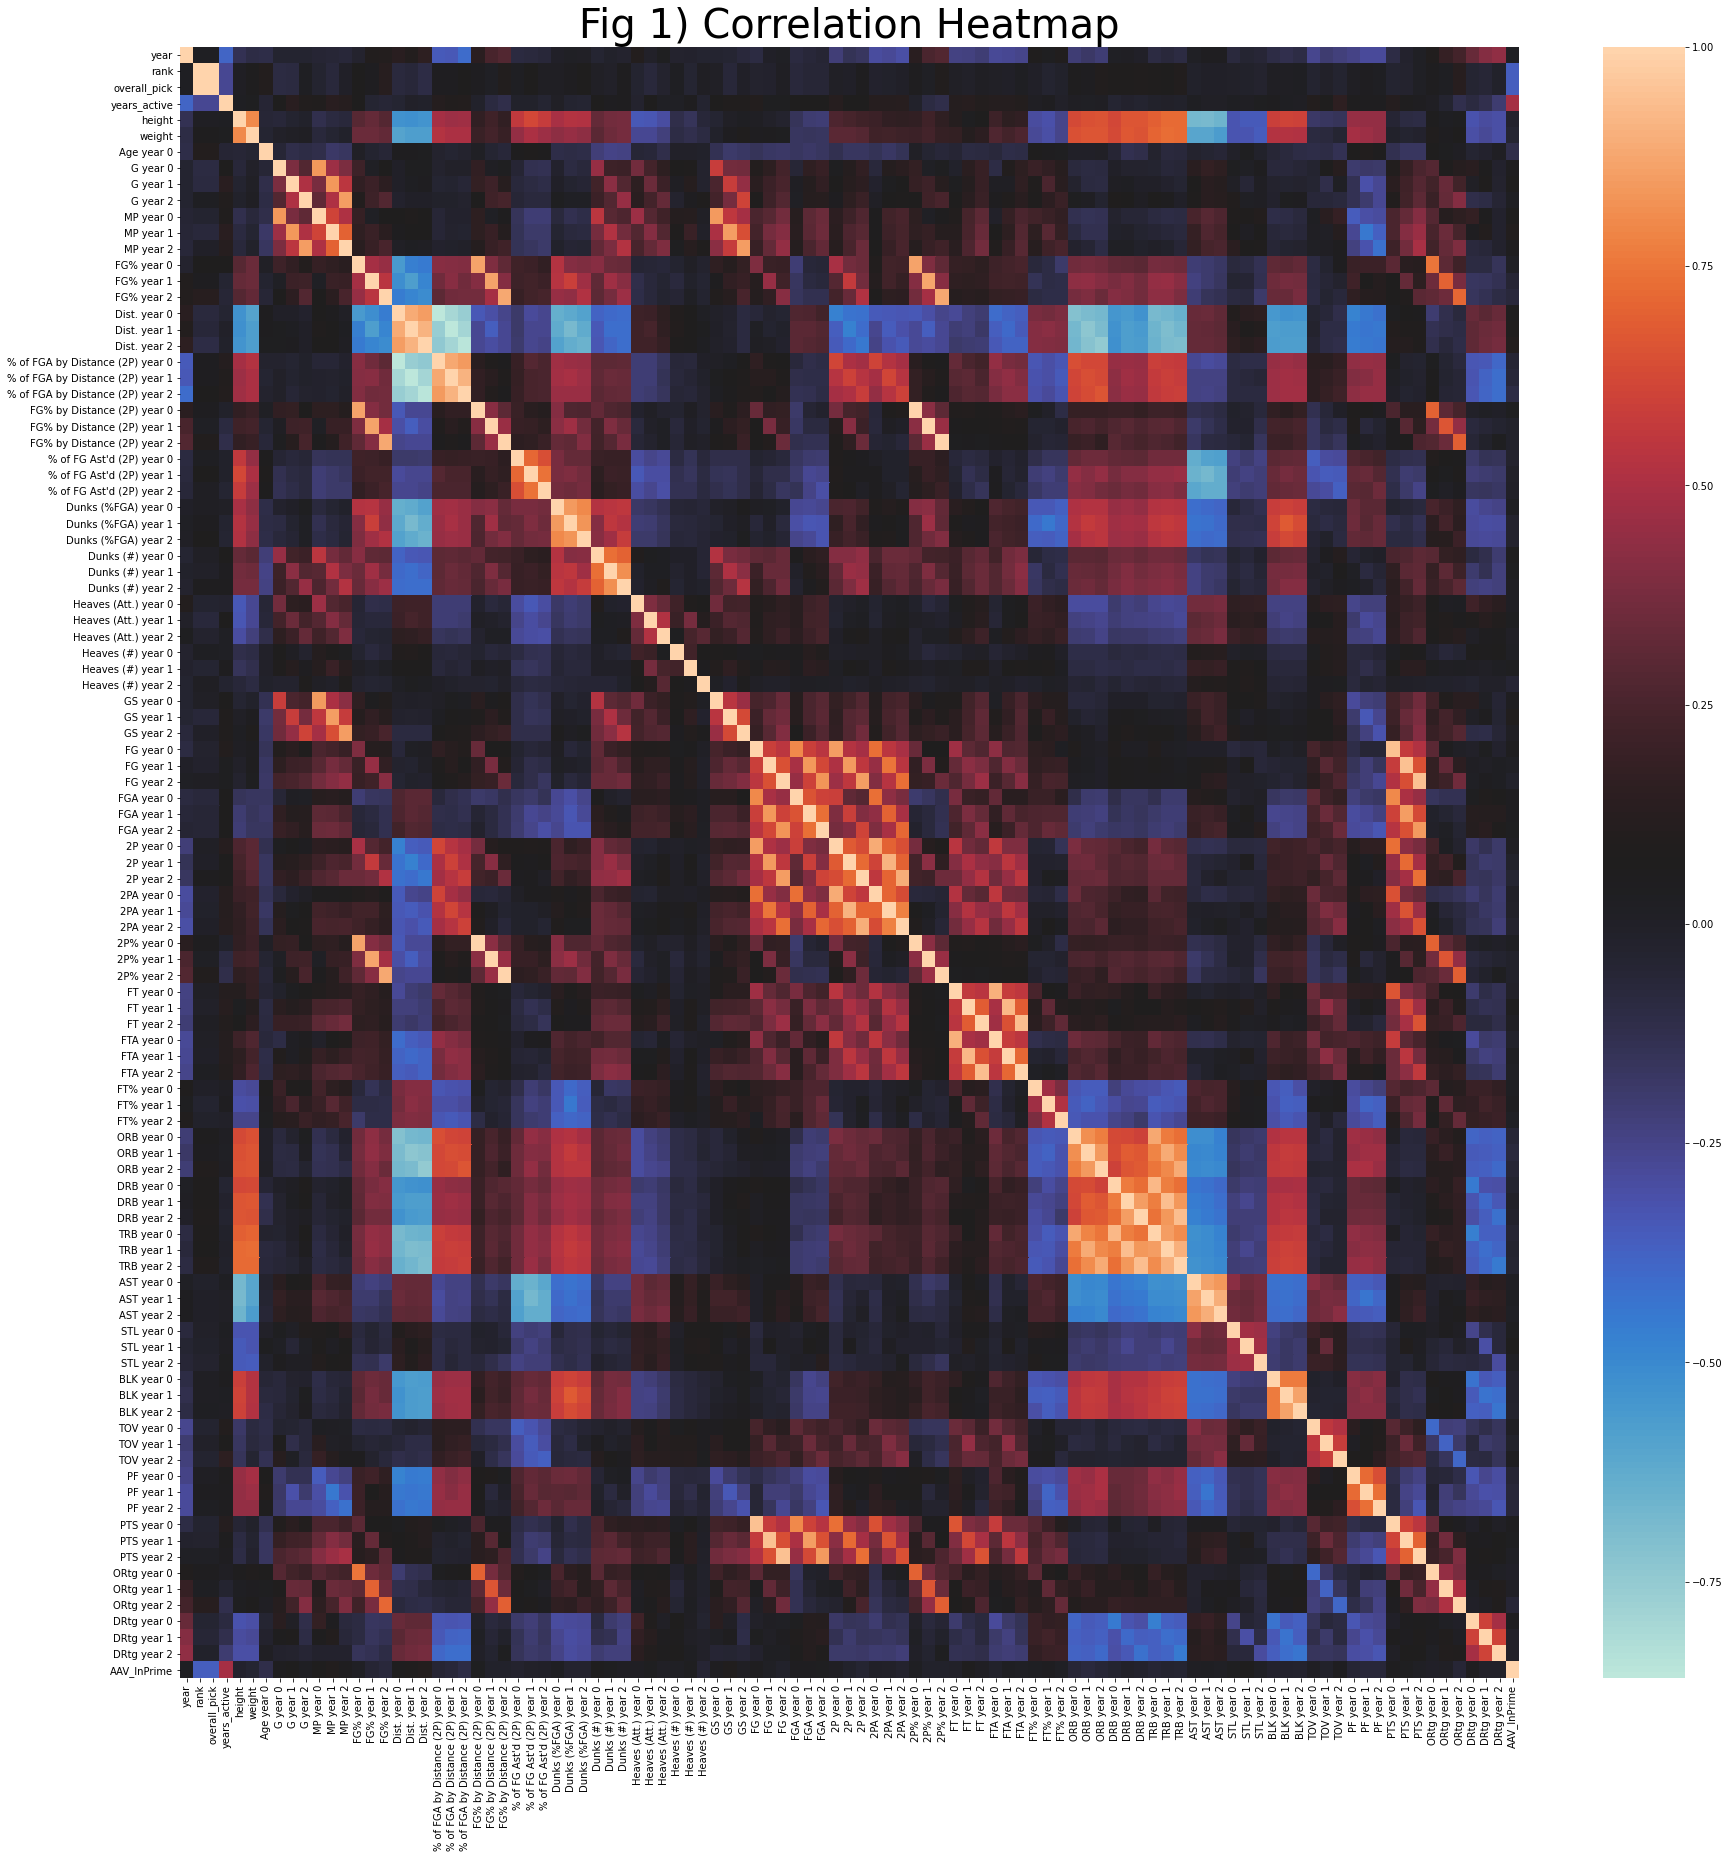

100


In [3]:
xcols = list(NBAData.columns)[:-5]

# Eliminate unnecessary/redundant columns
xcols.remove('player')
xcols.remove('team')
xcols.remove('index')
xcols.remove('Age year 1')
xcols.remove('Age year 2')
xcols.remove('Unnamed: 0')

# Permanently Remove Qualitative columns that shouldn't matter too much 
for qualitativeColumn in ['Tm','Lg','Season','Pos']:
    for i in range(3):
        xcols.remove(qualitativeColumn+' year '+str(i))
        
# Dependent variable
ycol = ['AAV_InPrime']        
        
print(xcols,ycol)

allcols = xcols.copy()
allcols.append(ycol[0])


newDF = pd.DataFrame(NBAData[allcols],dtype=float)

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

# Generate Heatmap of correlations
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['figure.figsize'] = [30, 30]
disp = sns.heatmap(newDF.corr(),cmap='icefire')
plt.title('Fig 1) Correlation Heatmap')
plt.show()

print(len(xcols))

The above heatmap illustrates a couple concepts that intuitively make sense:
- Height and Weight are positively correlated with rebounds and negatively correlated with average field goal distance
- % of field goals made is inversely correlated with FG distance
- FG attempted is correlated with FG made
- Offensive and Defensive Rebounding are highly correlated
- Assists are negatively correlated with Rebounds
- Defensive Rating is negatively Correlated with rebounds

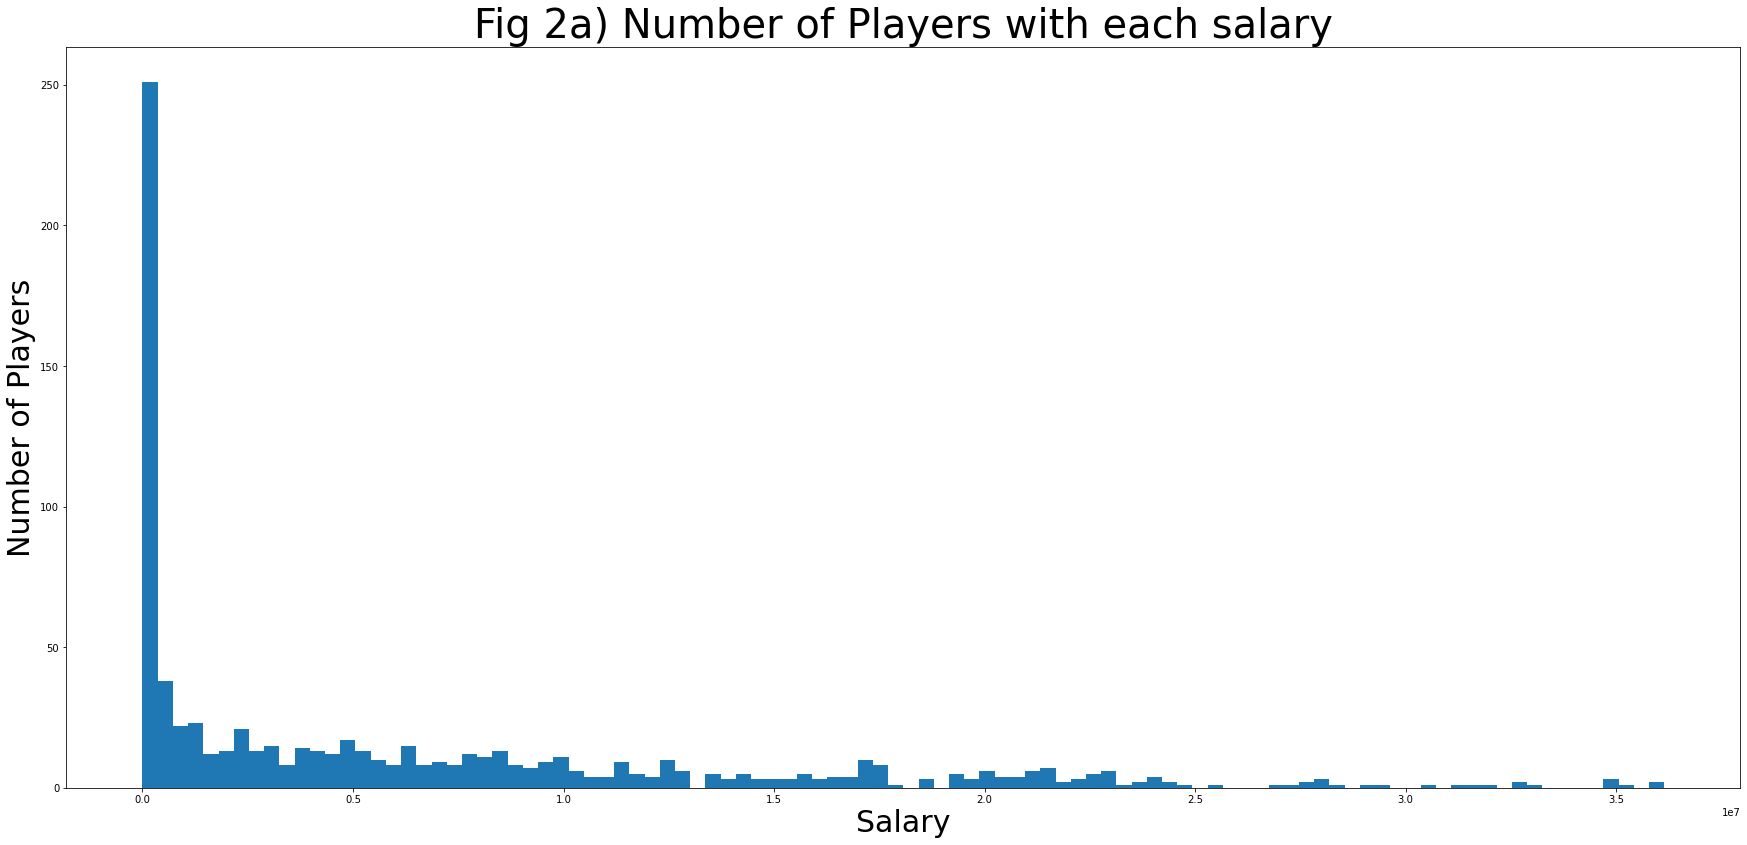

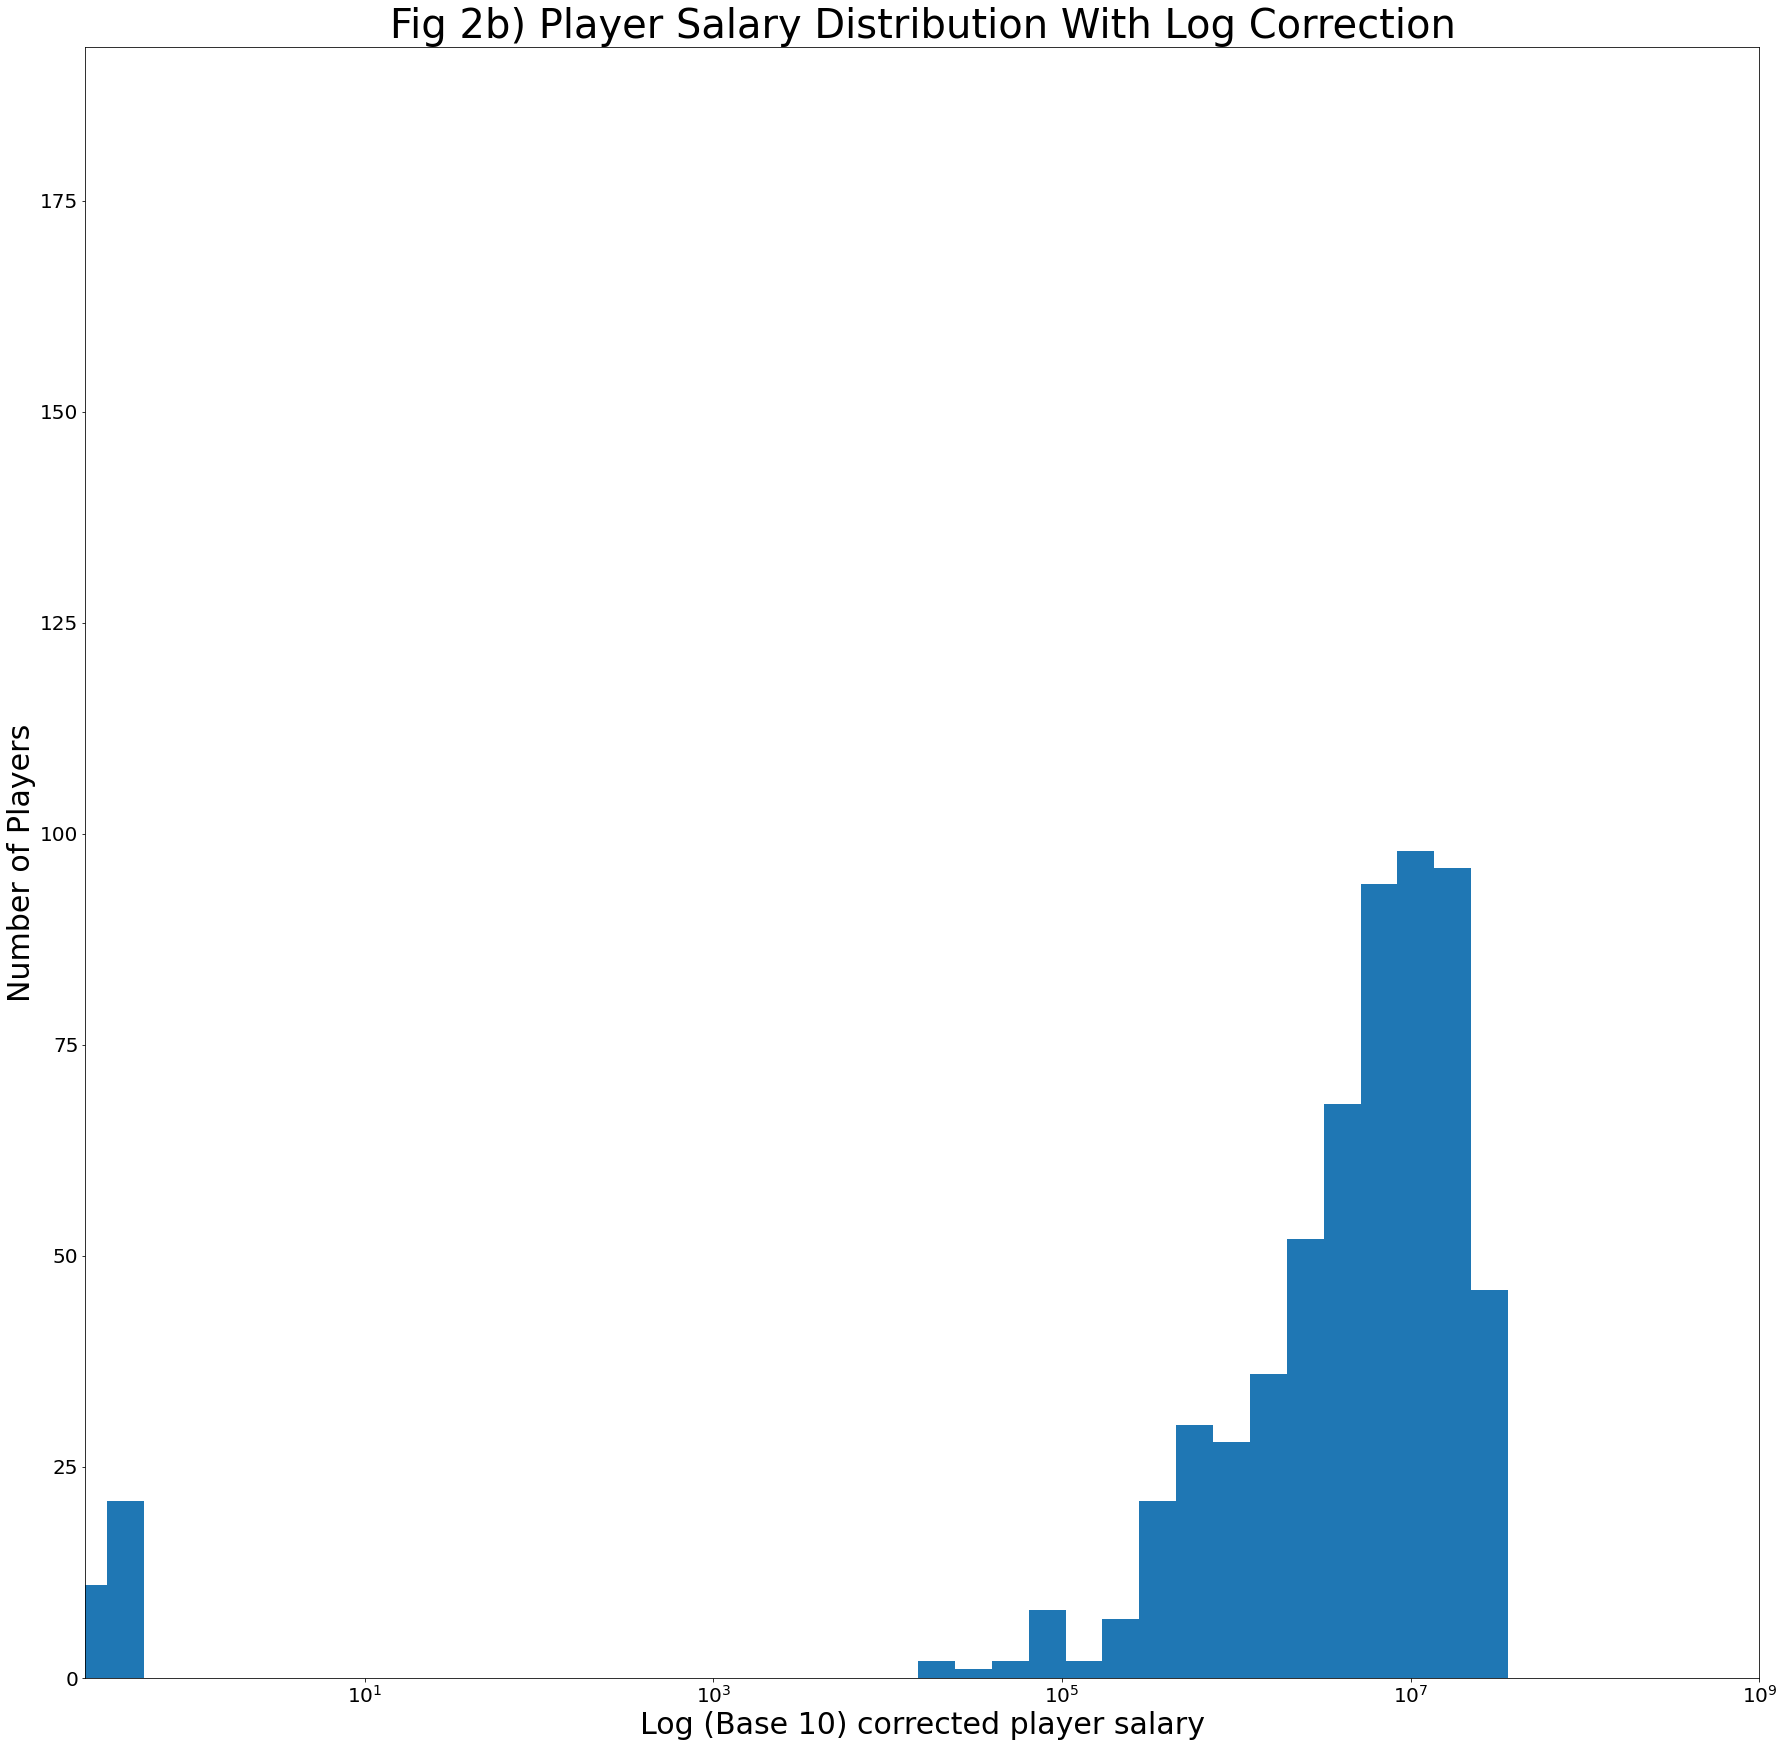

In [4]:
## Plot salary distributions 

hist, bins, _ = plt.hist(NBAData['AAV_InPrime'], bins=40)

logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

plt.hist(NBAData['AAV_InPrime'], bins=100)
plt.xlabel("Salary")
plt.ylabel("Number of Players")
plt.title("Fig 2a) Number of Players with each salary")
plt.show()

# Plot again with Log Correction to account for the right skew

plt.hist(NBAData['AAV_InPrime'], bins=logbins)
plt.xlim([0.25, 10**9])
plt.xscale('log')
plt.title('Fig 2b) Player Salary Distribution With Log Correction')
plt.xlabel('Log (Base 10) corrected player salary')
plt.ylabel('Number of Players')



plt.rcParams.update({'font.family': 'sans-serif'})

plt.show()

In [5]:
## Segment the data into quartiles to produce metrics for value

sortedSalaries = sorted(NBAData['AAV_InPrime'])

# 5 number summary of In Prime AAV
print("Min: "+str(int(sortedSalaries[0]))) 
print("Q1: "+str(int(sortedSalaries[len(sortedSalaries)//4])))
print("Median: "+str(int(sortedSalaries[len(sortedSalaries)//2]))) 
print("Q3: "+str(int(sortedSalaries[(3*len(sortedSalaries))//4]))) 
print("Max: "+str(int(sortedSalaries[-1])))

# Display Upper Quartile mean

print("Mean of 4th Quartile: "+str(sum(sortedSalaries[(3*len(sortedSalaries))//4:])/(len(sortedSalaries)*(1/4))))

Min: 0
Q1: 0
Median: 3081113
Q3: 9852664
Max: 36138577
Mean of 4th Quartile: 18209739.02333746


We see here that while 200 or so players were no longer in the league during their prime years, the remaining players cluster somewhat normally about the mean of 10^7 (in log form, as linearly it is heavily right skewed)

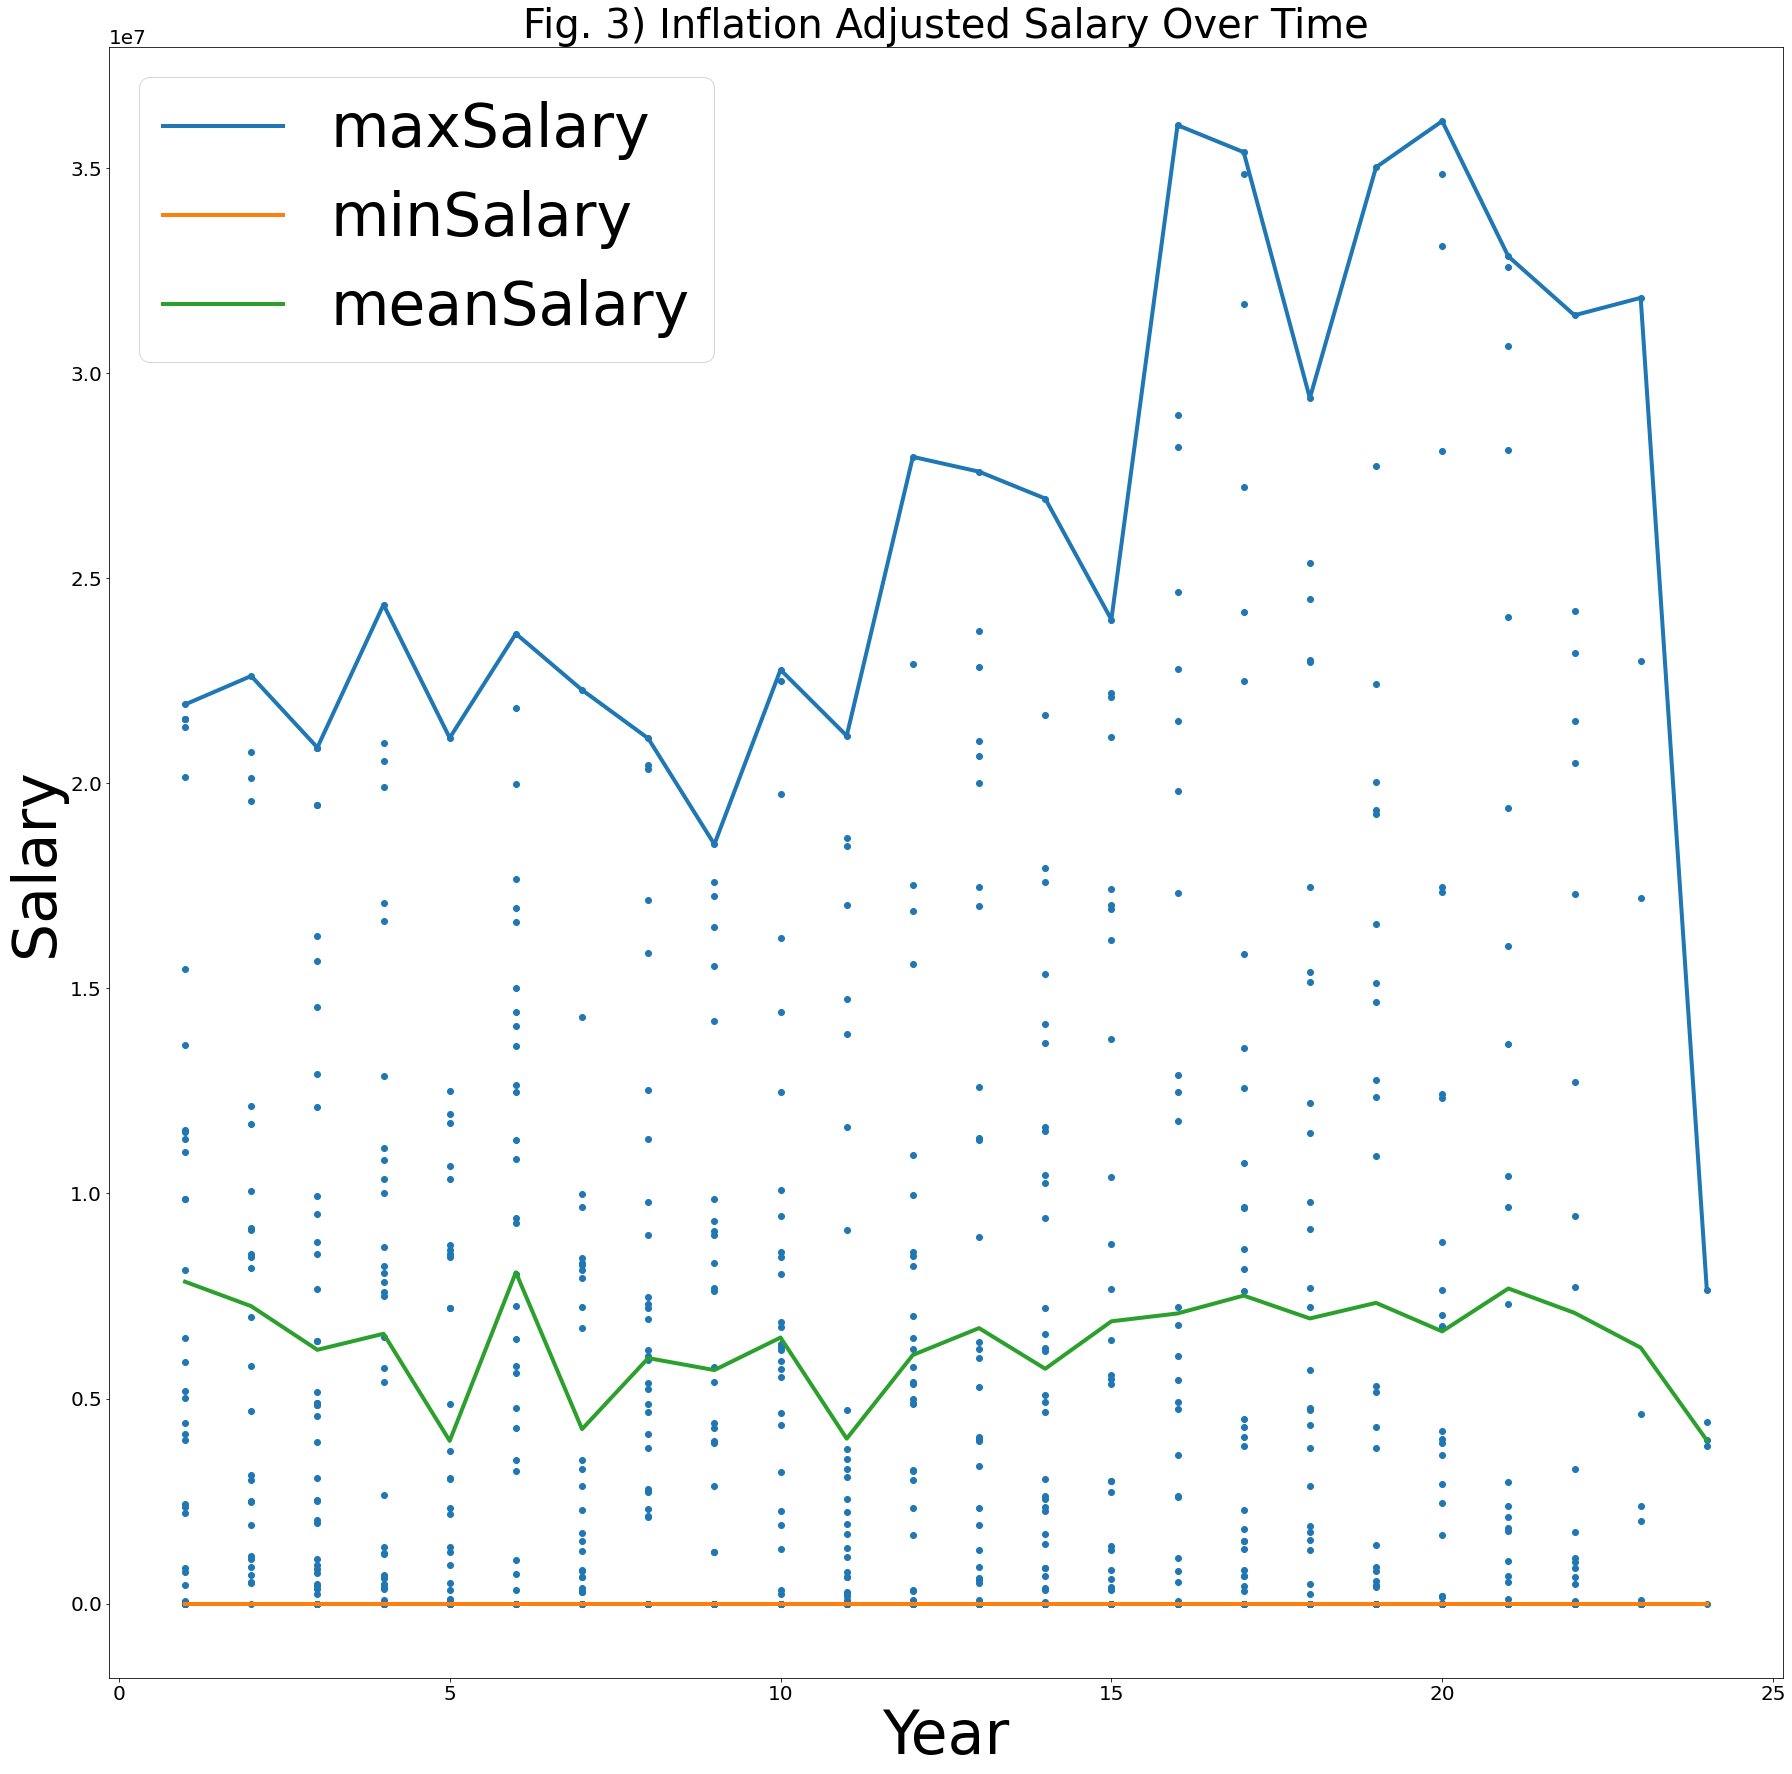

In [6]:
# Ensure that inflation adjusted salary was a usable metric and it didn't change too much over time

maxlst = []
minlst = []
meanlst = []
for year in NBAData['year']:
    maxlst.append(max(NBAData[NBAData['year'] == year]['AAV_InPrime']))
    minlst.append(min(NBAData[NBAData['year'] == year]['AAV_InPrime']))
    
    # Find average
    avg = lambda x: sum(x)/len(x)
    meanlst.append(avg(list(NBAData[NBAData['year'] == year]['AAV_InPrime'])))
    
plt.scatter(NBAData['year'],NBAData['AAV_InPrime'])
plt.plot(NBAData['year'],maxlst, label = "maxSalary")
plt.plot(NBAData['year'],minlst, label = "minSalary")
plt.plot(NBAData['year'],meanlst, label = "meanSalary")
plt.xlabel("Year",fontsize=60)
plt.ylabel("Salary",fontsize=60)
plt.title("Fig. 3) Inflation Adjusted Salary Over Time")
plt.legend(loc=2, prop={'size': 60})
plt.show()

Though the highest salaries continue to rise, the inflation adjusted mean stays pretty constant, so we can move forward with that as the dependent variable indicative of the player's value

In [7]:
# First Model Just for Fun


alphas = 10**np.linspace(10,-2,100)

xcols = list(NBAData.columns)[:-5]
xcols.remove('player')
xcols.remove('team')
xcols.remove('index')
xcols.remove('years_active')
xcols.remove('overall_pick')
xcols.remove('Unnamed: 0')
xcols.remove('Age year 1')
xcols.remove('Age year 2')

# Permanently Remove
for qualitativeColumn in ['Season','Tm','Lg','Pos']:
    for i in range(3):
        xcols.remove(qualitativeColumn+' year '+str(i))
        
# Split data into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(NBAData[xcols],NBAData['AAV_InPrime'], test_size=0.2, random_state=11)

# Prelim Statistical analysis
linModel = sm.regression.linear_model.OLS(NBAData['AAV_InPrime'],NBAData[xcols])
regr = linModel.fit()
regressionSummary = regr.summary()
regressionSummary



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            AAV_InPrime   R-squared (uncentered):                   0.540
Model:                            OLS   Adj. R-squared (uncentered):              0.477
Method:                 Least Squares   F-statistic:                              8.495
Date:                Sun, 03 Mar 2024   Prob (F-statistic):                    1.99e-70
Time:                        20:01:49   Log-Likelihood:                         -13855.
No. Observations:                 807   AIC:                                  2.791e+04
Df Residuals:                     709   BIC:                                  2.837e+04
Df Model:                          98                                                  
Covariance Type:            nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
year                              3.185e+04   7.07e+04      0.451      0.652   -1.07e+05    1.71e+05
rank                             -1.838e+05   1.88e+04     -9.790      0.000   -2.21e+05   -1.47e+05
height                            1.272e+04    6.3e+04      0.202      0.840   -1.11e+05    1.36e+05
weight                            1.347e+04   4.54e+04      0.297      0.767   -7.57e+04    1.03e+05
Age year 0                       -3.332e+05   1.88e+05     -1.774      0.077   -7.02e+05    3.57e+04
G year 0                         -3.694e+04   2.95e+04     -1.252      0.211   -9.49e+04     2.1e+04
G year 1                         -2843.3925   3.33e+04     -0.085      0.932   -6.82e+04    6.25e+04
G year 2                          1.322e+04   3.08e+04      0.429      0.668   -4.73e+04    7.38e+04
MP year 0                         1911.8381   1441.810      1.326      0.185    -918.889    4742.565
MP year 1                            4.4549   1488.685      0.003      0.998   -2918.303    2927.213
MP year 2                          871.3452   1376.504      0.633      0.527   -1831.167    3573.857
FG% year 0                        8.906e+06   2.62e+07      0.340      0.734   -4.25e+07    6.03e+07
FG% year 1                        3.582e+05   3.21e+07      0.011      0.991   -6.27e+07    6.34e+07
FG% year 2                       -2.165e+06   2.49e+07     -0.087      0.931   -5.11e+07    4.67e+07
Dist. year 0                      2.316e+05   2.43e+05      0.955      0.340   -2.45e+05    7.08e+05
Dist. year 1                        7.5e+04   2.98e+05      0.251      0.802   -5.11e+05    6.61e+05
Dist. year 2                     -4.377e+04   2.38e+05     -0.184      0.854   -5.11e+05    4.24e+05
% of FGA by Distance (2P) year 0  4.585e+06   1.04e+07      0.440      0.660   -1.59e+07    2.51e+07
% of FGA by Distance (2P) year 1  9.912e+06   1.19e+07      0.829      0.407   -1.35e+07    3.34e+07
% of FGA by Distance (2P) year 2 -1.558e+07   1.05e+07     -1.487      0.137   -3.62e+07    4.99e+06
FG% by Distance (2P) year 0       1.453e+08   1.27e+08      1.144      0.253   -1.04e+08    3.95e+08
FG% by Distance (2P) year 1       1.537e+08   1.41e+08      1.089      0.276   -1.23e+08    4.31e+08
FG% by Distance (2P) year 2      -5.041e+07   1.32e+08     -0.383      0.702   -3.09e+08    2.08e+08
% of FG Ast'd (2P) year 0        -5.843e+06   2.61e+06     -2.240      0.025    -1.1e+07   -7.22e+05
% of FG Ast'd (2P) year 1         5.257e+06   3.06e+06      1.720      0.086   -7.45e+05    1.13e+07
% of FG Ast'd (2P) year 2         2.198e+06   2.86e+06      0.769      0.442   -3.41e+06    7.81e+06
Dunks (%FGA) year 0               1.899e+07   8.87e+06 

Values with P score < 0.05 are as follows:
- rank  (what pick they were selected with)
- % of FG Ast'd (2P) year 0
- Dunks (%FGA) year 0	
- STL year 1

Year 1 steals seems to be an anomaly, however the middle two provide the insight that year 0 performance and shot creation ability is a massive factor, and the fact that rank matters so much may be an indication that teams are less willing to let high draft picks leave. 

Also, there seems to be multicollinearity in droves, which will be dealt with during model testing

### We notice based on the salary distribution that there is a large cluster of players no longer in the league, and the rest of the data is normally distributed about 10^7 with a log correction. As such, we will split up the task into two steps:
#### 1) Predict whether the player will remain in the league (Classification)

#### 2) Predict what the salary ceiling for the player should be

In [8]:
## Create new dependent variable for if player is in the league or not

cols = list(NBAData.columns)

cols.remove('years_active') # This would give us the answer if we included it 
cols.remove('player')
cols.remove('team')
cols.remove('index')
cols.remove('Unnamed: 0')
cols.remove('overall_pick')
cols.remove('Age year 1')
cols.remove('Age year 2')


# Permanently Remove
for qualitativeColumn in ['Season','Tm','Lg']:
    for i in range(3):
        cols.remove(qualitativeColumn+' year '+str(i))
        
# Find a way to add back later (Was not added back later)
for qualitativeColumn in ['Pos']:
    for i in range(3):
        cols.remove(qualitativeColumn+' year '+str(i))
        
# Create New Dataset with different dependent variable for the classification task
NBAData2 = NBAData[cols]

# Creates the new variable [(One year league minimum salary in 2005)/ 4 is about 100000]
NBAData2["InTheLeague"] = [1 if NBAData2.loc[i,"AAV_InPrime"] > 100000 else 0 for i in range(0,len(NBAData2))]

xcols = cols[:-6]
# Create Train and Test split for classification problem
X_train, X_test, y_train, y_test = train_test_split(NBAData2[xcols],NBAData2['InTheLeague'], test_size=0.2, random_state=11)

# 20% of data kept as validation set
X_train1 = X_train[:int(len(X_train)*0.8)] # Train set x
X_train2 = X_train[int(len(X_train)*0.8):] # Validation set x
y_train1 = y_train[:int(len(y_train)*0.8)] # Train set y
y_train2 = y_train[int(len(y_train)*0.8):] # Validation Set y

display(X_train.head())
display(y_train.head())
print(len(X_train))

<ipython-input-8-7b61543821b0>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NBAData2["InTheLeague"] = [1 if NBAData2.loc[i,"AAV_InPrime"] > 100000 else 0 for i in range(0,len(NBAData2))]


year  rank  height  weight  Age year 0  G year 0  G year 1  G year 2  \
731    20    44   193.0    94.0          19        14        19        72   
774    22    20   185.0    90.0          23        39        58        60   
202     6    27   206.0   100.0          23        68        49        22   
33      1    54   211.0   113.0          21        82        50        74   
240     7    44   201.0    97.0          23        72        45        65   

     MP year 0  MP year 1  ...  PF year 1  PF year 2  PTS year 0  PTS year 1  \
731        253        427  ...        5.8        3.5        19.0        17.1   
774        577        945  ...        4.3        3.9        14.8        14.4   
202       1110        632  ...        3.0        5.4        12.5        15.6   
33        3204       1963  ...        4.1        3.9        29.3        29.9   
240       1514        675  ...        5.8        4.6        19.5        24.6   

     PTS year 2  ORtg year 0  ORtg year 1  ORtg year 2  DRtg year 0  \
731        21.2         96.0           99        104.0          105   
774        17.1         90.0          114        115.0          109   
202         9.9         94.0          101         75.0          110   
33         31.6        108.0          106        109.0           95   
240        18.5         88.0          108        100.0          104   

     DRtg year 1  
731          111  
774          111  
202          104  
33            91  
240          105  

[5 rows x 97 columns]

731    0
774    1
202    1
33     1
240    1
Name: InTheLeague, dtype: int64

645


##### We will start with a Decision Tree Classifier model with maximum depth 4 to try to keep it explainable...

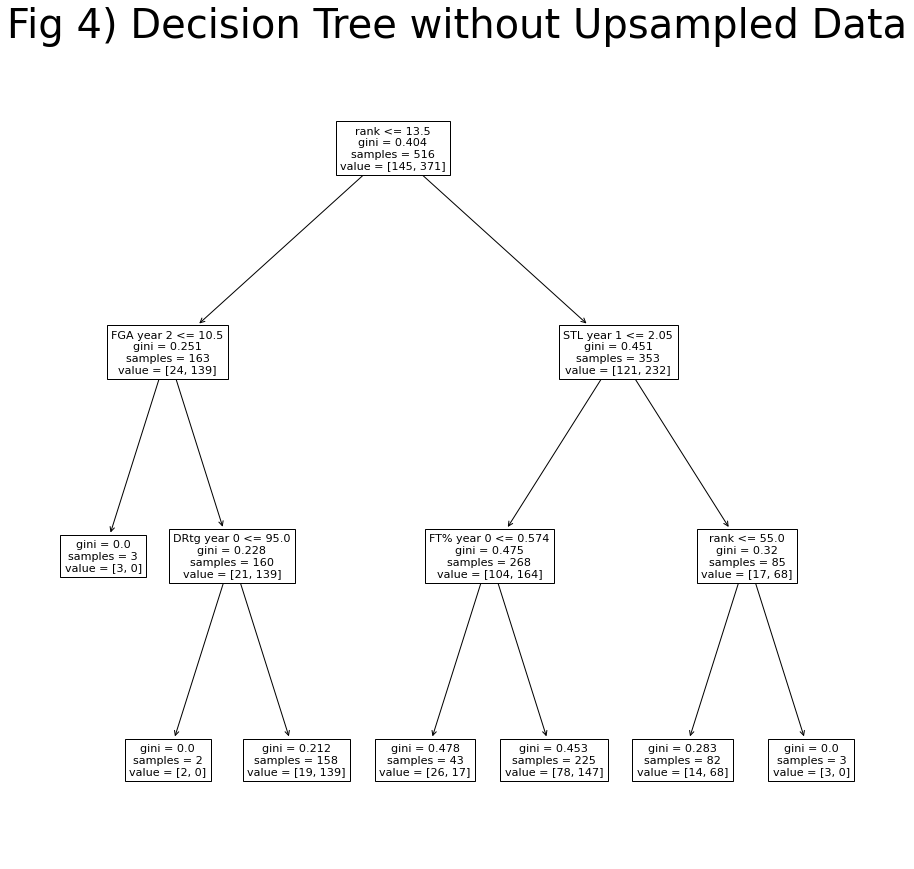

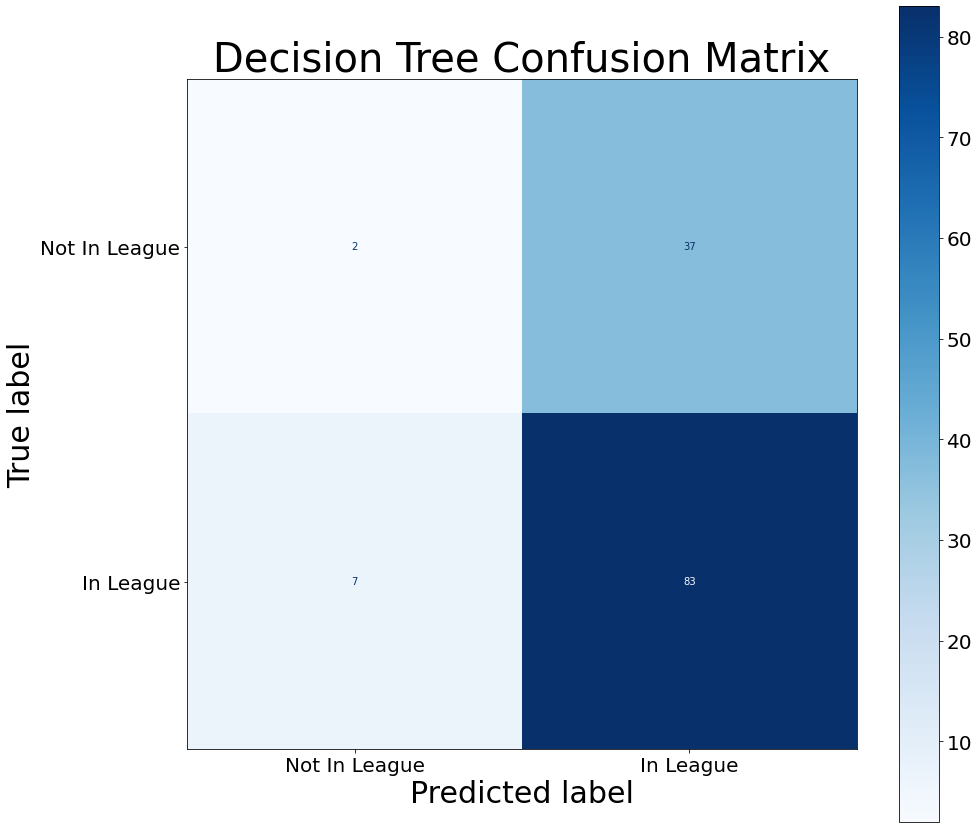

Decision Tree Accuracy Score: 0.6589147286821705


In [9]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First model tested is Decision Tree Classifier
DecisionTree = DecisionTreeClassifier(splitter='best', max_depth=3, min_samples_split=20, random_state=11)

# Fit the model on train dataset
_ = DecisionTree.fit(X_train1,y_train1)

# Display the decision process that was learned
plt.rcParams['figure.figsize'] = [15,15]
plot_tree(DecisionTree, feature_names = xcols)
plt.title('Decision Tree')
plt.title('Fig 4) Decision Tree without Upsampled Data')
plt.show()

ypreds2 = DecisionTree.predict(X_train2)

# Display confusion matrix to get better sense of the error
disp = ConfusionMatrixDisplay.from_estimator(
        DecisionTree,
        X_train2,
        y_train2,
        display_labels=["Not In League","In League"],
        cmap=plt.cm.Blues,
        normalize=None,
    )

# print(len(y_train2[y_train2==1])) -- 1 means in league, so label the confusion matrix accordingly

plt.rcParams['figure.figsize'] = [5, 5]
disp.ax_.set_title("Decision Tree Confusion Matrix")

plt.show()


# Accuracy Score is suitable because we can say that a false positive and negative are 'equally bad'
print("Decision Tree Accuracy Score: " + str(DecisionTree.score(X_train2,y_train2)))





## The accuracy is quite low and the model seems to prefer guessing In League (most likely due to excess of those in the distribution of data)

## I will upsample to try to balance the confusion matrix and tree better

['year', 'rank', 'height', 'weight', 'Age year 0', 'G year 0', 'G year 1', 'G year 2', 'MP year 0', 'MP year 1', 'MP year 2', 'FG% year 0', 'FG% year 1', 'FG% year 2', 'Dist. year 0', 'Dist. year 1', 'Dist. year 2', '% of FGA by Distance (2P) year 0', '% of FGA by Distance (2P) year 1', '% of FGA by Distance (2P) year 2', 'FG% by Distance (2P) year 0', 'FG% by Distance (2P) year 1', 'FG% by Distance (2P) year 2', "% of FG Ast'd (2P) year 0", "% of FG Ast'd (2P) year 1", "% of FG Ast'd (2P) year 2", 'Dunks (%FGA) year 0', 'Dunks (%FGA) year 1', 'Dunks (%FGA) year 2', 'Dunks (#) year 0', 'Dunks (#) year 1', 'Dunks (#) year 2', 'Heaves (Att.) year 0', 'Heaves (Att.) year 1', 'Heaves (Att.) year 2', 'Heaves (#) year 0', 'Heaves (#) year 1', 'Heaves (#) year 2', 'GS year 0', 'GS year 1', 'GS year 2', 'FG year 0', 'FG year 1', 'FG year 2', 'FGA year 0', 'FGA year 1', 'FGA year 2', '2P year 0', '2P year 1', '2P year 2', '2PA year 0', '2PA year 1', '2PA year 2', '2P% year 0', '2P% year 1', '2P

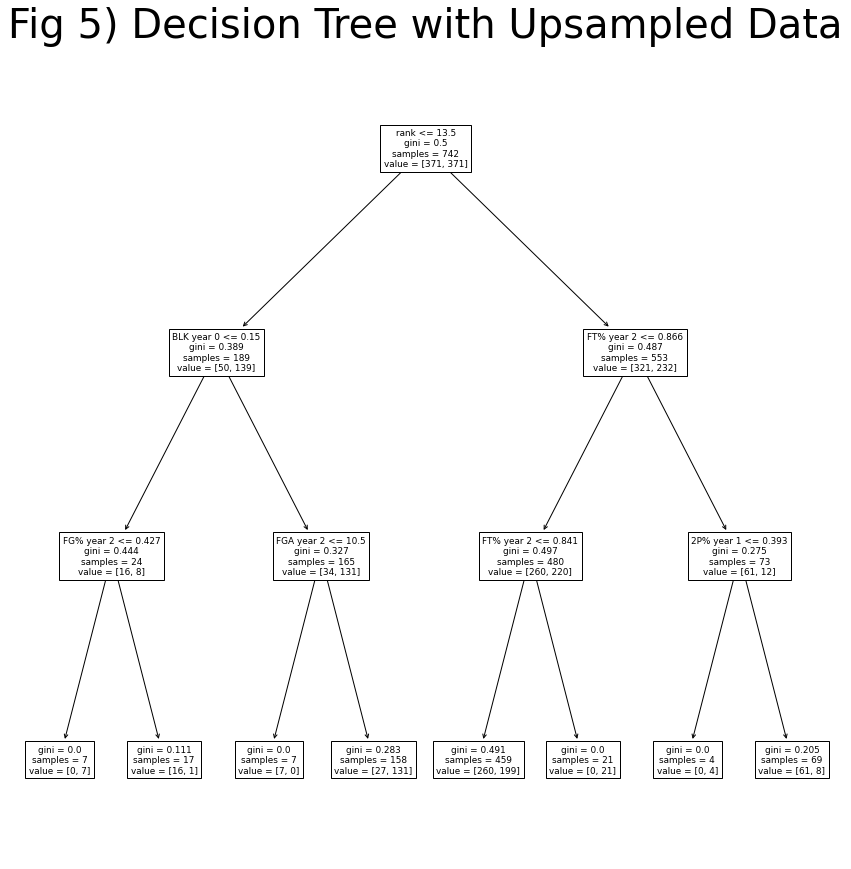

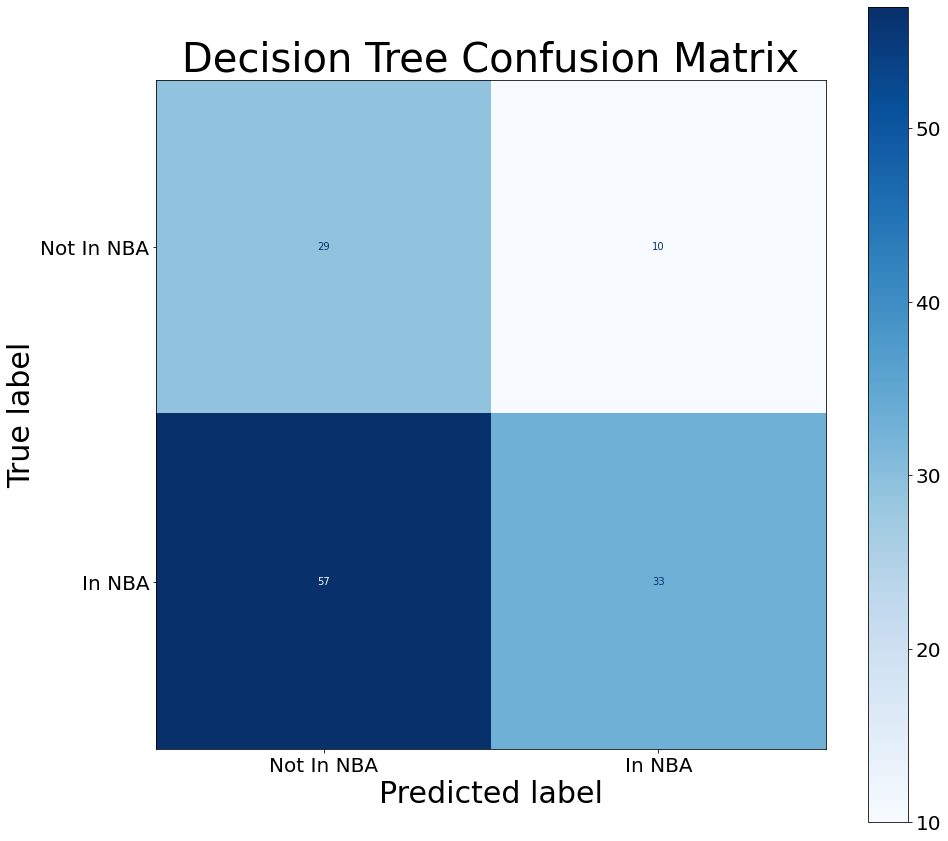

Decision Tree Accuracy Score: 0.4806201550387597
Decision Tree Accuracy Score on Test Data: 0.4691358024691358


In [10]:
# Separate based on the response variable 

X_train1_0 = pd.DataFrame(X_train1[y_train1 == 0])
X_train1_1 = pd.DataFrame(X_train1[y_train1 == 1])

# Upsample minority class (Which is 0s in this case)
X_train1_0_upsampled = pd.DataFrame.sample(X_train1_0, replace = True, n = len(X_train1_1),random_state = 11)

X_train1_0_upsampled['InTheLeague'] = 0
X_train1_1['InTheLeague'] = 1

X_train1_upsampled = pd.concat([X_train1_0_upsampled,X_train1_1])

y_train1_upsampled = pd.Series(X_train1_upsampled['InTheLeague'])

X_train1_upsampled = X_train1_upsampled.drop("InTheLeague",axis=1)

print(list(X_train1_upsampled.columns))

# Same protocol as before
_ = DecisionTree.fit(X_train1_upsampled,y_train1_upsampled)

plt.rcParams['figure.figsize'] = [15,15]
plot_tree(DecisionTree, feature_names = list(X_train1_upsampled.columns))
plt.title('Fig 5) Decision Tree with Upsampled Data')
plt.show()

ypreds2 = DecisionTree.predict(X_train2)

disp = ConfusionMatrixDisplay.from_estimator(
        DecisionTree,
        X_train2,
        y_train2,
        display_labels=["Not In NBA","In NBA"],
        cmap=plt.cm.Blues,
        normalize=None,
    )

# print(len(y_train2[y_train2==1])) -- 1 means in league, so label the confusion matrix accordingly

plt.rcParams['figure.figsize'] = [5, 5]
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()


# Accuracy Score is suitable because we can say that a false positive and negative are 'equally bad'
print("Decision Tree Accuracy Score: " + str(DecisionTree.score(X_train2,y_train2)))
print("Decision Tree Accuracy Score on Test Data: " + str(DecisionTree.score(X_test,y_test)))



##### Prediction score with the upsampled dataset is awful with ~48.1% correct rate, so we will try to use an SVM which should perform well on high dimensional data. The model tends to predict that a player will not be in the league more often than not, which is the side of error we'd rather not have as the next portion of the project will project their price ceiling

0.5581395348837209


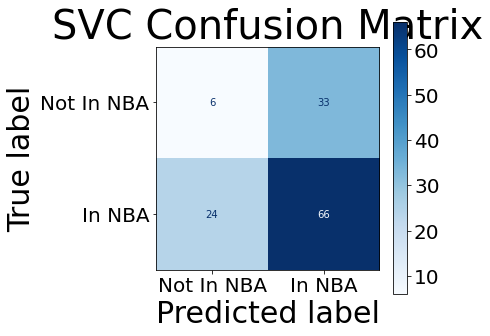

In [11]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Initialize Support Vector Classifier model
SVCModel = SVC(C=0.01, random_state=11)

# SVC requires a scaler so make a quick pipeline that scaler fits the data
SVCPredPipeline = make_pipeline(StandardScaler(), SVCModel)

# Fit model
SVCPredPipeline.fit(X_train1_upsampled,y_train1_upsampled)

# Generate predictions
ypredsSVC = SVCPredPipeline.predict(X_train2)


print(SVCPredPipeline.score(X_train2,y_train2))

# Display Heatmap
disp = ConfusionMatrixDisplay.from_estimator(
    SVCPredPipeline,
    X_train2,
    y_train2,
    display_labels=["Not In NBA","In NBA"],
    cmap=plt.cm.Blues,
    normalize=None,
)

plt.title('SVC Confusion Matrix')
plt.show()

0.6356589147286822


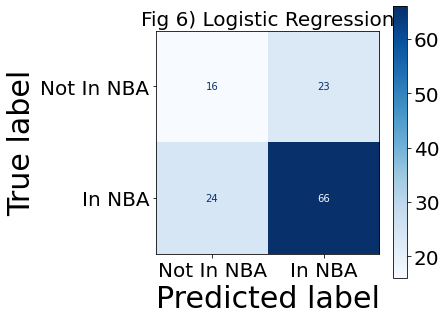

Logistic Regression Accuracy Score on Test Data (Best Model): 0.6358024691358025


In [12]:
# Logistic Regression Model

from sklearn.linear_model import LogisticRegression

# Create and fit new model w/ Logistic Regression
logisticModel = LogisticRegression(solver='liblinear', penalty="l2",max_iter=10000, random_state=11)
logisticModel.fit(X_train1_upsampled,y_train1_upsampled)

# Generate predictions for validation set
ypredsLogistic = logisticModel.predict(X_train2)


print(logisticModel.score(X_train2,y_train2))

# Display H
disp = ConfusionMatrixDisplay.from_estimator(
    logisticModel,
    X_train2,
    y_train2,
    display_labels=["Not In NBA","In NBA"],
    cmap=plt.cm.Blues,
    normalize=None,
)
plt.title('Fig 6) Logistic Regression',fontsize=20)
plt.show()

print("Logistic Regression Accuracy Score on Test Data (Best Model): " + str(logisticModel.score(X_test,y_test)))




---
Bagging with 20 estimators
0.9959568733153639
0.5968992248062015


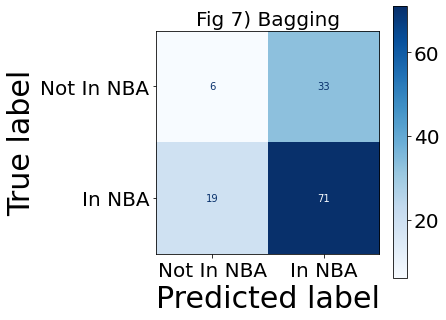

Bagging Accuracy Score on Test Data (Best Model): 0.5968992248062015
Bagging Accuracy Score on Test Data (Best Model): 0.6234567901234568
---
Bagging with 30 estimators
0.9973045822102425
0.6046511627906976


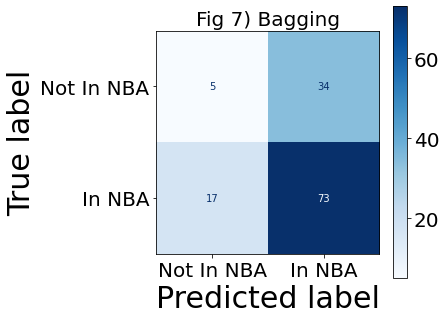

Bagging Accuracy Score on Test Data (Best Model): 0.6046511627906976
Bagging Accuracy Score on Test Data (Best Model): 0.6296296296296297
---
Bagging with 40 estimators
1.0
0.6046511627906976


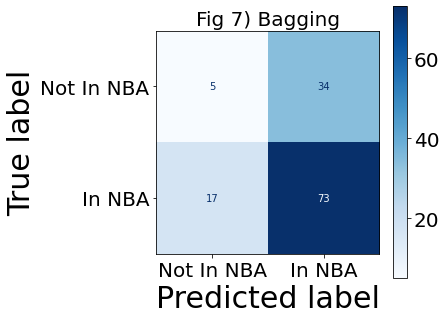

Bagging Accuracy Score on Test Data (Best Model): 0.6046511627906976
Bagging Accuracy Score on Test Data (Best Model): 0.6234567901234568
---
Bagging with 50 estimators
1.0
0.5813953488372093


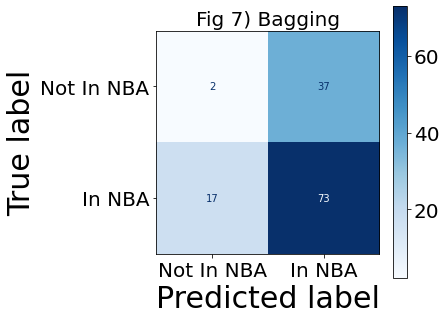

Bagging Accuracy Score on Test Data (Best Model): 0.5813953488372093
Bagging Accuracy Score on Test Data (Best Model): 0.6358024691358025
---
Bagging with 70 estimators
1.0
0.6046511627906976


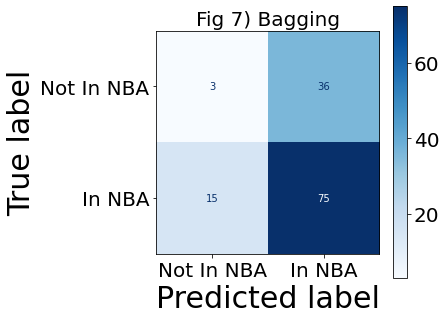

Bagging Accuracy Score on Test Data (Best Model): 0.6046511627906976
Bagging Accuracy Score on Test Data (Best Model): 0.6172839506172839
---
Bagging with 100 estimators
1.0
0.627906976744186


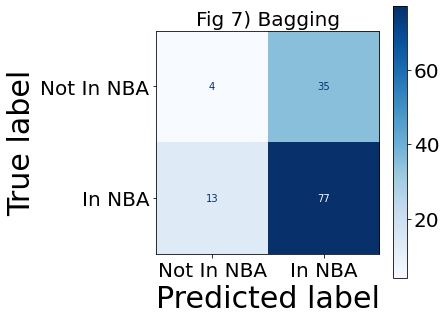

Bagging Accuracy Score on Test Data (Best Model): 0.627906976744186
Bagging Accuracy Score on Test Data (Best Model): 0.6358024691358025
---
Bagging with 150 estimators
1.0
0.6201550387596899


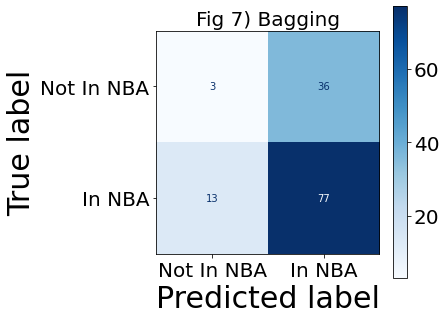

Bagging Accuracy Score on Test Data (Best Model): 0.6201550387596899
Bagging Accuracy Score on Test Data (Best Model): 0.654320987654321
---
Bagging with 200 estimators
1.0
0.6434108527131783


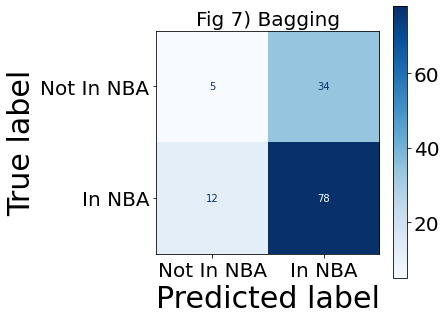

Bagging Accuracy Score on Test Data (Best Model): 0.6434108527131783
Bagging Accuracy Score on Test Data (Best Model): 0.6604938271604939
---
Bagging with 400 estimators
1.0
0.6511627906976745


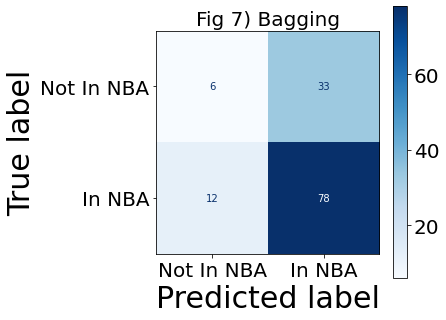

Bagging Accuracy Score on Test Data (Best Model): 0.6511627906976745
Bagging Accuracy Score on Test Data (Best Model): 0.654320987654321
---
Bagging with 600 estimators
1.0
0.6666666666666666


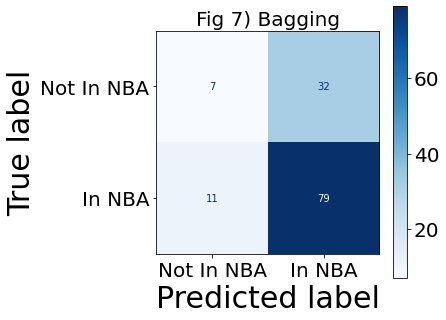

Bagging Accuracy Score on Test Data (Best Model): 0.6666666666666666
Bagging Accuracy Score on Test Data (Best Model): 0.6481481481481481
---
Bagging with 800 estimators
1.0
0.6589147286821705


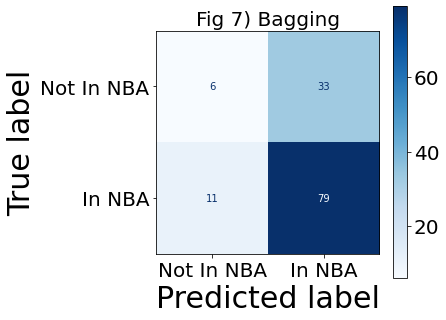

Bagging Accuracy Score on Test Data (Best Model): 0.6589147286821705
Bagging Accuracy Score on Test Data (Best Model): 0.654320987654321


In [13]:
from sklearn.ensemble import BaggingClassifier

# Create and fit new bagging model and test a bunch of different # of estimators parameters
for n_est in [20,30,40,50,70,100,150,200,400,600,800]:
    print('---')
    print('Bagging with '+str(n_est)+' estimators')
    baggingModel = BaggingClassifier(n_estimators=n_est, random_state=11)
    baggingModel.fit(X_train1_upsampled,y_train1_upsampled)

    # Generate predictions for validation set
    ypredsBagging = baggingModel.predict(X_train2)

    # Show Train Score
    print(baggingModel.score(X_train1_upsampled,y_train1_upsampled))


    # Show Confusion Matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        baggingModel,
        X_train2,
        y_train2,
        display_labels=["Not In NBA","In NBA"],
        cmap=plt.cm.Blues,
        normalize=None,
    )
    plt.title('Fig 7) Bagging',fontsize=20)
    plt.show()
    
    
    # Show Validation and Test Scores
    print("Bagging Accuracy Score on Test Data (Best Model): " + str(baggingModel.score(X_train2,y_train2)))
    print("Bagging Accuracy Score on Test Data (Best Model): " + str(baggingModel.score(X_test,y_test)))
    
    # Best model has 66% accuracy on Validation and Test data

---
Boosting with 20 estimators and learning rate of 0.01
0.7264150943396226
0.5271317829457365


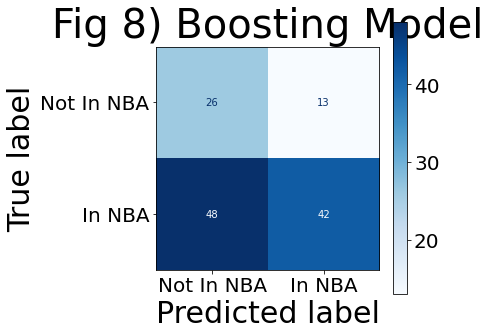

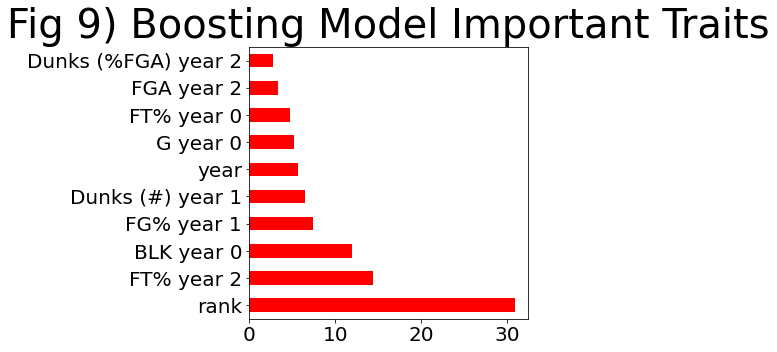

Boosting Accuracy Score on Validation Data (Best Model): 0.5271317829457365
Boosting Accuracy Score on Test Data (Best Model): 0.4876543209876543
---
Boosting with 20 estimators and learning rate of 0.1
0.9029649595687331
0.5813953488372093


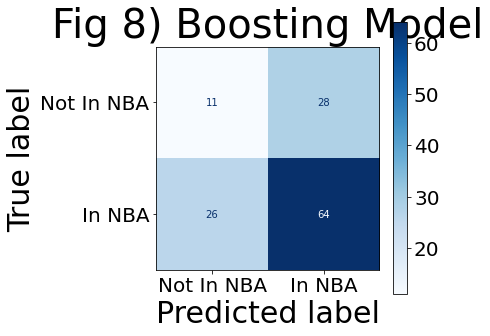

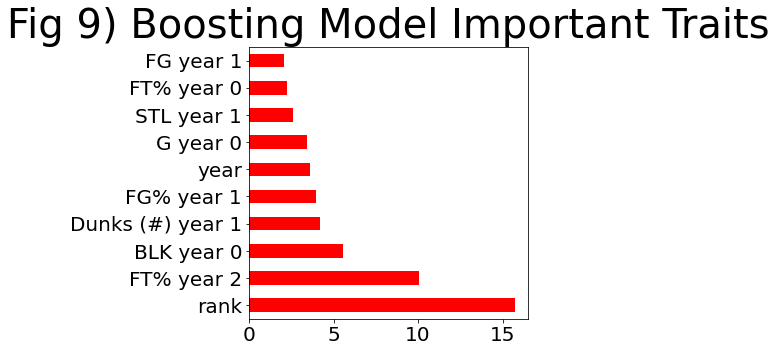

Boosting Accuracy Score on Validation Data (Best Model): 0.5813953488372093
Boosting Accuracy Score on Test Data (Best Model): 0.6172839506172839
---
Boosting with 20 estimators and learning rate of 1
0.9905660377358491
0.6356589147286822


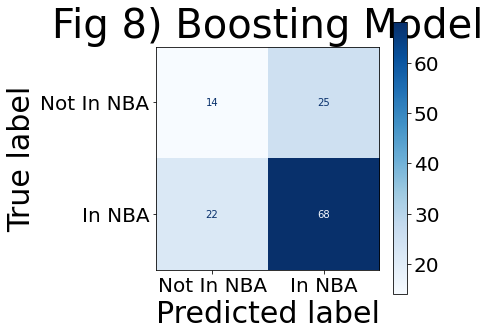

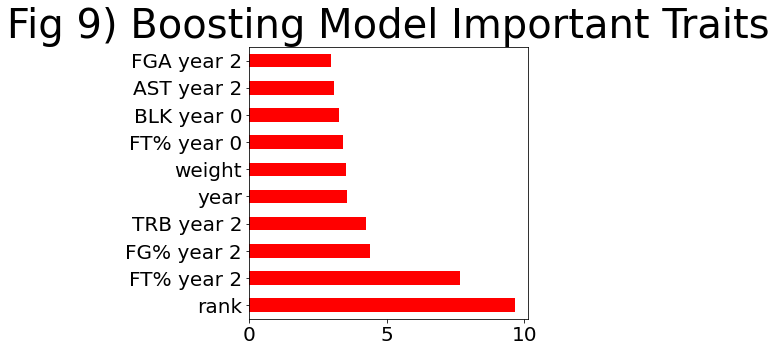

Boosting Accuracy Score on Validation Data (Best Model): 0.6356589147286822
Boosting Accuracy Score on Test Data (Best Model): 0.6172839506172839
---
Boosting with 20 estimators and learning rate of 10
0.3894878706199461
0.5348837209302325


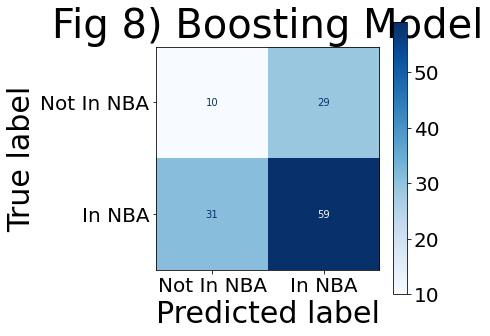

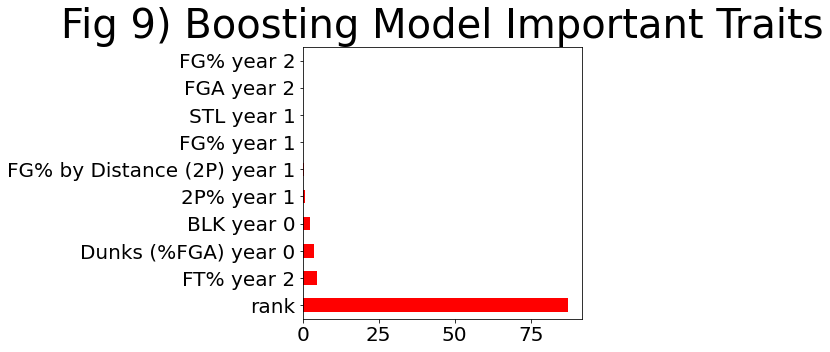

Boosting Accuracy Score on Validation Data (Best Model): 0.5348837209302325
Boosting Accuracy Score on Test Data (Best Model): 0.49382716049382713
---
Boosting with 50 estimators and learning rate of 0.01
0.7560646900269542
0.5581395348837209


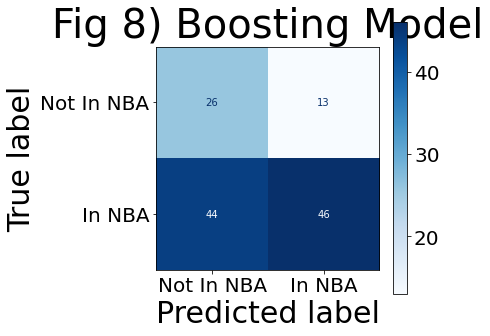

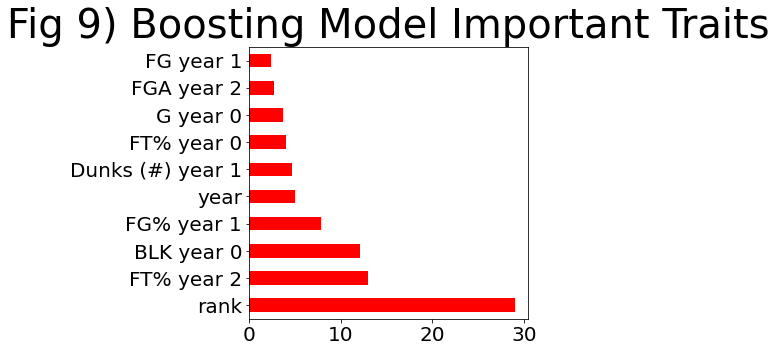

Boosting Accuracy Score on Validation Data (Best Model): 0.5581395348837209
Boosting Accuracy Score on Test Data (Best Model): 0.5185185185185185
---
Boosting with 50 estimators and learning rate of 0.1
0.9609164420485176
0.627906976744186


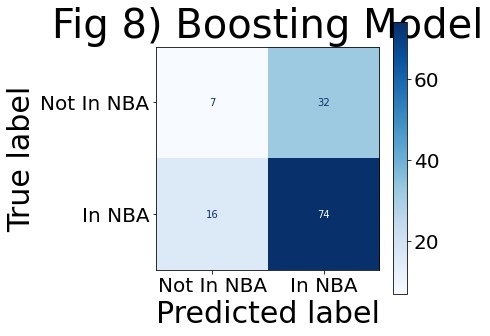

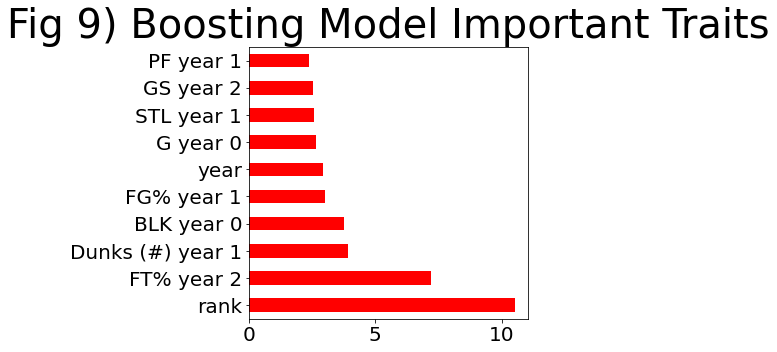

Boosting Accuracy Score on Validation Data (Best Model): 0.627906976744186
Boosting Accuracy Score on Test Data (Best Model): 0.6728395061728395
---
Boosting with 50 estimators and learning rate of 1
1.0
0.6046511627906976


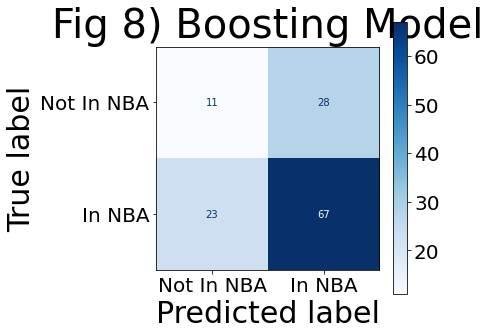

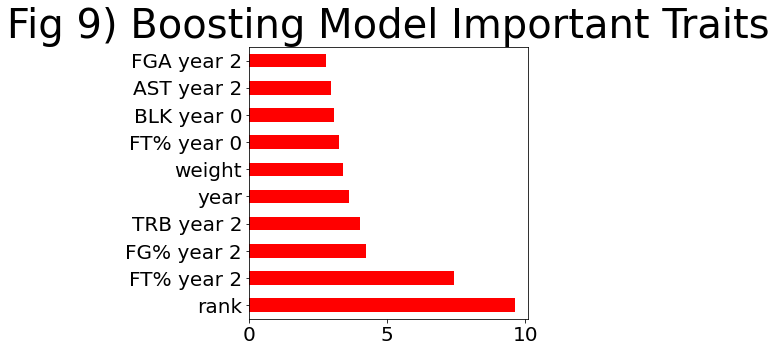

Boosting Accuracy Score on Validation Data (Best Model): 0.6046511627906976
Boosting Accuracy Score on Test Data (Best Model): 0.6111111111111112
---
Boosting with 50 estimators and learning rate of 10
0.3894878706199461
0.5348837209302325


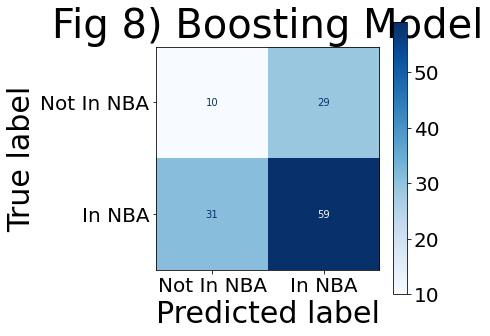

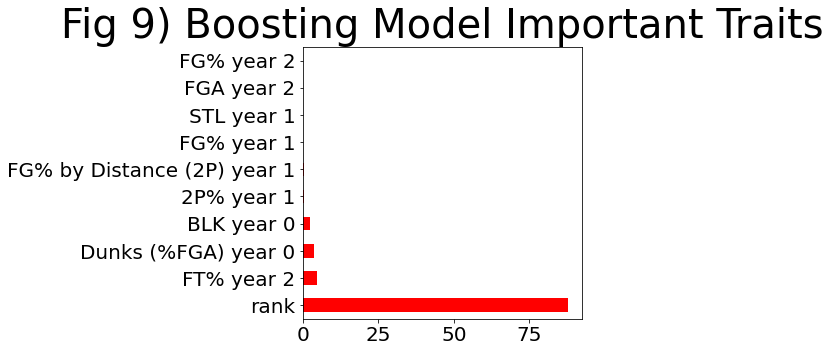

Boosting Accuracy Score on Validation Data (Best Model): 0.5348837209302325
Boosting Accuracy Score on Test Data (Best Model): 0.49382716049382713
---
Boosting with 100 estimators and learning rate of 0.01
0.8032345013477089
0.6046511627906976


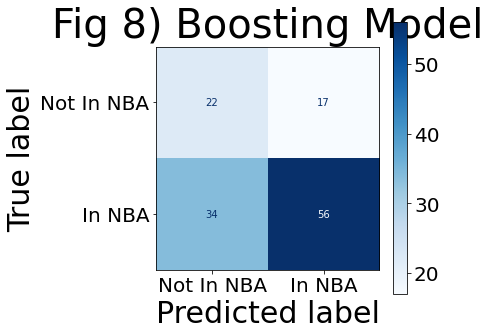

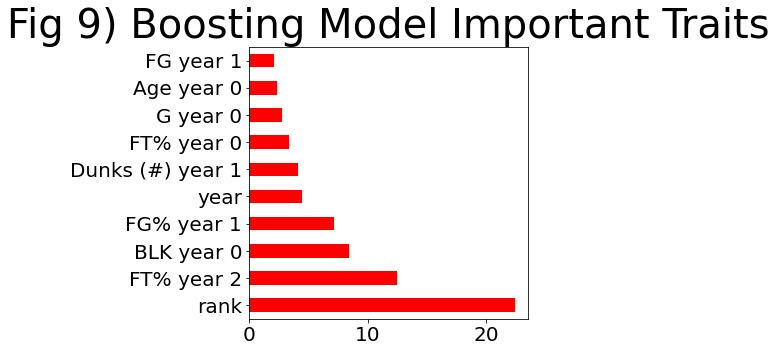

Boosting Accuracy Score on Validation Data (Best Model): 0.6046511627906976
Boosting Accuracy Score on Test Data (Best Model): 0.5123456790123457
---
Boosting with 100 estimators and learning rate of 0.1
0.9892183288409704
0.6356589147286822


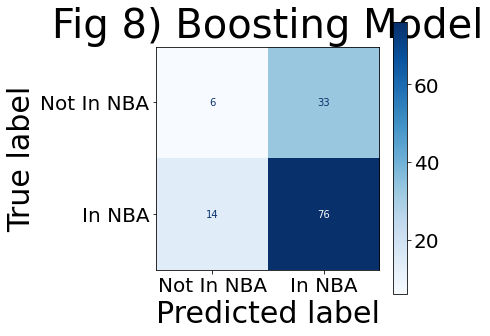

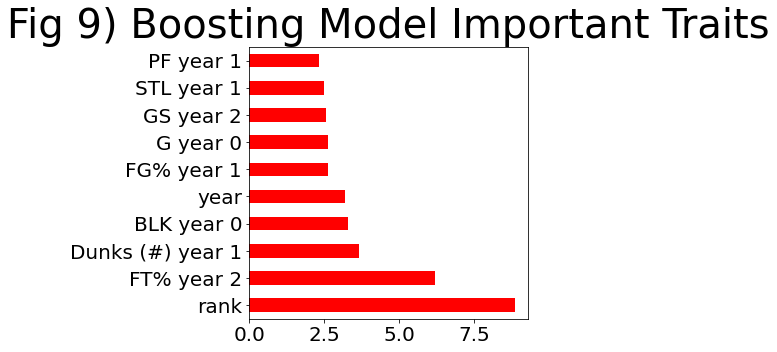

Boosting Accuracy Score on Validation Data (Best Model): 0.6356589147286822
Boosting Accuracy Score on Test Data (Best Model): 0.6419753086419753
---
Boosting with 100 estimators and learning rate of 1
1.0
0.6356589147286822


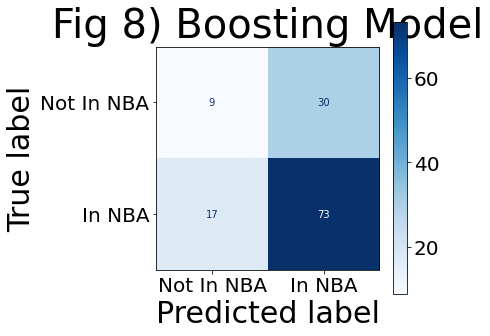

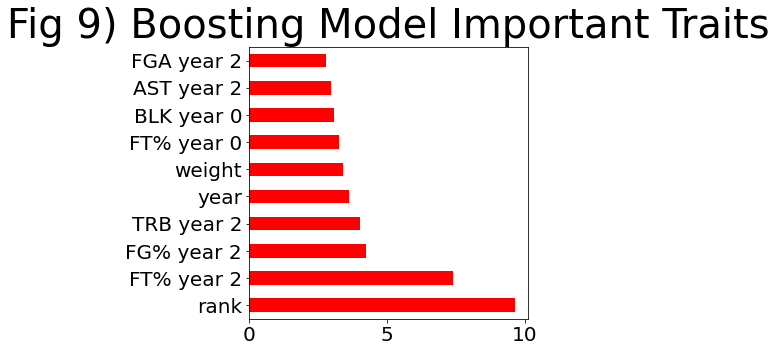

Boosting Accuracy Score on Validation Data (Best Model): 0.6356589147286822
Boosting Accuracy Score on Test Data (Best Model): 0.6358024691358025
---
Boosting with 100 estimators and learning rate of 10
0.3894878706199461
0.5348837209302325


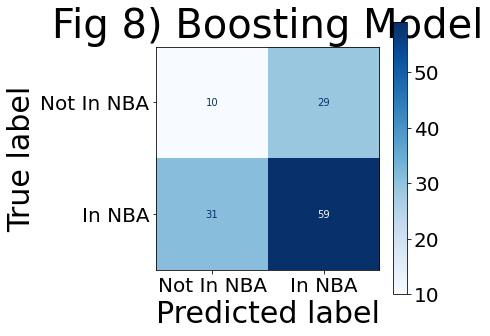

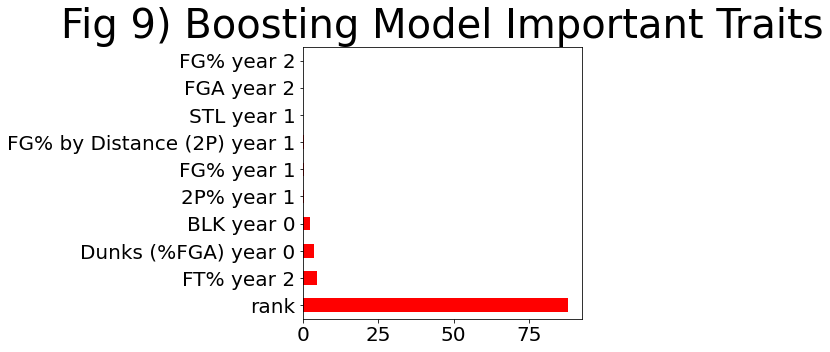

Boosting Accuracy Score on Validation Data (Best Model): 0.5348837209302325
Boosting Accuracy Score on Test Data (Best Model): 0.49382716049382713
---
Boosting with 200 estimators and learning rate of 0.01
0.9043126684636119
0.6201550387596899


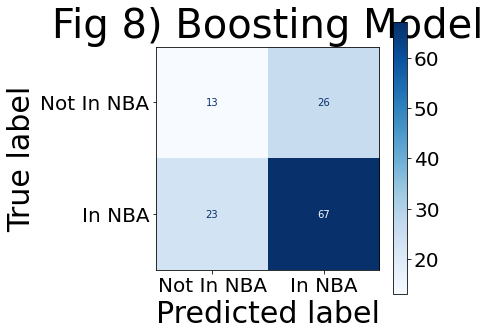

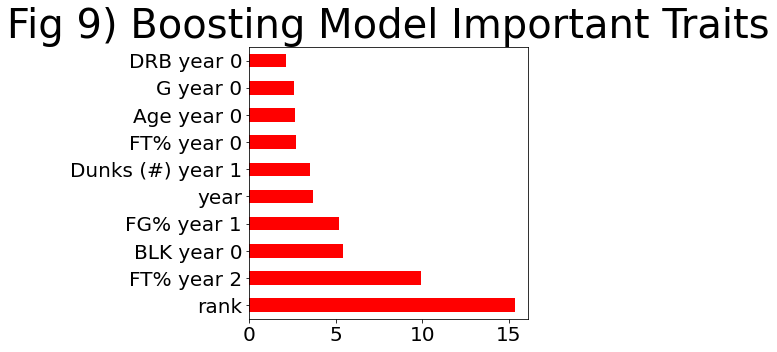

Boosting Accuracy Score on Validation Data (Best Model): 0.6201550387596899
Boosting Accuracy Score on Test Data (Best Model): 0.5740740740740741
---
Boosting with 200 estimators and learning rate of 0.1
0.9986522911051213
0.5968992248062015


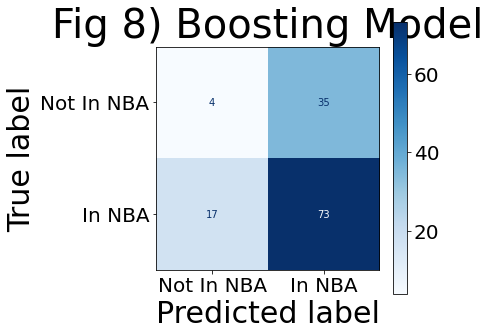

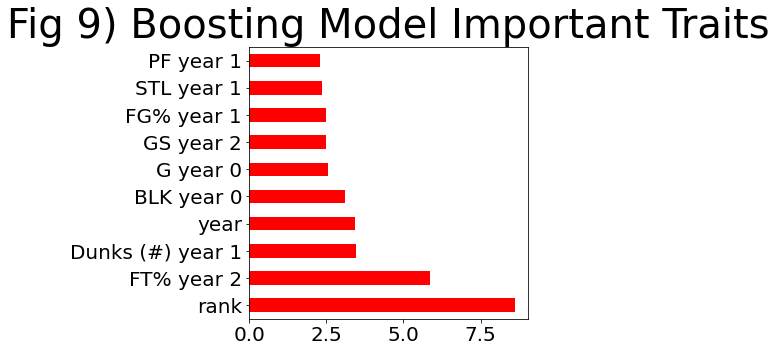

Boosting Accuracy Score on Validation Data (Best Model): 0.5968992248062015
Boosting Accuracy Score on Test Data (Best Model): 0.6666666666666666
---
Boosting with 200 estimators and learning rate of 1
1.0
0.6589147286821705


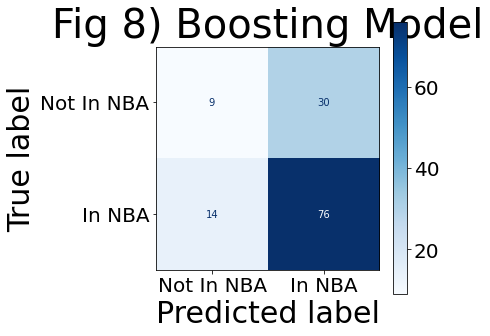

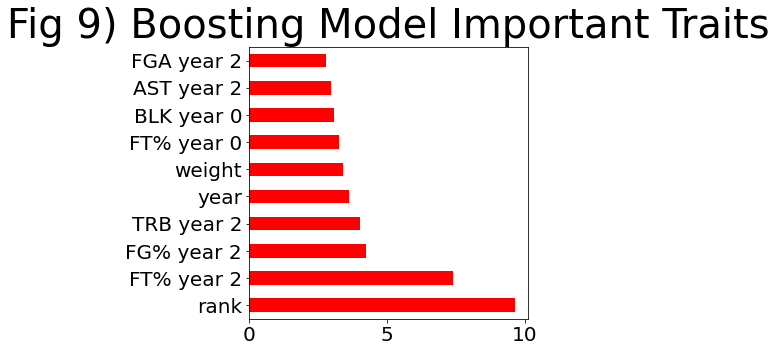

Boosting Accuracy Score on Validation Data (Best Model): 0.6589147286821705
Boosting Accuracy Score on Test Data (Best Model): 0.6728395061728395
---
Boosting with 200 estimators and learning rate of 10
0.3894878706199461
0.5348837209302325


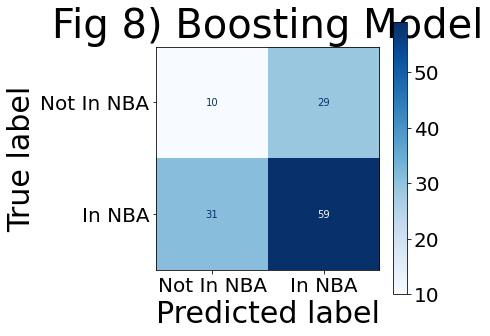

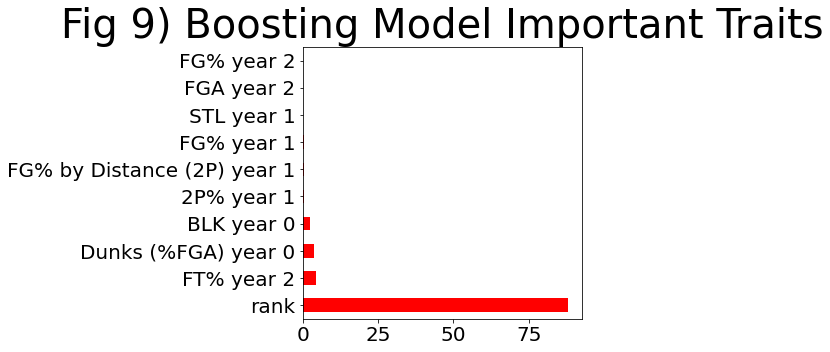

Boosting Accuracy Score on Validation Data (Best Model): 0.5348837209302325
Boosting Accuracy Score on Test Data (Best Model): 0.49382716049382713
---
Boosting with 400 estimators and learning rate of 0.01
0.9528301886792453
0.6124031007751938


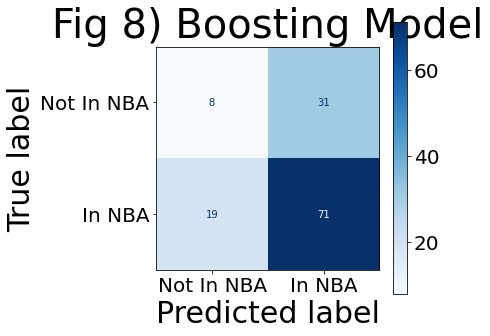

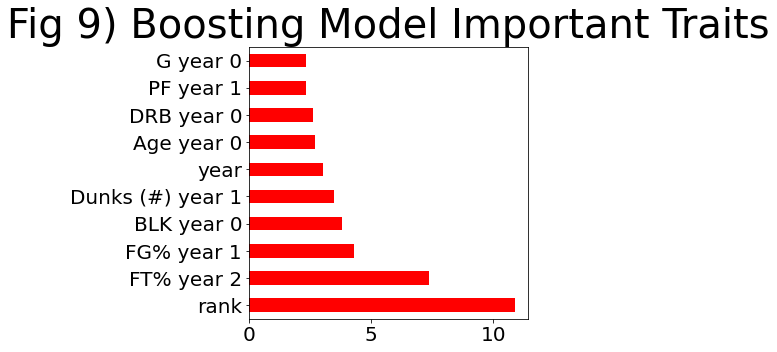

Boosting Accuracy Score on Validation Data (Best Model): 0.6124031007751938
Boosting Accuracy Score on Test Data (Best Model): 0.654320987654321
---
Boosting with 400 estimators and learning rate of 0.1
1.0
0.627906976744186


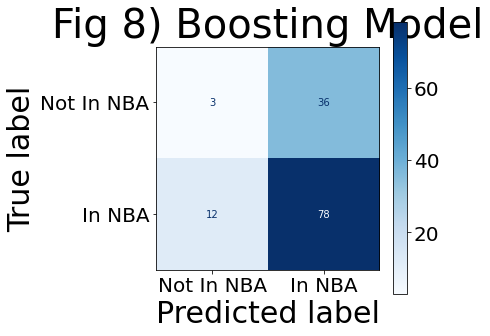

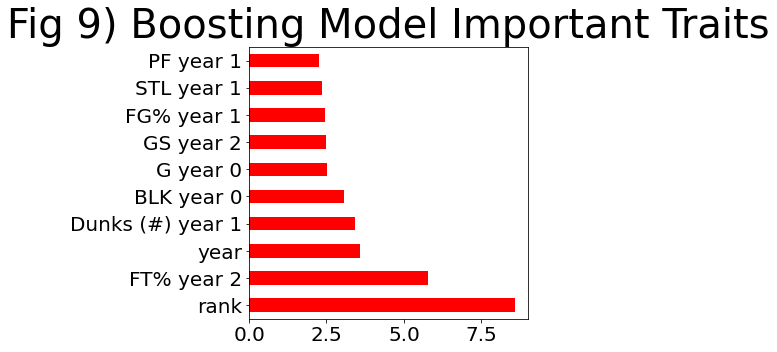

Boosting Accuracy Score on Validation Data (Best Model): 0.627906976744186
Boosting Accuracy Score on Test Data (Best Model): 0.6666666666666666
---
Boosting with 400 estimators and learning rate of 1
1.0
0.6511627906976745


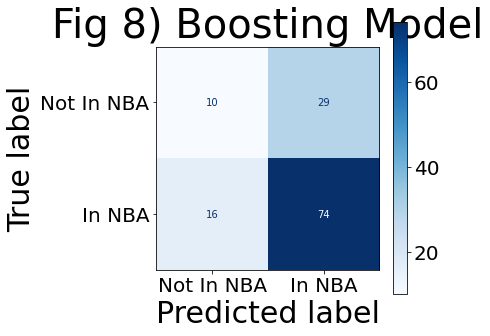

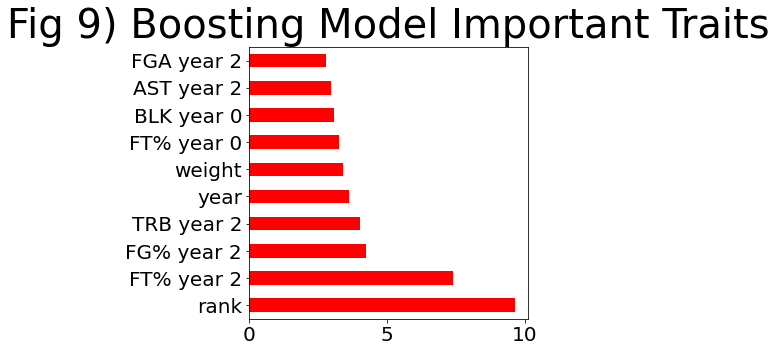

Boosting Accuracy Score on Validation Data (Best Model): 0.6511627906976745
Boosting Accuracy Score on Test Data (Best Model): 0.6790123456790124
---
Boosting with 400 estimators and learning rate of 10
0.3894878706199461
0.5348837209302325


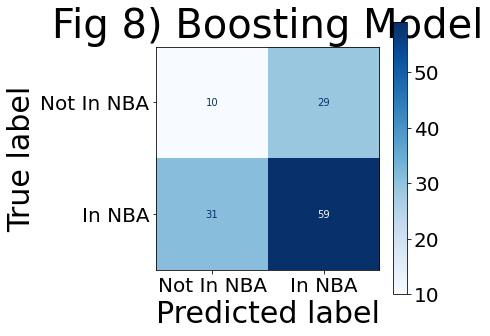

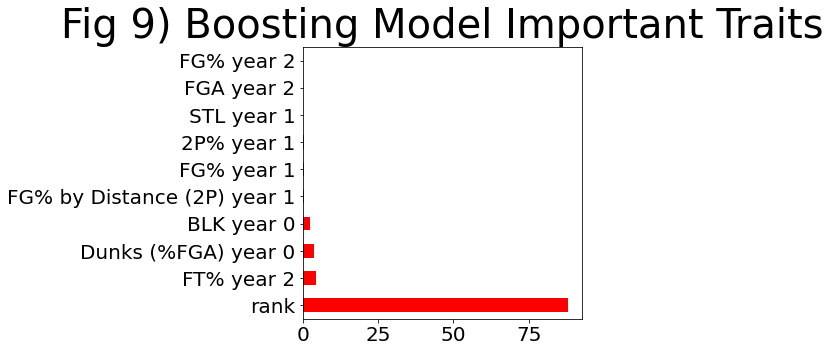

Boosting Accuracy Score on Validation Data (Best Model): 0.5348837209302325
Boosting Accuracy Score on Test Data (Best Model): 0.49382716049382713
---
Boosting with 800 estimators and learning rate of 0.01
0.9838274932614556
0.6124031007751938


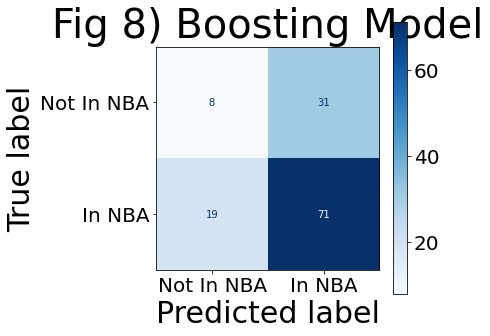

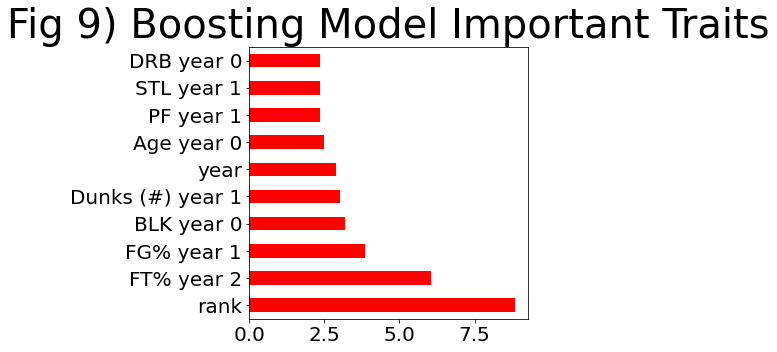

Boosting Accuracy Score on Validation Data (Best Model): 0.6124031007751938
Boosting Accuracy Score on Test Data (Best Model): 0.6604938271604939
---
Boosting with 800 estimators and learning rate of 0.1
1.0
0.6356589147286822


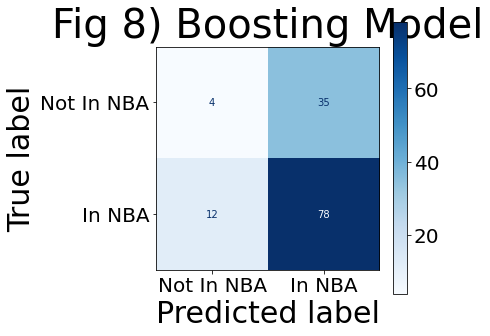

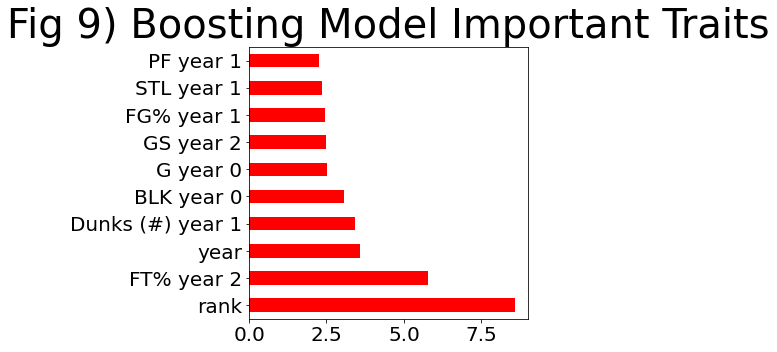

Boosting Accuracy Score on Validation Data (Best Model): 0.6356589147286822
Boosting Accuracy Score on Test Data (Best Model): 0.6666666666666666
---
Boosting with 800 estimators and learning rate of 1
1.0
0.6511627906976745


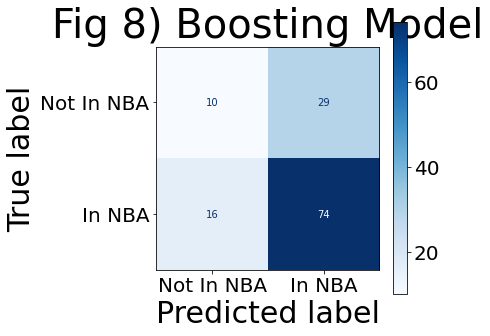

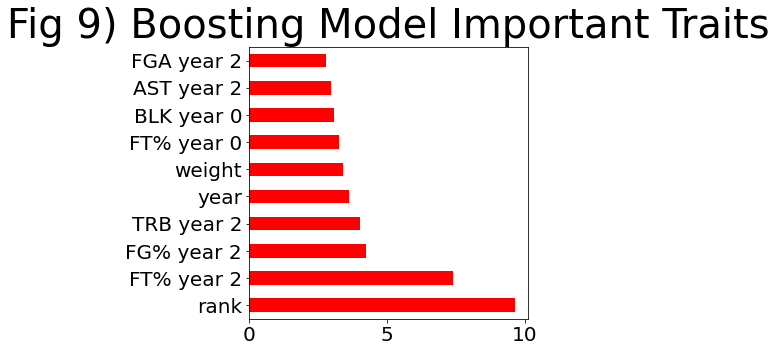

Boosting Accuracy Score on Validation Data (Best Model): 0.6511627906976745
Boosting Accuracy Score on Test Data (Best Model): 0.6790123456790124
---
Boosting with 800 estimators and learning rate of 10
0.3894878706199461
0.5348837209302325


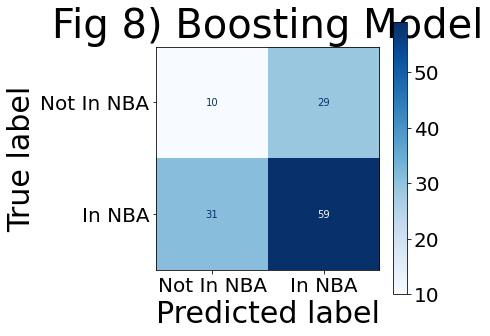

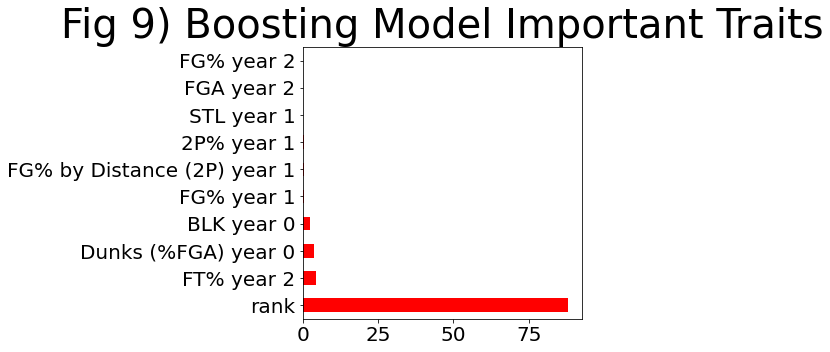

Boosting Accuracy Score on Validation Data (Best Model): 0.5348837209302325
Boosting Accuracy Score on Test Data (Best Model): 0.49382716049382713


In [14]:
from sklearn.ensemble import GradientBoostingClassifier

# Create and fit new model on a bunch of hyperparameters for Boosting
for n_est in [20,50,100,200,400,800]:
    for learn in [0.01,0.1,1,10]:
        print('---')
        print('Boosting with '+str(n_est)+' estimators and learning rate of '+str(learn))
        boostingModel = GradientBoostingClassifier(n_estimators=n_est, random_state=11,learning_rate=learn)
        boostingModel.fit(X_train1_upsampled,y_train1_upsampled)

        # Generate predictions for validation set
        ypredsBoosting = boostingModel.predict(X_train2)

        print(boostingModel.score(X_train1_upsampled,y_train1_upsampled))

        print(boostingModel.score(X_train2,y_train2))

        disp = ConfusionMatrixDisplay.from_estimator(
            boostingModel,
            X_train2,
            y_train2,
            display_labels=["Not In NBA","In NBA"],
            cmap=plt.cm.Blues,
            normalize=None,
        )
        plt.title('Fig 8) Boosting Model')
        plt.show()
        
        importance = pd.Series(boostingModel.feature_importances_ * 100, index = X_train1_upsampled.columns)
        importance = importance.sort_values(axis=0, ascending = False)[:10]
        importance.plot(kind='barh', color='r')
        plt.title('Fig 9) Boosting Model Important Traits')
        plt.show()

        print("Boosting Accuracy Score on Validation Data (Best Model): " + str(boostingModel.score(X_train2,y_train2)))
        print("Boosting Accuracy Score on Test Data (Best Model): " + str(boostingModel.score(X_test,y_test)))
        
        # Best model has 66% validation and 68% test accuracy

##### Now that Logistic Regression performs at an above 63% level and the bagging tree with the upsampled training data performs at 66%, we can remove players we know won't be in the league and try to figure out what their 'price ceiling' should be for contract negotiations. Optimized boosting models also perform ~68% accuracy score. 

##### The tendency to overpredict in the league is also beneficial as it allows our regression model to further discriminate, whereas a dropped player will be dropped forever, potentially missing out on a hidden gem

year  rank  height  weight  Age year 0  G year 0  G year 1  G year 2  \
0     1     1   183.0    74.0          21        76        80        48   
1     1     2   211.0    99.0          22        63        63        46   
2     1     3   188.0    81.0          19        67        82        49   
3     1     4   196.0    92.0          21        82        82        50   
4     1     5   206.0   101.0          20        82        82        42   

   MP year 0  MP year 1  ...  ORtg year 2  DRtg year 0  DRtg year 1  \
0       3045       3150  ...        105.0          112          106   
1       1897       2002  ...        108.0          105          107   
2       2324       3112  ...        108.0          111          111   
3       2532       3287  ...        110.0          110          108   
4       2970       3268  ...         96.0          111          104   

   DRtg year 2  Salary: age 26  Salary: age 27  Salary: age 28  \
0         99.0     $19,283,574     $20,987,903     $22,422,272   
1         93.0     $10,176,199     $12,512,897     $11,447,947   
2        107.0     $22,422,272     $23,522,504      $7,843,419   
3        106.0     $19,283,574     $20,987,903     $22,422,272   
4        101.0     $20,987,903     $22,422,272     $23,522,504   

   Salary: age 29   AAV_InPrime  InTheLeague  
0     $23,522,504  2.155406e+07            1  
1     $12,041,590  1.154466e+07            1  
2      $8,120,200  1.547710e+07            1  
3     $23,522,504  2.155406e+07            1  
4     $20,742,925  2.191890e+07            1  

[5 rows x 104 columns]

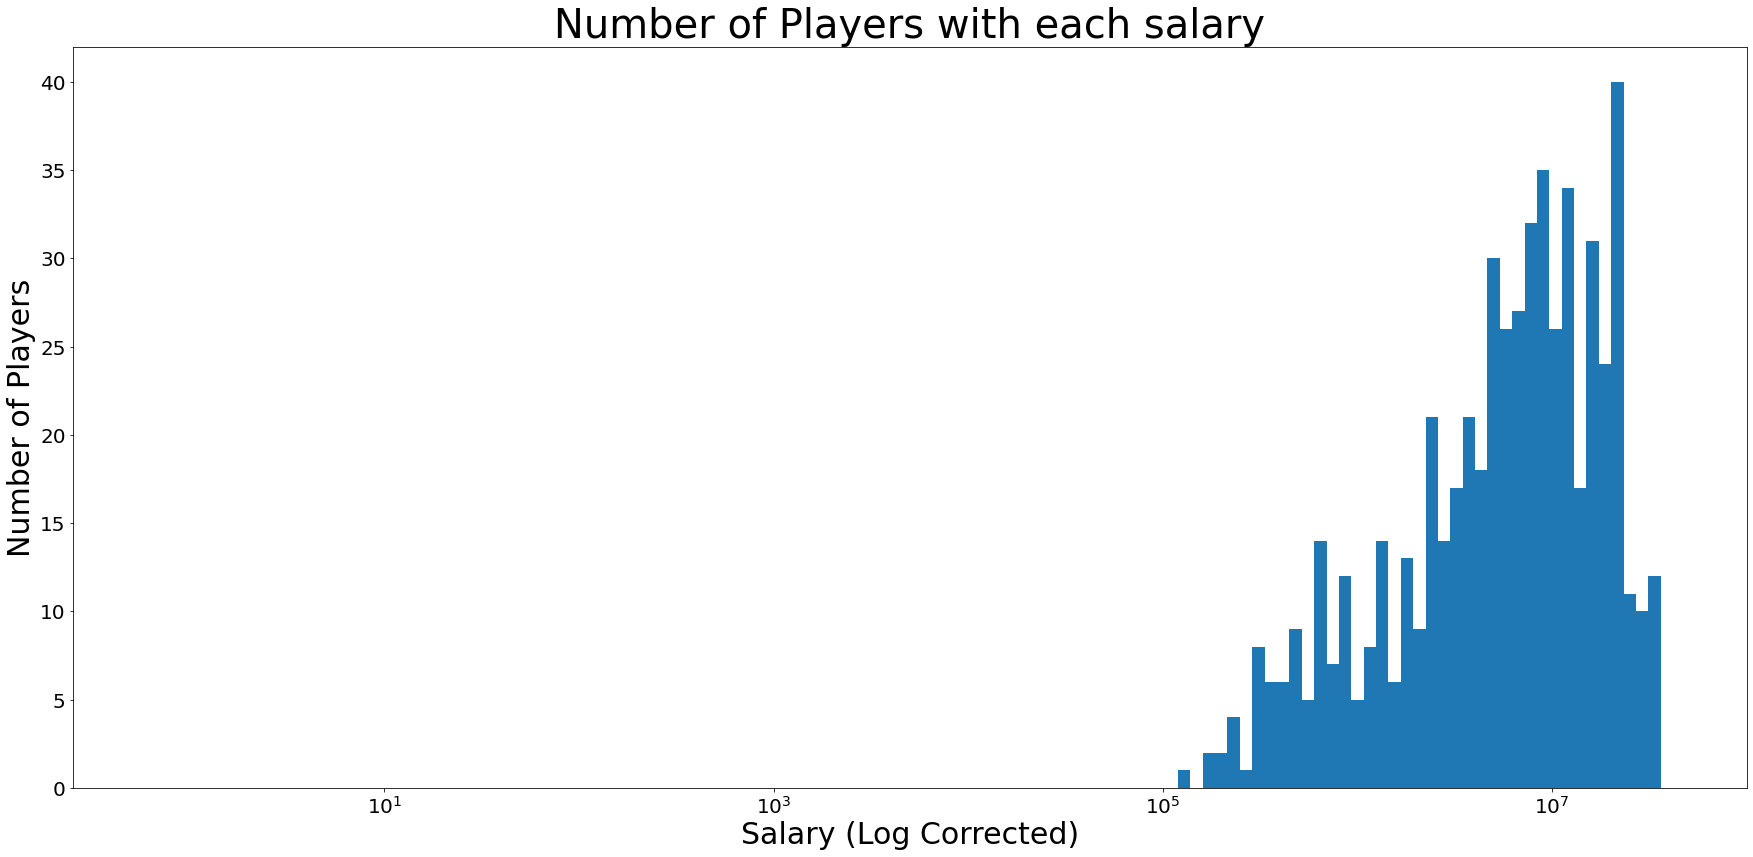

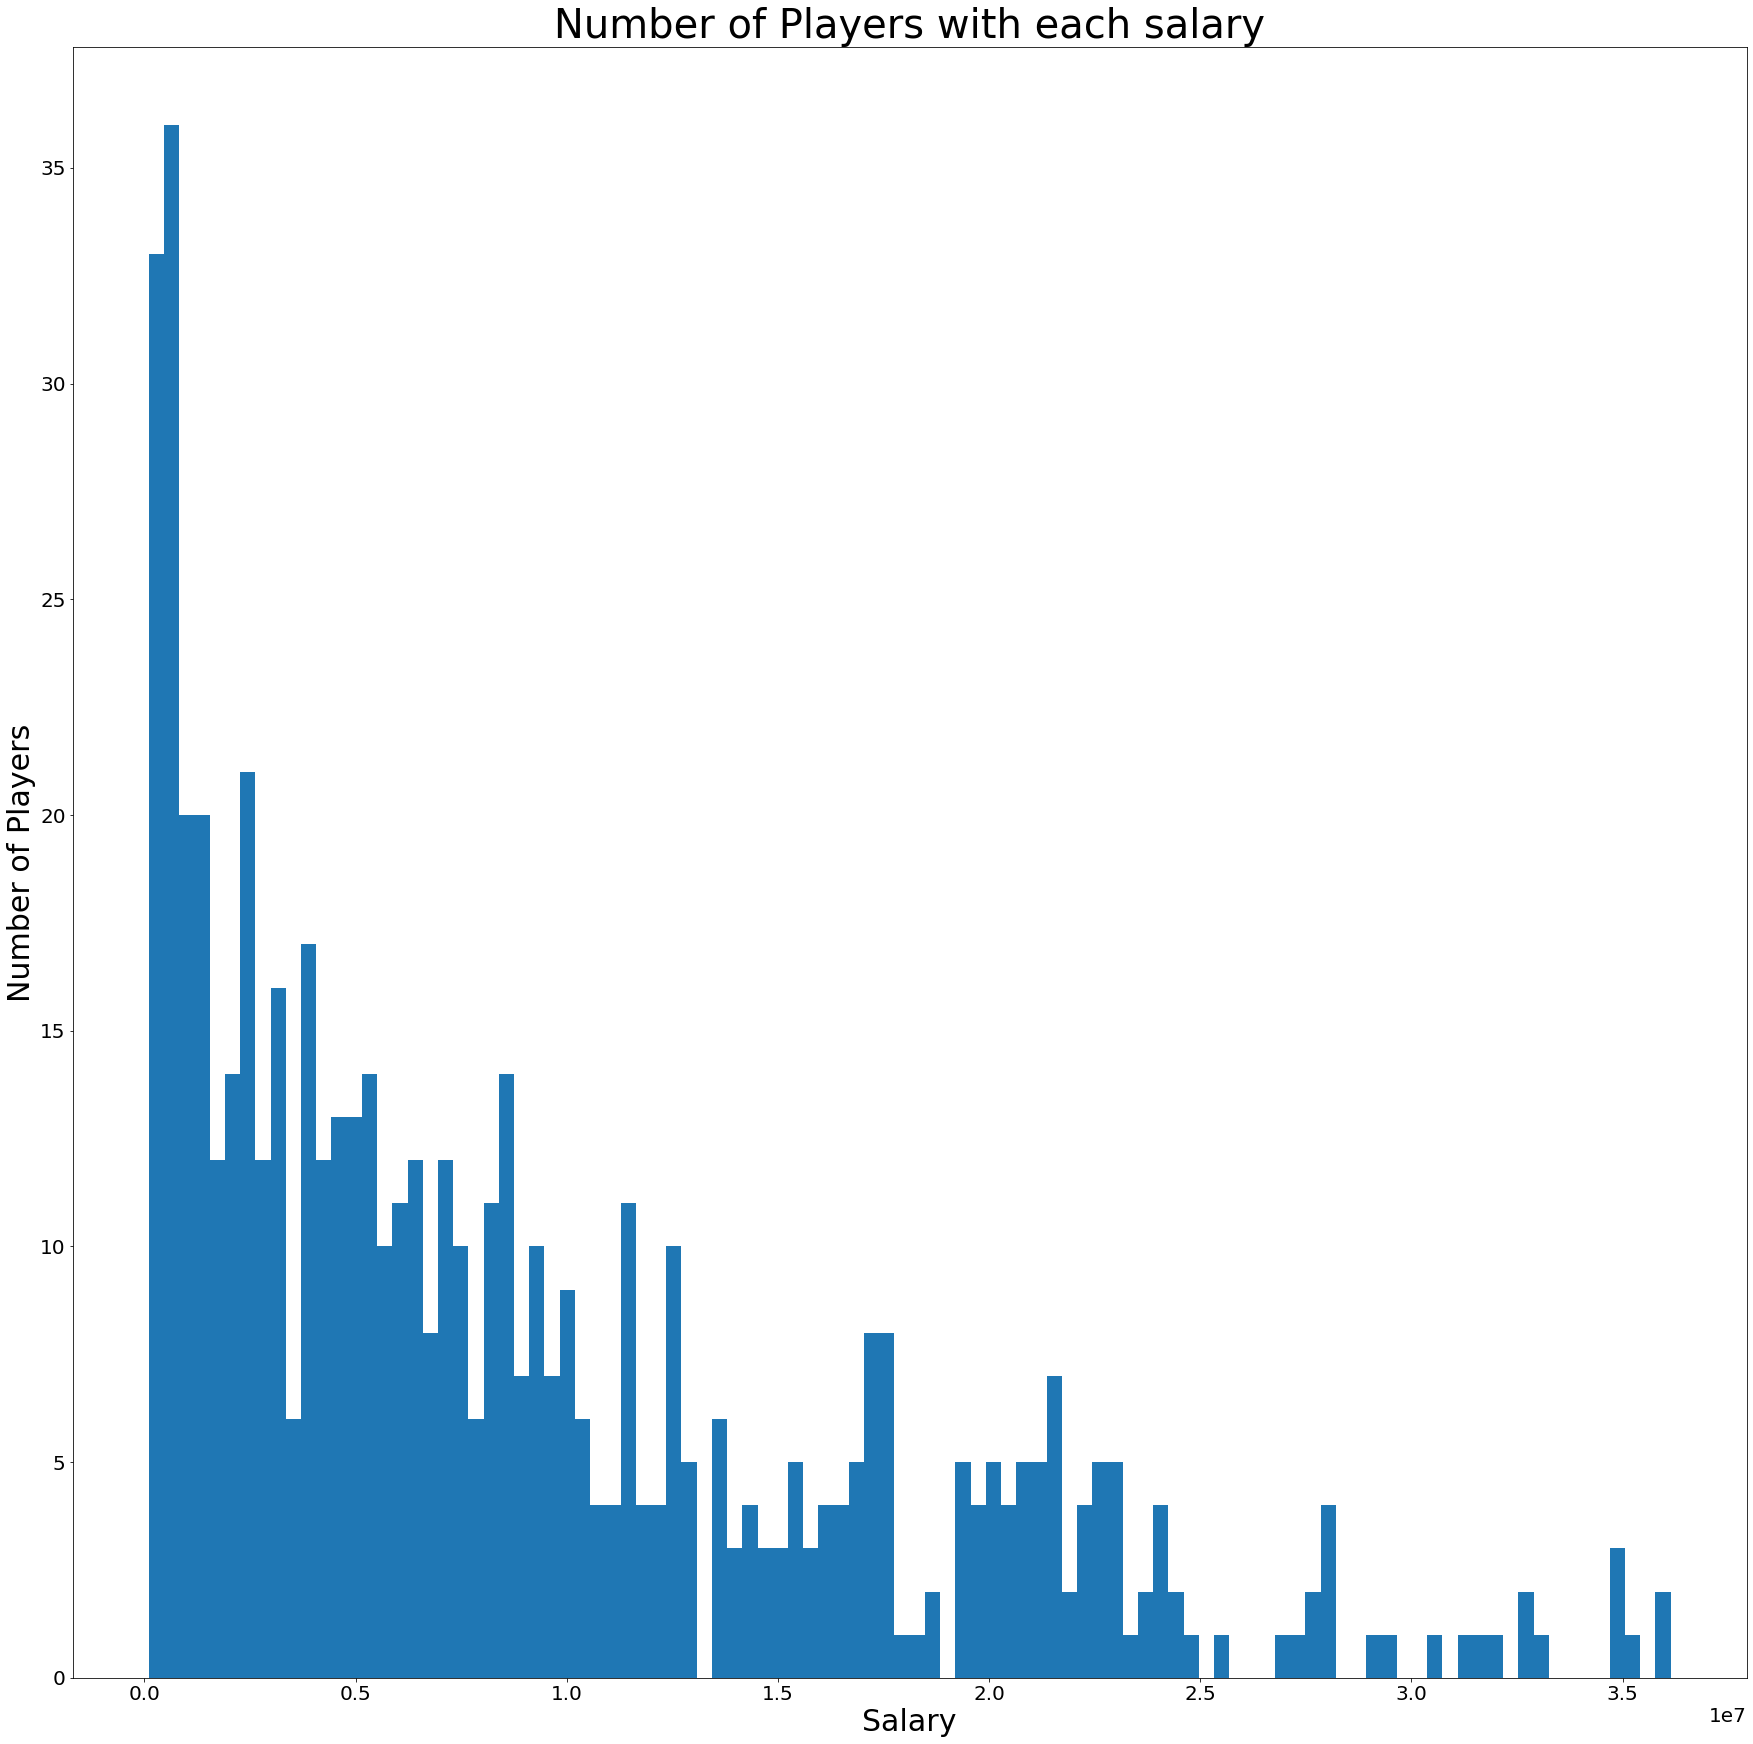

In [15]:
# Of the people in the league, we will run regressions to see if we can predict their theoretical price ceiling
NBADataStillInLeague = NBAData2[NBAData2['InTheLeague']==1]

# Increase Figure Size for Histograms
plt.rcParams['figure.figsize'] = [30,30]

# All players are in the league so it is a redundant column
NBADataStillInLeague.drop('InTheLeague',axis=1)

display(NBADataStillInLeague.head())

# Plot salary distribution of players still in the league (SHould be the same w/ out the 0 cluster)
hist, bins, _ = plt.hist(NBADataStillInLeague['AAV_InPrime'], bins=40)

logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(NBADataStillInLeague['AAV_InPrime'], bins=logbins)
plt.xlim([0.25, 10**8])
plt.xscale('log')
plt.xlabel("Salary (Log Corrected)")
plt.ylabel("Number of Players")
plt.title("Number of Players with each salary")
plt.show()

plt.hist(NBADataStillInLeague['AAV_InPrime'], bins=100)
plt.xlabel("Salary")
plt.ylabel("Number of Players")
plt.title("Number of Players with each salary")
plt.show()

##### First we will try a simple linear regression with statsmodel to look at variable importance

In [16]:
xcols = list(NBADataStillInLeague.columns)[:-6]

# IL = In League
X_trainIL, X_testIL, y_trainIL, y_testIL = train_test_split(NBADataStillInLeague[xcols],NBADataStillInLeague['AAV_InPrime'], test_size=0.15, random_state=11)

# Train = 68%, Validation = 17%, Test = 15%
X_train1IL = X_trainIL[:int(len(X_trainIL)*0.8)] # Train set x
X_train2IL = X_trainIL[int(len(X_trainIL)*0.8):] # Validation set x
y_train1IL = y_trainIL[:int(len(y_trainIL)*0.8)] # Train set y
y_train2IL = y_trainIL[int(len(y_trainIL)*0.8):] # Validation Set y

# Prelim statistical analysis for the regression problem
linModel = sm.regression.linear_model.OLS(y_train1IL,X_train1IL.astype(float))
regr = linModel.fit()
regressionSummary = regr.summary()
display(regressionSummary)

ypredsIL = regr.predict(X_train2IL)

print("Linear Model RMSE Score: "+str(mean_squared_error(ypredsIL, y_train2IL)**(1/2)))



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            AAV_InPrime   R-squared (uncentered):                   0.734
Model:                            OLS   Adj. R-squared (uncentered):              0.648
Method:                 Least Squares   F-statistic:                              8.546
Date:                Sun, 03 Mar 2024   Prob (F-statistic):                    8.74e-47
Time:                        20:03:21   Log-Likelihood:                         -6692.2
No. Observations:                 393   AIC:                                  1.358e+04
Df Residuals:                     297   BIC:                                  1.396e+04
Df Model:                          96                                                  
Covariance Type:            nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
year                             -4397.7309   1.04e+05     -0.042      0.966   -2.09e+05       2e+05
rank                             -1.482e+05   2.73e+04     -5.427      0.000   -2.02e+05   -9.45e+04
height                            4.973e+04   9.04e+04      0.550      0.583   -1.28e+05    2.28e+05
weight                           -2.343e+04    6.3e+04     -0.372      0.710   -1.47e+05    1.01e+05
Age year 0                       -1.161e+06   2.67e+05     -4.346      0.000   -1.69e+06   -6.35e+05
G year 0                         -4.037e+04   4.14e+04     -0.975      0.330   -1.22e+05    4.11e+04
G year 1                          2.806e+04   4.71e+04      0.595      0.552   -6.47e+04    1.21e+05
G year 2                          5.582e+04   4.52e+04      1.236      0.218   -3.31e+04    1.45e+05
MP year 0                         3335.5989   1980.344      1.684      0.093    -561.685    7232.882
MP year 1                         -804.9610   2052.750     -0.392      0.695   -4844.739    3234.817
MP year 2                        -2173.5485   1943.704     -1.118      0.264   -5998.726    1651.629
FG% year 0                        5.543e+06   3.78e+07      0.147      0.883   -6.88e+07    7.99e+07
FG% year 1                       -1.008e+08   5.26e+07     -1.915      0.056   -2.04e+08    2.77e+06
FG% year 2                        1.129e+07   3.62e+07      0.312      0.755      -6e+07    8.25e+07
Dist. year 0                      2.063e+05   3.59e+05      0.574      0.566   -5.01e+05    9.14e+05
Dist. year 1                      5.874e+05   4.12e+05      1.425      0.155   -2.24e+05     1.4e+06
Dist. year 2                     -3.571e+05   3.49e+05     -1.024      0.307   -1.04e+06    3.29e+05
% of FGA by Distance (2P) year 0  1.762e+07   1.53e+07      1.155      0.249   -1.24e+07    4.76e+07
% of FGA by Distance (2P) year 1  1.229e+07   1.79e+07      0.687      0.492   -2.29e+07    4.75e+07
% of FGA by Distance (2P) year 2 -3.837e+07   1.53e+07     -2.509      0.013   -6.85e+07   -8.27e+06
FG% by Distance (2P) year 0       8.163e+06   1.06e+07      0.769      0.442   -1.27e+07     2.9e+07
FG% by Distance (2P) year 1      -1.505e+08   1.63e+08     -0.925      0.356   -4.71e+08     1.7e+08
FG% by Distance (2P) year 2      -5.032e+08   4.86e+08     -1.036      0.301   -1.46e+09    4.52e+08
% of FG Ast'd (2P) year 0        -2.938e+06   4.09e+06     -0.718      0.473    -1.1e+07    5.11e+06
% of FG Ast'd (2P) year 1          6.53e+06   4.39e+06      1.489      0.138    -2.1e+06    1.52e+07
% of FG Ast'd (2P) year 2        -2.608e+06   4.69e+06     -0.556      0.579   -1.18e+07    6.62e+06
Dunks (%FGA) year 0                1.76e+07   1.28e+07 

Linear Model RMSE Score: 8107379.253836744


##### Vanilla Linear Regression has RMSE of 8 million which is not ideal at all given the highest salary doesn't exceed 35 million most years

##### We will now try to log correct so the distribution becomes a bit more amenable to a linear regression

In [17]:
linModel2 = sm.regression.linear_model.OLS(np.vectorize(np.log)(y_train1IL),X_train1IL.astype(float))
regr2 = linModel2.fit()

# Prelim statistical Analysis w/ log correction
regressionSummary2 = regr2.summary()
display(regressionSummary2)

ypredsIL2 = regr2.predict(X_train2IL)


print("Linear Model RMSE Score: "+str(mean_squared_error(np.e**ypredsIL2, y_train2IL)**(1/2)))
print(len(X_train1IL),len(X_train1IL.columns))


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              768.4
Date:                Sun, 03 Mar 2024   Prob (F-statistic):                   4.40e-311
Time:                        20:03:21   Log-Likelihood:                         -549.77
No. Observations:                 393   AIC:                                      1292.
Df Residuals:                     297   BIC:                                      1673.
Df Model:                          96                                                  
Covariance Type:            nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
year                                -0.0063      0.017     -0.372      0.710      -0.040       0.027
rank                                -0.0261      0.004     -5.856      0.000      -0.035      -0.017
height                               0.0163      0.015      1.103      0.271      -0.013       0.045
weight                               0.0076      0.010      0.735      0.463      -0.013       0.028
Age year 0                          -0.1504      0.044     -3.454      0.001      -0.236      -0.065
G year 0                            -0.0074      0.007     -1.103      0.271      -0.021       0.006
G year 1                            -0.0019      0.008     -0.241      0.810      -0.017       0.013
G year 2                             0.0096      0.007      1.305      0.193      -0.005       0.024
MP year 0                            0.0005      0.000      1.520      0.130      -0.000       0.001
MP year 1                         3.929e-05      0.000      0.117      0.907      -0.001       0.001
MP year 2                           -0.0002      0.000     -0.593      0.554      -0.001       0.000
FG% year 0                           6.0613      6.158      0.984      0.326      -6.057      18.180
FG% year 1                         -11.7128      8.574     -1.366      0.173     -28.587       5.162
FG% year 2                           4.3344      5.901      0.734      0.463      -7.279      15.948
Dist. year 0                        -0.0004      0.059     -0.007      0.994      -0.116       0.115
Dist. year 1                         0.0226      0.067      0.336      0.737      -0.110       0.155
Dist. year 2                        -0.0064      0.057     -0.112      0.911      -0.118       0.106
% of FGA by Distance (2P) year 0    -1.1519      2.487     -0.463      0.644      -6.046       3.742
% of FGA by Distance (2P) year 1     4.1130      2.914      1.411      0.159      -1.622       9.848
% of FGA by Distance (2P) year 2    -4.6218      2.493     -1.854      0.065      -9.527       0.284
FG% by Distance (2P) year 0         -0.7204      1.730     -0.417      0.677      -4.124       2.683
FG% by Distance (2P) year 1          4.5603     26.518      0.172      0.864     -47.626      56.747
FG% by Distance (2P) year 2         12.0436     79.153      0.152      0.879    -143.728     167.815
% of FG Ast'd (2P) year 0            0.0781      0.667      0.117      0.907      -1.234       1.390
% of FG Ast'd (2P) year 1            1.0148      0.715      1.420      0.157      -0.392       2.422
% of FG Ast'd (2P) year 2           -0.0115      0.765     -0.015      0.988      -1.516       1.493
Dunks (%FGA) year 0                  1.2356      2.092 

Linear Model RMSE Score: 9203245.244613994
393 98


##### Model does not perform better with the logarithmic correction so it may be time to start branching out to other models

##### We will first use lasso regression to eliminate some of the features that are overcomplicating the model

In [18]:
# Scale to make lasso more effective
lassoScaler = StandardScaler()

print('Here')

lassoModel = skl_lm.Lasso()
lassoModel.set_params(alpha = 500000, max_iter=100000000, random_state=11)
lassoModel.fit(lassoScaler.fit_transform(X_train1IL), y_train1IL)

# Print RMSE of the Lasso Model
mean_squared_error(y_train2IL, lassoModel.predict(lassoScaler.transform(X_train2IL)))**(1/2)

Here


7070067.999394309

In [19]:
# Look for columns that the lasso regularization discards
coefs = pd.Series(lassoModel.coef_.flatten(), index = X_train1IL.columns)
remainingColumns = pd.DataFrame(coefs[np.vectorize(abs)(coefs) > 0.0001])

deadColumns = pd.DataFrame(coefs[np.vectorize(abs)(coefs) < 0.0001])
print("Number of columns eliminated by Lasso Regularization: "+str(len(deadColumns)))

print(coefs[np.vectorize(abs)(coefs) > 0.0001])

Number of columns eliminated by Lasso Regularization: 86
rank                               -1.968658e+06
Age year 0                         -1.301067e+06
FG% year 2                         -7.112407e+04
% of FGA by Distance (2P) year 2   -6.753870e+05
FG% by Distance (2P) year 0         3.205592e+05
% of FG Ast'd (2P) year 1           4.576777e+05
Dunks (#) year 0                    2.490399e+05
Heaves (Att.) year 2               -2.565077e+04
Heaves (#) year 0                   1.148397e+05
GS year 1                           1.059660e+05
2P% year 0                          5.462565e+03
DRtg year 0                         1.691537e+05
dtype: float64


##### The most important traits are as follows:
rank                            

Age year 0                         

Age year 1                         

FG% year 2                         

% of FGA by Distance (2P) year 2  

FG% by Distance (2P) year 0         

% of FG Ast'd (2P) year 1          

Dunks (#) year 0                    

Heaves (Att.) year 2              

Heaves (#) year 0                   

GS year 1                          

2P% year 0                          

DRtg year 0 

#### We will now try to explore the feature reduced data which should increase explainability and give us an idea of shape

##### We will also drop Age year 1, Heaves Att, and Heaves # because they are purely noise variables

In [20]:
importantTraits = list(coefs[np.vectorize(abs)(coefs) > 0.0001].index)
print(importantTraits)
    
importantTraits = [x for x in importantTraits if "Heaves" not in x]

# Important Traits to be used in all future models


# Since there is high collinearity between years 1,2,3, add all three to the final model
newLst = []
for trait in importantTraits:
    if 'year' in trait and 'age' not in trait.lower():
        curTrait = trait[:trait.index('year')-1].strip()
        
        newLst.append(curTrait+" year 0")
        newLst.append(curTrait+" year 1")
        newLst.append(curTrait+" year 2")
        
    else:
        newLst.append(trait)
        
        
cacheImportantTraits = importantTraits.copy()
        
importantTraits = newLst.copy()

print(importantTraits)
        
# Do another statistical analysis on the traits chosen by the Lasso Regression 
linModelE = sm.regression.linear_model.OLS(np.vectorize(np.log)(y_train1IL),X_train1IL[importantTraits].astype(float))
regrE = linModelE.fit()

regressionSummaryE = regrE.summary()
display(regressionSummaryE)


['rank', 'Age year 0', 'FG% year 2', '% of FGA by Distance (2P) year 2', 'FG% by Distance (2P) year 0', "% of FG Ast'd (2P) year 1", 'Dunks (#) year 0', 'Heaves (Att.) year 2', 'Heaves (#) year 0', 'GS year 1', '2P% year 0', 'DRtg year 0']
['rank', 'Age year 0', 'FG% year 0', 'FG% year 1', 'FG% year 2', '% of FGA by Distance (2P) year 0', '% of FGA by Distance (2P) year 1', '% of FGA by Distance (2P) year 2', 'FG% by Distance (2P) year 0', 'FG% by Distance (2P) year 1', 'FG% by Distance (2P) year 2', "% of FG Ast'd (2P) year 0", "% of FG Ast'd (2P) year 1", "% of FG Ast'd (2P) year 2", 'Dunks (#) year 0', 'Dunks (#) year 1', 'Dunks (#) year 2', 'GS year 0', 'GS year 1', 'GS year 2', '2P% year 0', '2P% year 1', '2P% year 2', 'DRtg year 0', 'DRtg year 1', 'DRtg year 2']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              2659.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):                        0.00
Time:                        20:03:21   Log-Likelihood:                         -620.52
No. Observations:                 393   AIC:                                      1289.
Df Residuals:                     369   BIC:                                      1384.
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
rank                                -0.0248      0.004     -5.716      0.000      -0.033      -0.016
Age year 0                          -0.0808      0.040     -2.044      0.042      -0.158      -0.003
FG% year 0                           1.1707      2.472      0.474      0.636      -3.690       6.032
FG% year 1                          -2.7952      2.668     -1.048      0.295      -8.041       2.450
FG% year 2                          -3.0959      2.923     -1.059      0.290      -8.843       2.652
% of FGA by Distance (2P) year 0     0.8253      0.756      1.091      0.276      -0.662       2.312
% of FGA by Distance (2P) year 1     1.1929      0.982      1.214      0.225      -0.739       3.125
% of FGA by Distance (2P) year 2    -0.8207      0.912     -0.900      0.369      -2.614       0.972
FG% by Distance (2P) year 0          0.6334      1.045      0.606      0.545      -1.422       2.689
FG% by Distance (2P) year 1         -1.2924     24.738     -0.052      0.958     -49.937      47.353
FG% by Distance (2P) year 2         -5.2813     74.118     -0.071      0.943    -151.029     140.466
% of FG Ast'd (2P) year 0            0.2472      0.562      0.440      0.661      -0.859       1.353
% of FG Ast'd (2P) year 1            0.9843      0.648      1.520      0.129      -0.289       2.258
% of FG Ast'd (2P) year 2            0.3347      0.584      0.573      0.567      -0.813       1.483
Dunks (#) year 0                     0.0006      0.005      0.116      0.908      -0.009       0.010
Dunks (#) year 1                    -0.0024      0.004     -0.542      0.588      -0.011       0.006
Dunks (#) year 2                     0.0044      0.004      1.025      0.306      -0.004       0.013
GS year 0                           -0.0025      0.004     -0.632      0.528      -0.010       0.005
GS year 1                            0.0029      0.003      0.852      0.395      -0.004       0.010
GS year 2                            0.0043      0.003      1.312      0.190      -0.002       0.011
2P% year 0                           0.6334      1.045      0.606      0.545      -1.422       2.689
2P% year 1                           2.6450     24.757      0.107      0.915     -46.038      51.328
2P% year 2                           6.5310     74.210      0.088      0.930    -139.396     152.458
DRtg year 0                          0.0764      0.018      4.356      0.000       0.042       0.111
DRtg year 1                          0.0408      0.019      2.163      0.031       0.004       0.078
DRtg year 2                          0.0328      0.018      1.828      0.068      -0.002       0.068
=======================================================

### Build a bunch of models and see what works best 

---
Boosting with 20 estimators and learning rate of 0.01


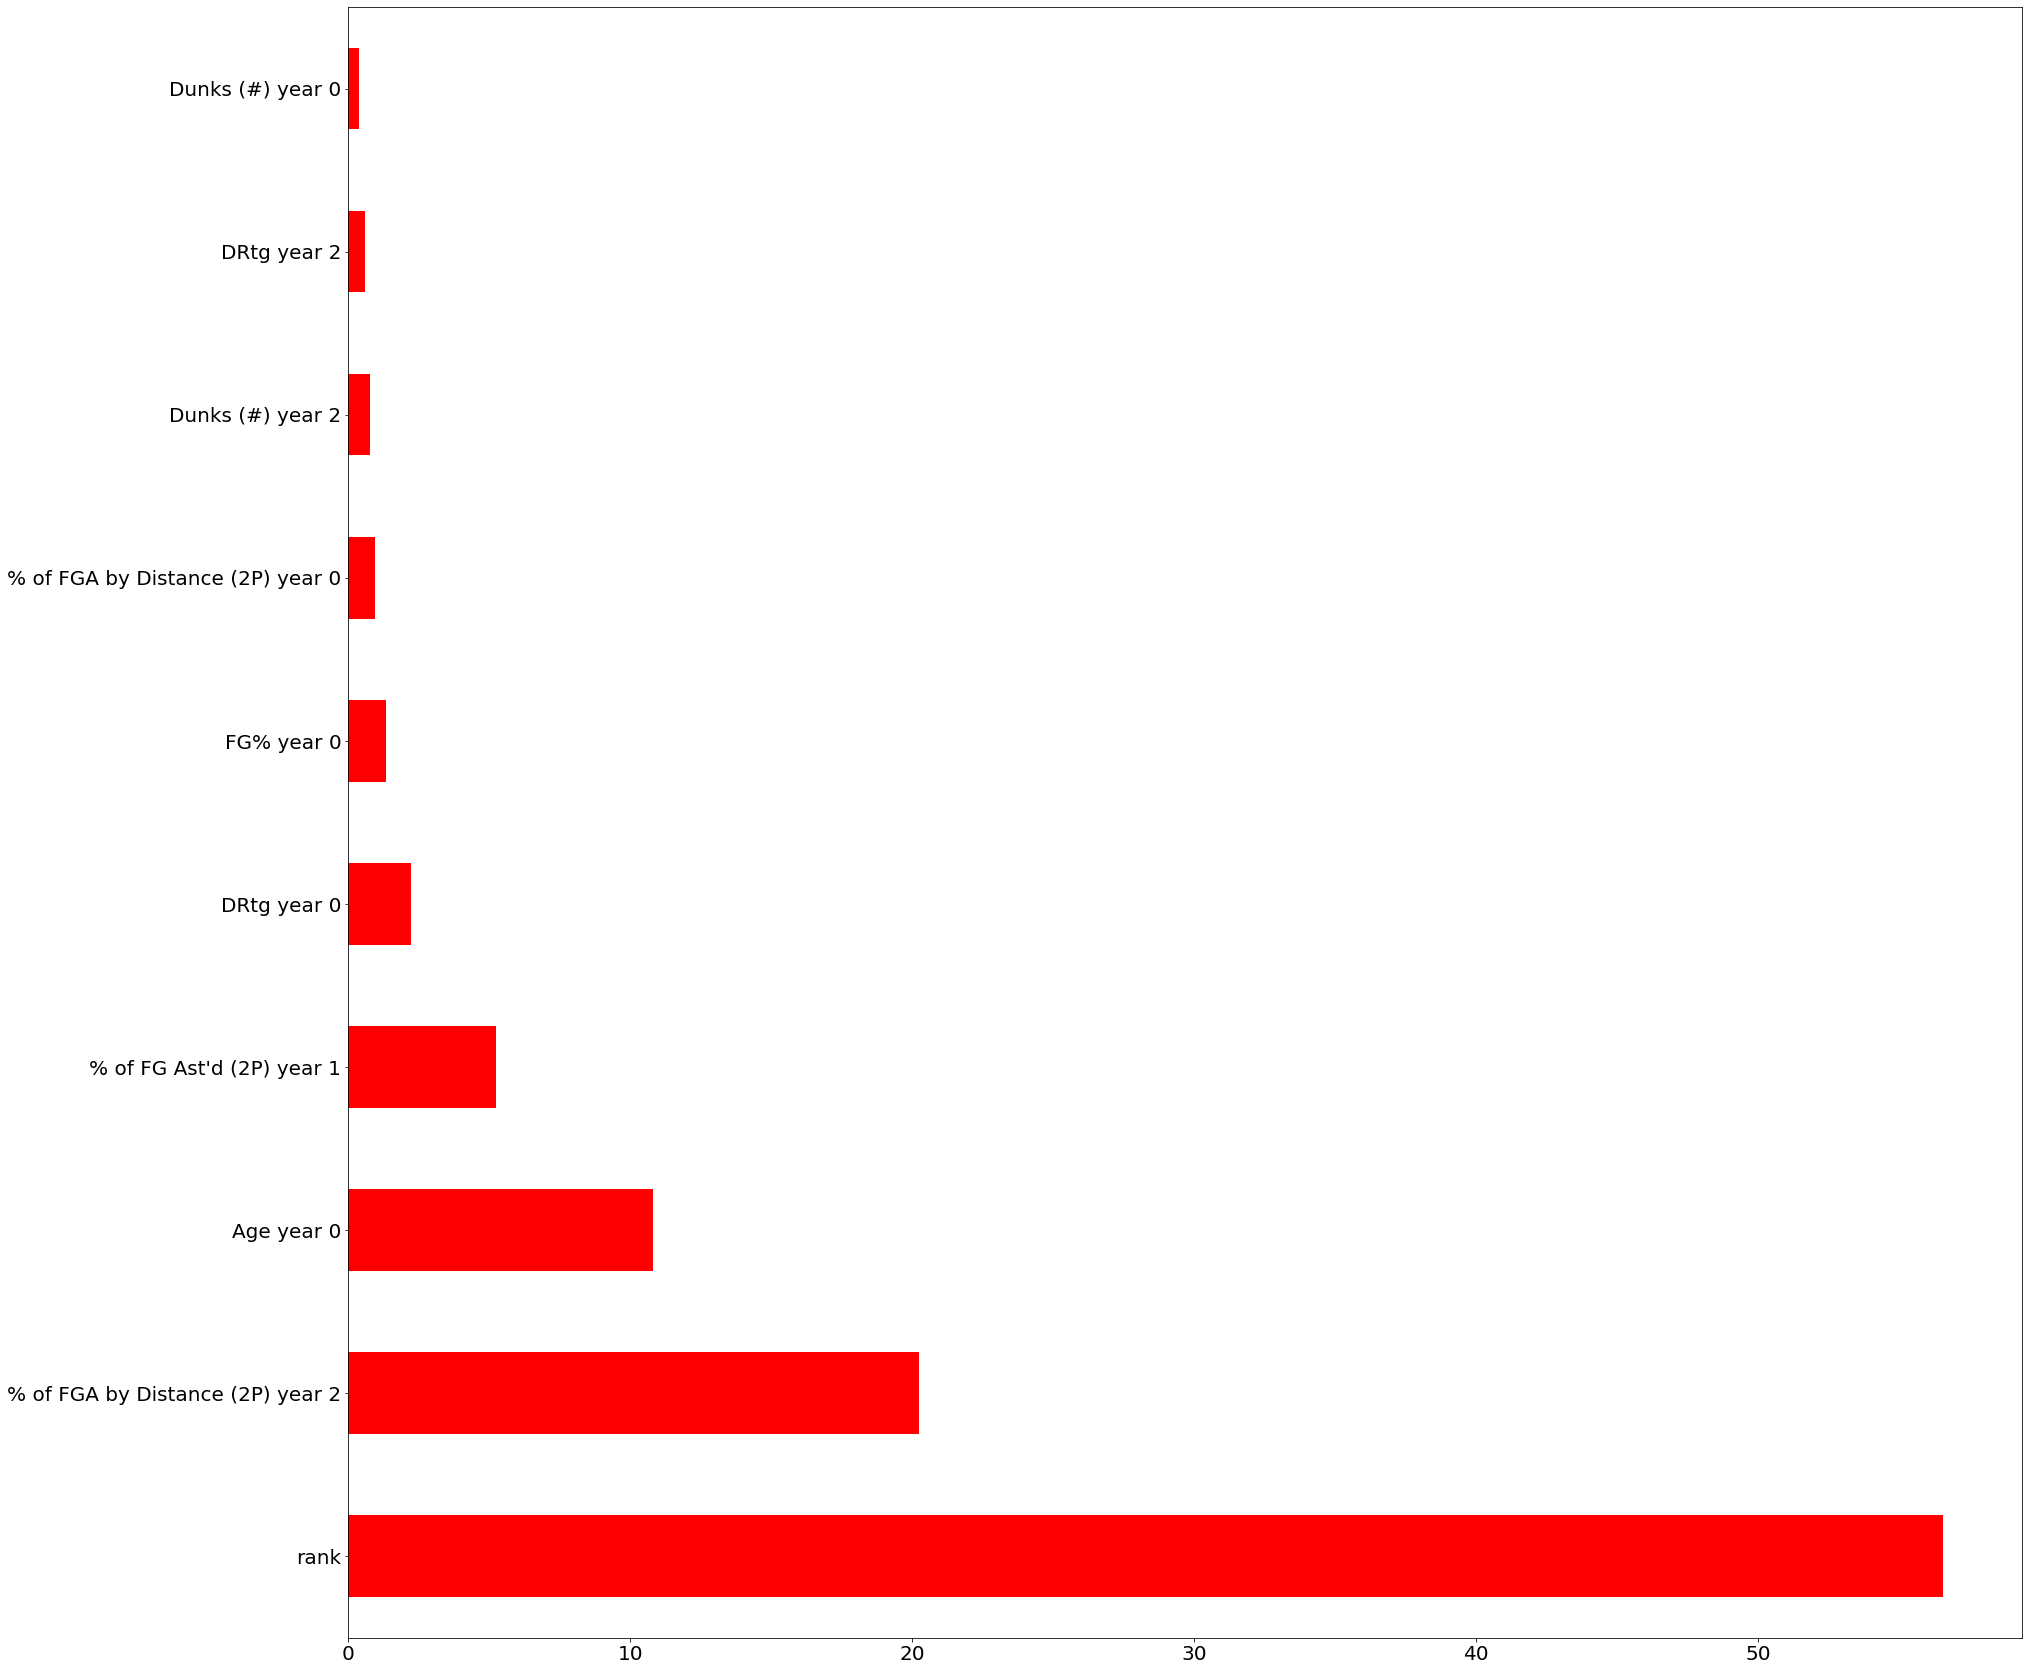

Boosting RMSE on Validation Data Boosting Regressor: 8042644.776349966
---
Boosting with 20 estimators and learning rate of 0.1


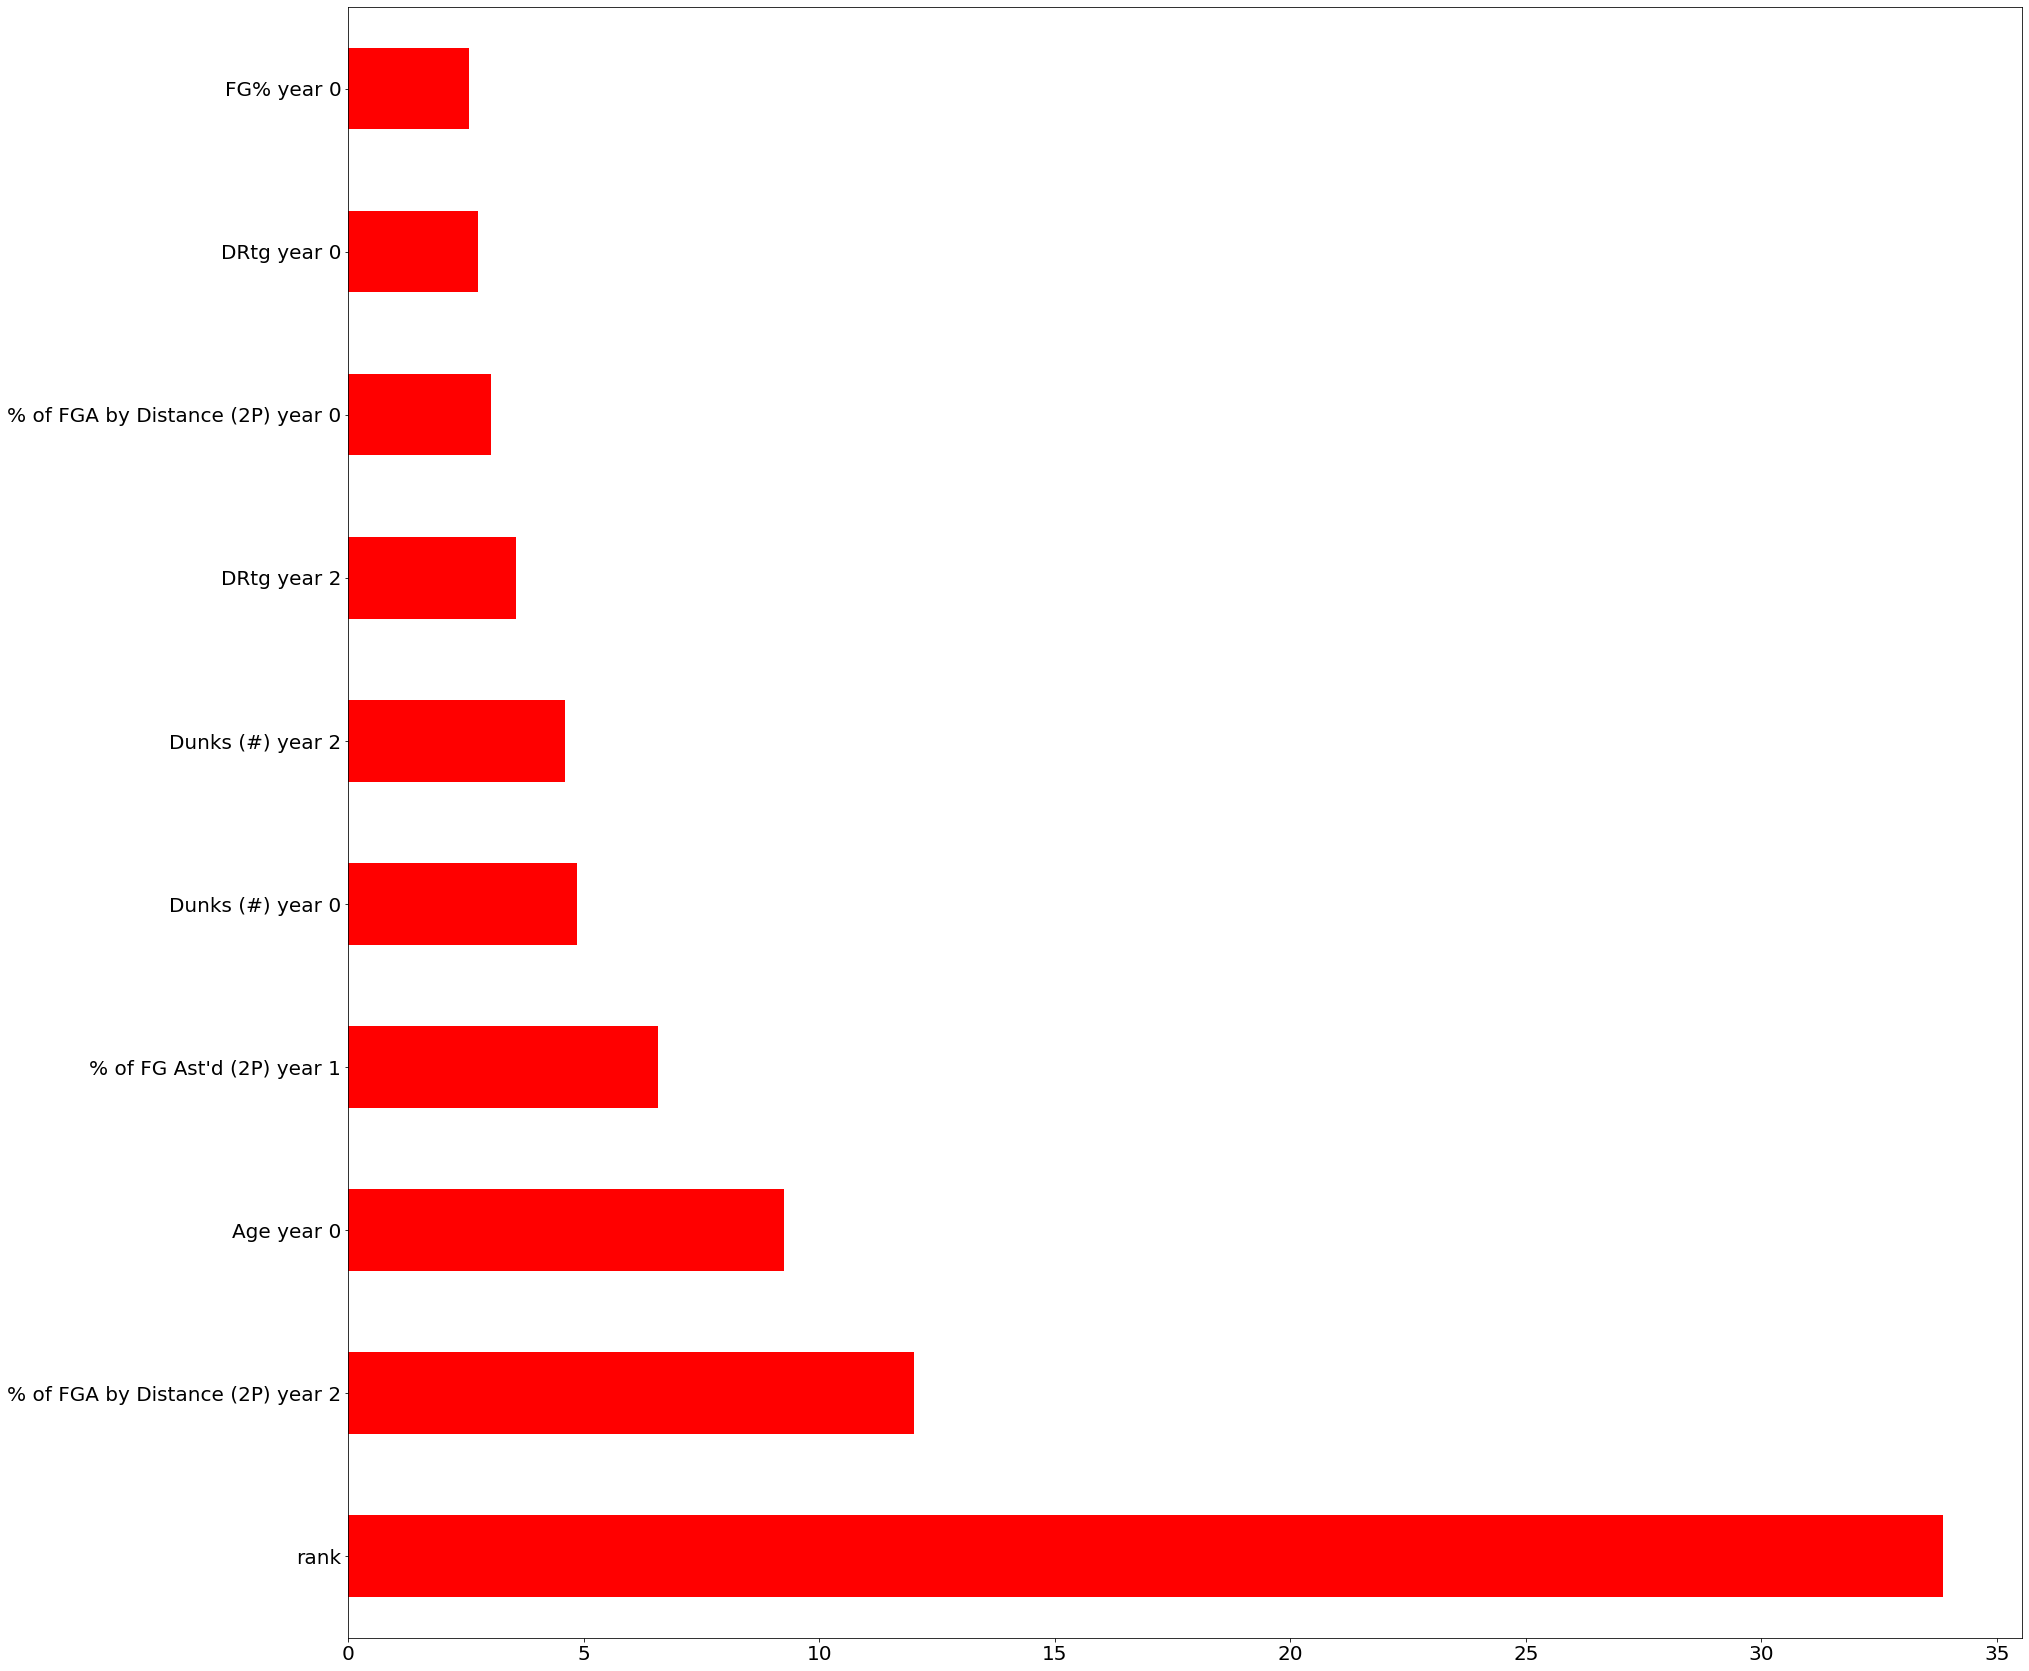

Boosting RMSE on Validation Data Boosting Regressor: 7278698.289377232
---
Boosting with 20 estimators and learning rate of 1


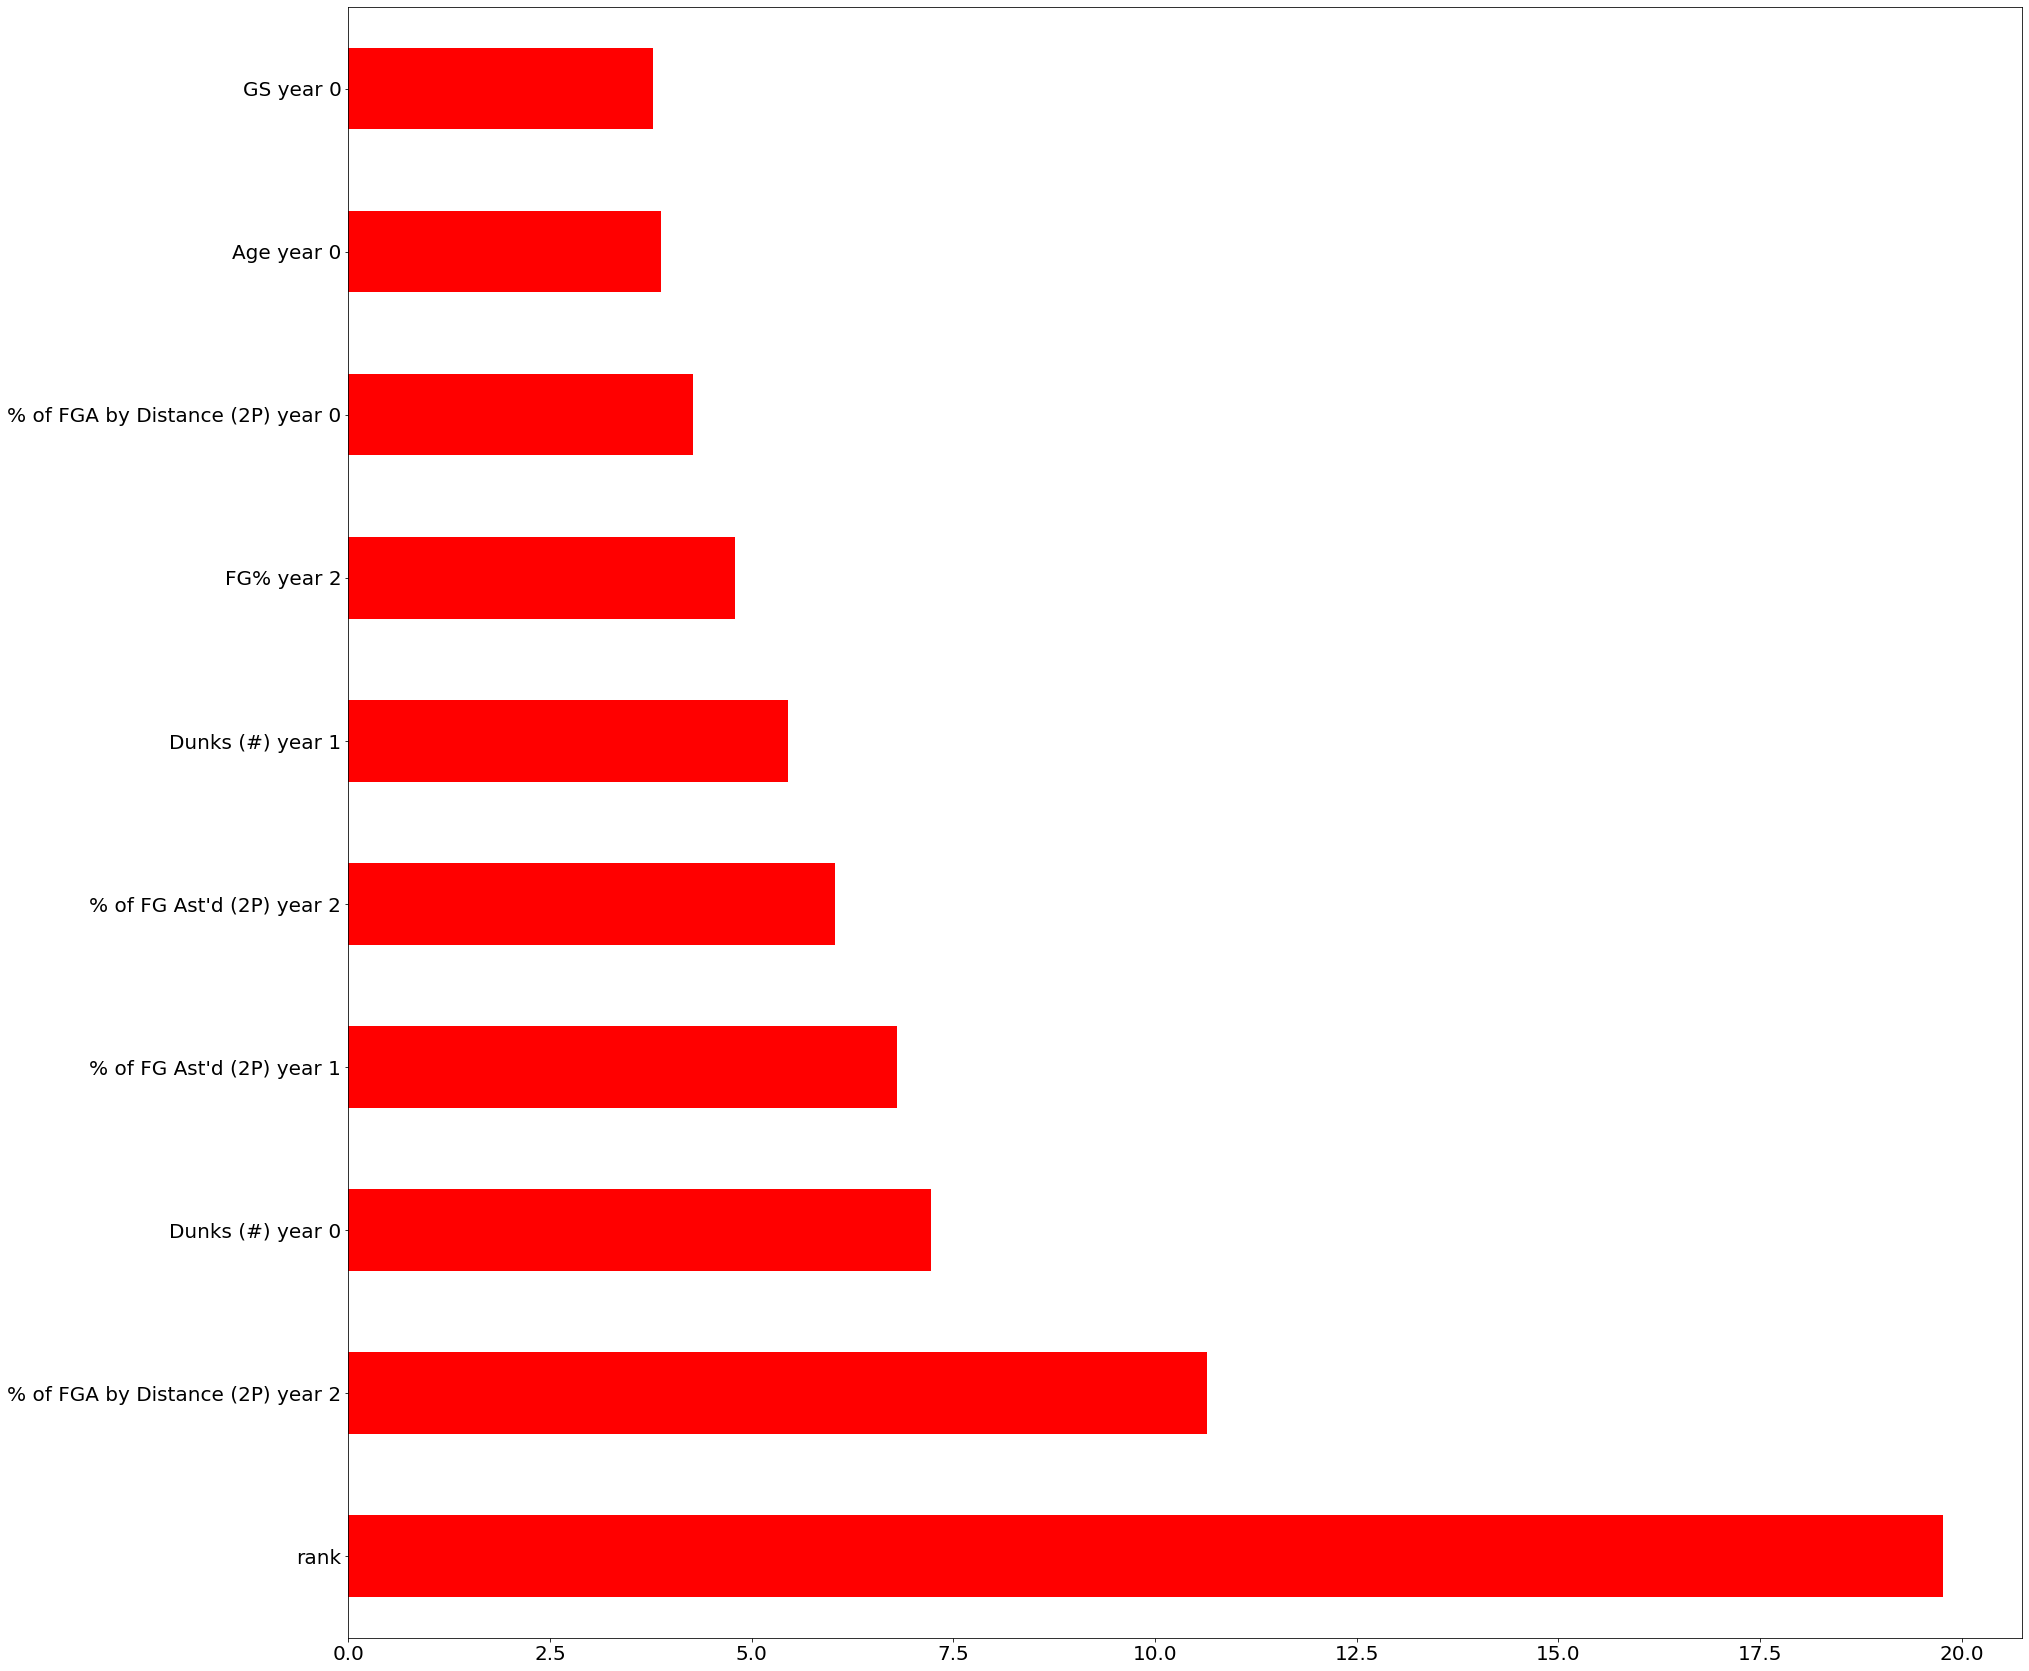

Boosting RMSE on Validation Data Boosting Regressor: 9345859.512872534
---
Boosting with 50 estimators and learning rate of 0.01


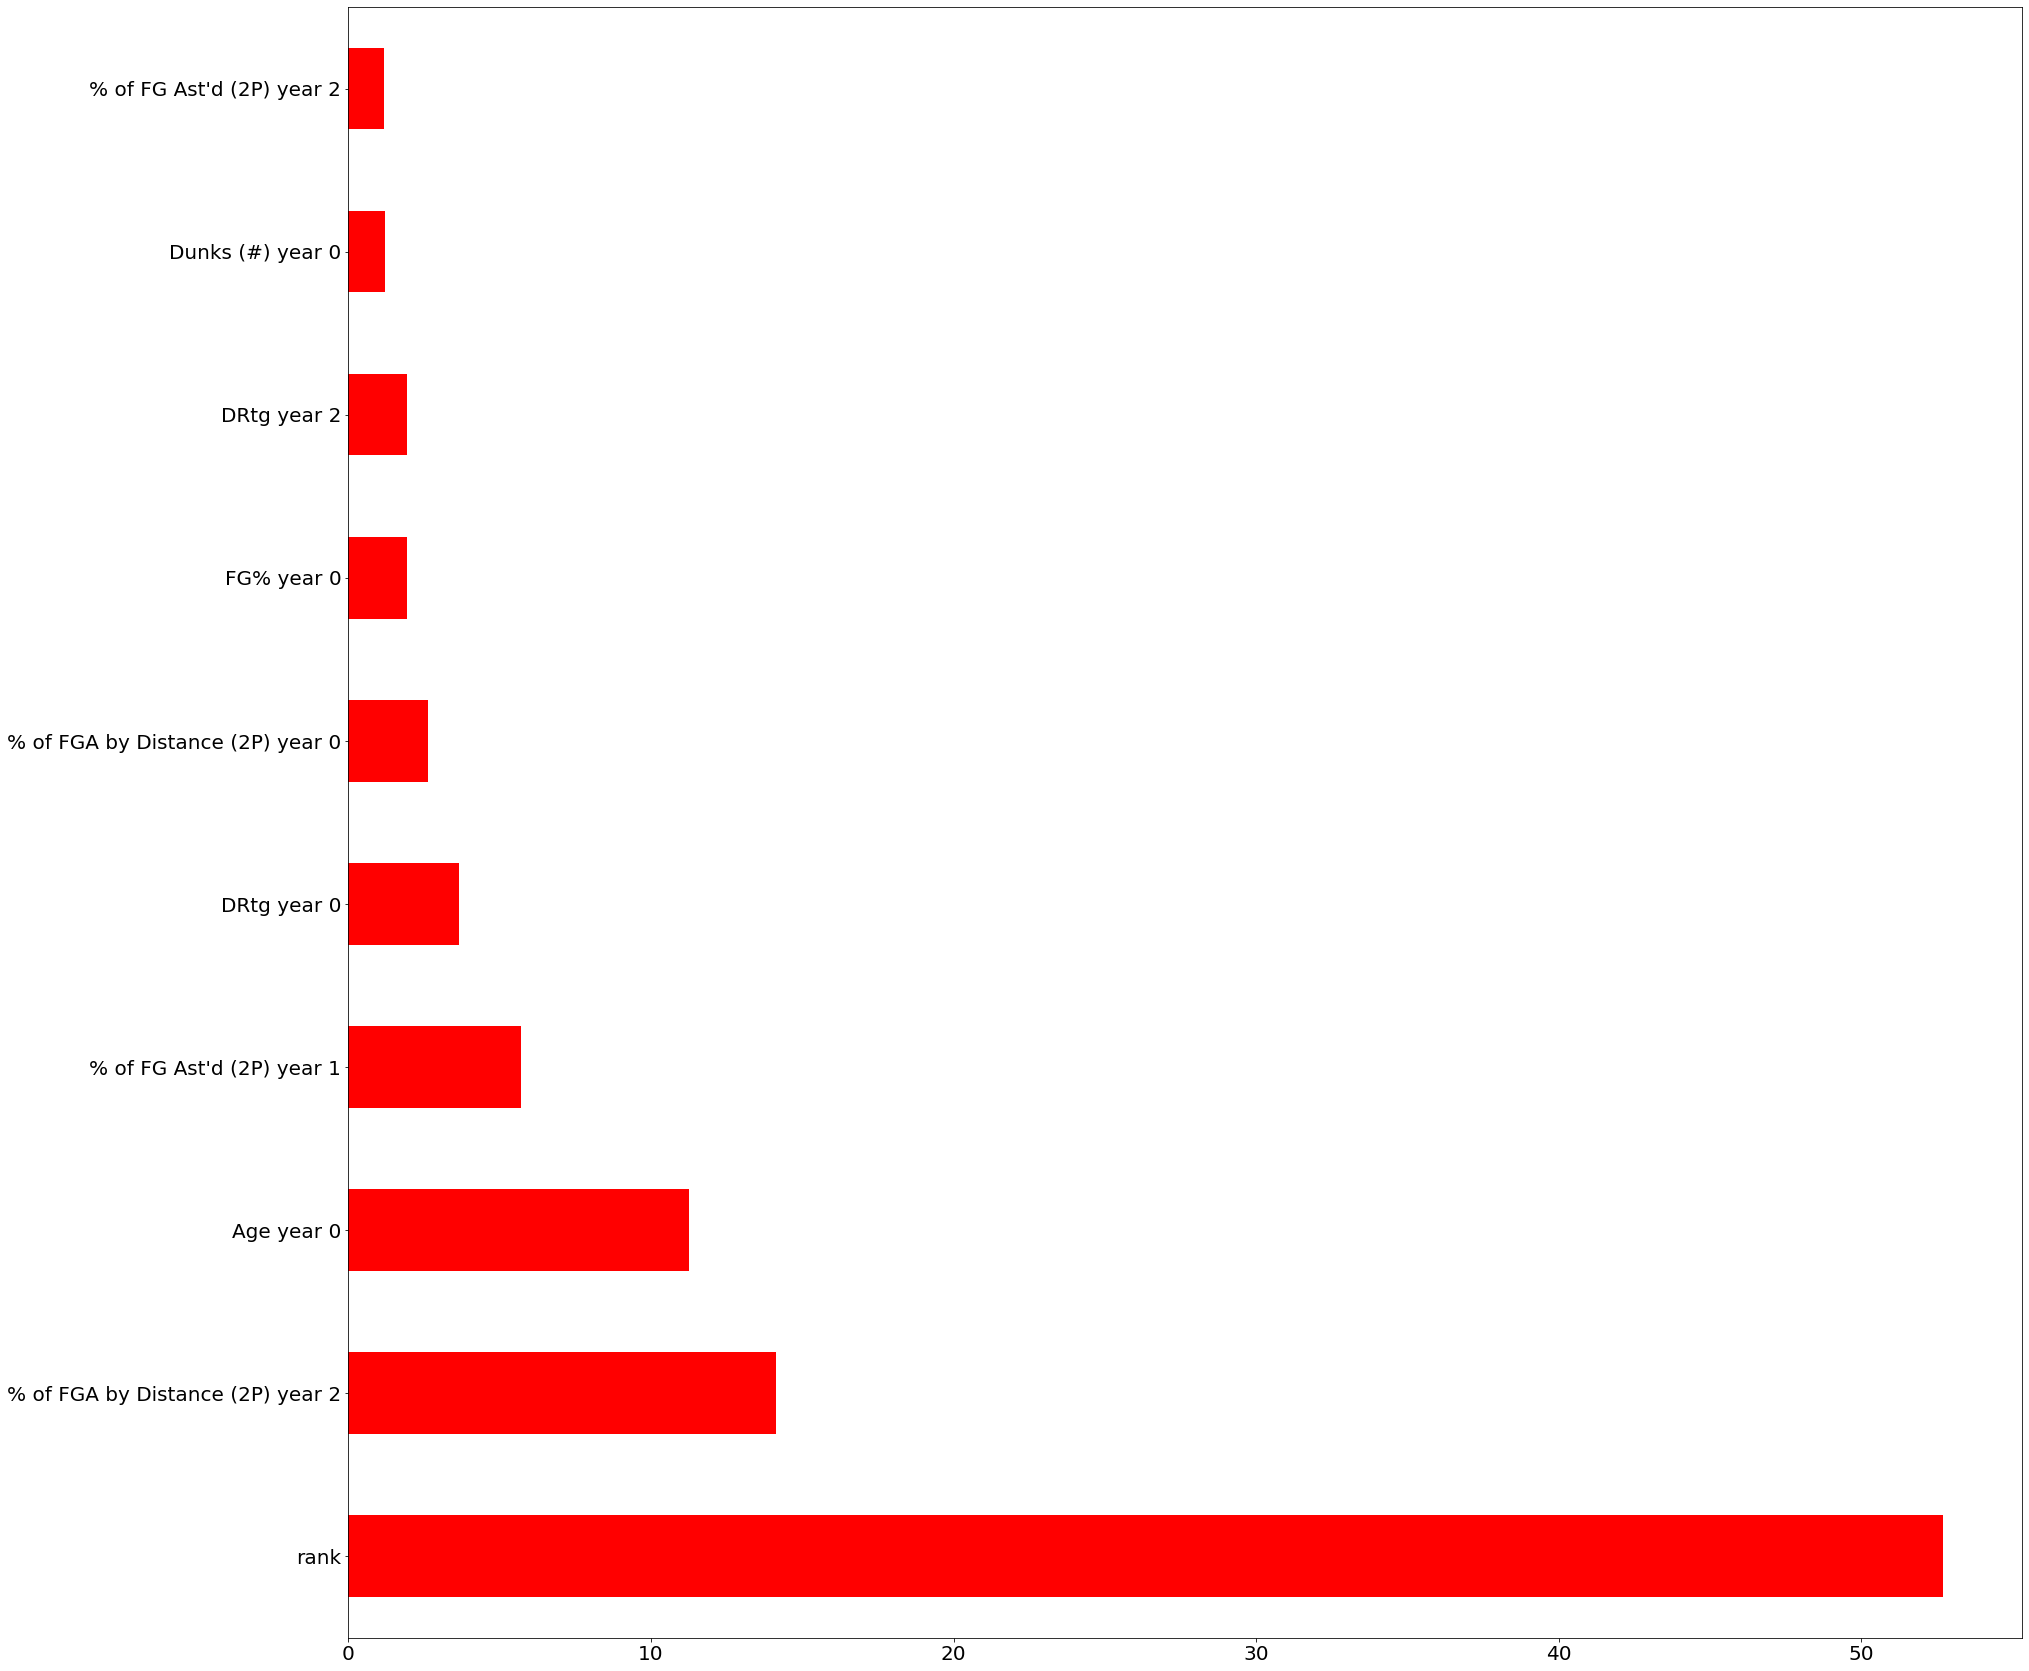

Boosting RMSE on Validation Data Boosting Regressor: 7682915.6614984395
---
Boosting with 50 estimators and learning rate of 0.1


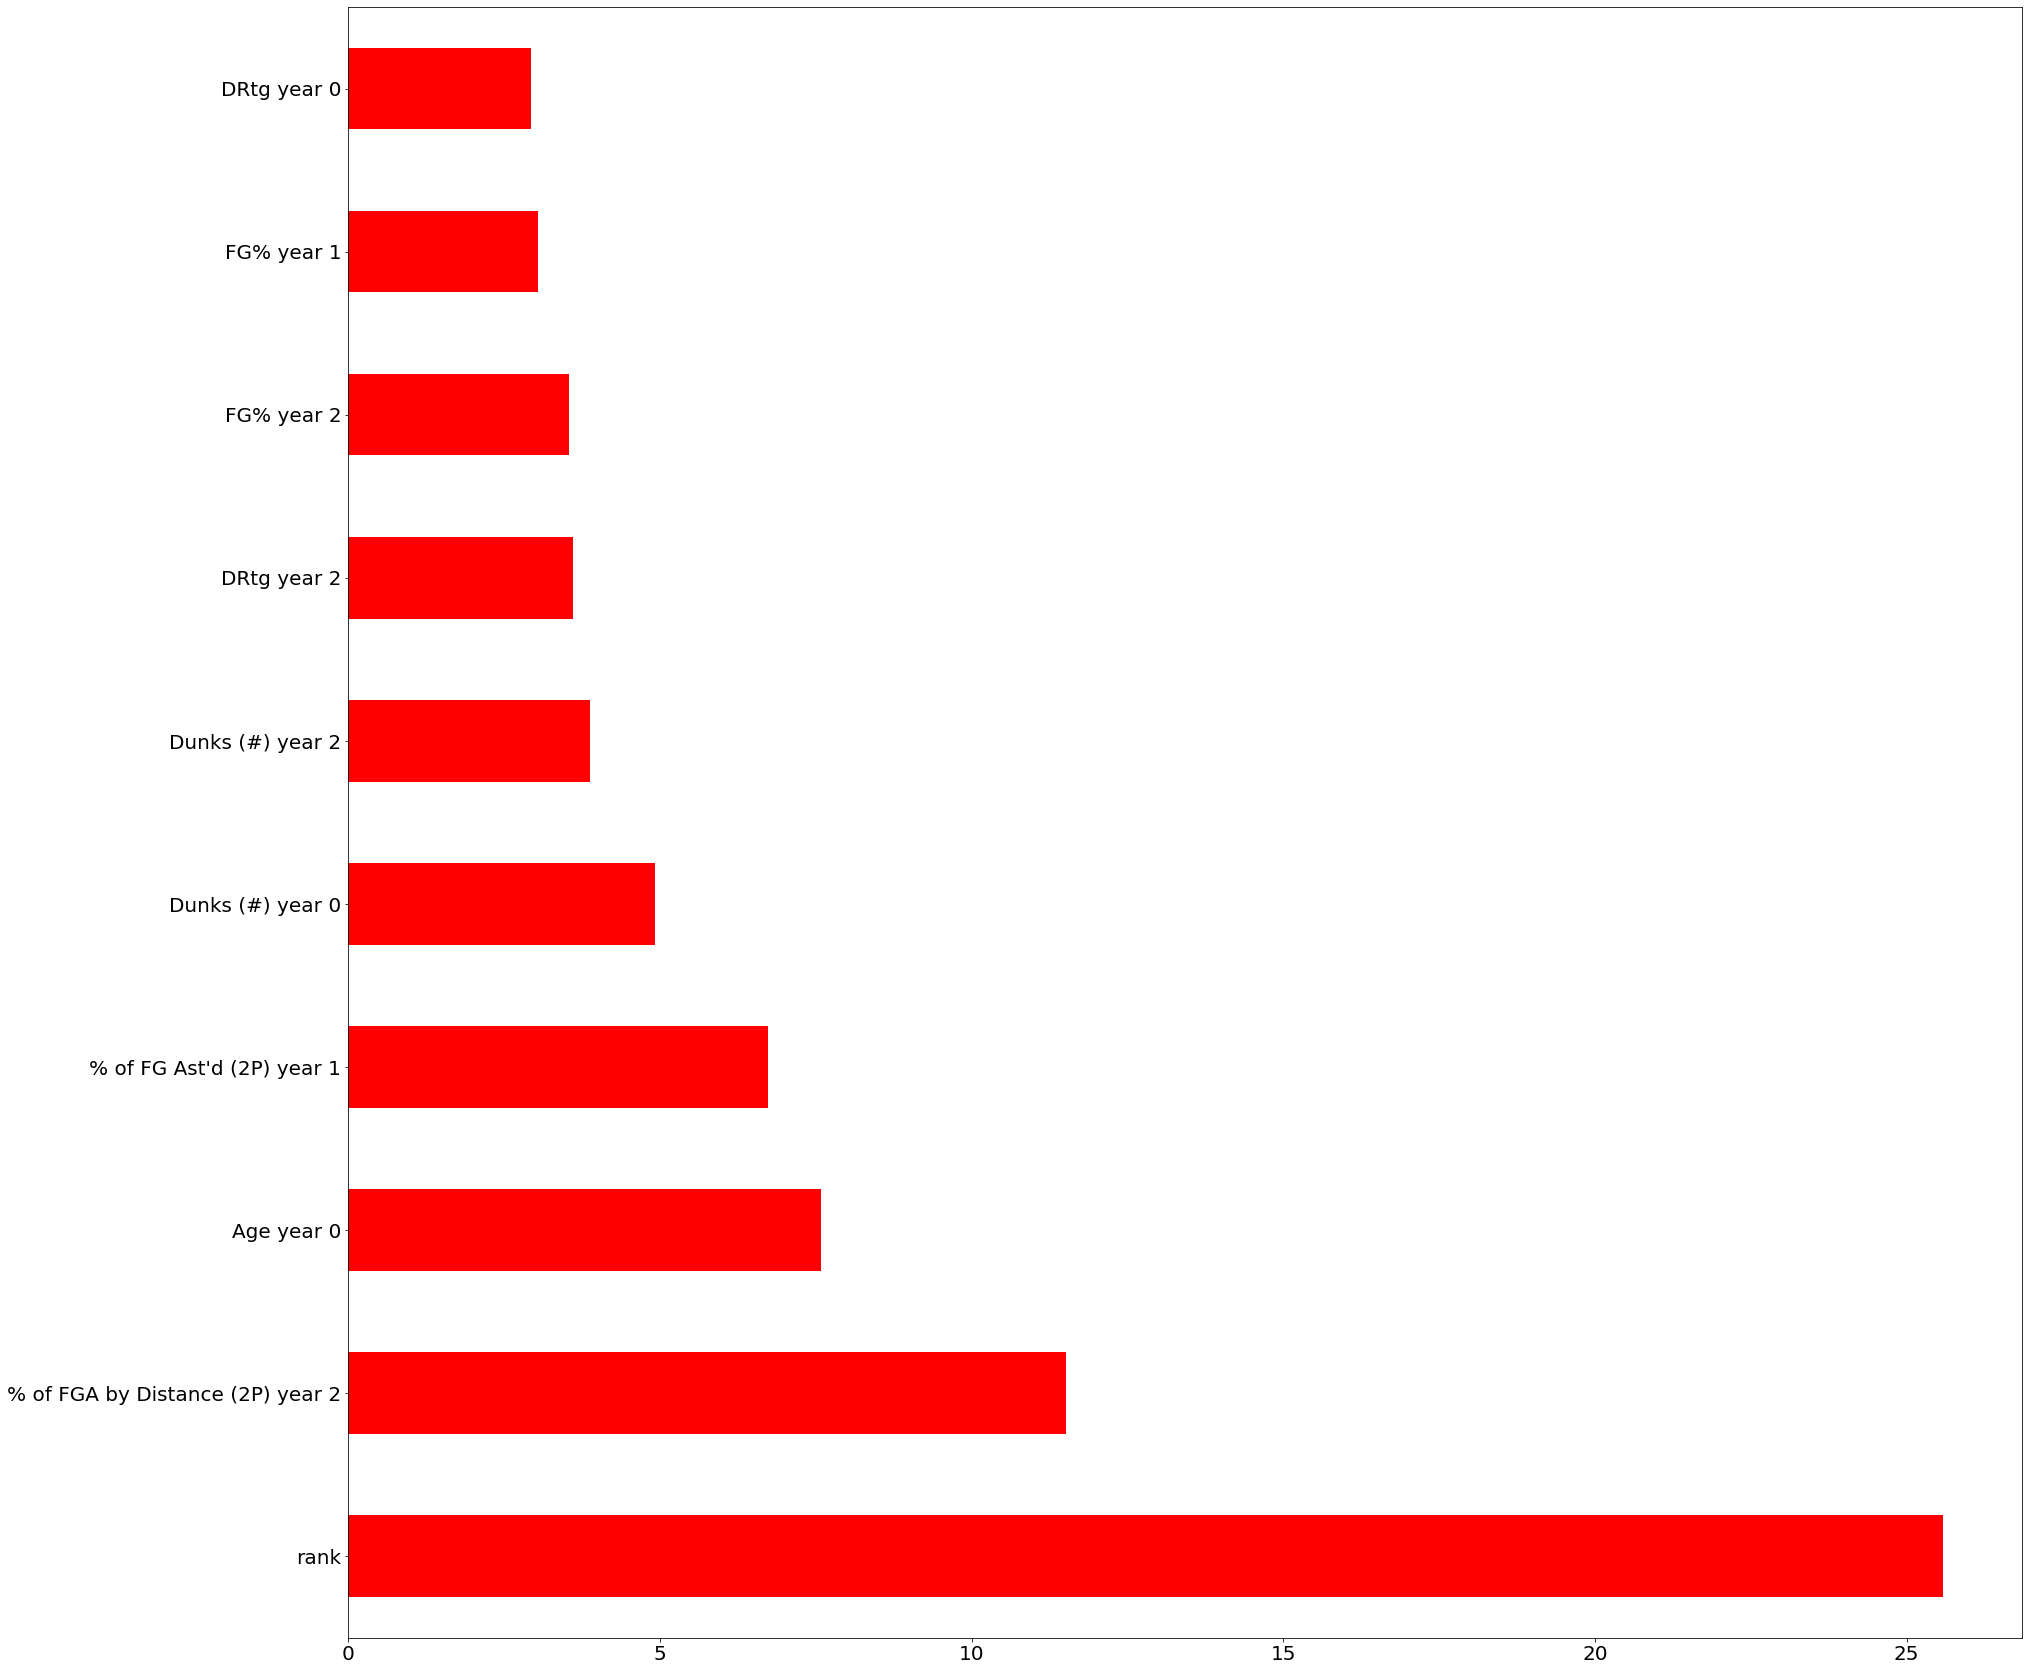

Boosting RMSE on Validation Data Boosting Regressor: 7265115.7161022285
---
Boosting with 50 estimators and learning rate of 1


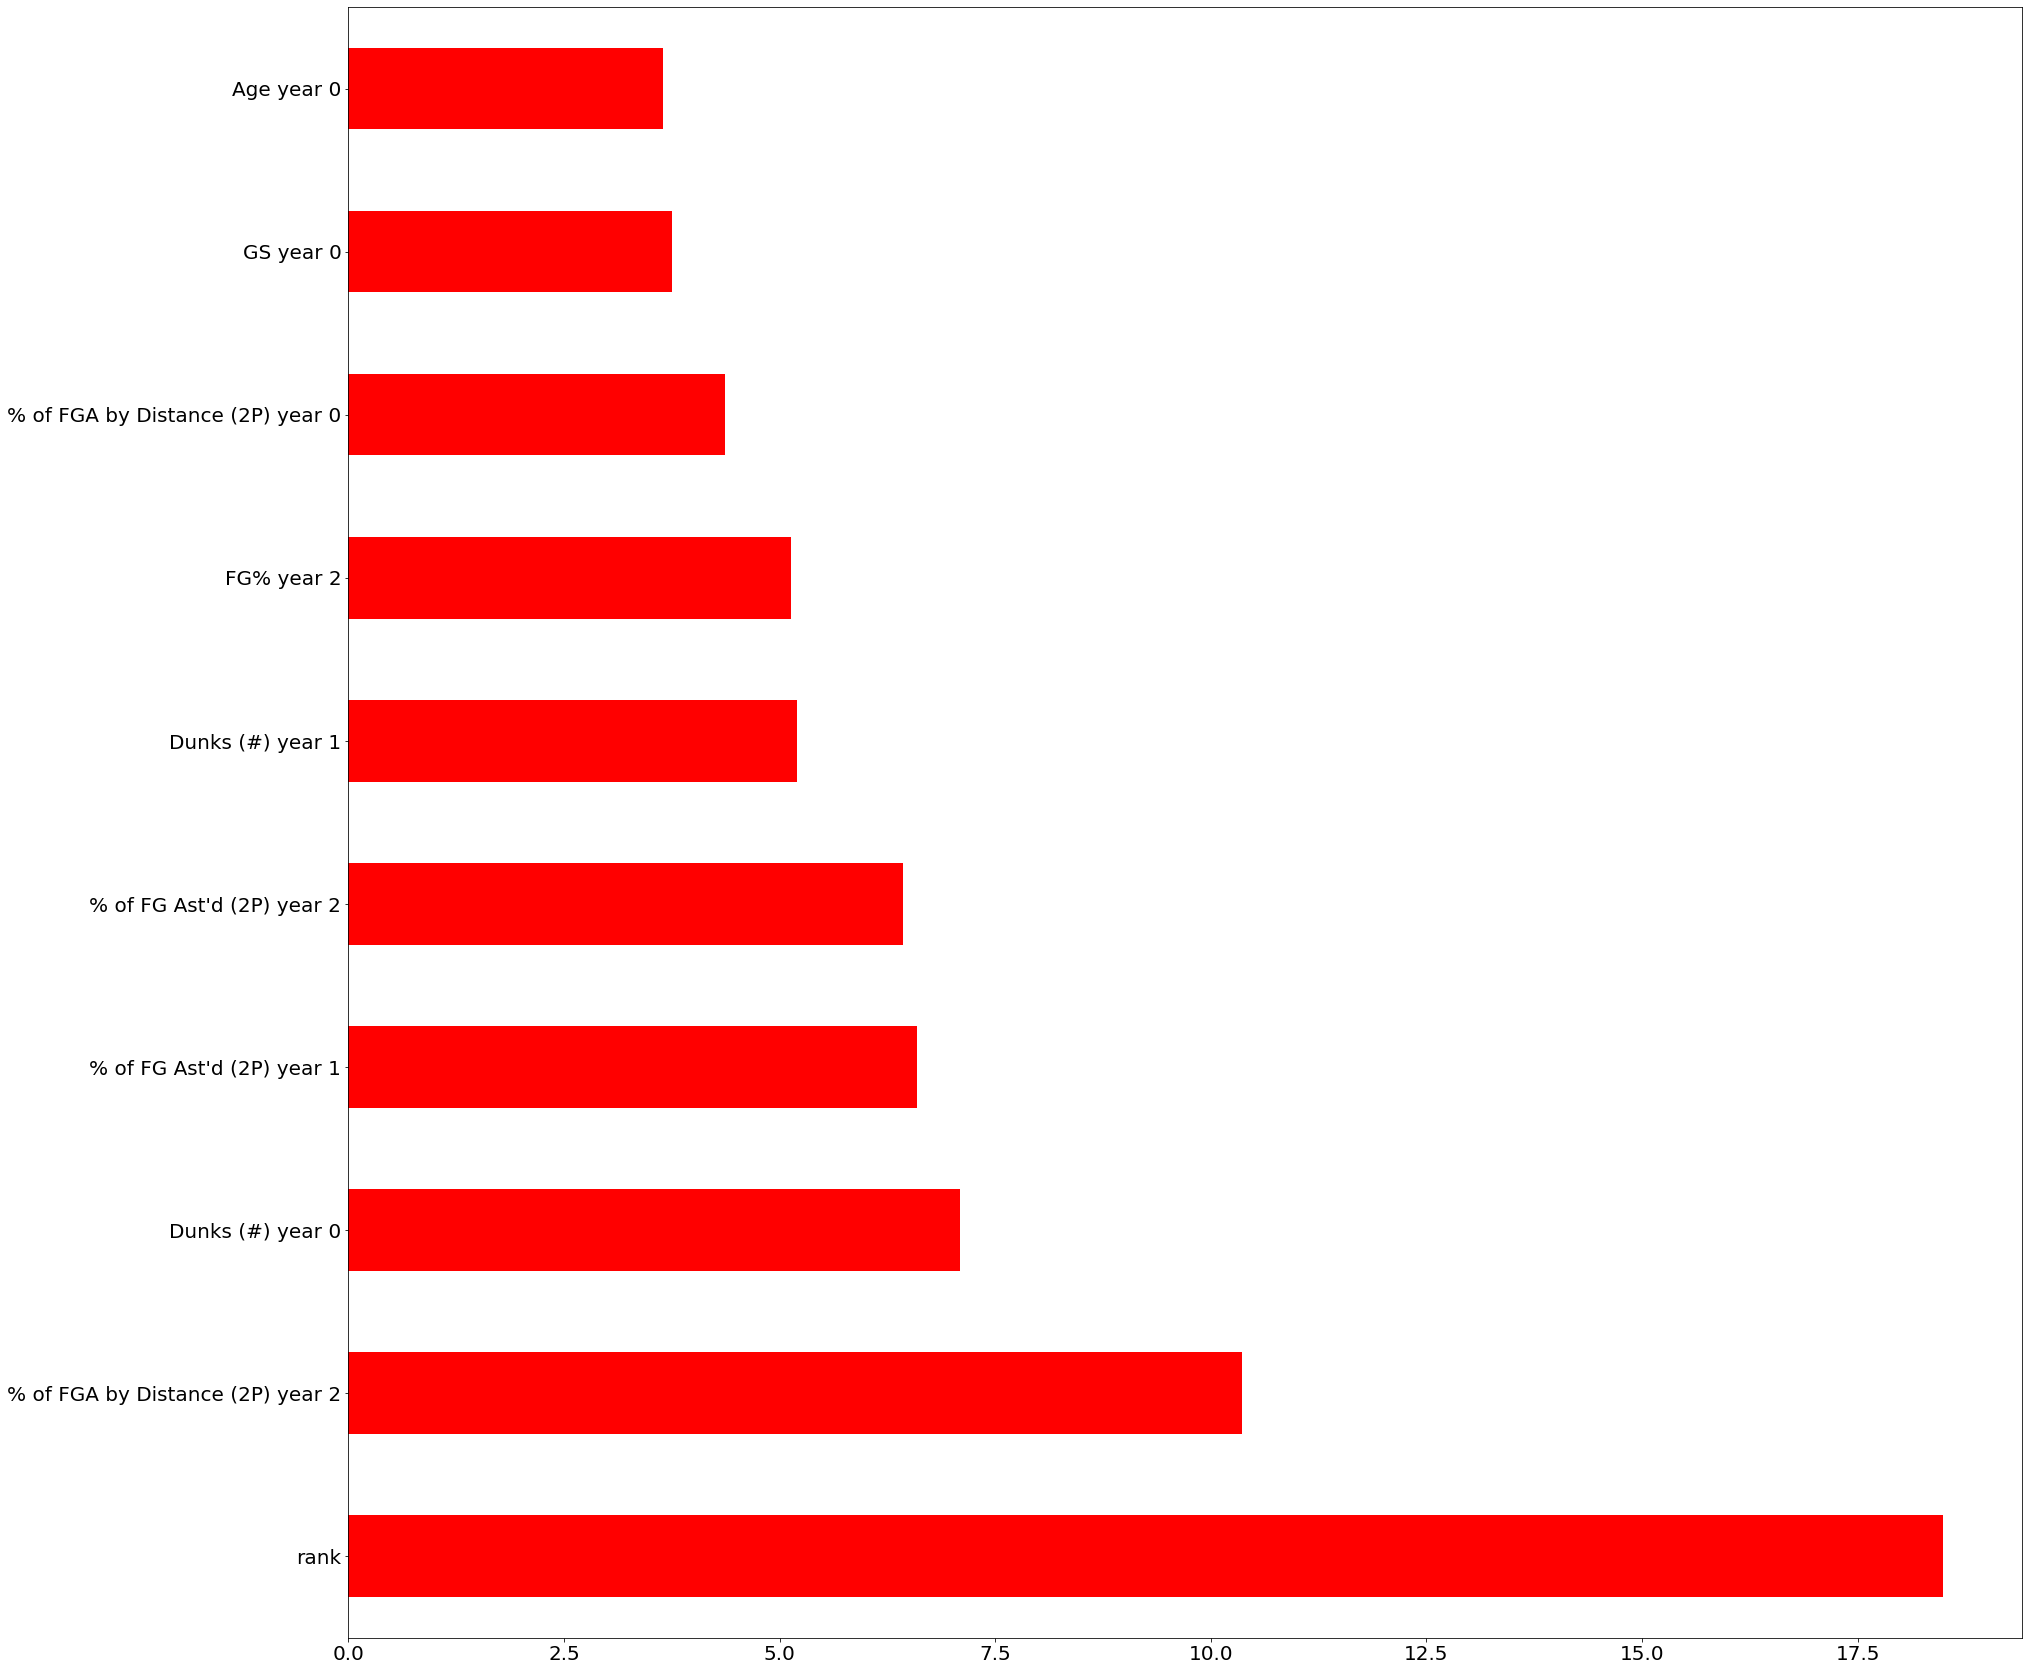

Boosting RMSE on Validation Data Boosting Regressor: 9632081.240626803
---
Boosting with 100 estimators and learning rate of 0.01


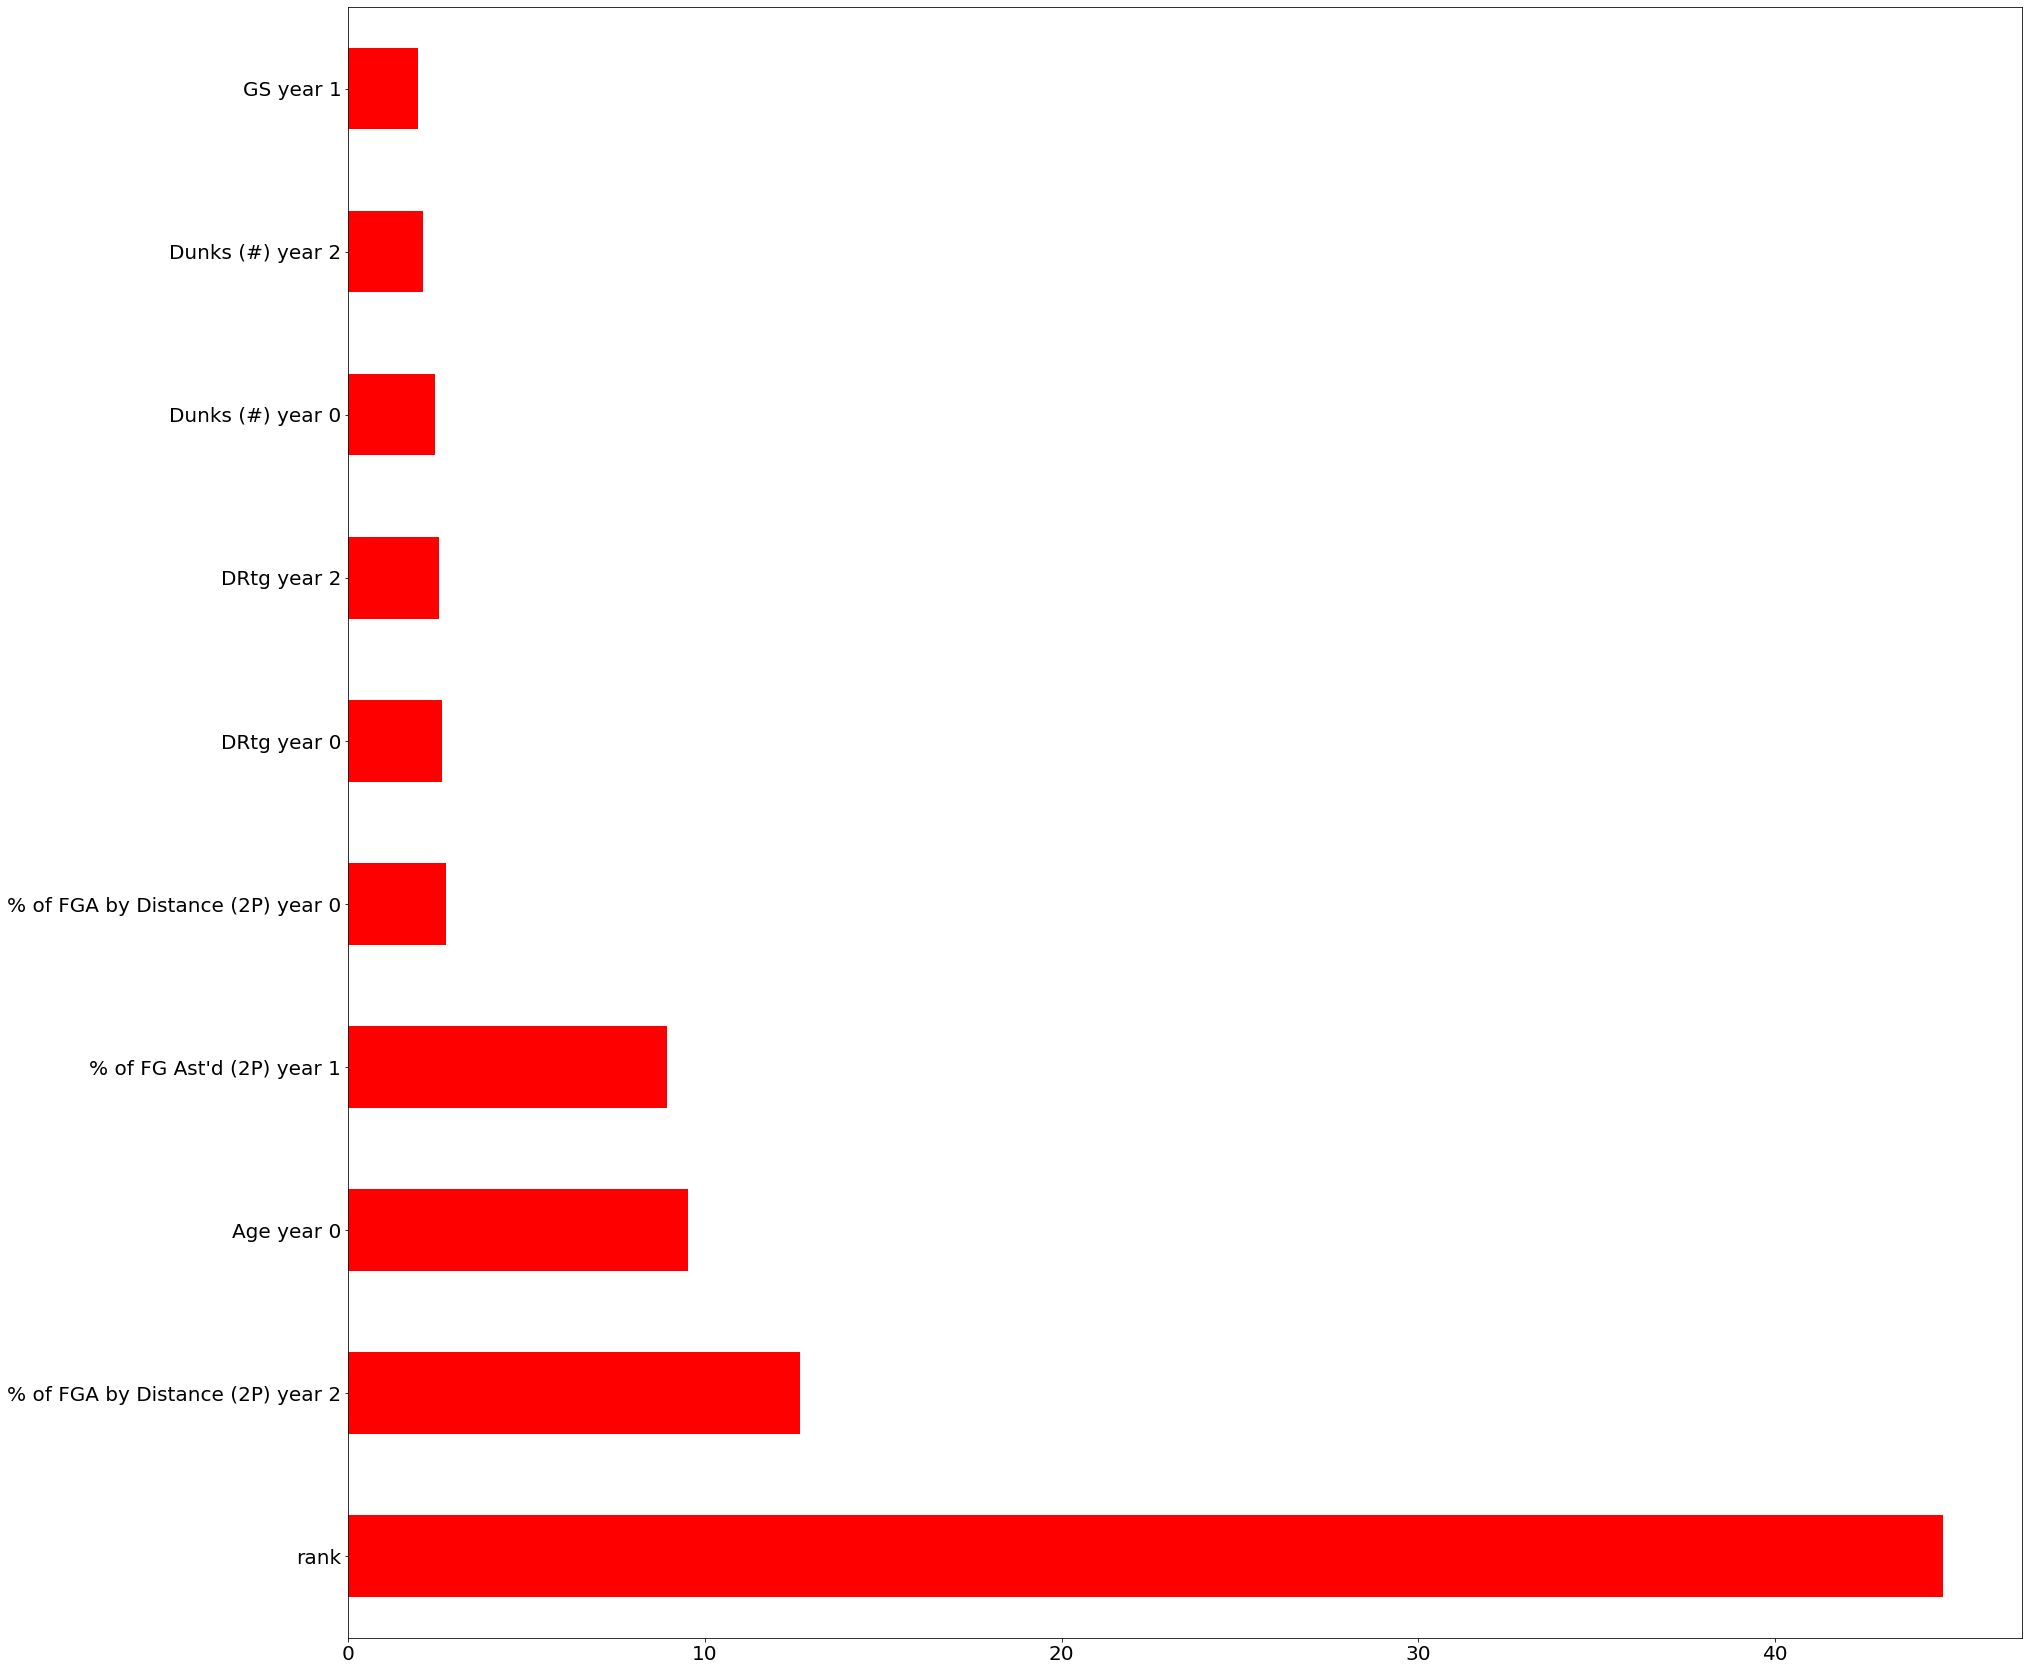

Boosting RMSE on Validation Data Boosting Regressor: 7444081.434558838
---
Boosting with 100 estimators and learning rate of 0.1


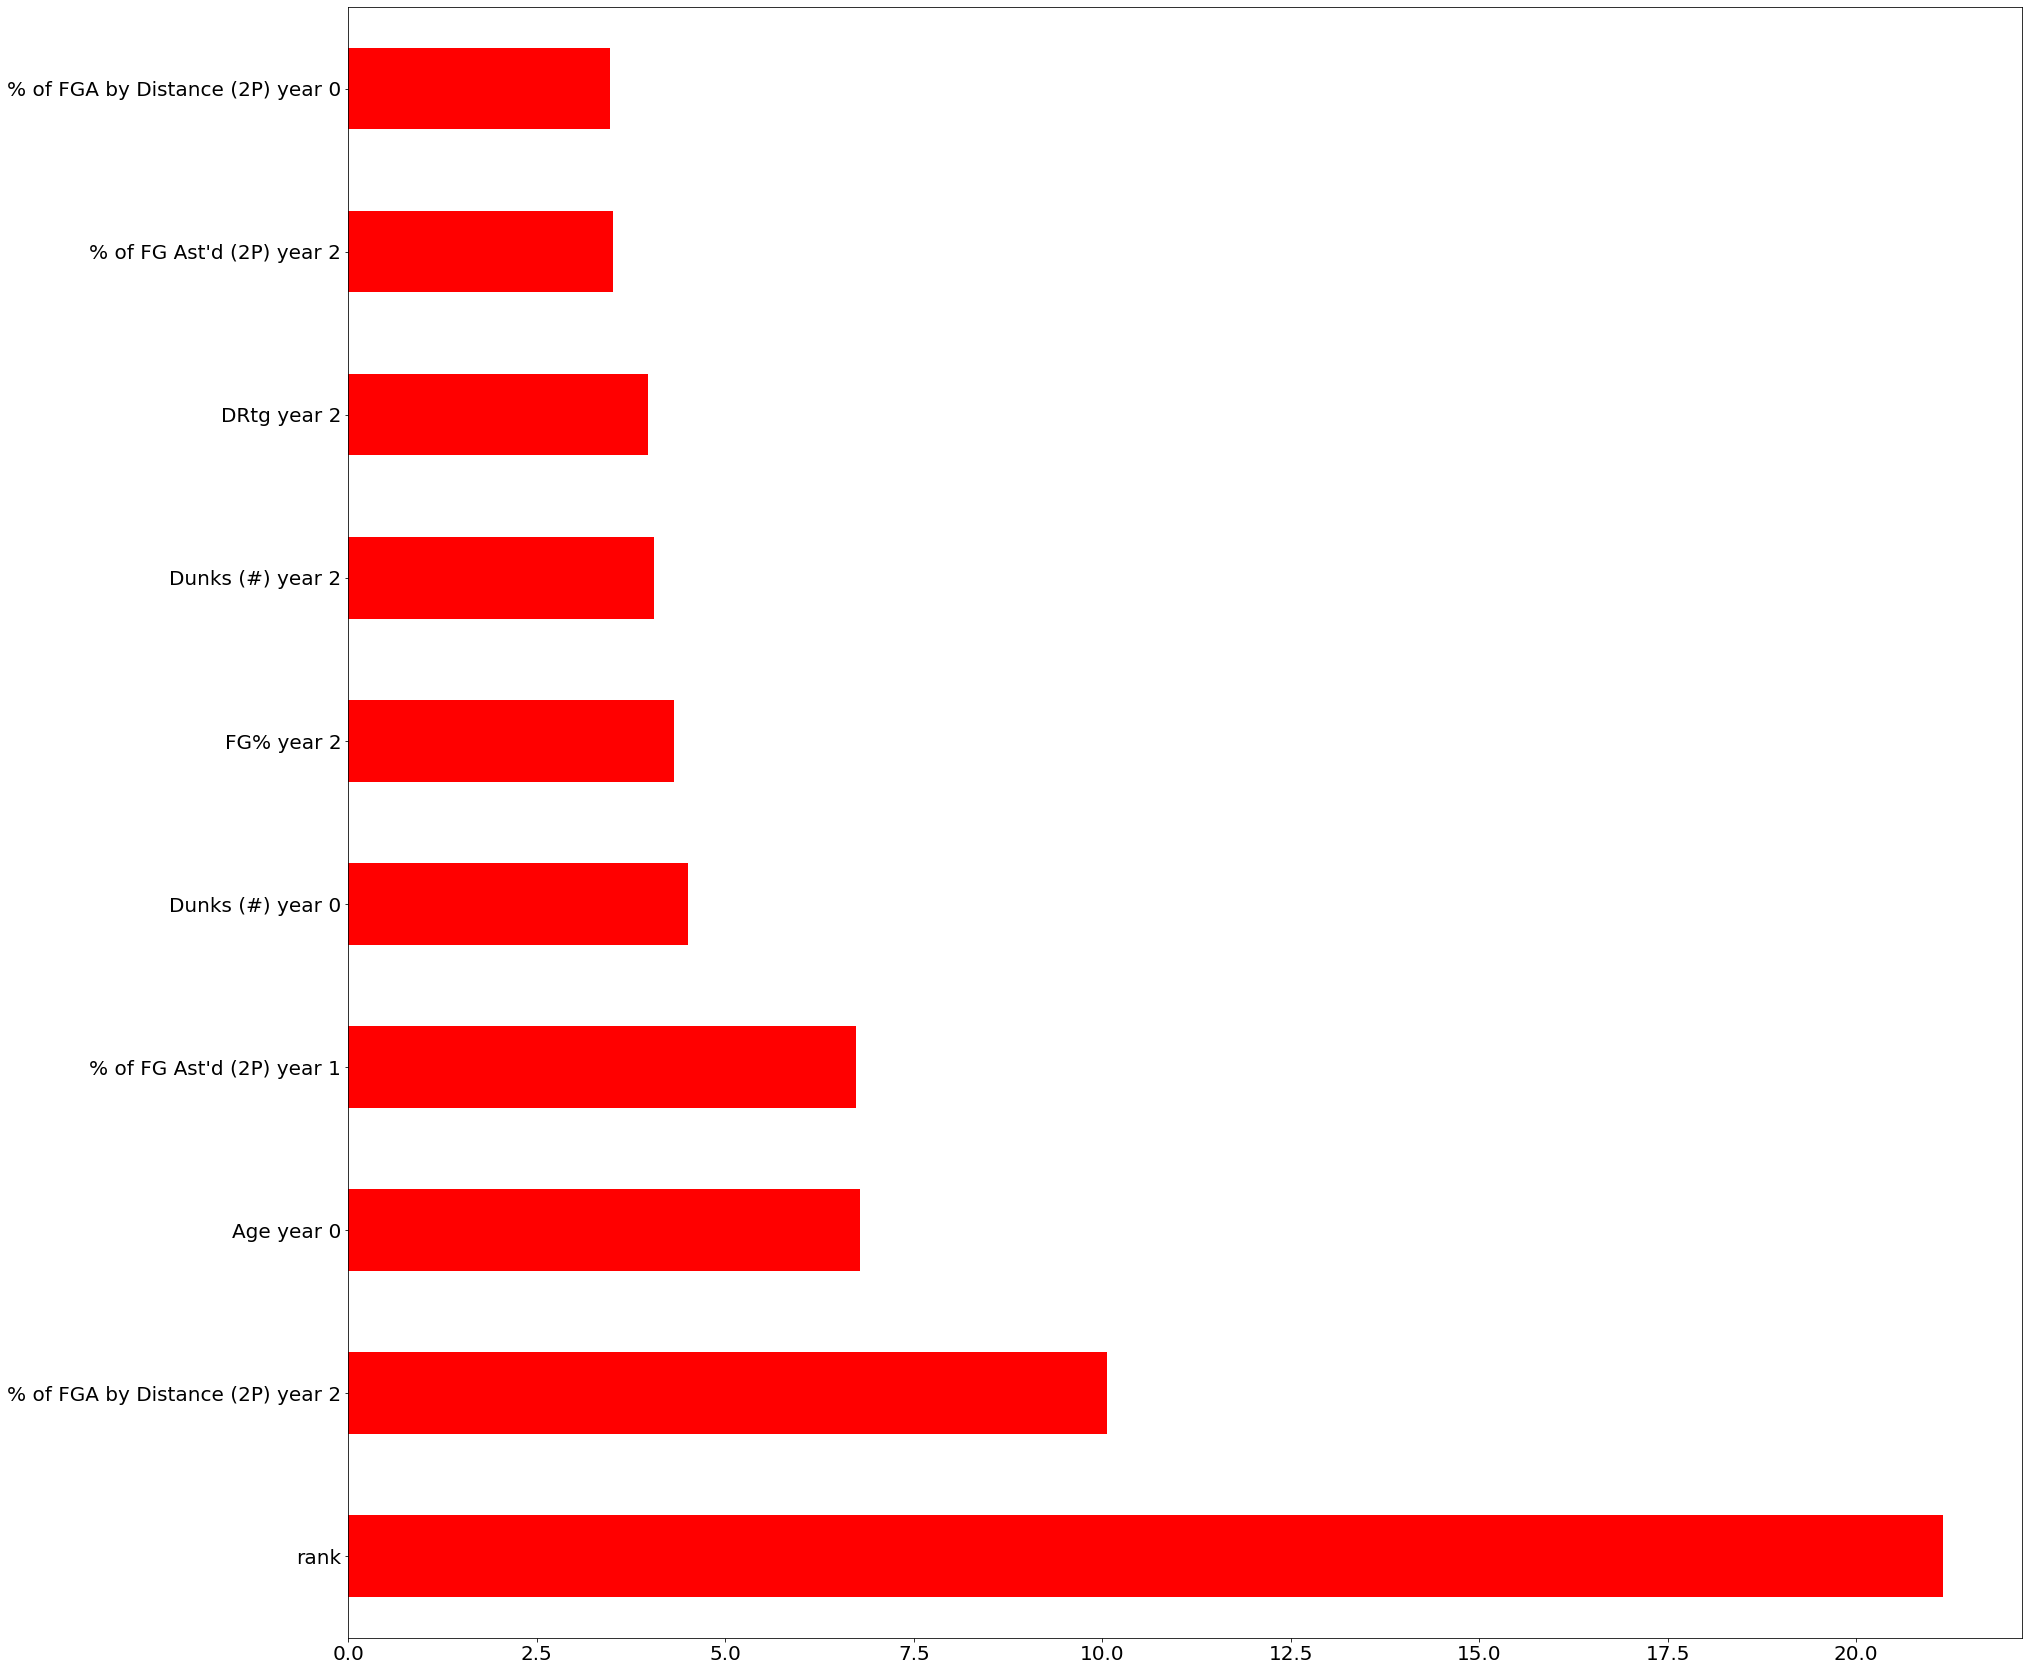

Boosting RMSE on Validation Data Boosting Regressor: 7479895.255796396
---
Boosting with 100 estimators and learning rate of 1


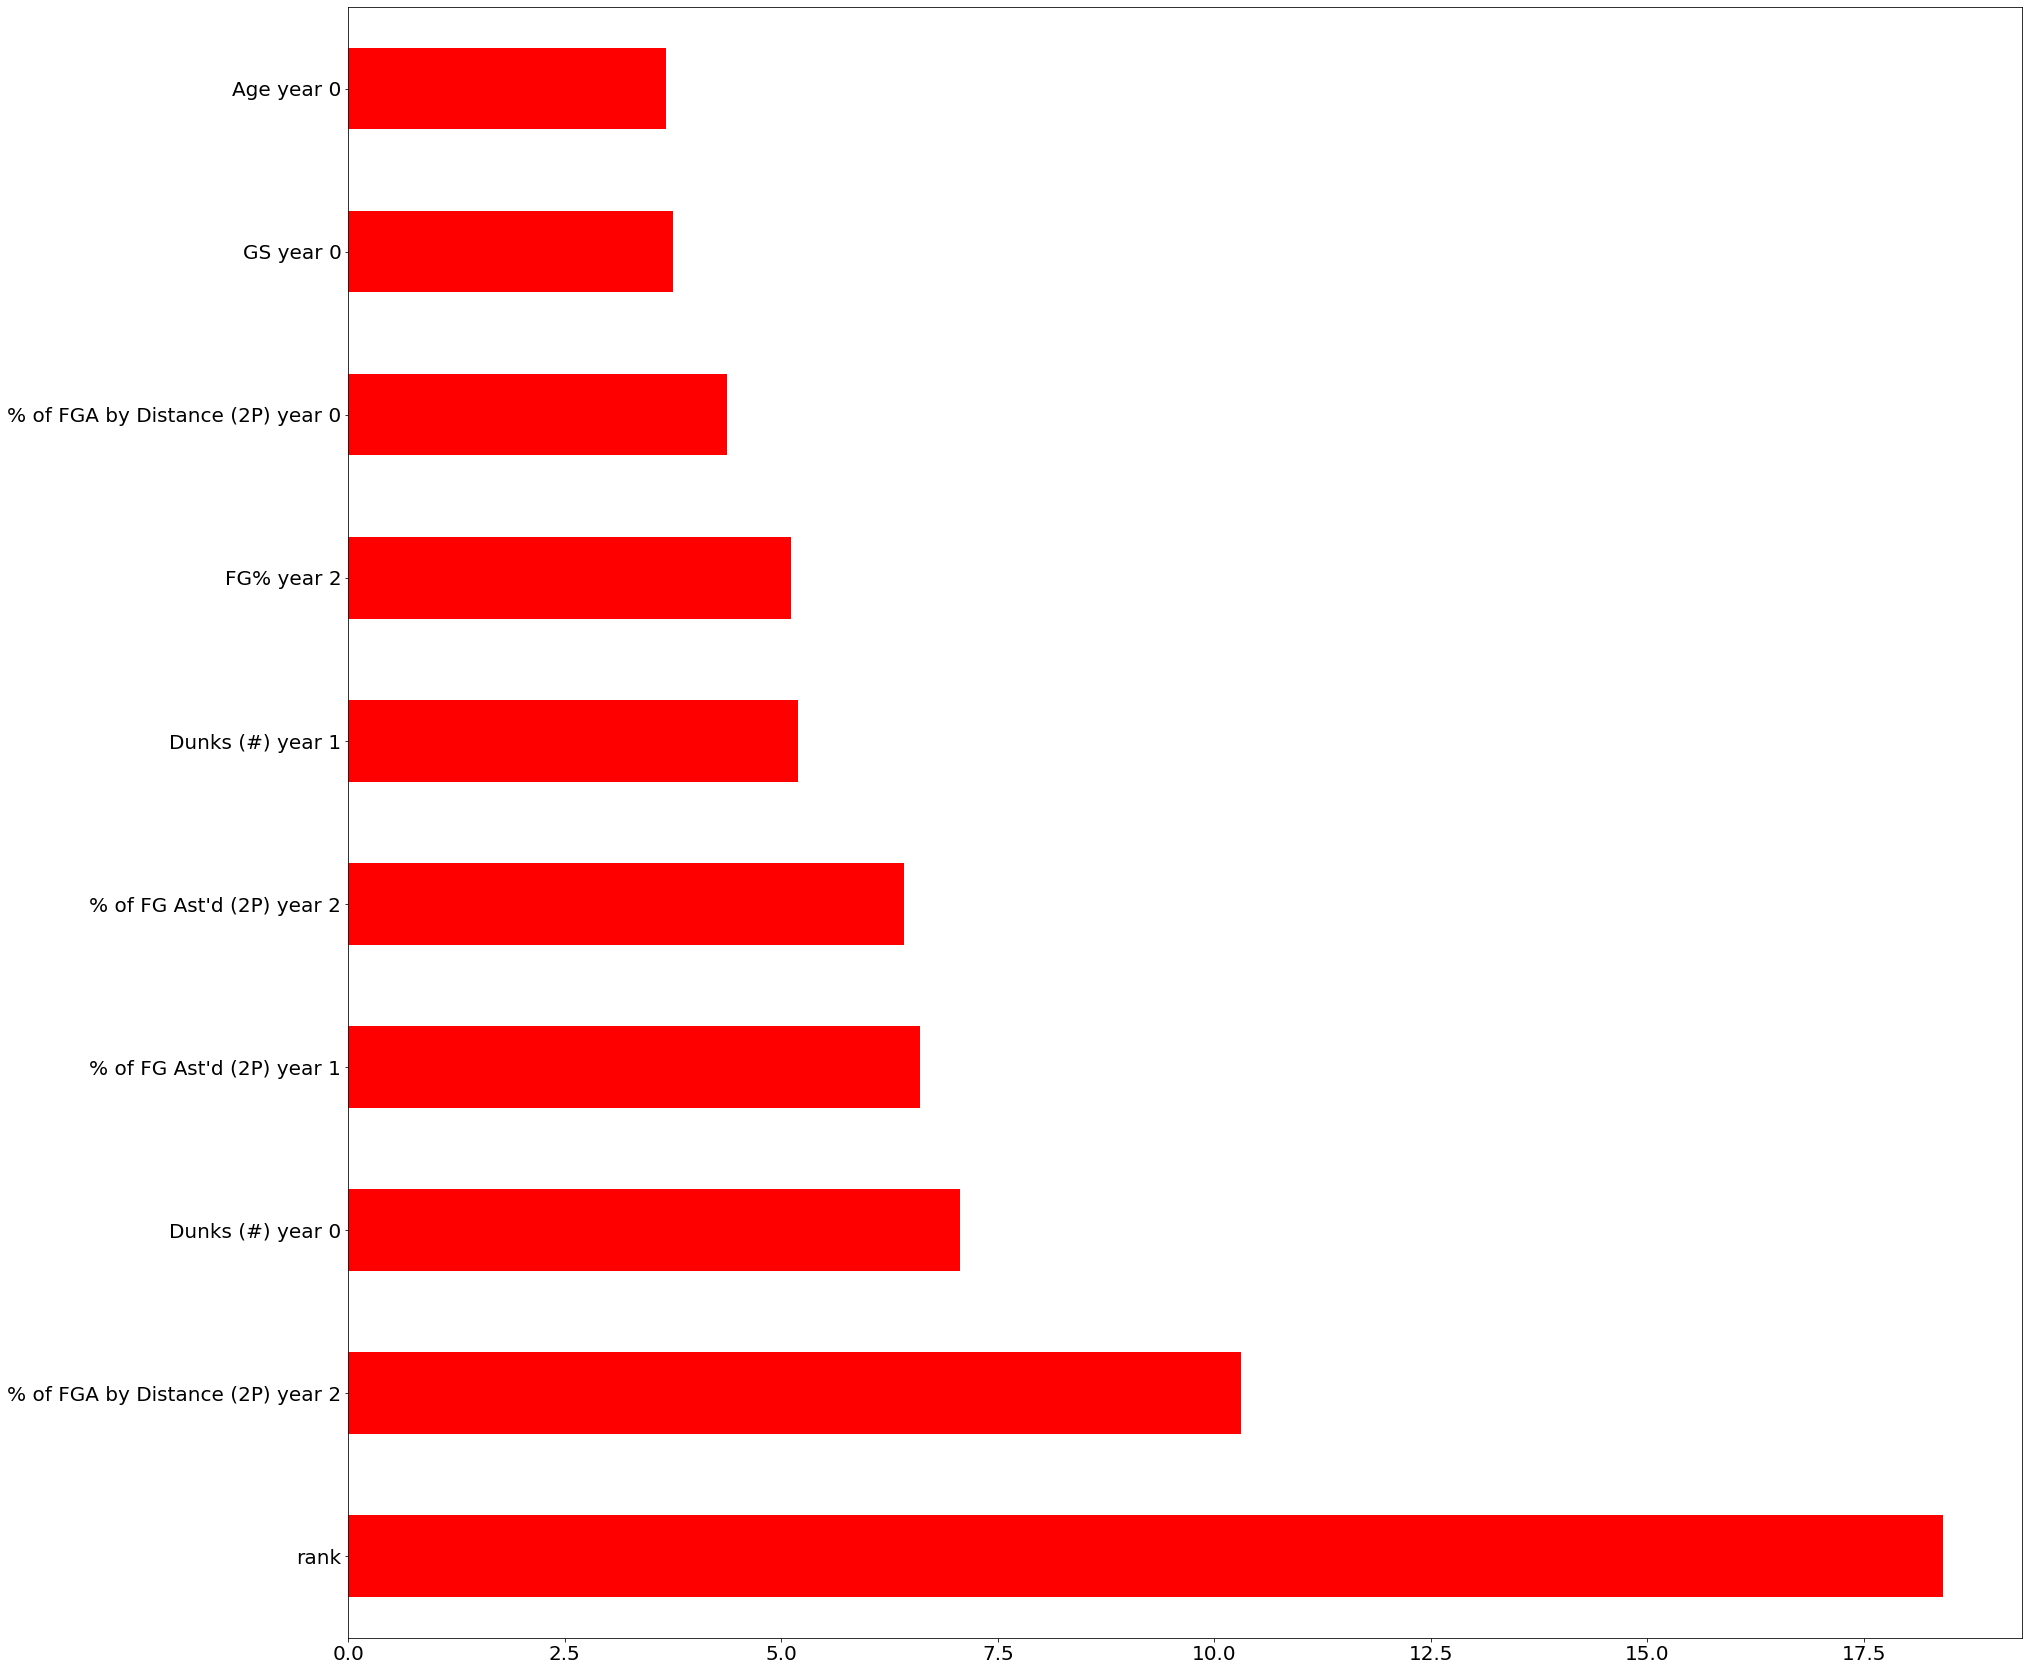

Boosting RMSE on Validation Data Boosting Regressor: 9691374.667508157
---
Boosting with 200 estimators and learning rate of 0.01


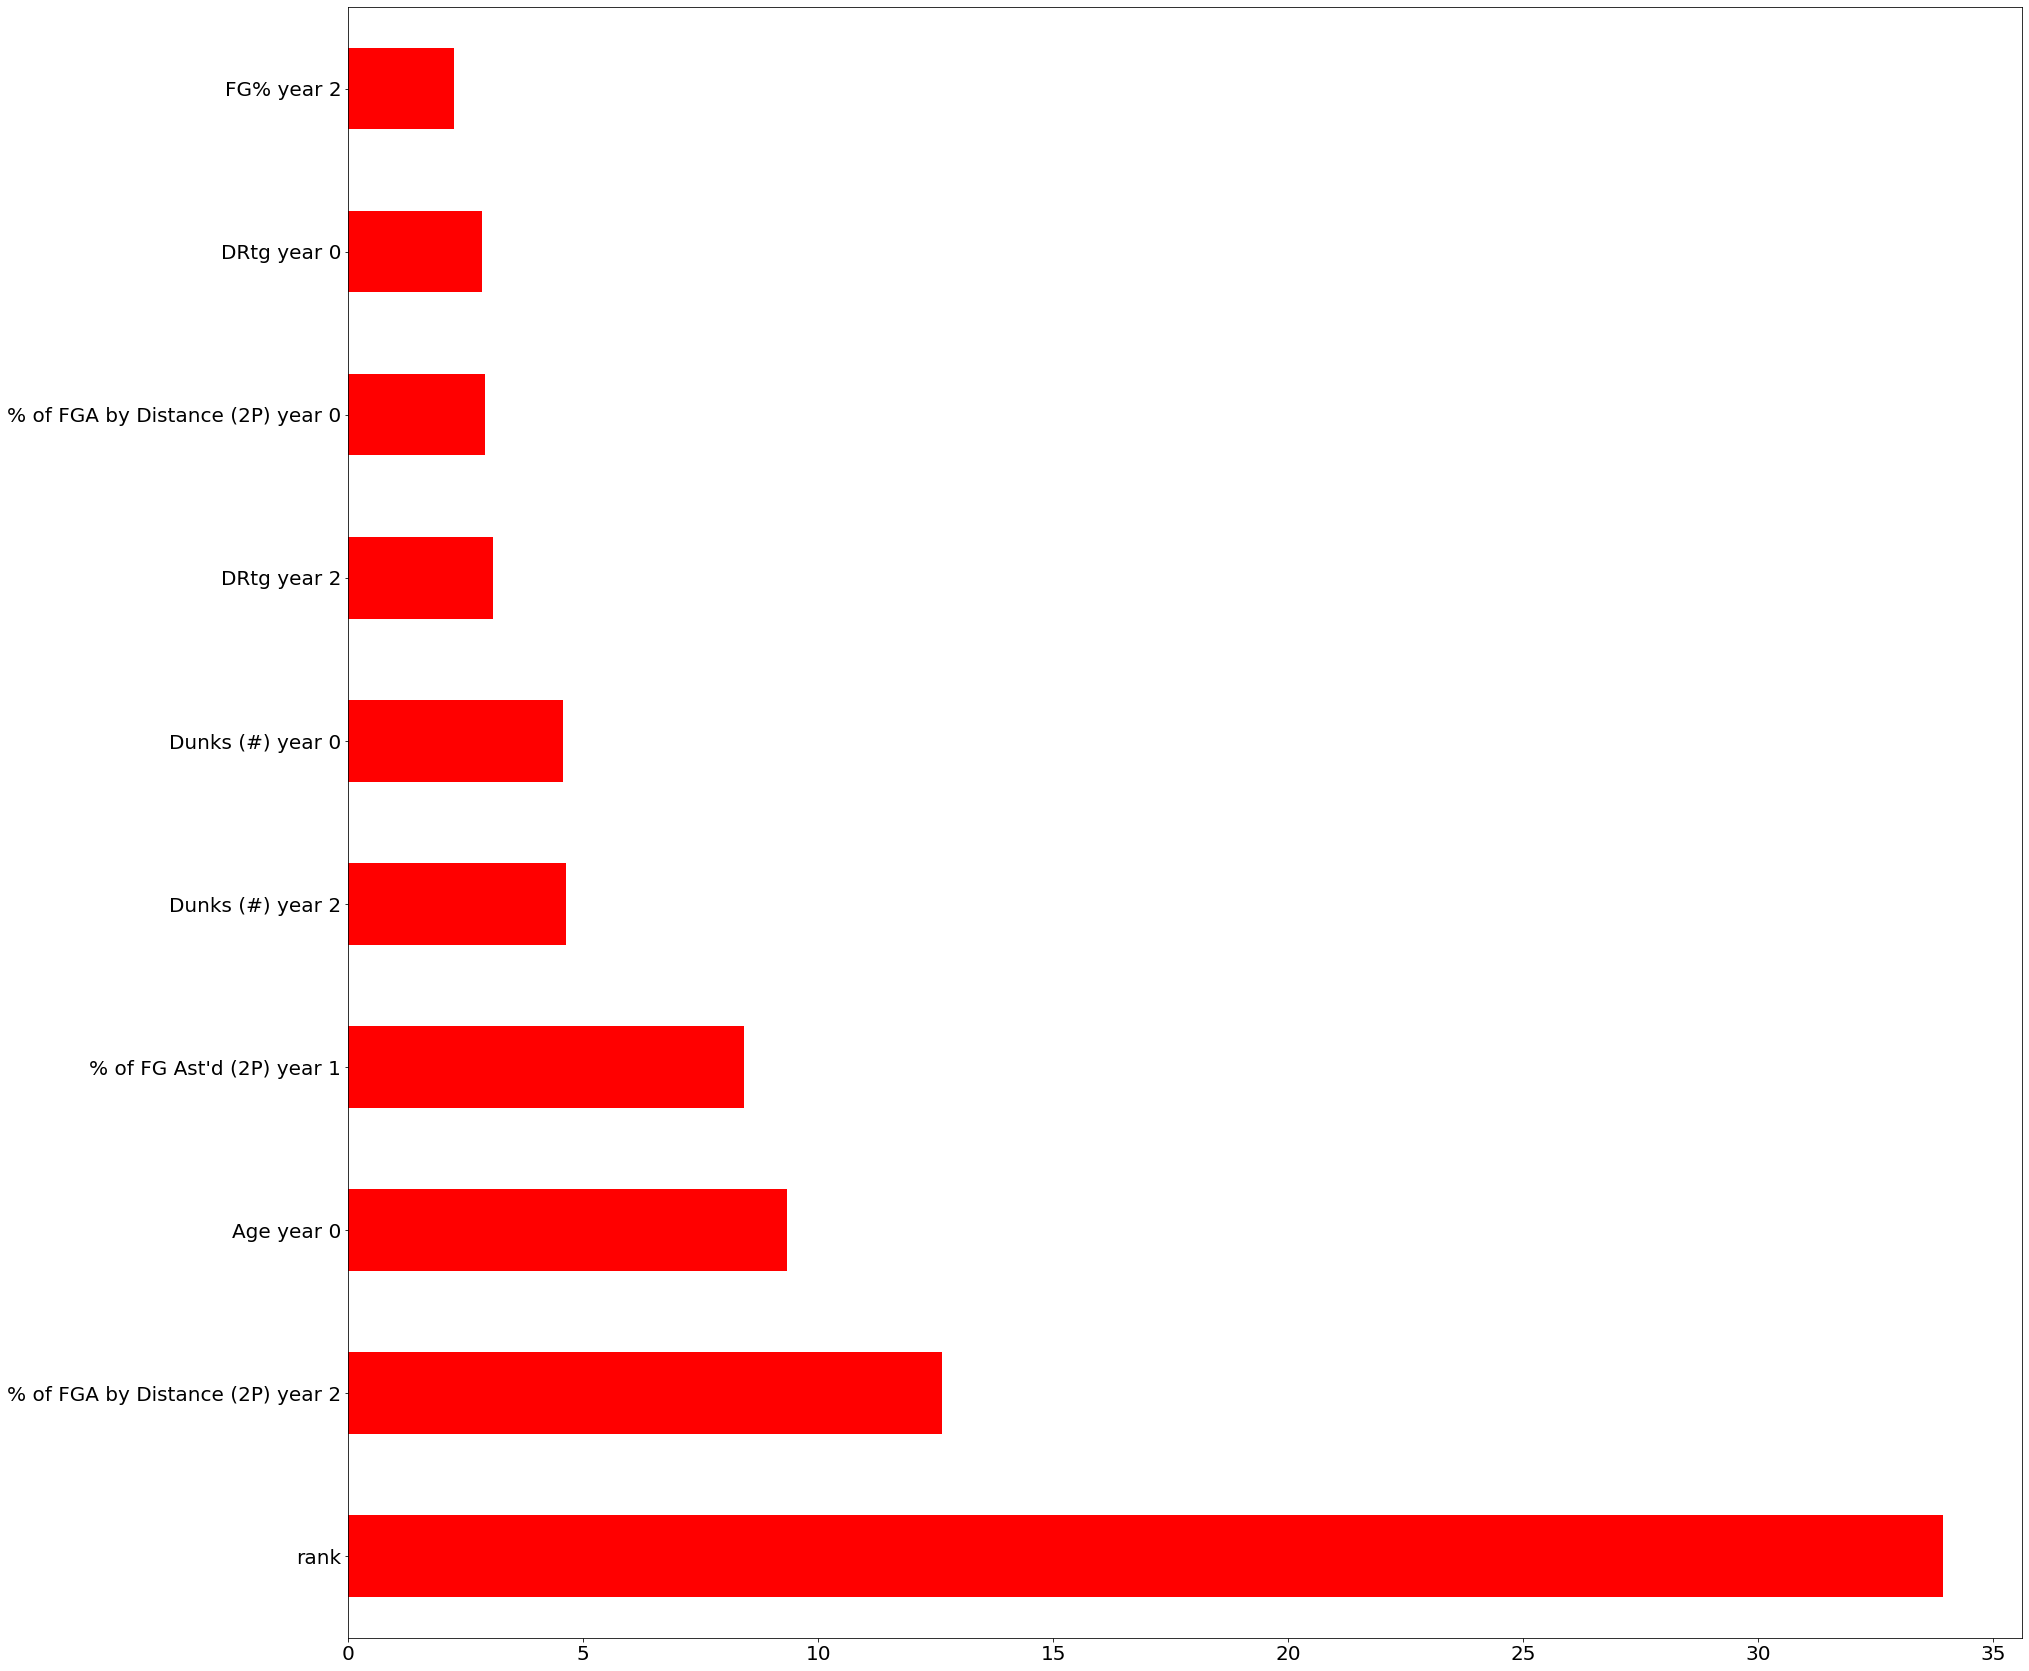

Boosting RMSE on Validation Data Boosting Regressor: 7191727.608682604
---
Boosting with 200 estimators and learning rate of 0.1


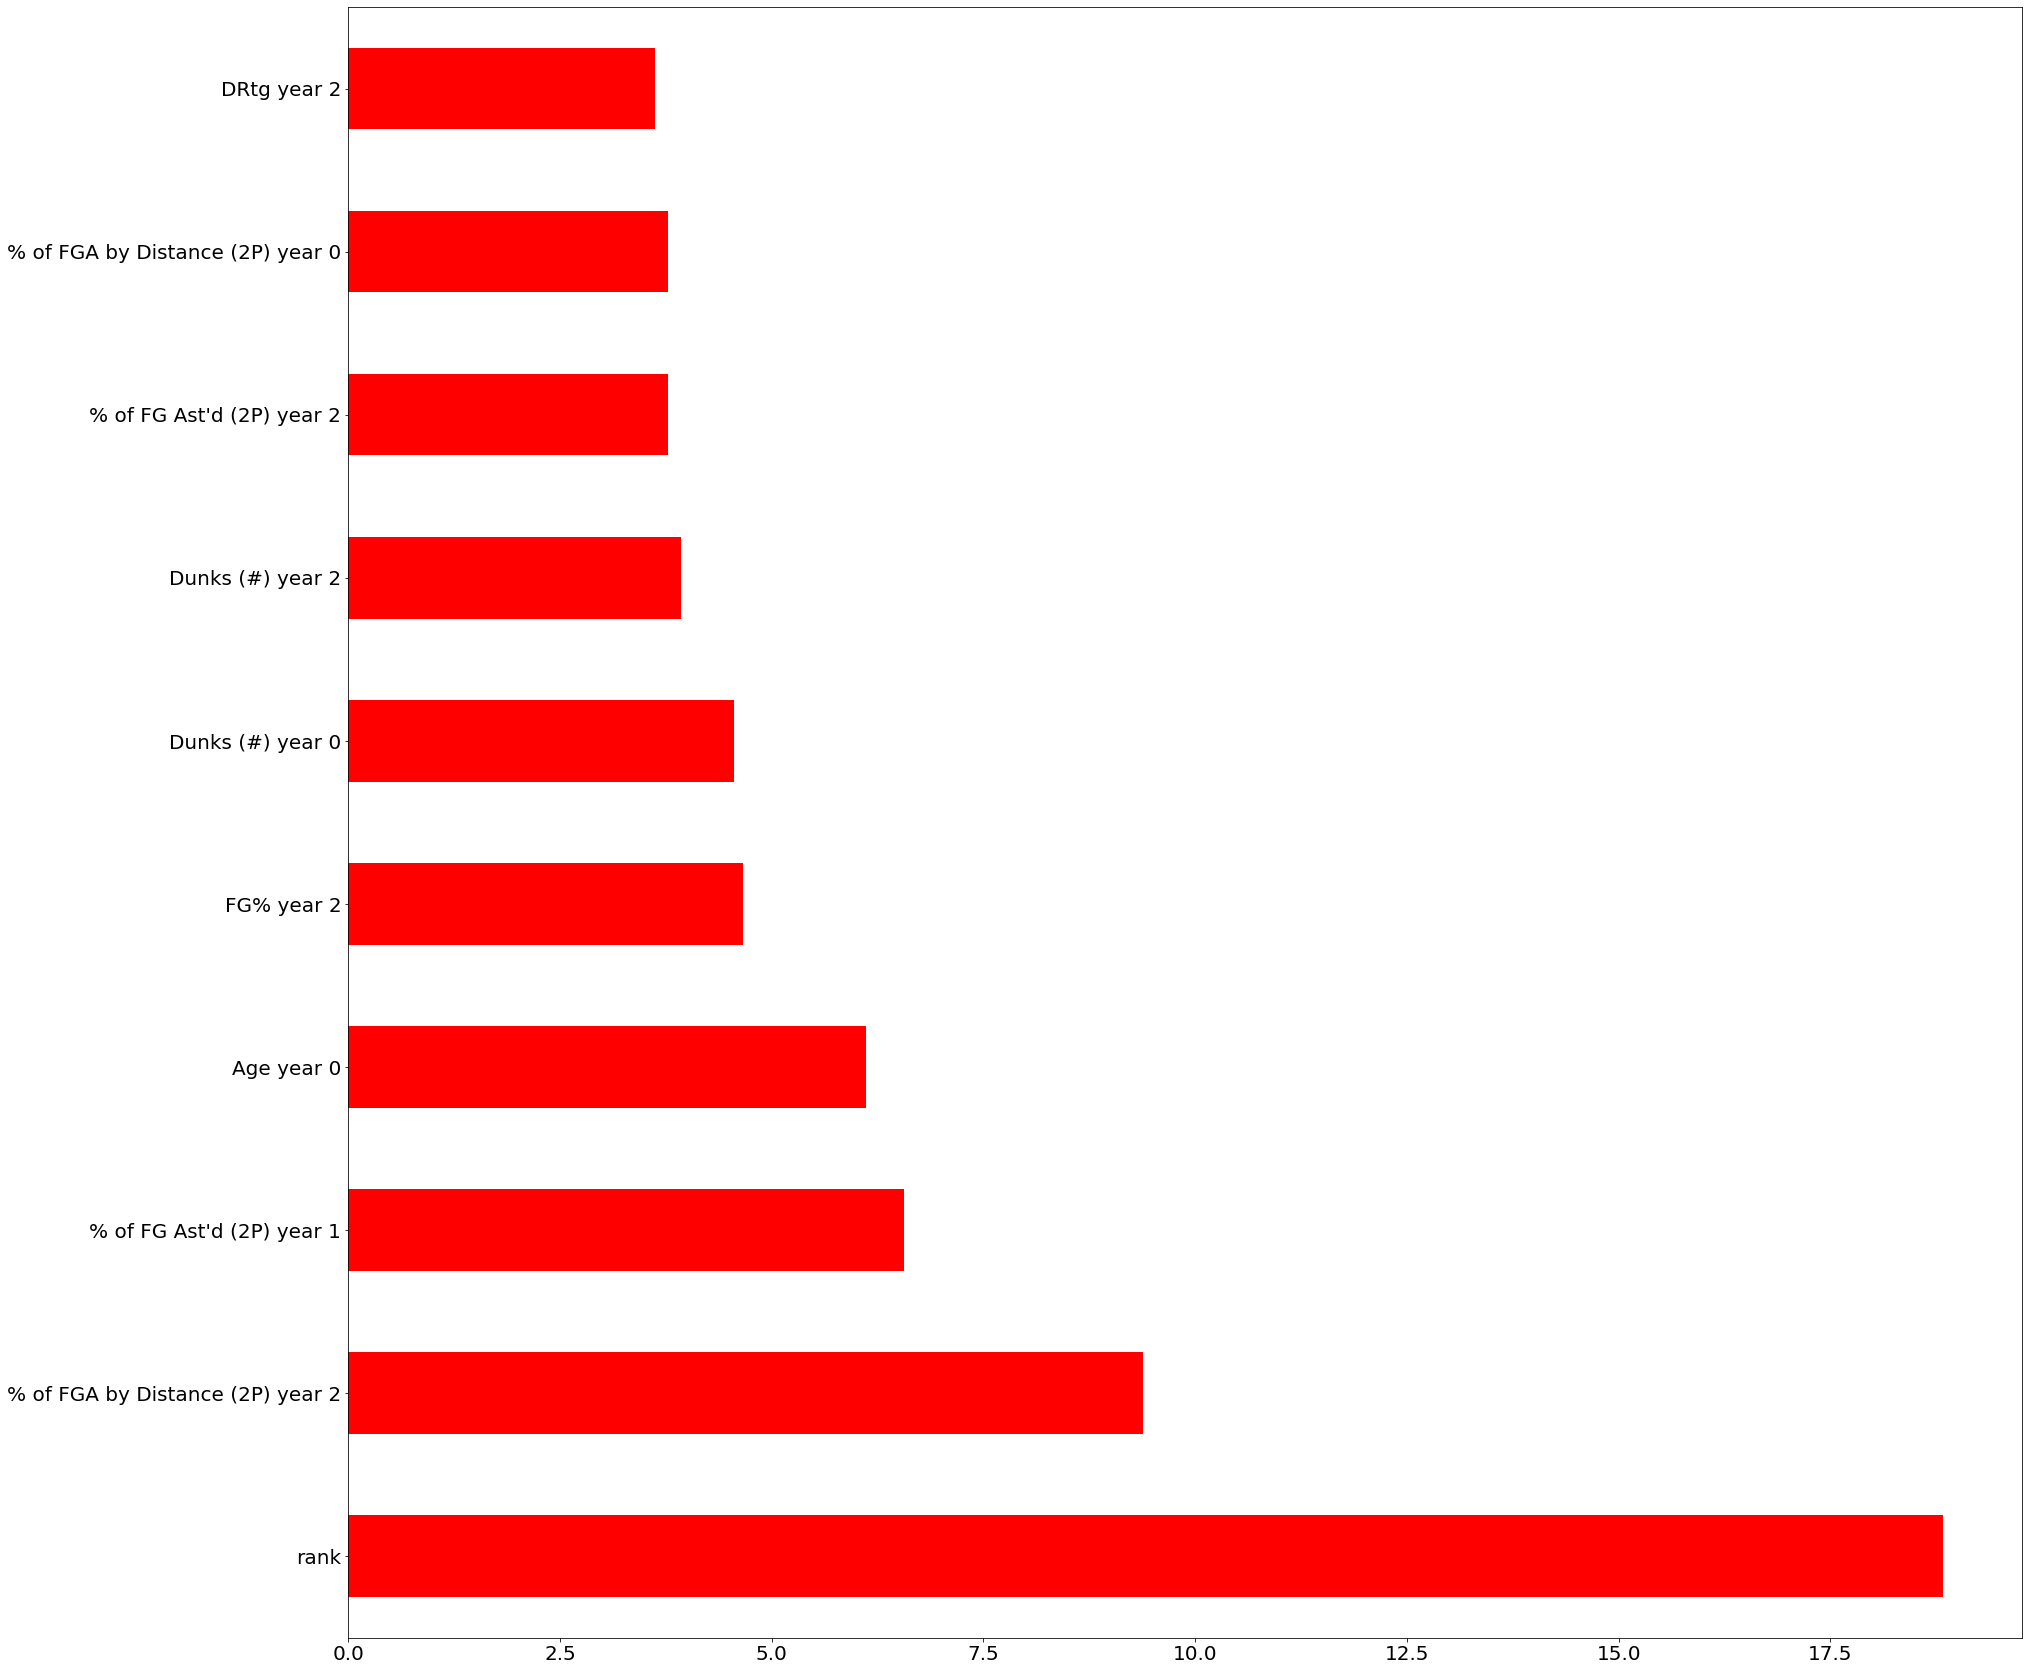

Boosting RMSE on Validation Data Boosting Regressor: 7594550.996510596
---
Boosting with 200 estimators and learning rate of 1


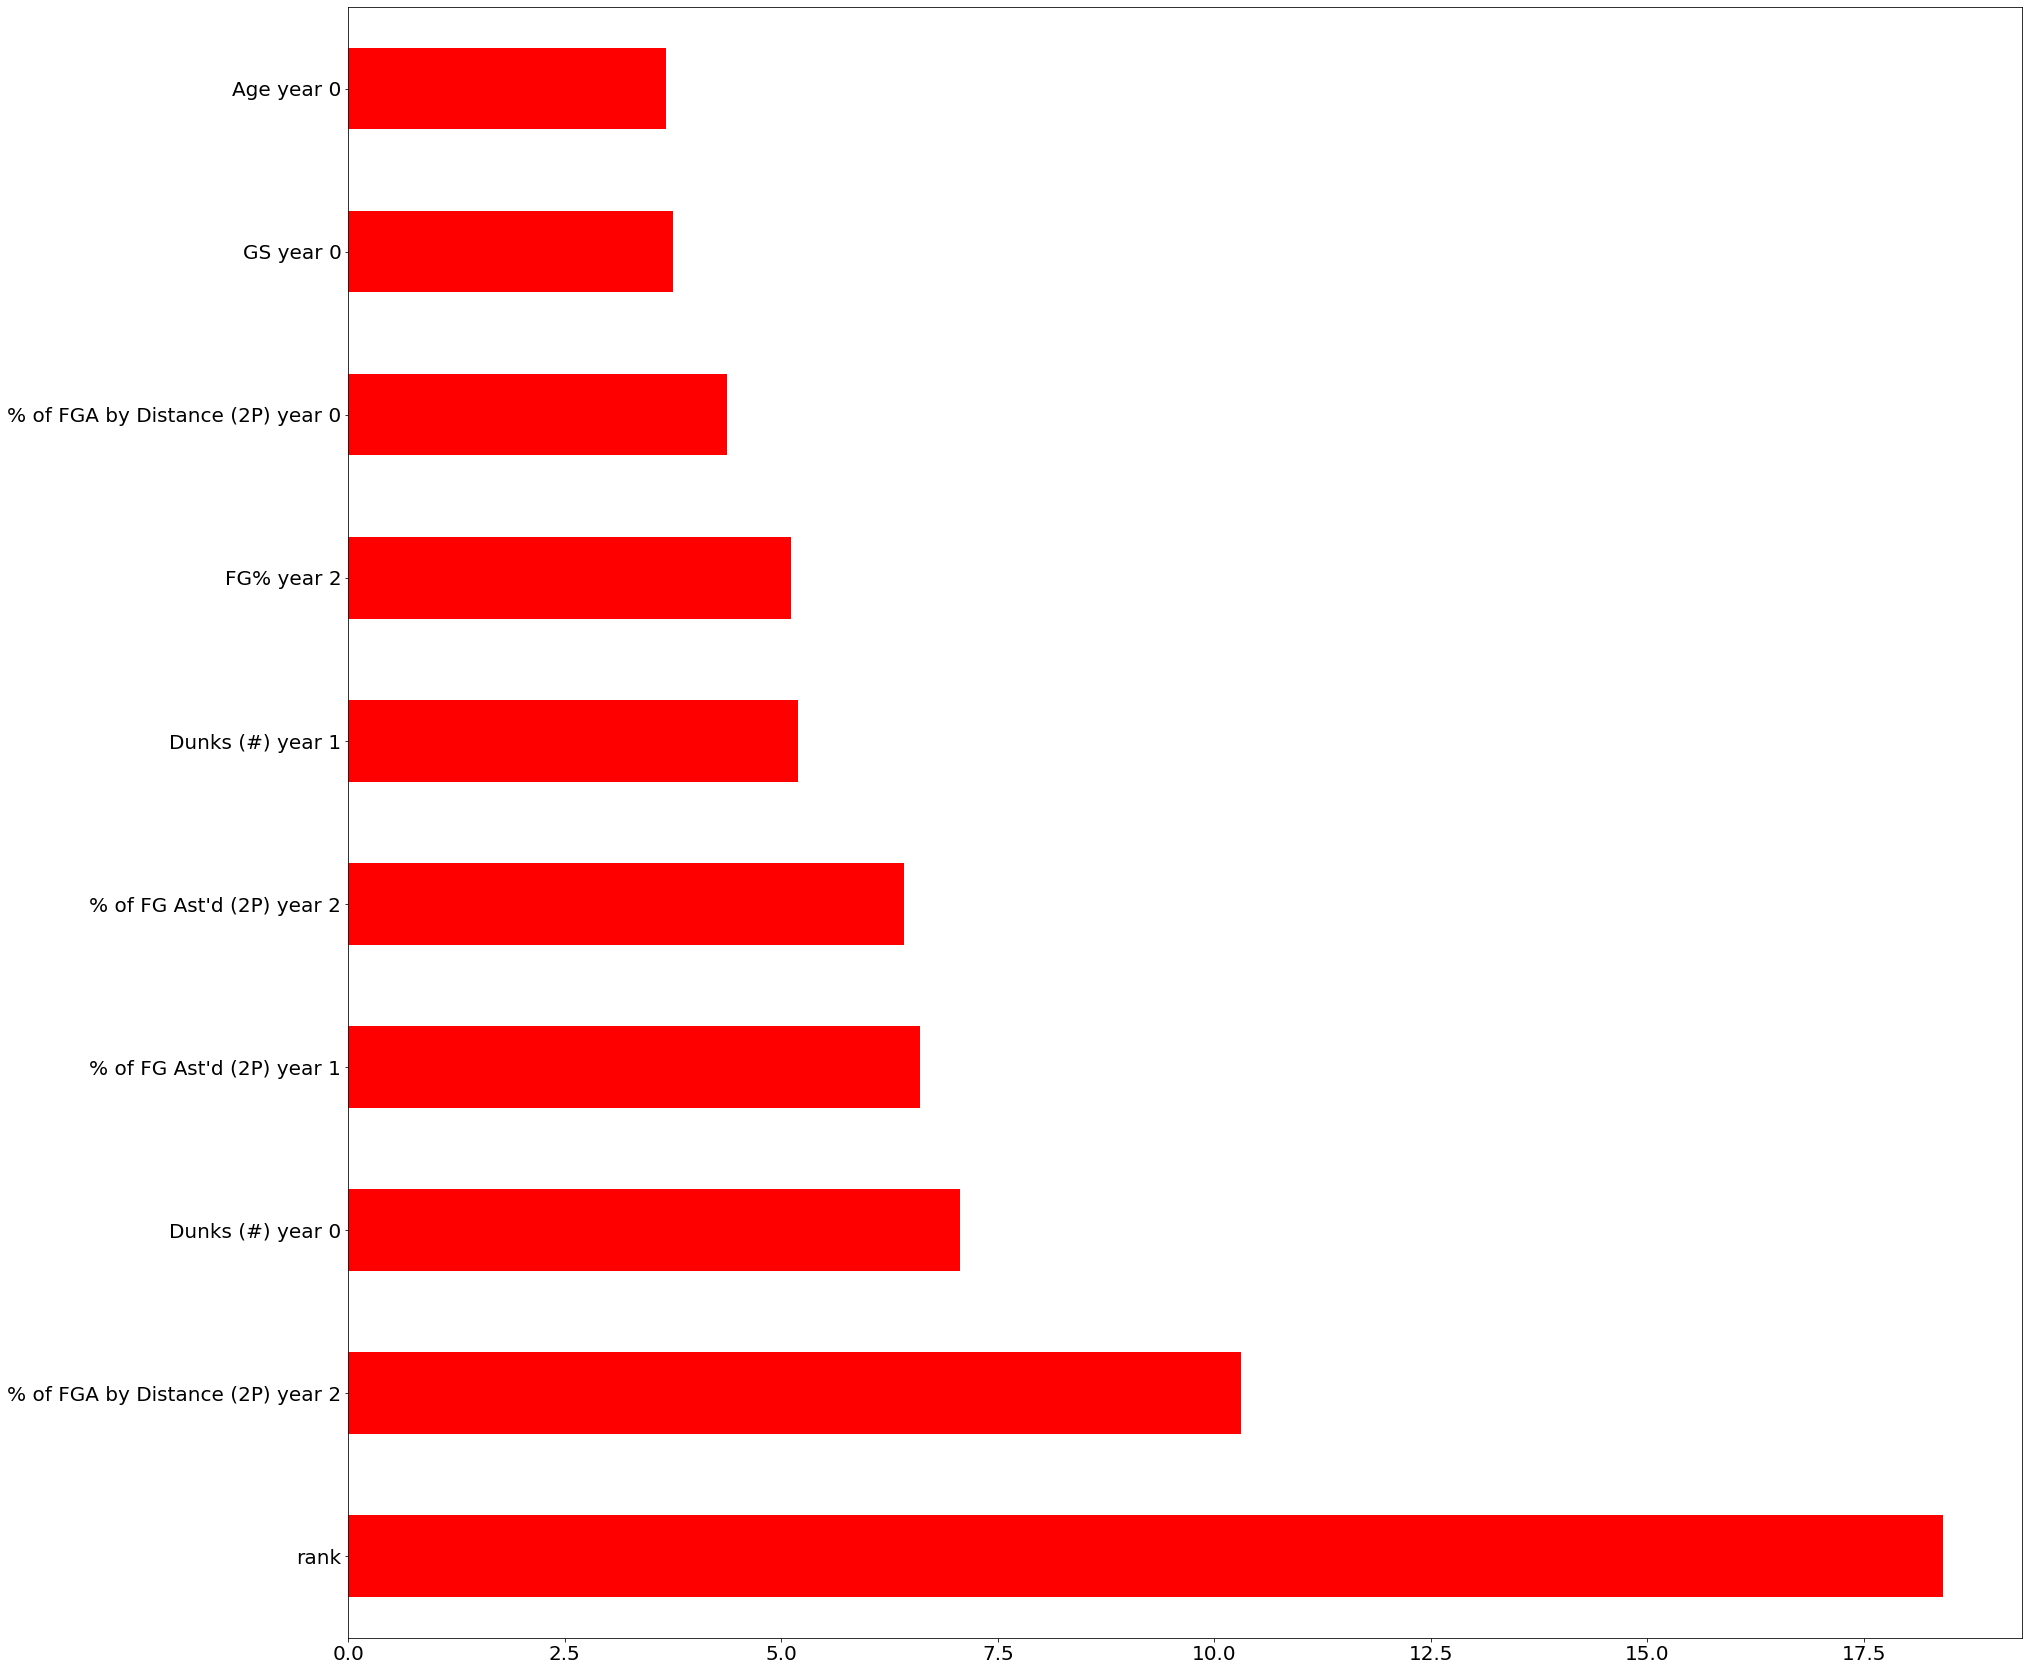

Boosting RMSE on Validation Data Boosting Regressor: 9681735.681582896
---
Boosting with 400 estimators and learning rate of 0.01


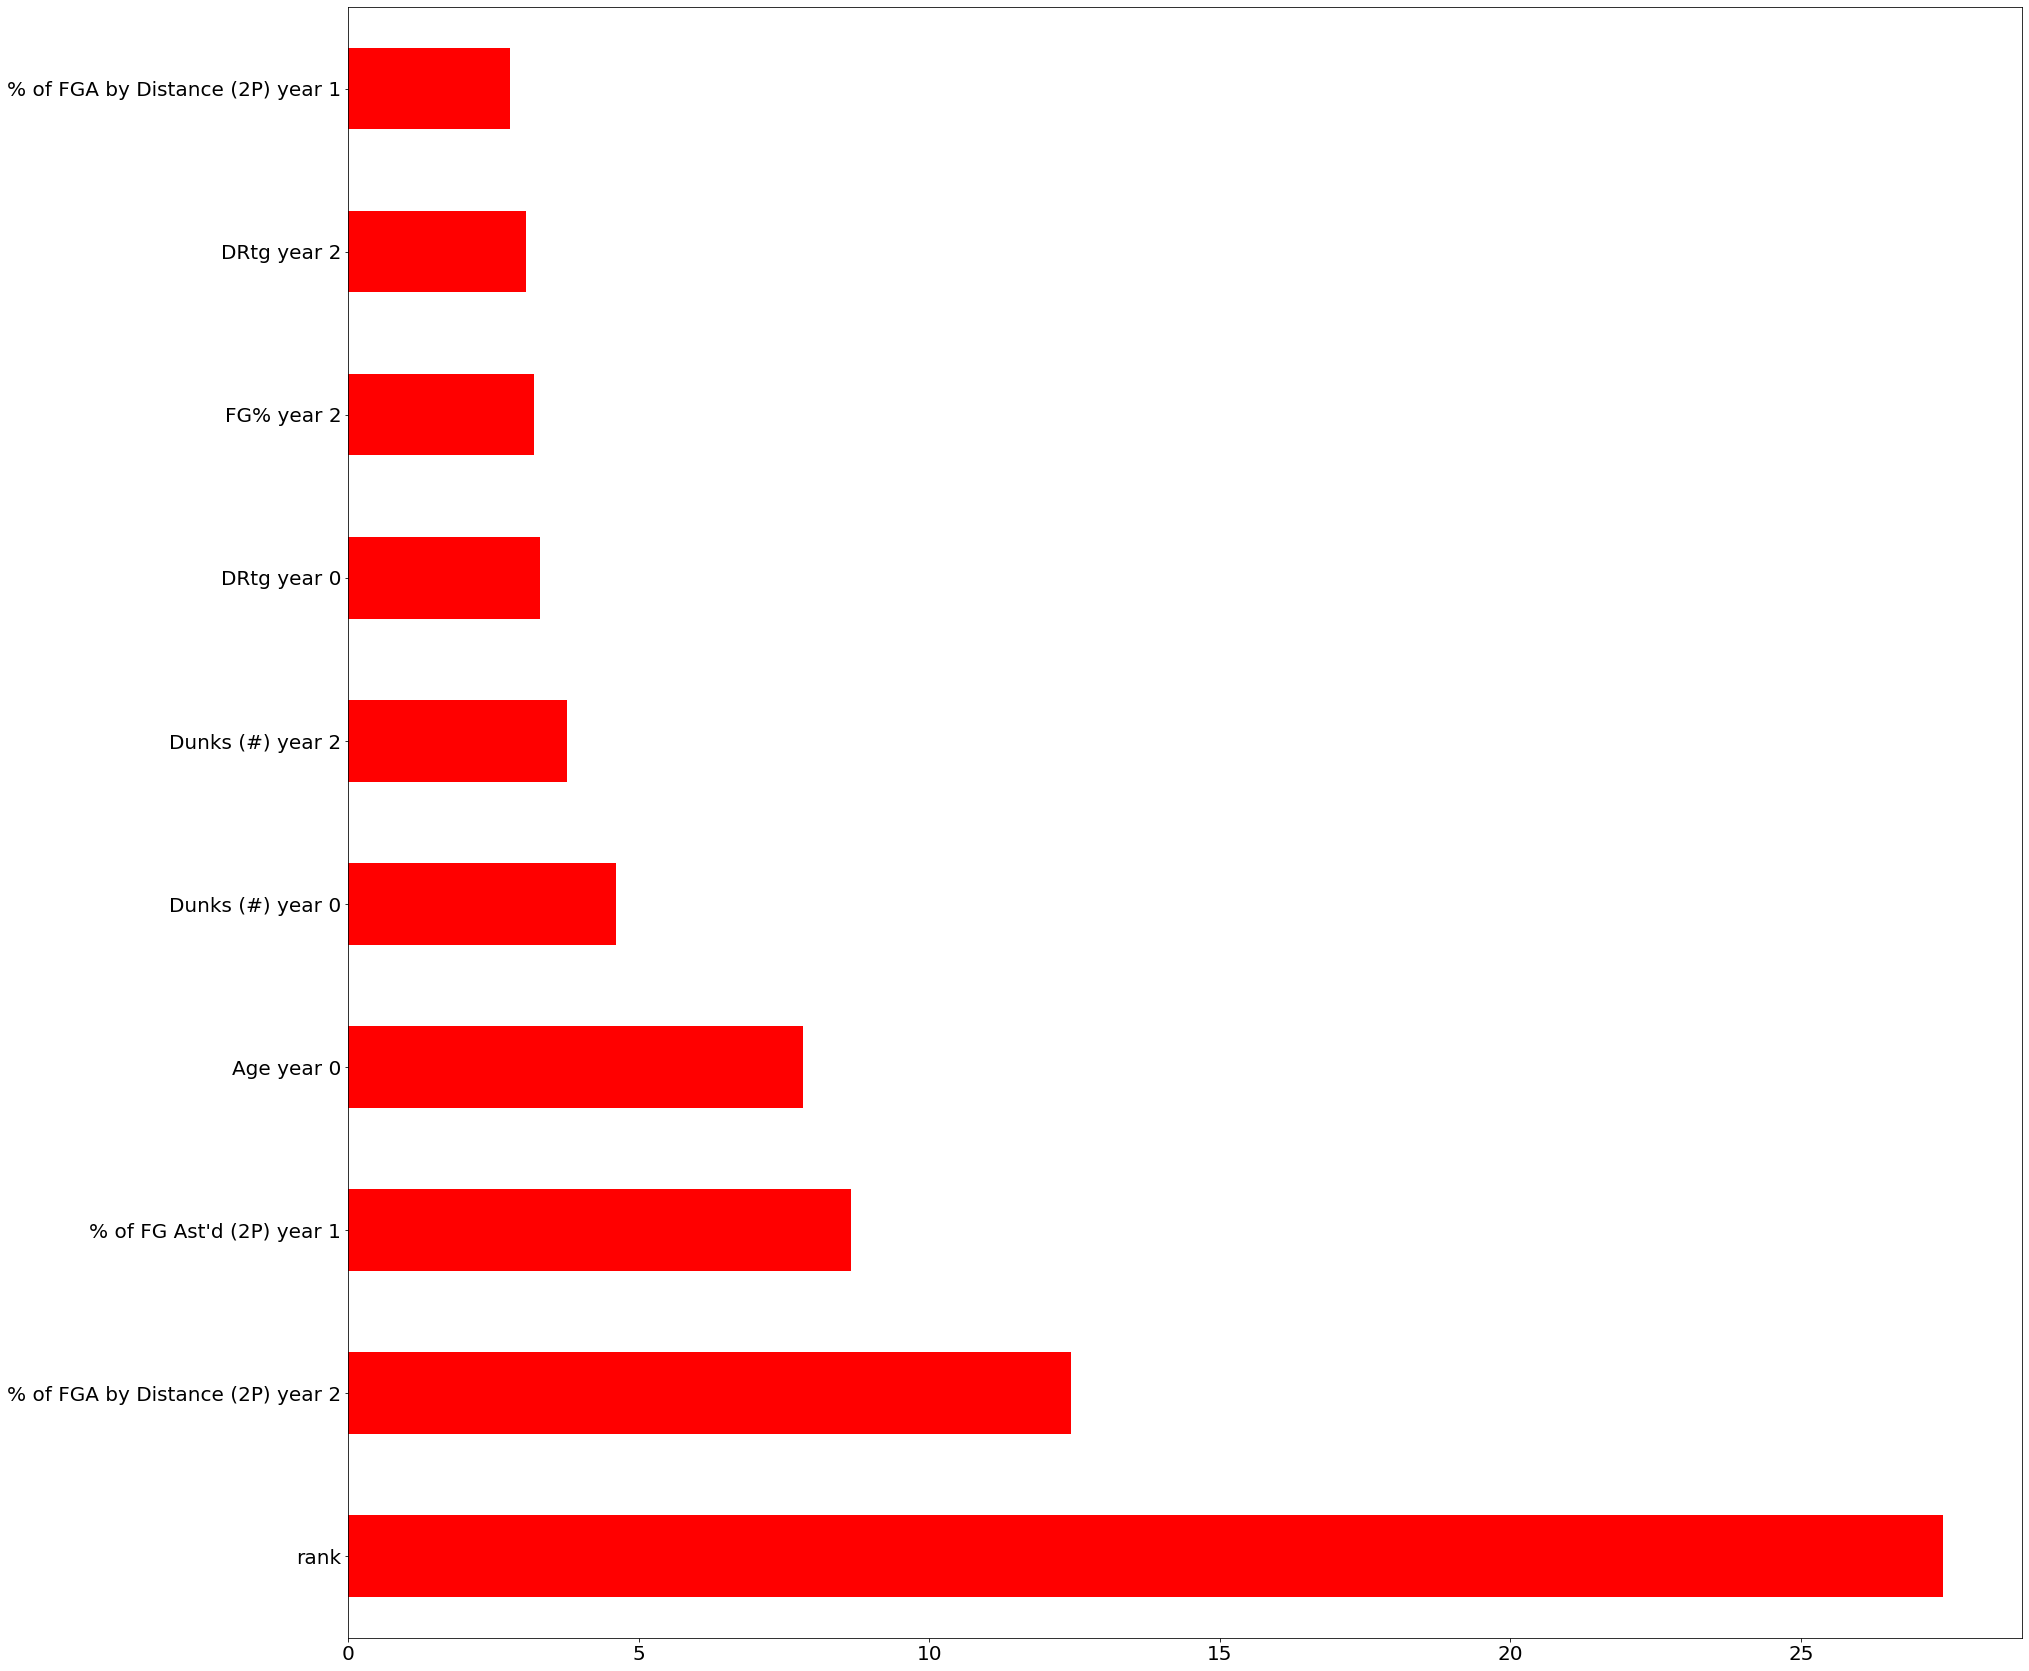

Boosting RMSE on Validation Data Boosting Regressor: 7119715.087713115
---
Boosting with 400 estimators and learning rate of 0.1


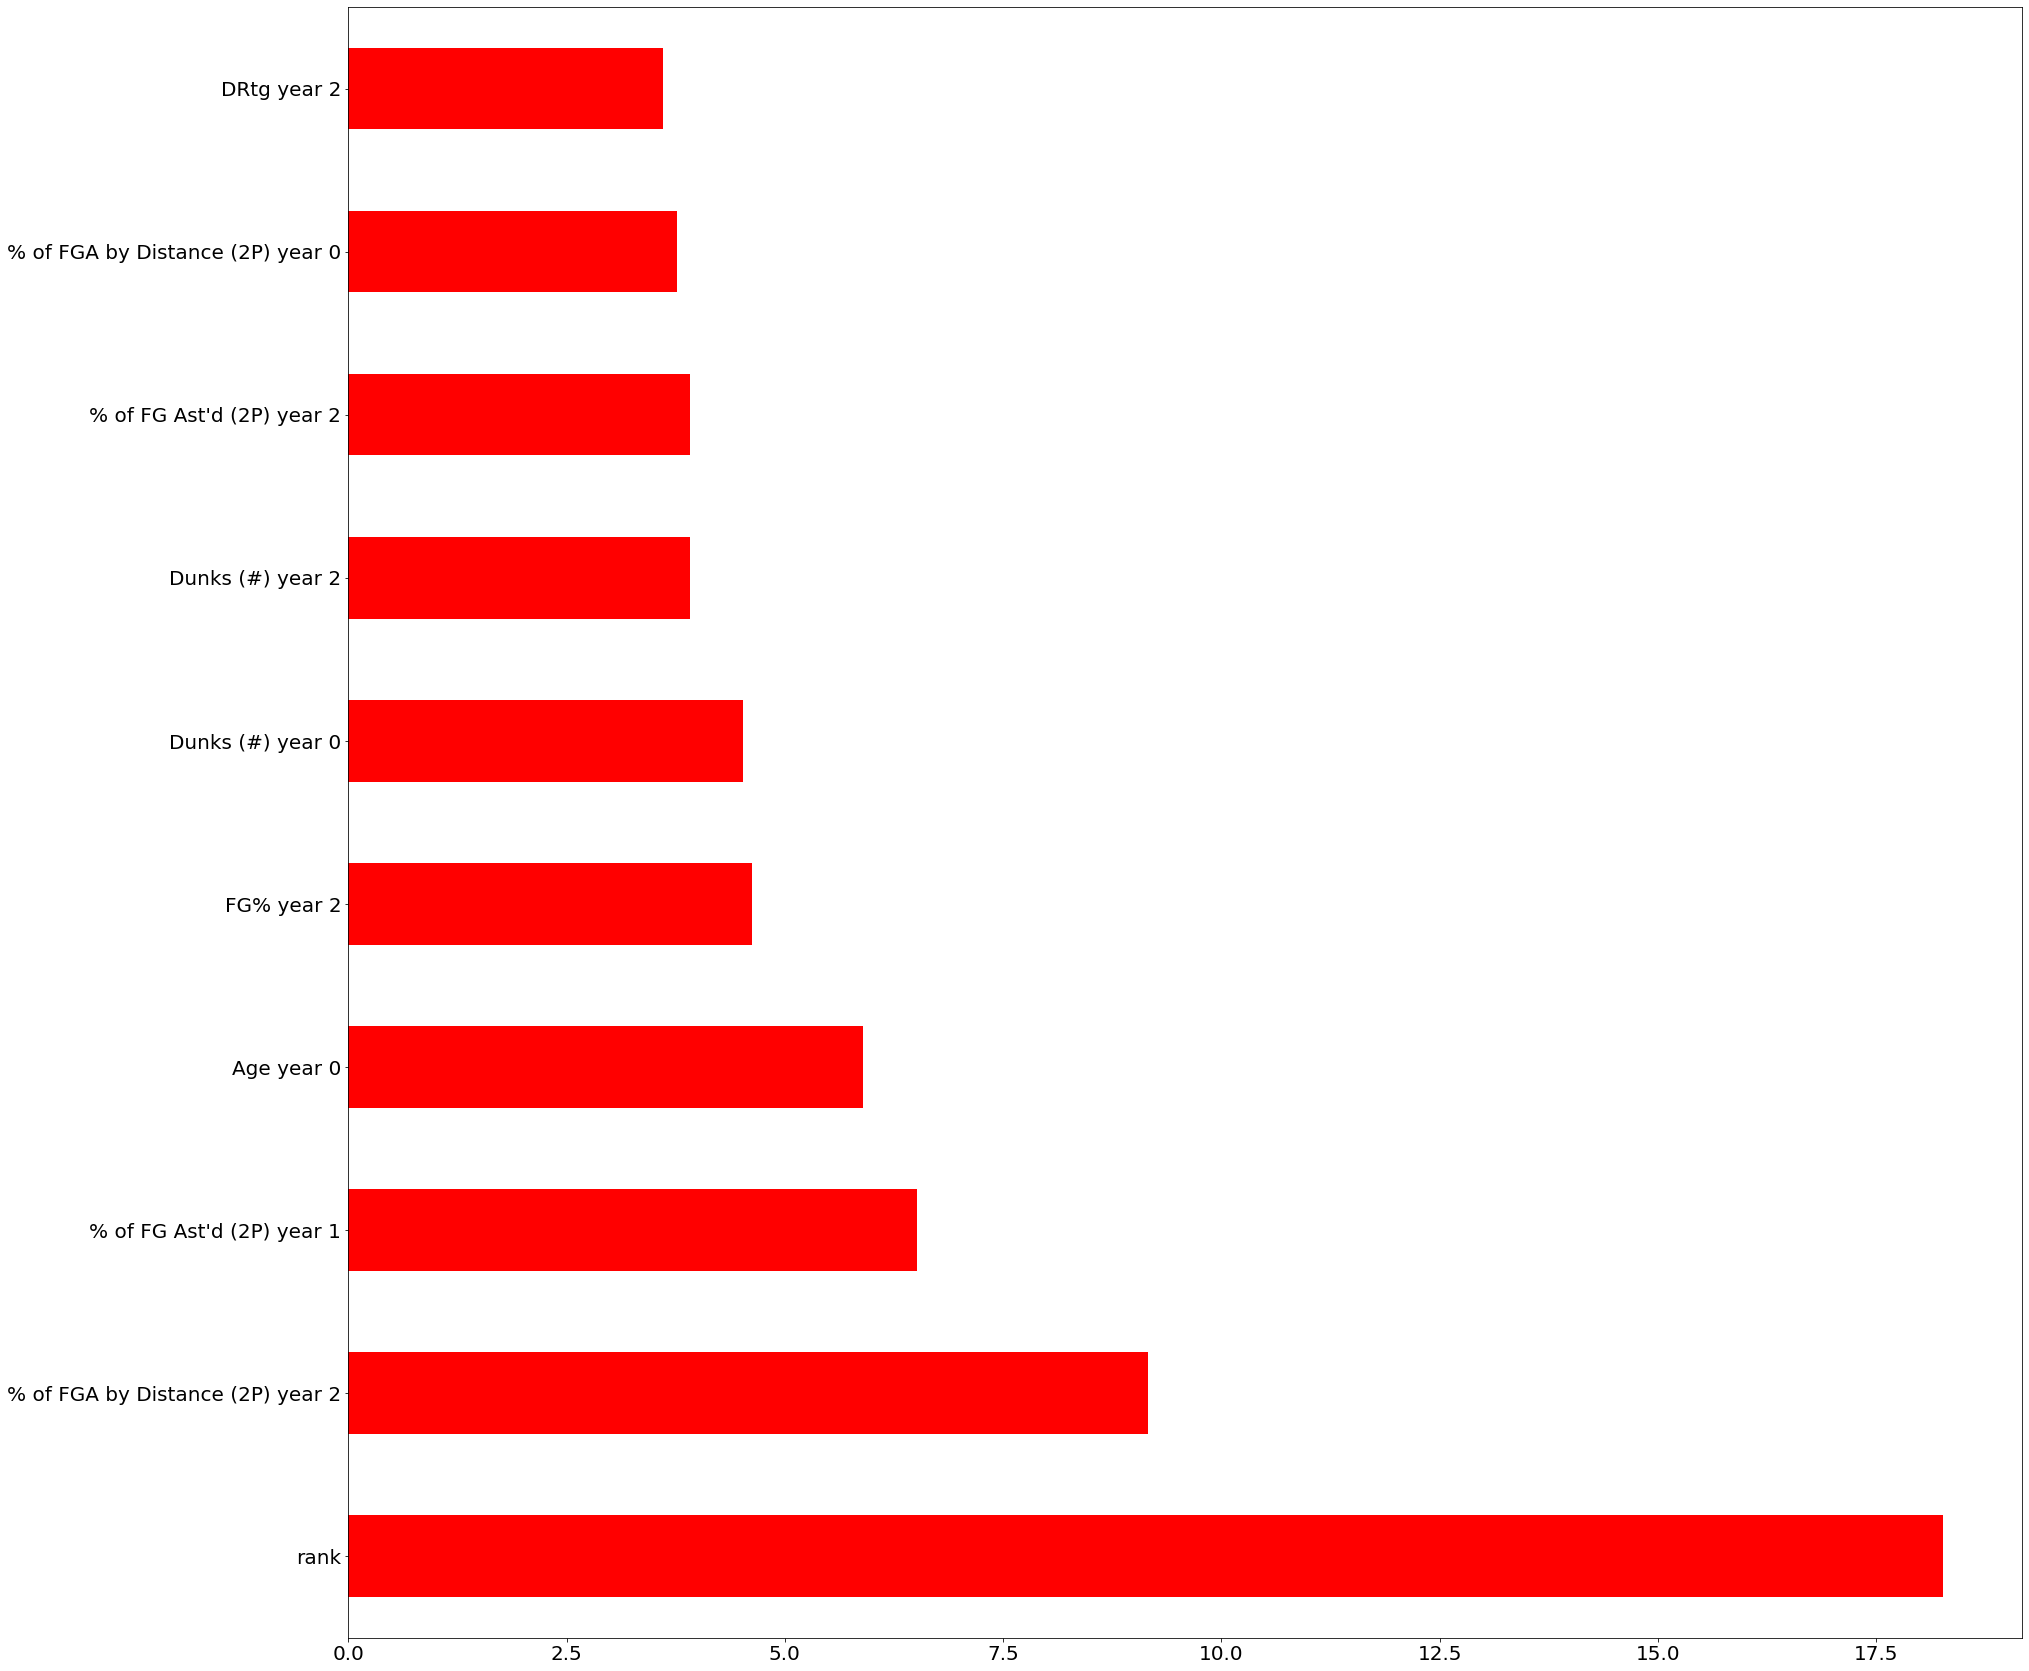

Boosting RMSE on Validation Data Boosting Regressor: 7905231.257847925
---
Boosting with 400 estimators and learning rate of 1


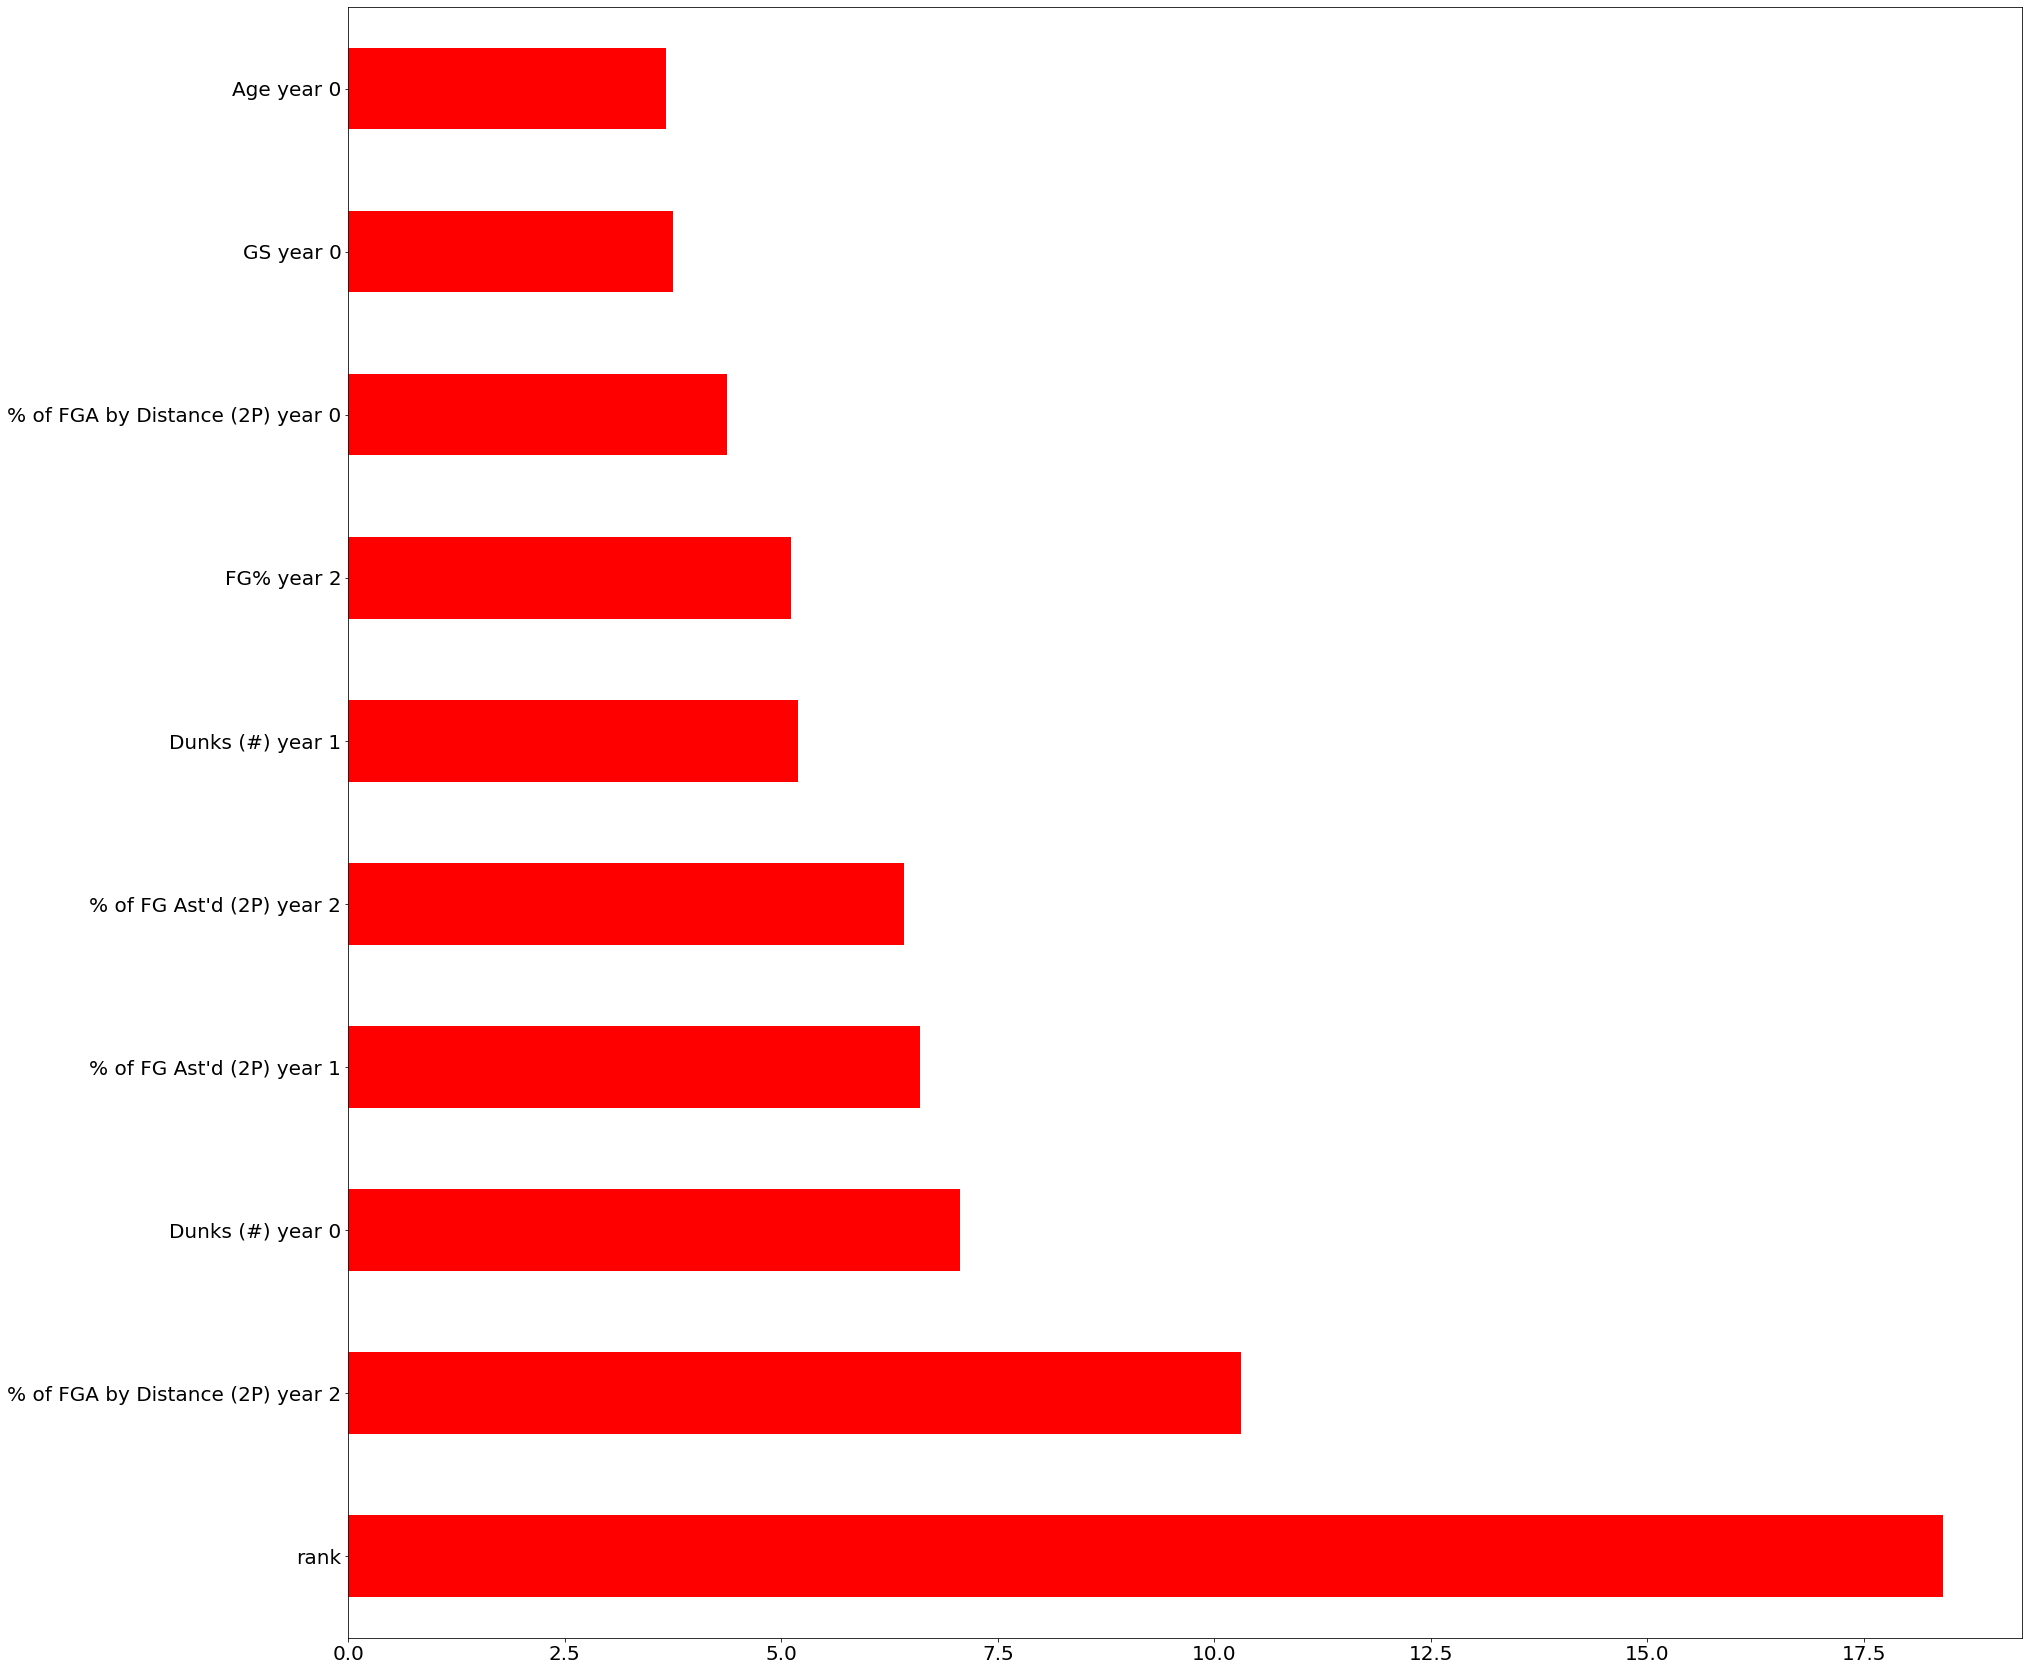

Boosting RMSE on Validation Data Boosting Regressor: 9681559.399371263
---
Boosting with 800 estimators and learning rate of 0.01


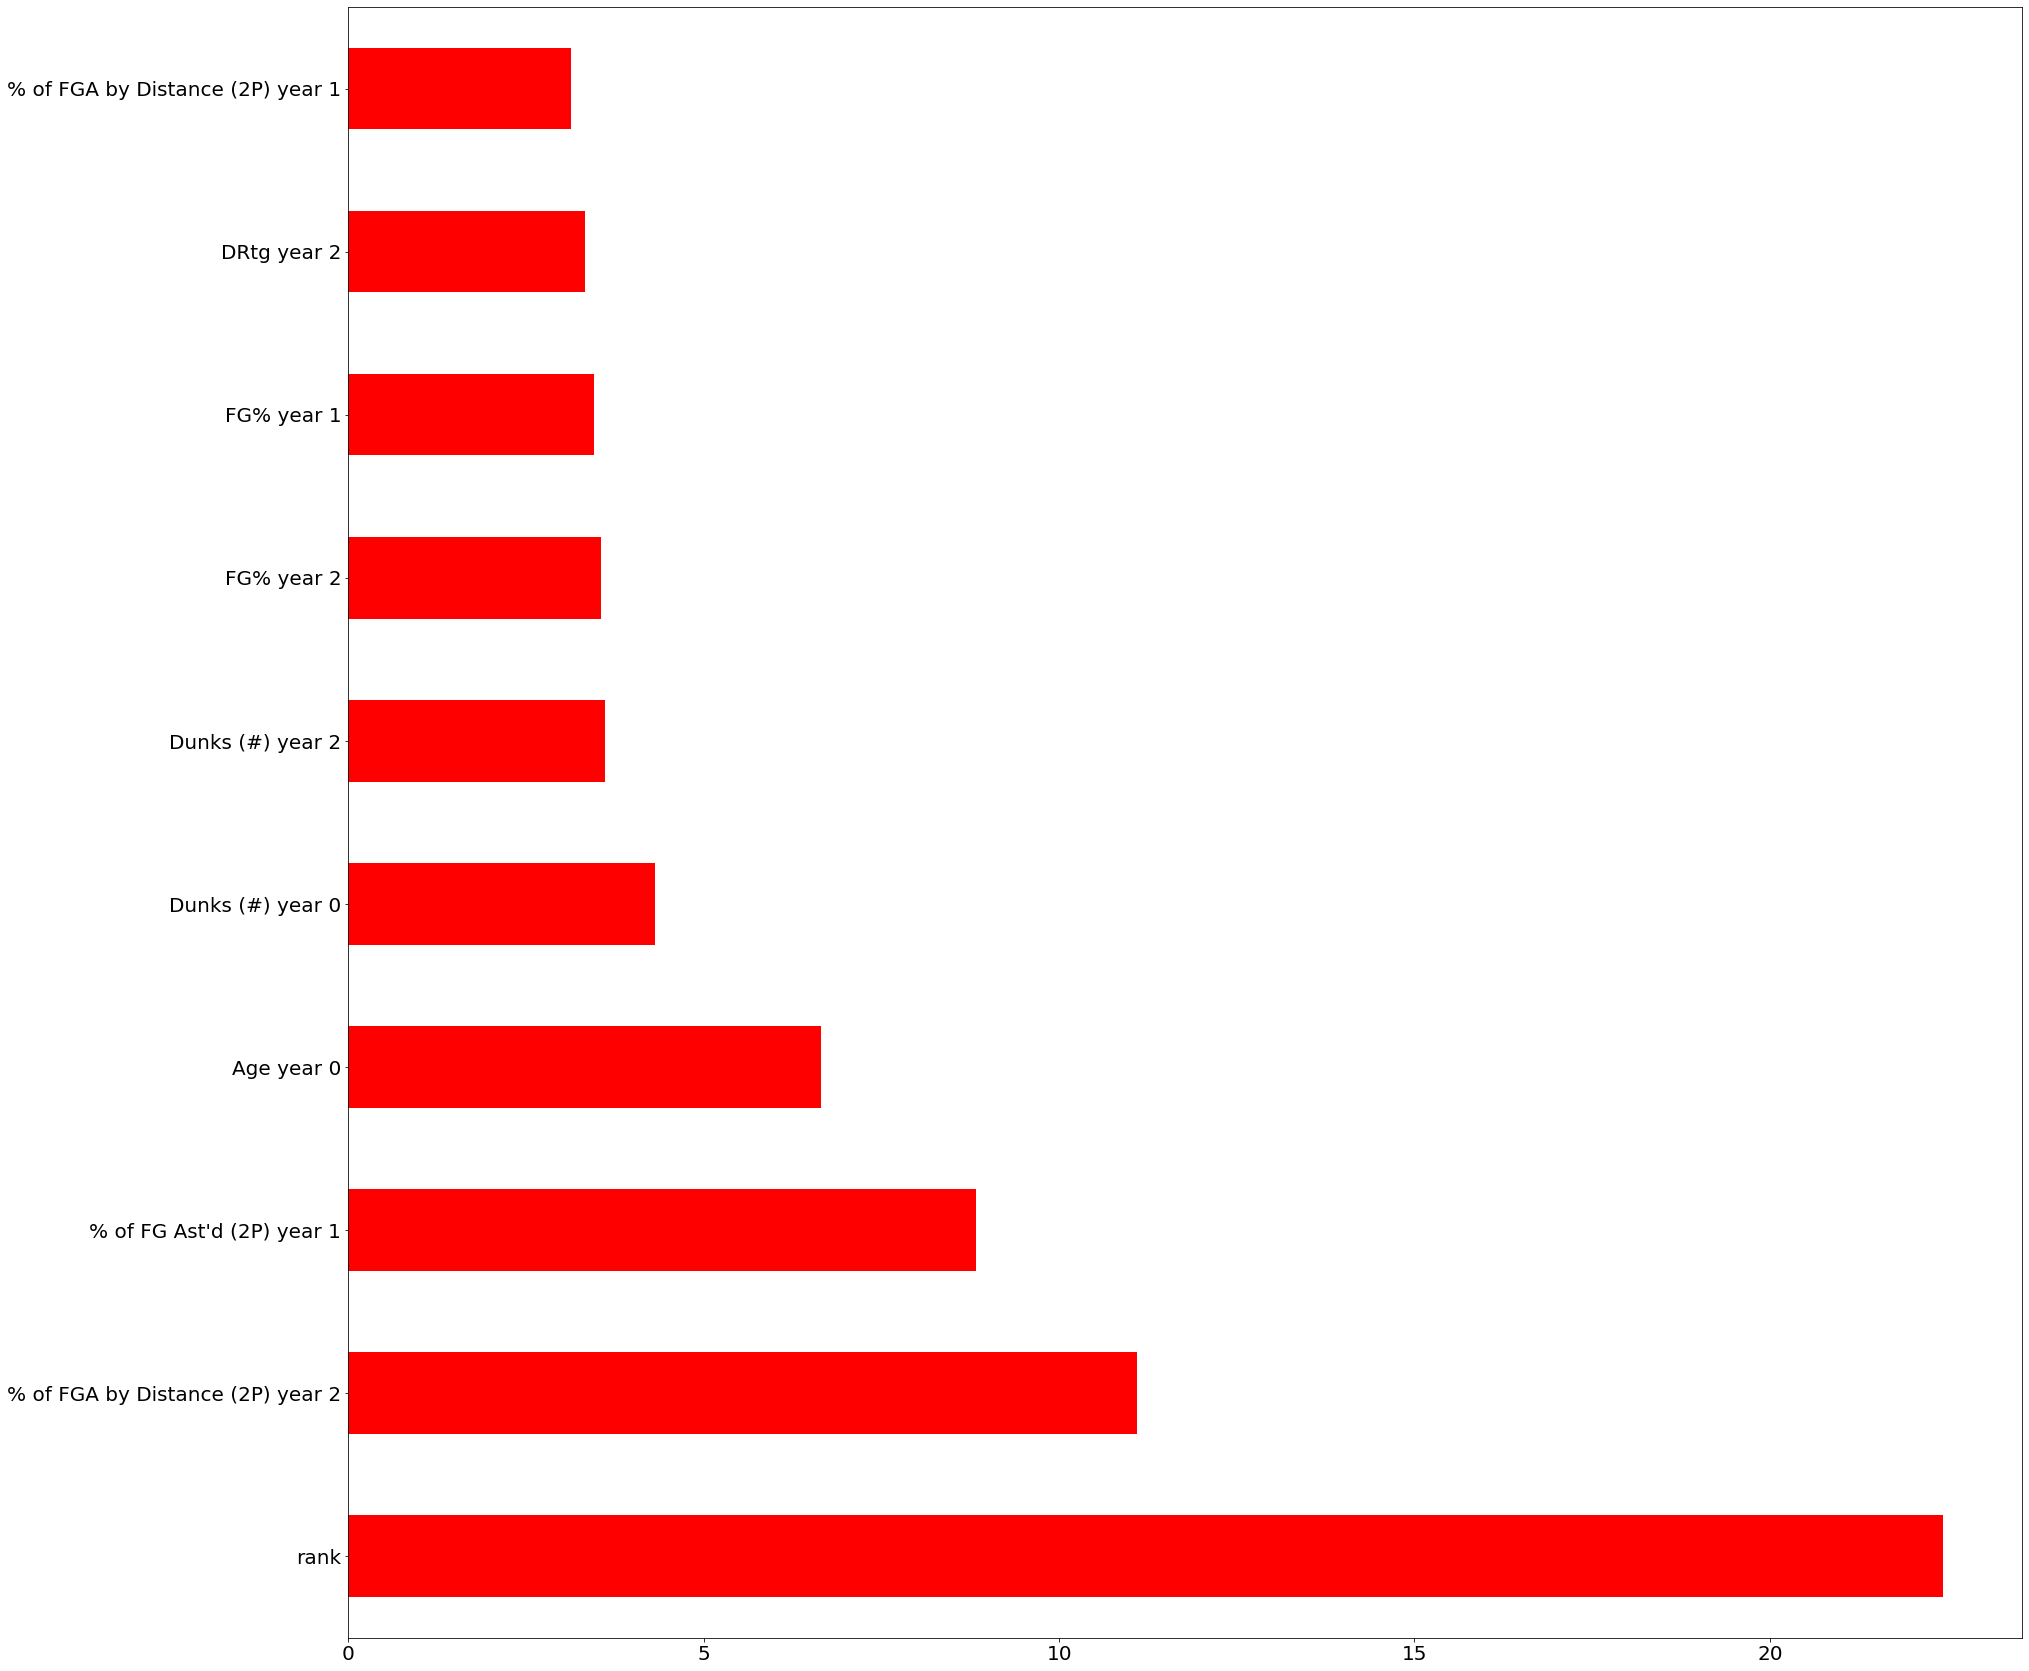

Boosting RMSE on Validation Data Boosting Regressor: 7229920.983821698
---
Boosting with 800 estimators and learning rate of 0.1


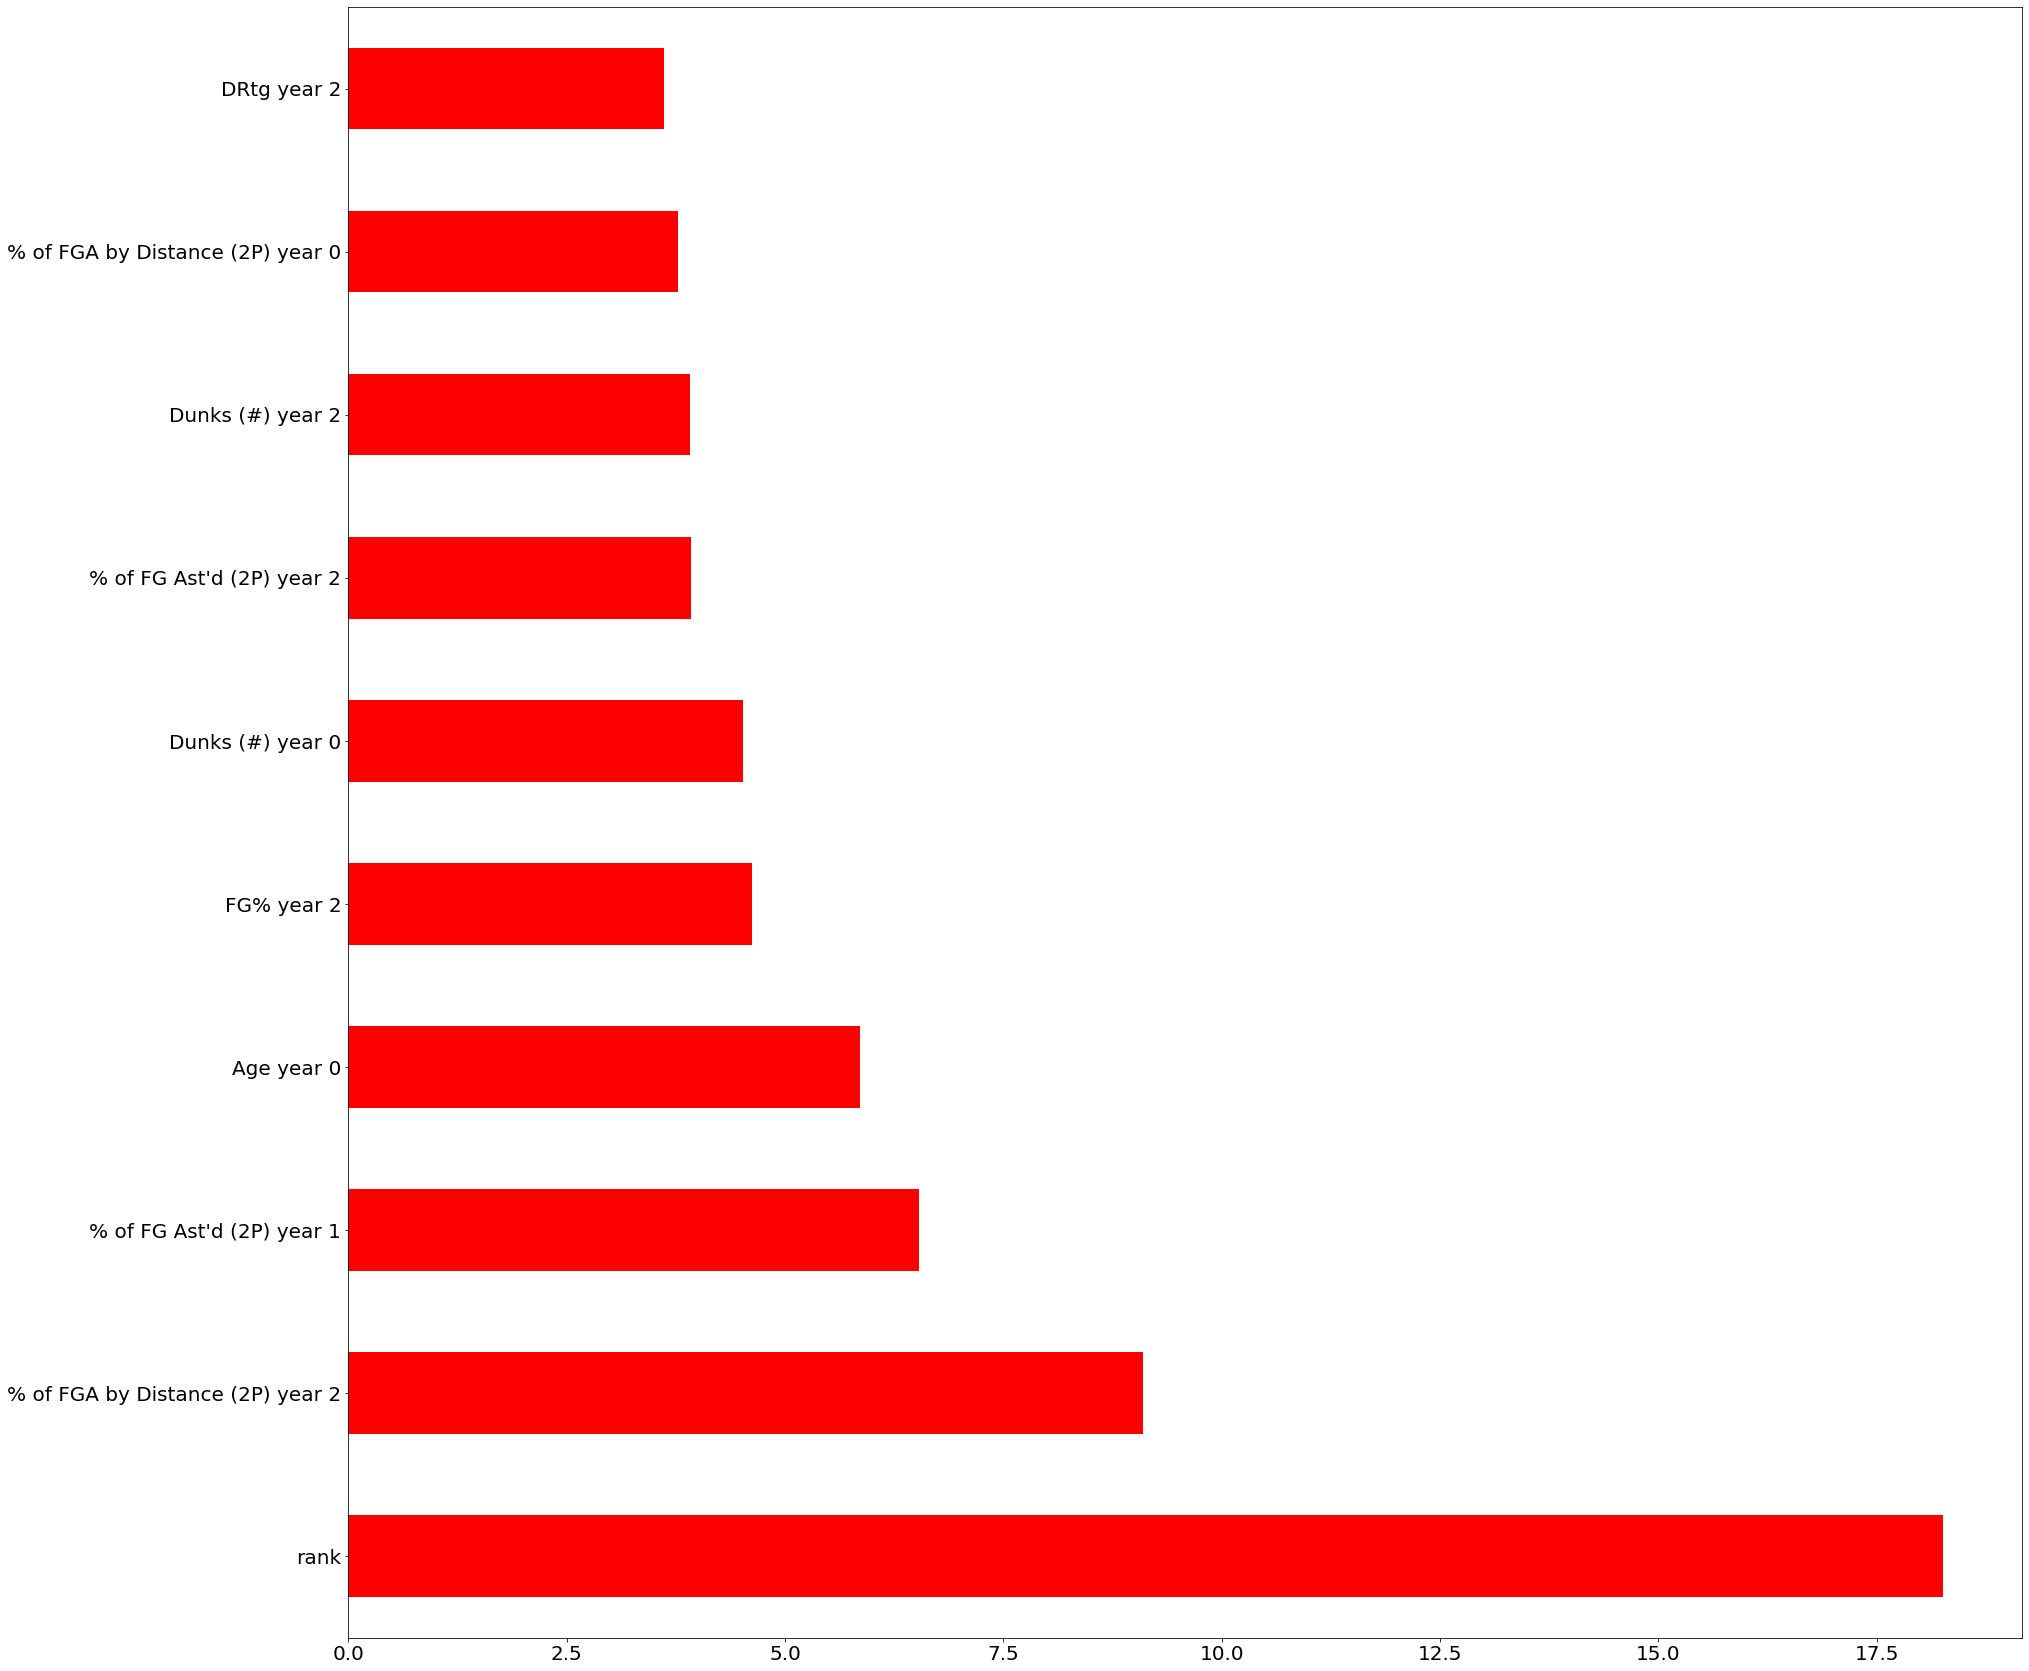

Boosting RMSE on Validation Data Boosting Regressor: 8080239.72642976
---
Boosting with 800 estimators and learning rate of 1


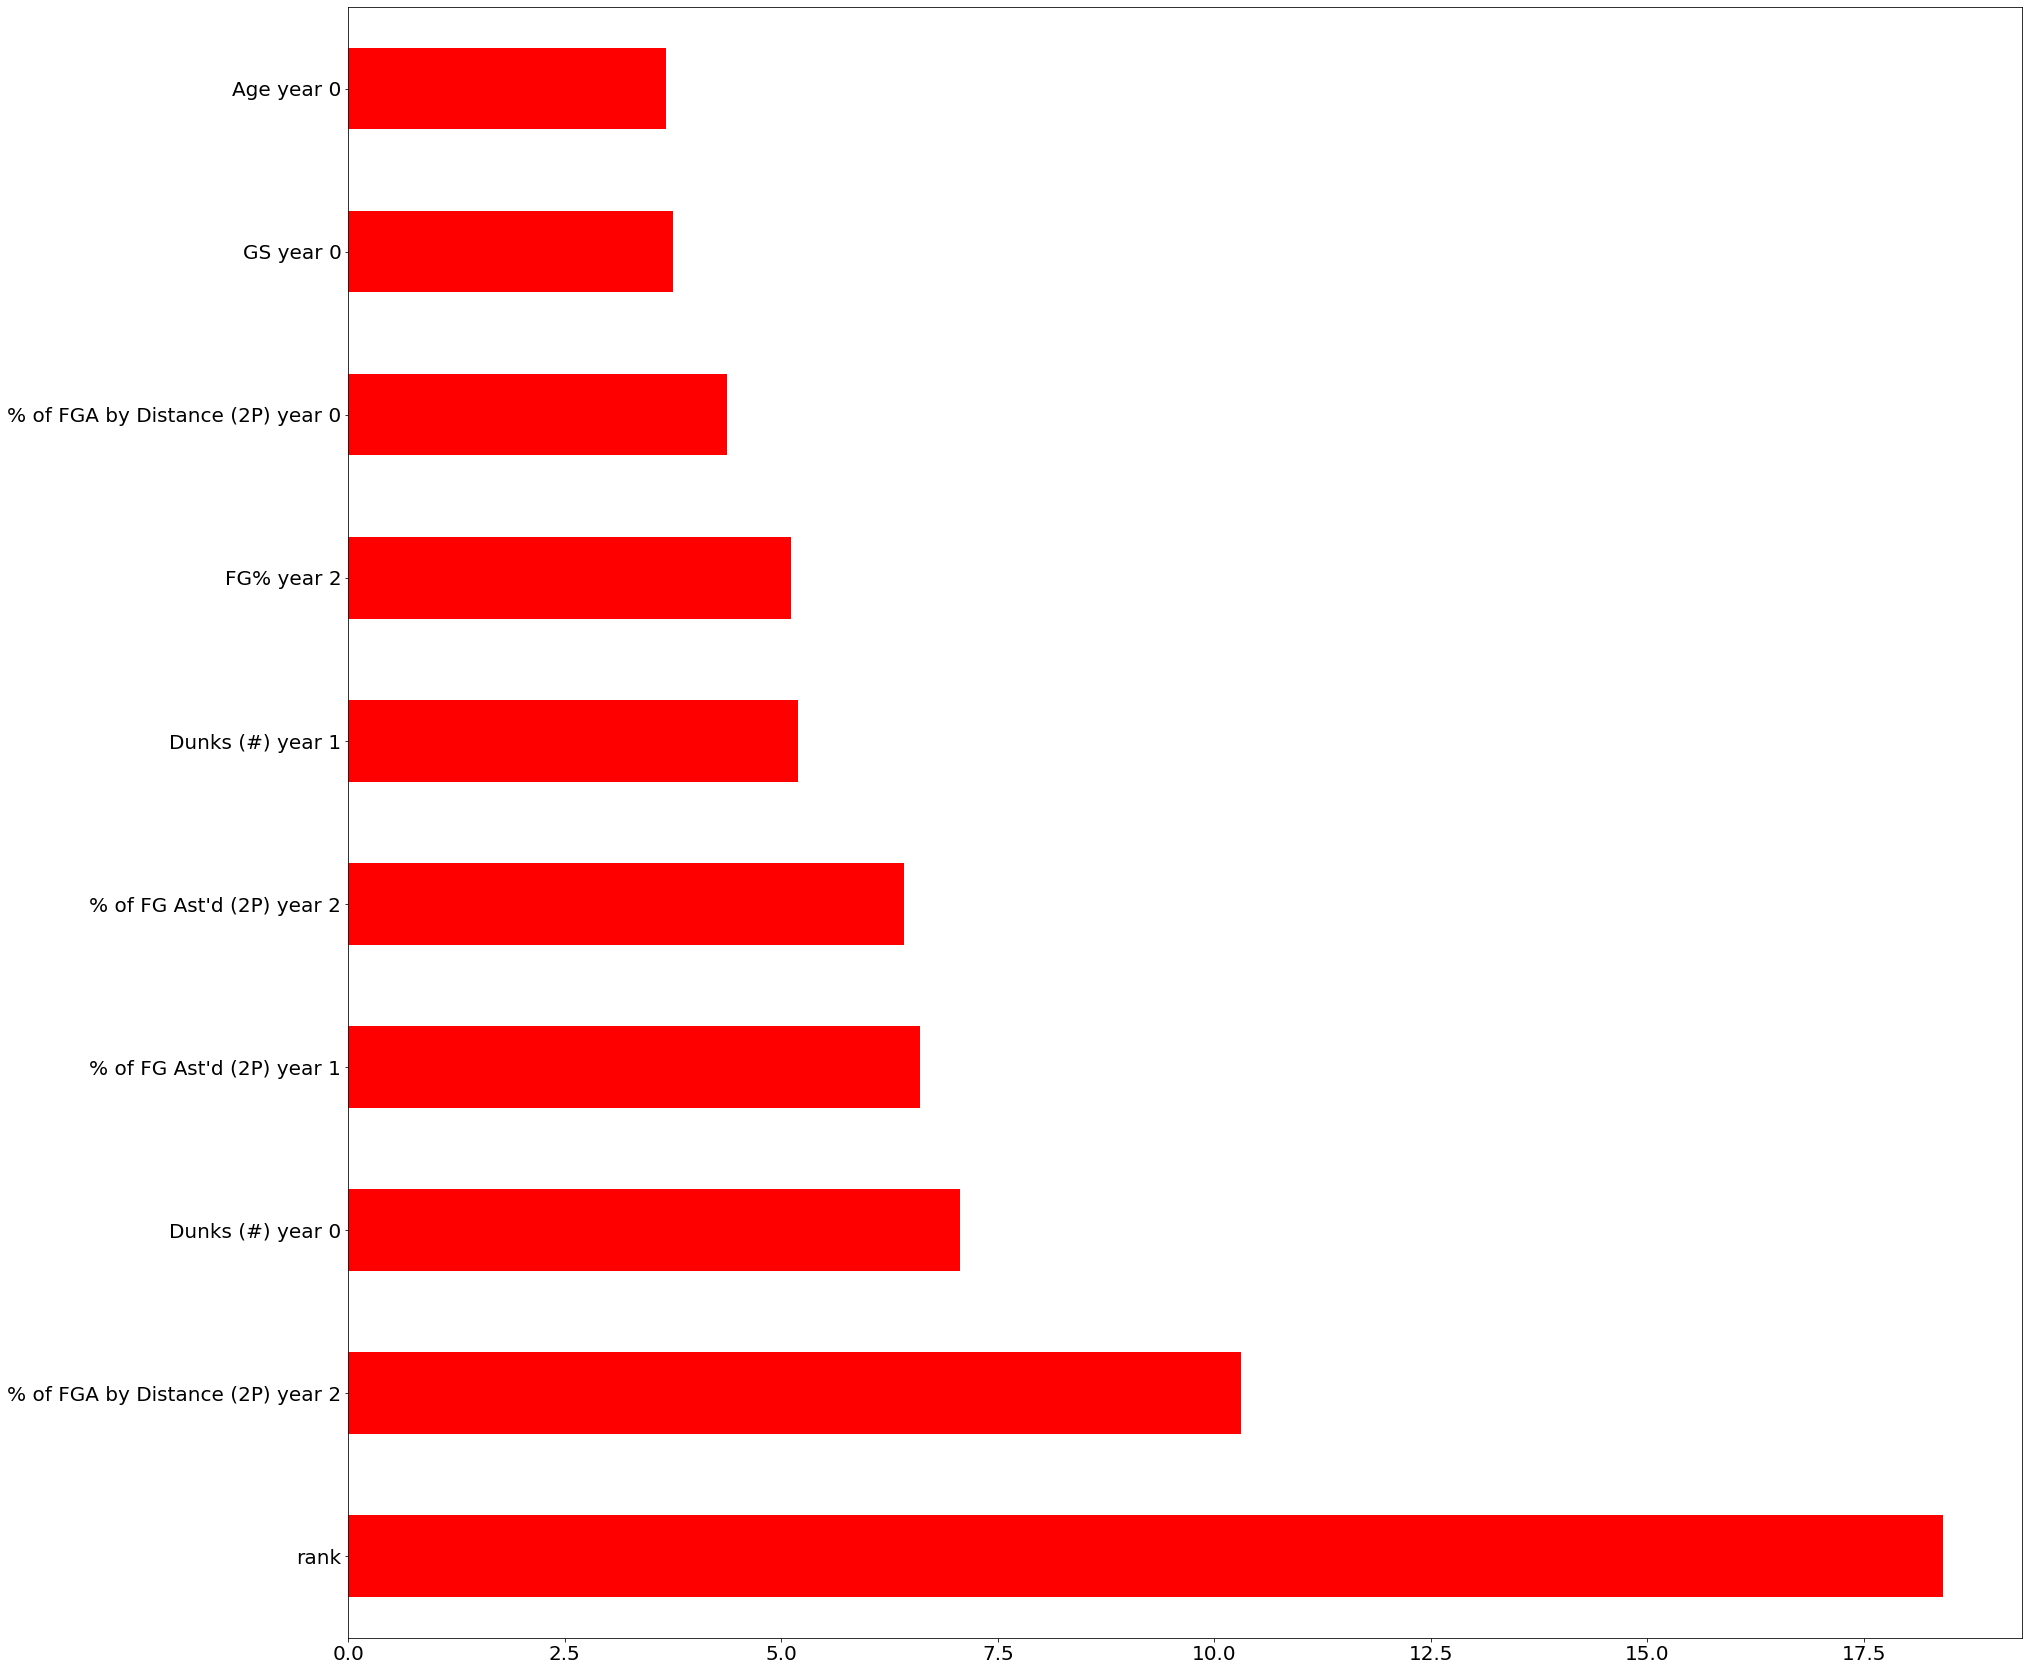

Boosting RMSE on Validation Data Boosting Regressor: 9681559.250269085


In [21]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(NBADataStillInLeague[importantTraits],NBADataStillInLeague['AAV_InPrime'], test_size=0.2, random_state=11)

# Split Data again but only with the important traits
X_train_final1 = X_train_final[:int(len(X_train_final)*0.8)][importantTraits]
X_train_final2 = X_train_final[int(len(X_train_final)*0.8):][importantTraits]
y_train_final1 = y_train_final[:int(len(y_train_final)*0.8)]
y_train_final2 = y_train_final[int(len(y_train_final)*0.8):]


from sklearn.ensemble import GradientBoostingRegressor

# Create and fit new model (Boosting first with a bunch of different hyperparameters)
for n_est in [20,50,100,200,400,800]:
    for learn in [0.01,0.1,1]:
        print('---')
        print('Boosting with '+str(n_est)+' estimators and learning rate of '+str(learn))
        boostingModel = GradientBoostingRegressor(n_estimators=n_est, random_state=11,learning_rate=learn)
        boostingModel.fit(X_train_final1,y_train_final1)

        
        plt.show()
        
        importance = pd.Series(boostingModel.feature_importances_ * 100, index = X_train_final1.columns)
        importance = importance.sort_values(axis=0, ascending = False)[:10]
        importance.plot(kind='barh', color='r')

        plt.show()

        print("Boosting RMSE on Validation Data Boosting Regressor: " + str(mean_squared_error(boostingModel.predict(X_train_final2),y_train_final2)**(1/2)))

        # Best model RMSE worse than 7.2 million dollars

In [22]:
from sklearn.neighbors import KNeighborsRegressor

kneighboursScaler = StandardScaler()

# Create and fit new model
for n_neigh in [1,2,4,8,16,32,64,128,256]:
    print('---')
    print('Boosting with k='+str(n_neigh)+' neighbours')
    knnModel = KNeighborsRegressor(n_neighbors=n_neigh)
    knnModel.fit(kneighboursScaler.fit_transform(X_train_final1),y_train_final1)


    plt.show()


    print("Boosting RMSE on Validation Data KNN Regressor: " + str(mean_squared_error(knnModel.predict(kneighboursScaler.transform(X_train_final2)),y_train_final2)**(1/2)))

    # KNN Regressor best model is 7.65 million RMSE

---
Boosting with k=1 neighbours
Boosting RMSE on Validation Data KNN Regressor: 12178743.289302802
---
Boosting with k=2 neighbours
Boosting RMSE on Validation Data KNN Regressor: 9360264.796679681
---
Boosting with k=4 neighbours
Boosting RMSE on Validation Data KNN Regressor: 8326551.6703171665
---
Boosting with k=8 neighbours
Boosting RMSE on Validation Data KNN Regressor: 7652477.519220132
---
Boosting with k=16 neighbours
Boosting RMSE on Validation Data KNN Regressor: 7744322.292560587
---
Boosting with k=32 neighbours
Boosting RMSE on Validation Data KNN Regressor: 7662845.494279255
---
Boosting with k=64 neighbours
Boosting RMSE on Validation Data KNN Regressor: 7711430.340820932
---
Boosting with k=128 neighbours
Boosting RMSE on Validation Data KNN Regressor: 7981692.642919462
---
Boosting with k=256 neighbours
Boosting RMSE on Validation Data KNN Regressor: 8247325.451043274


In [23]:
from sklearn.linear_model import LinearRegression

X_train_final1 = X_train_final[:int(len(X_train_final)*0.8)][importantTraits]
X_train_final2 = X_train_final[int(len(X_train_final)*0.8):][importantTraits]
y_train_final1 = y_train_final[:int(len(y_train_final)*0.8)]
y_train_final2 = y_train_final[int(len(y_train_final)*0.8):]

linearModel = LinearRegression()
linearModel.fit(X_train_final1,y_train_final1)


plt.show()


print("RMSE on Validation Data Linear Regressor: " + str(mean_squared_error(knnModel.predict(X_train_final2),y_train_final2)**(1/2)))

# Significantly worse RMSE than previous 2 models

Boosting RMSE on Validation Data Linear Regressor: 8303195.340966684


/Users/nitinkhanna/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


#### The predictions are not performing at an adequate level, and seem to be being pushed towards the middle. As such, we can try a log transformation to see if it will improve the performance

In [24]:
linearModel = LinearRegression()

linearModel.fit(X_train_final1,np.log10(y_train_final1))

validationPredictions = 10**linearModel.predict(X_train_final2)



print("Boosting RMSE on Validation Data Linear Regressor: " + str(mean_squared_error(validationPredictions,y_train_final2)**(1/2)))

# Log corrected Linear Regression performs worse

Boosting RMSE on Validation Data Linear Regressor: 8781837.591518784


In [25]:
from sklearn.neighbors import KNeighborsRegressor

# Create and fit new model
for n_neigh in [1,2,4,8,16,32,64,128,256]:
    print('---')
    print('Boosting with k='+str(n_neigh)+' neighbours')
    knnModel = KNeighborsRegressor(n_neighbors=n_neigh)
    knnModel.fit(X_train_final1,np.log10(y_train_final1))


    plt.show()

    print("Boosting RMSE on Validation Data KNN Regressor: " + str(mean_squared_error(10**knnModel.predict(X_train_final2),y_train_final2)**(1/2)))

    

---
Boosting with k=1 neighbours
Boosting RMSE on Validation Data KNN Regressor: 10892502.692178125
---
Boosting with k=2 neighbours
Boosting RMSE on Validation Data KNN Regressor: 9606215.492952194
---
Boosting with k=4 neighbours
Boosting RMSE on Validation Data KNN Regressor: 8326360.570105726
---
Boosting with k=8 neighbours
Boosting RMSE on Validation Data KNN Regressor: 7950290.188831429
---
Boosting with k=16 neighbours
Boosting RMSE on Validation Data KNN Regressor: 8540975.674289882
---
Boosting with k=32 neighbours
Boosting RMSE on Validation Data KNN Regressor: 8976321.078839349
---
Boosting with k=64 neighbours
Boosting RMSE on Validation Data KNN Regressor: 9154253.539226249
---
Boosting with k=128 neighbours
Boosting RMSE on Validation Data KNN Regressor: 9241564.363799948
---
Boosting with k=256 neighbours
Boosting RMSE on Validation Data KNN Regressor: 9444788.248961093


In [26]:

newimportantTraits = [] # new list of important traits

NBADataProgressionStyle = NBADataStillInLeague.copy()

newimportantTraits.append('rank')
newimportantTraits.append('Age year 0')



# Convert data from stat year 0,1,2 to stat year 0, stat improvement year 0 to year 1 and year 1 to year 2
for trait in importantTraits:
    if trait not in ['rank','Age year 0']:
        if trait[-1].isdigit():
            # Save the year
            oneTwoOrThree = int(trait.strip()[-1])
            trait = trait[:trait.index('year')-1]
            if oneTwoOrThree == 1:
                NBADataProgressionStyle[trait +' diff years 01'] = NBADataProgressionStyle[trait +' year 1']-NBADataProgressionStyle[trait +' year 0']
                newimportantTraits.append(str(trait +' diff years 01').strip())
            elif oneTwoOrThree == 2:
                NBADataProgressionStyle[trait +' diff years 12'] = NBADataProgressionStyle[trait +' year 2']-NBADataProgressionStyle[trait +' year 1']
                newimportantTraits.append(str(trait +' diff years 12').strip())
            else:
                NBADataProgressionStyle[str(trait)+" year 0"]
                newimportantTraits.append(str(trait+" year 0").strip())
                
        
    
display(NBADataProgressionStyle.head())
        


# Split data again 
X_train_final_new, X_test_final_new, y_train_final_new, y_test_final_new = train_test_split(NBADataProgressionStyle[newimportantTraits],NBADataProgressionStyle['AAV_InPrime'], test_size=0.2, random_state=11)


X_train_final1_new = X_train_final_new[:int(len(X_train_final_new)*0.8)][newimportantTraits]
X_train_final2_new = X_train_final_new[int(len(X_train_final_new)*0.8):][newimportantTraits]
y_train_final1_new = y_train_final_new[:int(len(y_train_final_new)*0.8)]
y_train_final2_new = y_train_final_new[int(len(y_train_final_new)*0.8):]
        
X_train_final1_new.head()

year  rank  height  weight  Age year 0  G year 0  G year 1  G year 2  \
0     1     1   183.0    74.0          21        76        80        48   
1     1     2   211.0    99.0          22        63        63        46   
2     1     3   188.0    81.0          19        67        82        49   
3     1     4   196.0    92.0          21        82        82        50   
4     1     5   206.0   101.0          20        82        82        42   

   MP year 0  MP year 1  ...  % of FG Ast'd (2P) diff years 01  \
0       3045       3150  ...                             0.084   
1       1897       2002  ...                            -0.085   
2       2324       3112  ...                             0.039   
3       2532       3287  ...                            -0.003   
4       2970       3268  ...                             0.069   

   % of FG Ast'd (2P) diff years 12  Dunks (#) diff years 01  \
0                             0.053                       -1   
1                             0.026                      -62   
2                            -0.004                       -3   
3                             0.034                       14   
4                            -0.069                      -23   

   Dunks (#) diff years 12  GS diff years 01  GS diff years 12  \
0                      -30                 6               -32   
1                      -17                20               -58   
2                        2                17               -32   
3                       -4                 1               -32   
4                      -44                14               -41   

   2P% diff years 01  2P% diff years 12  DRtg diff years 01  \
0              0.046             -0.054                  -6   
1             -0.075              0.108                   2   
2              0.014              0.007                   0   
3              0.005              0.039                  -2   
4              0.009             -0.021                  -7   

   DRtg diff years 12  
0                -7.0  
1               -14.0  
2                -4.0  
3                -2.0  
4                -3.0  

[5 rows x 120 columns]

rank  Age year 0  FG% year 0  FG% diff years 01  FG% diff years 12  \
146     5          21       0.442             -0.022             -0.016   
97     43          23       0.625             -0.292              0.099   
326     8          23       0.443              0.081             -0.022   
322     4          21       0.358              0.080             -0.025   
113    10          23       0.375              0.056             -0.033   

     % of FGA by Distance (2P) year 0  \
146                             0.997   
97                              1.000   
326                             1.000   
322                             0.815   
113                             0.525   

     % of FGA by Distance (2P) diff years 01  \
146                                   -0.010   
97                                    -0.167   
326                                   -0.011   
322                                   -0.050   
113                                    0.079   

     % of FGA by Distance (2P) diff years 12  FG% by Distance (2P) year 0  \
146                                    0.003                        0.444   
97                                     0.167                        0.625   
326                                   -0.063                        0.443   
322                                   -0.099                        0.424   
113                                   -0.024                        0.333   

     FG% by Distance (2P) diff years 01  ...  Dunks (#) diff years 12  \
146                              -0.024  ...                      -16   
97                               -0.225  ...                       19   
326                               0.087  ...                      -42   
322                               0.050  ...                        7   
113                               0.111  ...                        0   

     GS year 0  GS diff years 01  GS diff years 12  2P% year 0  \
146         43                17               -60       0.444   
97           0                 0                 6       0.625   
326          2                41               -13       0.443   
322          0                23               -13       0.424   
113          0                 5                -5       0.333   

     2P% diff years 01  2P% diff years 12  DRtg year 0  DRtg diff years 01  \
146             -0.024             -0.012          105                   2   
97              -0.225              0.032          109                 -14   
326              0.087             -0.009          102                  11   
322              0.050              0.001          107                   0   
113              0.111             -0.022          107                   1   

     DRtg diff years 12  
146                -2.0  
97                  4.0  
326                -1.0  
322                 4.0  
113                 2.0  

[5 rows x 26 columns]

In [27]:
# Try Neural Network with newly configured data
from sklearn.neural_network import MLPRegressor



for modelSizes in [(24),(24,12),(36,24,12),(72,36,24,12),(100,100,100,100,100,100)]:

    # Pick massive model with heavy regularization to reign it back in
    neuralNetModel = MLPRegressor(hidden_layer_sizes = modelSizes, learning_rate='adaptive', learning_rate_init=0.01,max_iter=500000,alpha=0.1)

    neuralNetModel.fit(X_train_final1_new, y_train_final1_new)

    ypreds = neuralNetModel.predict(X_train_final2_new)

    print(mean_squared_error(ypreds, y_train_final2_new)**(1/2))
    
    
    
massiveNeuralNetModel = MLPRegressor(hidden_layer_sizes = (200,200,200,200,200,200), learning_rate='adaptive', learning_rate_init=0.01,max_iter=500000,alpha=1)

massiveNeuralNetModel.fit(X_train_final1_new, y_train_final1_new)

ypreds = massiveNeuralNetModel.predict(X_train_final2_new)

print(mean_squared_error(ypreds, y_train_final2_new)**(1/2))

# Mean squared errors are worse than previous data format

9583139.08678711
7314620.422048162
9746747.13511601
8081995.86017172
9067543.045518324
8954982.850478329


In [28]:
# Try Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor



for nest in [2,5,10,20,50,100,200]:

    # Pick massive model with heavy regularization to reign it back in
    RFRModel = RandomForestRegressor(n_estimators=nest)

    RFRModel.fit(X_train_final1_new, y_train_final1_new)

    ypreds = RFRModel.predict(X_train_final2_new)

    print(mean_squared_error(ypreds, y_train_final2_new)**(1/2))

# RFR best model performs at 7.32 million dollar RMSE

8886019.98875771
8305717.700564377
7466721.281909495
7717116.471715874
7683405.292047476
7322504.350838787
7322846.346575511


In [29]:
linModelE = sm.regression.linear_model.OLS(y_train_final1_new, X_train_final1_new)
regrE = linModelE.fit()

# Try yet another statistical significance test on newly factored data

regressionSummaryE = regrE.summary()
display(regressionSummaryE)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            AAV_InPrime   R-squared (uncentered):                   0.672
Model:                            OLS   Adj. R-squared (uncentered):              0.649
Method:                 Least Squares   F-statistic:                              29.52
Date:                Sun, 03 Mar 2024   Prob (F-statistic):                    3.73e-69
Time:                        20:04:56   Log-Likelihood:                         -6343.3
No. Observations:                 370   AIC:                                  1.273e+04
Df Residuals:                     346   BIC:                                  1.283e+04
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
rank                                    -1.499e+05   2.56e+04     -5.855      0.000      -2e+05   -9.96e+04
Age year 0                              -9.558e+05   2.33e+05     -4.109      0.000   -1.41e+06   -4.98e+05
FG% year 0                              -4.776e+07   2.26e+07     -2.114      0.035   -9.22e+07   -3.33e+06
FG% diff years 01                       -3.752e+07   2.22e+07     -1.687      0.092   -8.13e+07    6.22e+06
FG% diff years 12                       -2.413e+07   1.75e+07     -1.380      0.168   -5.85e+07    1.03e+07
% of FGA by Distance (2P) year 0        -1.817e+05   3.35e+06     -0.054      0.957   -6.77e+06    6.41e+06
% of FGA by Distance (2P) diff years 01 -8.523e+06   4.94e+06     -1.726      0.085   -1.82e+07    1.19e+06
% of FGA by Distance (2P) diff years 12 -1.055e+07   5.52e+06     -1.910      0.057   -2.14e+07    3.16e+05
FG% by Distance (2P) year 0              2.238e+07   1.03e+07      2.178      0.030    2.17e+06    4.26e+07
FG% by Distance (2P) diff years 01      -3.538e+08   2.85e+08     -1.240      0.216   -9.15e+08    2.07e+08
FG% by Distance (2P) diff years 12      -7.235e+08   5.71e+08     -1.268      0.206   -1.85e+09    3.99e+08
% of FG Ast'd (2P) year 0                7.007e+06   2.59e+06      2.701      0.007    1.91e+06    1.21e+07
% of FG Ast'd (2P) diff years 01         9.437e+06   3.61e+06      2.611      0.009    2.33e+06    1.65e+07
% of FG Ast'd (2P) diff years 12         5.991e+05   3.42e+06      0.175      0.861   -6.12e+06    7.32e+06
Dunks (#) year 0                         3.514e+04   2.51e+04      1.401      0.162   -1.42e+04    8.45e+04
Dunks (#) diff years 01                  -623.0895   2.56e+04     -0.024      0.981    -5.1e+04    4.98e+04
Dunks (#) diff years 12                  5475.0584   2.59e+04      0.211      0.833   -4.55e+04    5.65e+04
GS year 0                                1.146e+04   2.33e+04      0.492      0.623   -3.43e+04    5.72e+04
GS diff years 01                         2.945e+04   1.98e+04      1.488      0.138   -9473.655    6.84e+04
GS diff years 12                         3105.3477   1.95e+04      0.159      0.873   -3.52e+04    4.14e+04
2P% year 0                               2.238e+07   1.03e+07      2.178      0.030    2.17e+06    4.26e+07
2P% diff years 01                        3.771e+08   2.86e+08      1.319      0.188   -1.85e+08     9.4e+08
2P% diff years 12                        7.383e+08   5.71e+08      1.293      0.197   -3.85e+08    1.86e+09
DRtg year 0                              2.643e+05    5.3e+04      4.987      0.000     1.6e+05    3.69e+05
DRtg diff years 01                      -2781.1889   1.11e+05     -0

In [37]:
import itertools
from sklearn.metrics import r2_score

# K Nearest Neighbours with optimal trait subsets

# Handpicked traits based on intuition and regr summary above
coolTraits = ['rank','Age year 0','FG% year 0', 'FG% by Distance (2P) year 0', "% of FG Ast'd (2P) year 0",\
              "% of FG Ast'd (2P) diff years 01", "% of FG Ast'd (2P) diff years 12", "2P% year 0", "DRtg year 0"]

# Try every possible subset in model selection picking only statistically significant traits 
subsets = []

for i in range(1, len(coolTraits)+1):
    # Use itertools to get combinations
    curLevelLst = [list(x) for x in itertools.combinations(coolTraits, i)]
    
    # Append each subset to the list
    [subsets.append(x) for x in curLevelLst]

# Try with KNN Regressor
resultsLst = []
for ss in subsets:
    for nest in [2,5,10,20,50,100,200]:

        # Pick massive model with heavy regularization to reign it back in
        KNNModel = KNeighborsRegressor(n_neighbors=nest)

        KNNModel.fit(X_train_final1_new[ss], y_train_final1_new)

        ypreds = KNNModel.predict(X_train_final2_new[ss])
        
        resultsLst.append((ss,nest,mean_squared_error(ypreds, y_train_final2_new)**(1/2)))

resultsLst.sort(key = lambda x:x[2])

print(resultsLst[:10])



# See what actual average error 
KNNModel = KNeighborsRegressor(n_neighbors=20)

bestSS = ['rank', 'Age year 0', 'FG% by Distance (2P) year 0', "% of FG Ast'd (2P) diff years 01", "% of FG Ast'd (2P) diff years 12", '2P% year 0']

KNNModel.fit(X_train_final1_new[bestSS], y_train_final1_new)

ypreds = KNNModel.predict(X_train_final2_new[bestSS])

print("Average Error: "+str(mean_absolute_error(ypreds, y_train_final2_new)))

ypredsTest = KNNModel.predict(X_test_final_new[bestSS])

print("Average Error test: "+str(mean_absolute_error(ypredsTest, y_test_final_new)))


# See what actual average error 
KNNModel = KNeighborsRegressor(n_neighbors=20)

bestSS = ['rank', 'Age year 0']

KNNModel.fit(X_train_final1_new[bestSS], y_train_final1_new)

ypreds = KNNModel.predict(X_train_final2_new[bestSS])

print("Average Error: "+str(mean_absolute_error(ypreds, y_train_final2_new)))

ypredsTest = KNNModel.predict(X_test_final_new[bestSS])

print("Average Error test: "+str(mean_absolute_error(ypredsTest, y_test_final_new)))

# RMSE breaks 7 million for first time and absolute validation error approaches 5 million which is about half the mean

[(['rank', 'Age year 0'], 20, 6744027.742399295), (['rank', 'Age year 0', 'FG% by Distance (2P) year 0', "% of FG Ast'd (2P) diff years 01", "% of FG Ast'd (2P) diff years 12", '2P% year 0'], 20, 6750894.562721719), (['rank', 'Age year 0', 'FG% by Distance (2P) year 0', "% of FG Ast'd (2P) diff years 01", "% of FG Ast'd (2P) diff years 12"], 20, 6755397.494443757), (['rank', 'Age year 0', "% of FG Ast'd (2P) diff years 01", "% of FG Ast'd (2P) diff years 12", '2P% year 0'], 20, 6755397.494443757), (['rank', 'Age year 0', "% of FG Ast'd (2P) diff years 01", "% of FG Ast'd (2P) diff years 12"], 20, 6758399.704156957), (['rank', 'Age year 0', 'FG% year 0', "% of FG Ast'd (2P) diff years 01", "% of FG Ast'd (2P) diff years 12"], 20, 6780512.303530377), (['rank', 'Age year 0', 'FG% by Distance (2P) year 0', "% of FG Ast'd (2P) diff years 12"], 20, 6785057.869061258), (['rank', 'Age year 0', "% of FG Ast'd (2P) diff years 12", '2P% year 0'], 20, 6785057.869061258), (['rank', 'Age year 0', 'F

In [31]:
from sklearn.ensemble import AdaBoostRegressor

resultsLst = []

# Try with AdaBoost
for ss in subsets:
    for nest in [2,5,10,20,50,100]:

        # Pick massive model with heavy regularization to reign it back in
        ABRModel = AdaBoostRegressor(n_estimators=nest, random_state=11)

        ABRModel.fit(X_train_final1_new[ss], y_train_final1_new)

        ypreds = ABRModel.predict(X_train_final2_new[ss])
        
        resultsLst.append((ss,nest,mean_squared_error(ypreds, y_train_final2_new)**(1/2)))
        

resultsLst.sort(key = lambda x:x[2])

print(resultsLst[:10])


ABRModel = AdaBoostRegressor(n_estimators=5, random_state=11)

ABRModel.fit(X_train_final1_new[['rank', 'Age year 0', 'DRtg year 0']], y_train_final1_new)

ypreds = ABRModel.predict(X_test_final_new[['rank', 'Age year 0', 'DRtg year 0']])

print(mean_absolute_error(ypreds,y_test_final_new))
        

[(['rank', 'Age year 0', 'DRtg year 0'], 5, 6873924.983903052), (['rank', 'Age year 0'], 5, 6882043.389427478), (['rank', 'Age year 0', 'FG% year 0', 'FG% by Distance (2P) year 0', "% of FG Ast'd (2P) year 0", "% of FG Ast'd (2P) diff years 12"], 5, 6946828.079948779), (['rank', 'Age year 0', 'FG% year 0', "% of FG Ast'd (2P) year 0", "% of FG Ast'd (2P) diff years 12", '2P% year 0'], 5, 6951643.314700714), (['rank', 'Age year 0', 'FG% year 0', 'FG% by Distance (2P) year 0', "% of FG Ast'd (2P) year 0", "% of FG Ast'd (2P) diff years 12", '2P% year 0'], 5, 6951643.314700714), (['rank', 'Age year 0'], 10, 6953731.317803191), (['rank', 'Age year 0', 'FG% year 0', 'DRtg year 0'], 5, 7013180.555918365), (['rank', 'Age year 0', 'FG% year 0', "% of FG Ast'd (2P) year 0", "% of FG Ast'd (2P) diff years 12", 'DRtg year 0'], 5, 7052982.680468283), (['rank', 'Age year 0', 'FG% year 0', "% of FG Ast'd (2P) diff years 12", 'DRtg year 0'], 10, 7062656.258663729), (['rank', 'Age year 0', "% of FG As

In [32]:
from sklearn.svm import SVR

resultsLst = []

# Support Vector Machine test (performed poorly on both tasks)
for ss in subsets:
    for kern in ['linear','poly','rbf','sigmoid']:
        for eps in [0.0001,0.001,0.01,0.1,0.5]:

            # Pick massive model with heavy regularization to reign it back in
            SVRModel = SVR(kernel=kern,epsilon=eps)

            SVRModel.fit(X_train_final1_new[ss], y_train_final1_new)

            ypreds = SVRModel.predict(X_train_final2_new[ss])

            resultsLst.append((ss,(eps,kern),mean_squared_error(ypreds, y_train_final2_new)**(1/2)))

resultsLst.sort(key = lambda x:x[2])

print(resultsLst[:10])

[(['Age year 0'], (0.5, 'poly'), 8350195.197365795), (['Age year 0'], (0.1, 'poly'), 8350195.390505915), (['Age year 0'], (0.01, 'poly'), 8350195.4339624485), (['Age year 0'], (0.001, 'poly'), 8350195.438308104), (['Age year 0'], (0.0001, 'poly'), 8350195.438742665), (['DRtg year 0'], (0.0001, 'poly'), 8819267.570508357), (['DRtg year 0'], (0.001, 'poly'), 8819267.57051816), (['DRtg year 0'], (0.01, 'poly'), 8819267.57061732), (['DRtg year 0'], (0.1, 'poly'), 8819267.571608627), (['DRtg year 0'], (0.5, 'poly'), 8819267.576014403)]


In [33]:
from sklearn.linear_model import Lasso

resultsLst = []

# Try another lasso regression model
for ss in subsets:
    for alpha in [0.0001,0.001,0.01,0.1,0.5,1,2,5,10]:

        # Pick massive model with heavy regularization to reign it back in
        LRModel = Lasso(alpha=alpha, max_iter=1000000, selection='random', random_state=11)

        LRModel.fit(X_train_final1_new[ss], y_train_final1_new)

        ypreds = LRModel.predict(X_train_final2_new[ss])

        resultsLst.append((ss,alpha,mean_squared_error(ypreds, y_train_final2_new)**(1/2)))

resultsLst.sort(key = lambda x:x[2])

print(resultsLst[:10])

[(['rank', 'Age year 0', 'FG% year 0', 'FG% by Distance (2P) year 0'], 0.0001, 7083982.721588807), (['rank', 'Age year 0', 'FG% year 0', 'FG% by Distance (2P) year 0'], 0.001, 7083982.723667666), (['rank', 'Age year 0', 'FG% year 0', 'FG% by Distance (2P) year 0'], 0.01, 7083982.744403203), (['rank', 'Age year 0', 'FG% year 0', 'FG% by Distance (2P) year 0'], 0.1, 7083982.951915459), (['rank', 'Age year 0', 'FG% year 0', 'FG% by Distance (2P) year 0'], 0.5, 7083983.875492427), (['rank', 'Age year 0', 'FG% year 0', 'FG% by Distance (2P) year 0'], 1, 7083985.022094654), (['rank', 'Age year 0', 'FG% year 0', 'FG% by Distance (2P) year 0'], 2, 7083987.32967285), (['rank', 'Age year 0', 'FG% year 0', 'FG% by Distance (2P) year 0'], 5, 7083994.2749721045), (['rank', 'Age year 0', 'FG% year 0', 'FG% by Distance (2P) year 0'], 10, 7084005.808603042), (['rank', 'Age year 0', 'FG% year 0', 'FG% by Distance (2P) year 0', '2P% year 0'], 0.0001, 7093987.103539331)]


In [34]:
# Find Statistics about the dataset
display(y_train_final1_new.describe())
display(y_train_final2_new.describe())
display(y_test_final_new.describe())

count    3.700000e+02
mean     8.794672e+06
std      7.856539e+06
min      1.032628e+05
25%      2.507565e+06
50%      6.416308e+06
75%      1.258193e+07
max      3.613858e+07
Name: AAV_InPrime, dtype: float64

count    9.300000e+01
mean     9.367390e+06
std      8.404787e+06
min      3.142431e+05
25%      2.288923e+06
50%      6.789607e+06
75%      1.411913e+07
max      3.603986e+07
Name: AAV_InPrime, dtype: float64

count    1.160000e+02
mean     9.027712e+06
std      8.581089e+06
min      1.759404e+05
25%      2.006720e+06
50%      6.605550e+06
75%      1.416050e+07
max      3.501387e+07
Name: AAV_InPrime, dtype: float64

In [35]:
### Best Model

# K Nearest Neighbours with optimal trait subsets from a new lasso regression
xcols = list(NBADataStillInLeague.columns)[:-6]

xcols_fin = []

# Generate the new traits as we had done before
NBADataProgressionStyleAll = NBADataStillInLeague.copy()

xcols_fin.append('rank')
xcols_fin.append('Age year 0')



# Convert data from stat year 0,1,2 to stat year 0, stat improvement year 0 to year 1 and year 1 to year 2
for trait in xcols:
    if trait.lower() not in ['rank','age year 0','height','weight']:
        if trait[-1].isdigit():
            # Save the year
            oneTwoOrThree = int(trait.strip()[-1])
            trait = trait[:trait.index('year')-1]
            if oneTwoOrThree == 1:
                NBADataProgressionStyleAll[trait +' diff years 01'] = NBADataProgressionStyleAll[trait +' year 1']-NBADataProgressionStyleAll[trait +' year 0']
                xcols_fin.append(str(trait +' diff years 01').strip())
            elif oneTwoOrThree == 2:
                NBADataProgressionStyleAll[trait +' diff years 12'] = NBADataProgressionStyleAll[trait +' year 2']-NBADataProgressionStyleAll[trait +' year 1']
                xcols_fin.append(str(trait +' diff years 12').strip())
            else:
                xcols_fin.append(str(trait+" year 0").strip())
                
        
    
display(NBADataProgressionStyleAll.head())



# IL = In League; Make new datasets again (1 gets me 4.6 and 6.3) (5 gets me 5.08,5.27) 3 - 5.7,5.1
X_trainIL_final, X_testIL_final, y_trainIL_final, y_testIL_final = train_test_split(NBADataProgressionStyleAll[xcols_fin],NBADataStillInLeague['AAV_InPrime'], test_size=0.1, random_state=9)

X_train1IL_final = X_trainIL_final[:int(len(X_trainIL_final)*0.8)] # Train set x
X_train2IL_final = X_trainIL_final[int(len(X_trainIL_final)*0.8):] # Validation set x
y_train1IL_final = y_trainIL_final[:int(len(y_trainIL_final)*0.8)] # Train set y
y_train2IL_final = y_trainIL_final[int(len(y_trainIL_final)*0.8):] # Validation Set y

# Look for columns that the lasso regularization discards
# Scale to make lasso more effective
lassoScaler = StandardScaler()

# Use lasso to whittle down the number of columns
lassoModel = skl_lm.Lasso()
lassoModel.set_params(alpha = 500000, max_iter=10000000, random_state=11)
lassoModel.fit(lassoScaler.fit_transform(X_train1IL_final), y_train1IL_final)
print("RMSE lasso = "+str(mean_squared_error(y_train2IL_final, lassoModel.predict(lassoScaler.transform(X_train2IL_final)))**(1/2)))


# Take only significant columns from Lasso
coefs = pd.Series(lassoModel.coef_.flatten(), index = X_train1IL_final.columns)
remainingColumns = pd.DataFrame(coefs[np.vectorize(abs)(coefs) > 0.0001])

deadColumns = pd.DataFrame(coefs[np.vectorize(abs)(coefs) < 0.0001])
print("Number of columns eliminated by Lasso Regularization: "+str(len(deadColumns)))

subsets = []

for i in range(1, len(remainingColumns)+1):
    # Use itertools to get combinations
    curLevelLst = [list(x) for x in itertools.combinations(list(remainingColumns.index), i)]

    # Append each subset to the list
    [subsets.append(x) for x in curLevelLst]

# Try KNN on every subset and value of K
resultsLst = []
for ss in subsets:
    for nest in [2,5,10,20,50,100,200]:

        # Pick massive model with heavy regularization to reign it back in
        KNNModel = KNeighborsRegressor(n_neighbors=nest)

        KNNModel.fit(X_train1IL_final[ss], y_train1IL_final)

        ypreds = KNNModel.predict(X_train2IL_final[ss])

        resultsLst.append((ss,nest,mean_squared_error(ypreds, y_train2IL_final)**(1/2)))

resultsLst.sort(key = lambda x:x[2])

print('---')
[print(x) for x in resultsLst[:10]]

# Pick massive model with heavy regularization to reign it back in

nest=resultsLst[0][1]
KNNModel = KNeighborsRegressor(n_neighbors=nest)

featureSet = resultsLst[0][0]


KNNModel.fit(X_trainIL_final[featureSet], y_trainIL_final)

ypredsTest = KNNModel.predict(X_testIL_final[featureSet])
print('---')
print((featureSet,nest,mean_absolute_error(ypredsTest, y_testIL_final)))


year  rank  height  weight  Age year 0  G year 0  G year 1  G year 2  \
0     1     1   183.0    74.0          21        76        80        48   
1     1     2   211.0    99.0          22        63        63        46   
2     1     3   188.0    81.0          19        67        82        49   
3     1     4   196.0    92.0          21        82        82        50   
4     1     5   206.0   101.0          20        82        82        42   

   MP year 0  MP year 1  ...  TOV diff years 01  TOV diff years 12  \
0       3045       3150  ...               -1.5                0.4   
1       1897       2002  ...               -0.2               -1.2   
2       2324       3112  ...               -0.5                0.2   
3       2532       3287  ...                1.1               -0.4   
4       2970       3268  ...                0.7               -0.6   

   PF diff years 01  PF diff years 12  PTS diff years 01  PTS diff years 12  \
0              -0.5              -0.7                0.0                5.3   
1              -0.8               2.5               -6.3               -0.6   
2               0.1              -0.2                0.1                4.8   
3              -0.6              -0.2                2.6                1.6   
4              -0.5               0.7                4.8               -2.4   

   ORtg diff years 01  ORtg diff years 12  DRtg diff years 01  \
0                 5.0                -4.0                  -6   
1                -9.0                14.0                   2   
2                 0.0                 3.0                   0   
3                -3.0                 4.0                  -2   
4                 0.0                -2.0                  -7   

   DRtg diff years 12  
0                -7.0  
1               -14.0  
2                -4.0  
3                -2.0  
4                -3.0  

[5 rows x 166 columns]

RMSE lasso = 7291154.602454827
Number of columns eliminated by Lasso Regularization: 83
---
(['rank', 'Age year 0', '% of FGA by Distance (2P) diff years 12', "% of FG Ast'd (2P) diff years 01", 'ORB diff years 12', 'STL diff years 01', 'PF year 0'], 50, 7199973.684398382)
(['rank', 'Age year 0', 'Dunks (%FGA) year 0', 'Dunks (%FGA) diff years 01', 'STL diff years 01', 'PF year 0'], 50, 7202812.634301515)
(['rank', 'Age year 0', 'ORB diff years 12', 'STL diff years 01', 'PF year 0'], 50, 7203038.455032842)
(['rank', 'Age year 0', '% of FGA by Distance (2P) diff years 12', 'ORB diff years 12', 'STL diff years 01', 'PF year 0'], 50, 7203038.455032842)
(['rank', 'Age year 0', 'Dunks (%FGA) diff years 01', 'ORB diff years 12', 'STL diff years 01', 'PF year 0'], 50, 7203038.455032842)
(['rank', 'Age year 0', '% of FGA by Distance (2P) diff years 12', 'Dunks (%FGA) diff years 01', 'ORB diff years 12', 'STL diff years 01', 'PF year 0'], 50, 7203038.455032842)
(['rank', 'Age year 0', 'Dunks (%

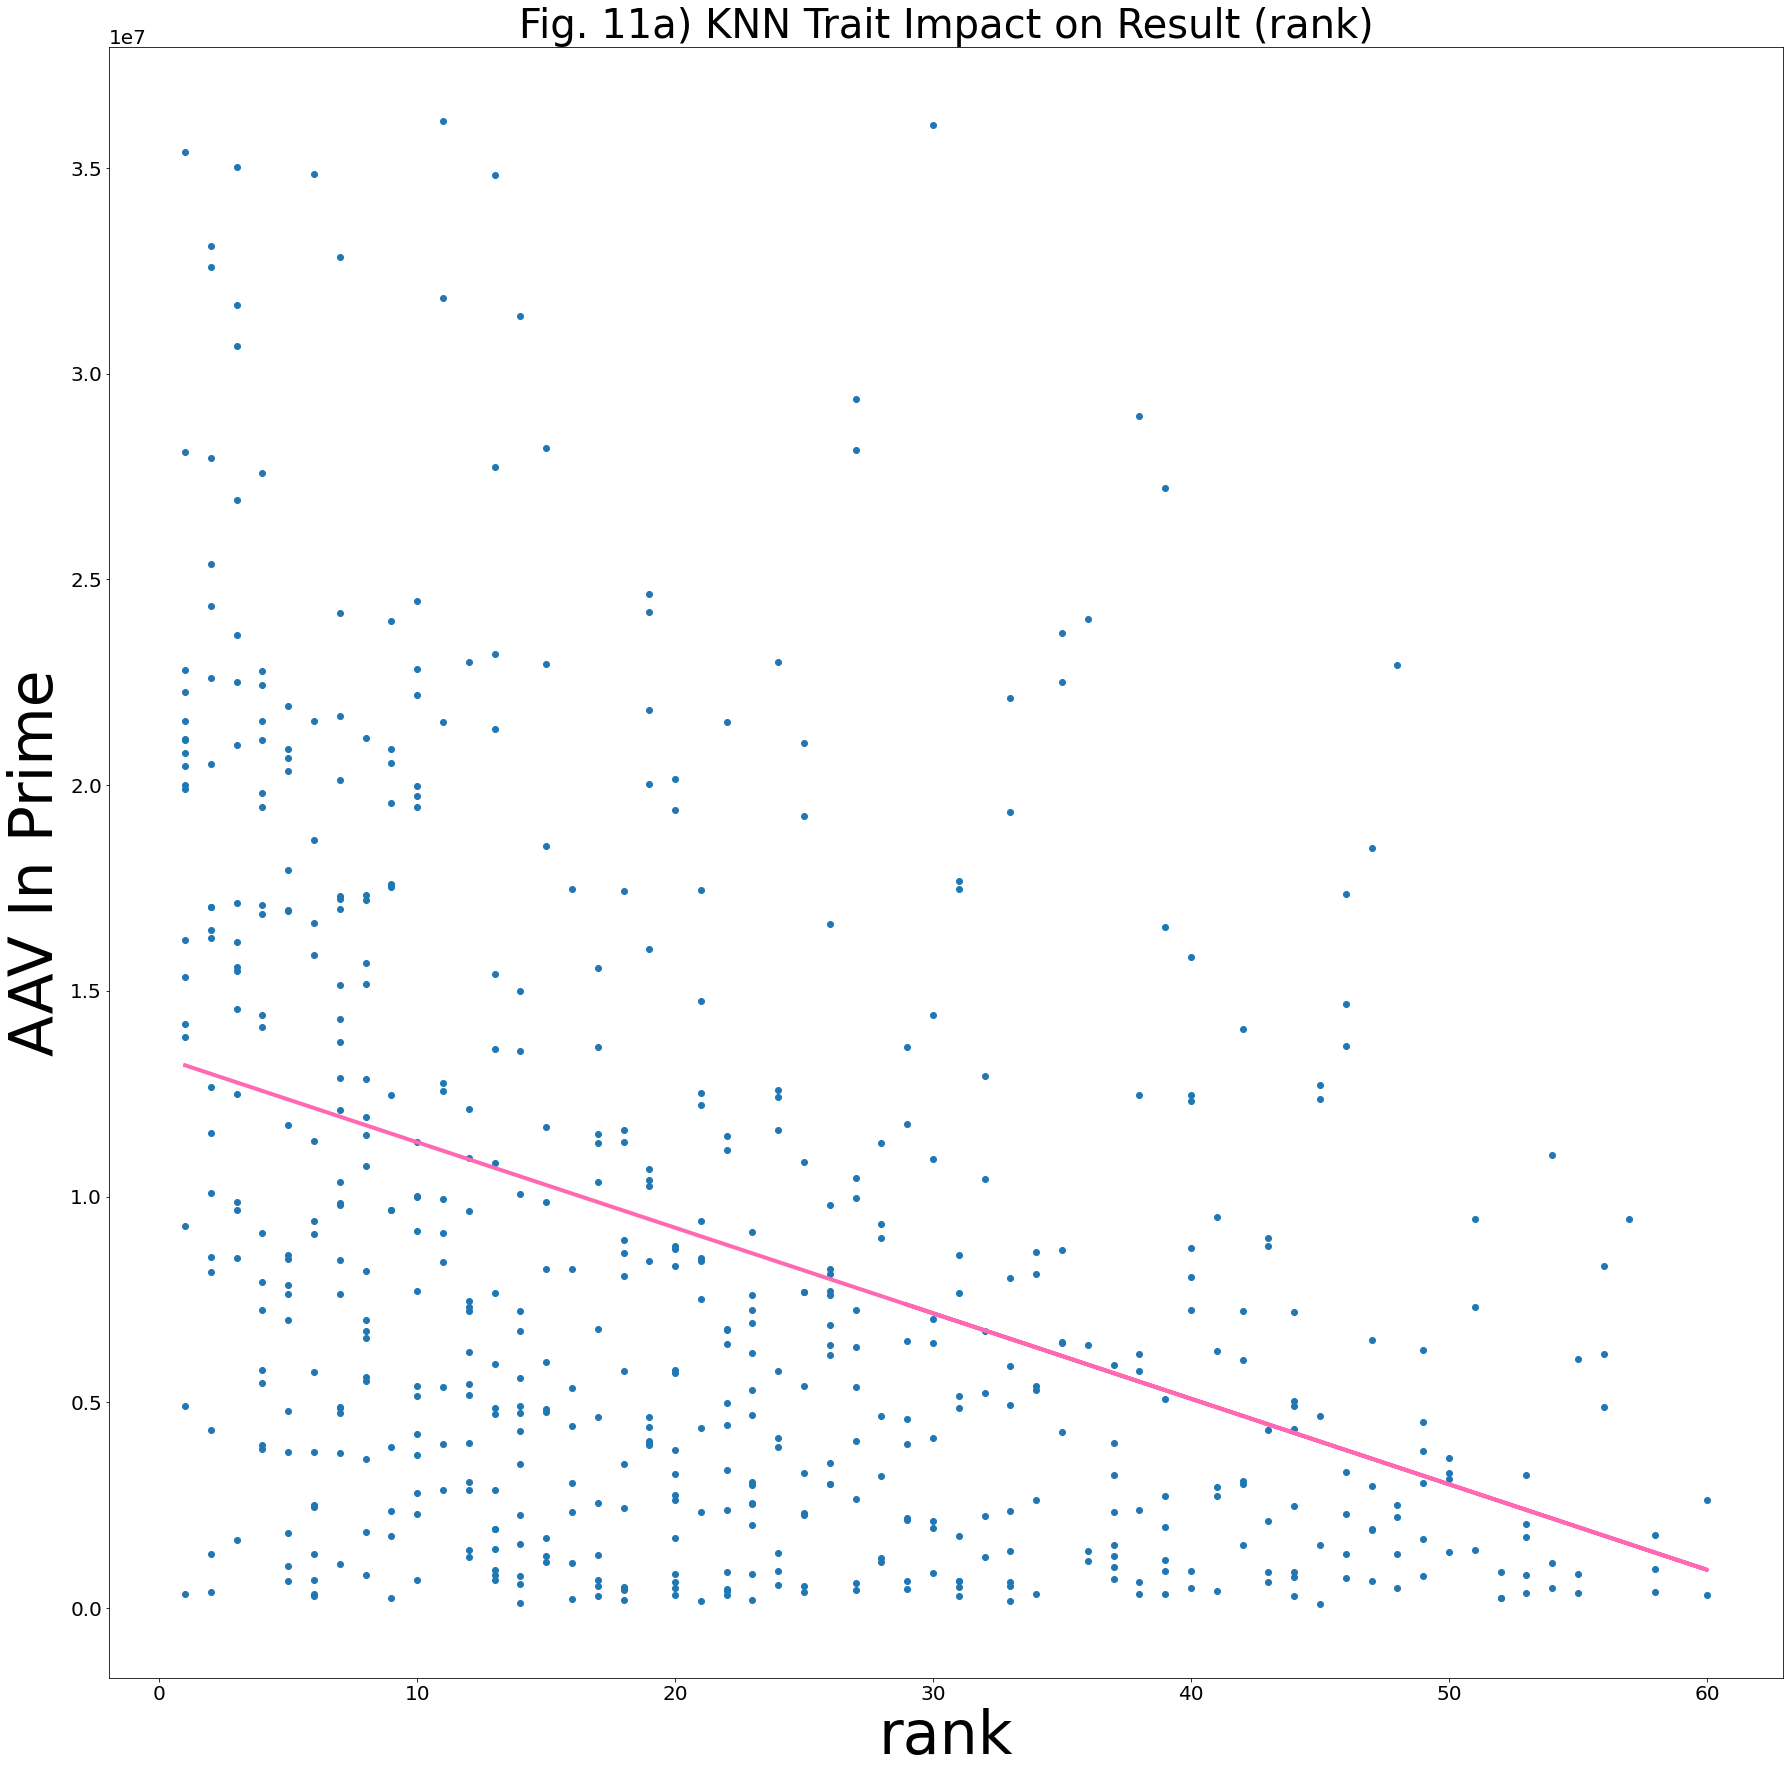

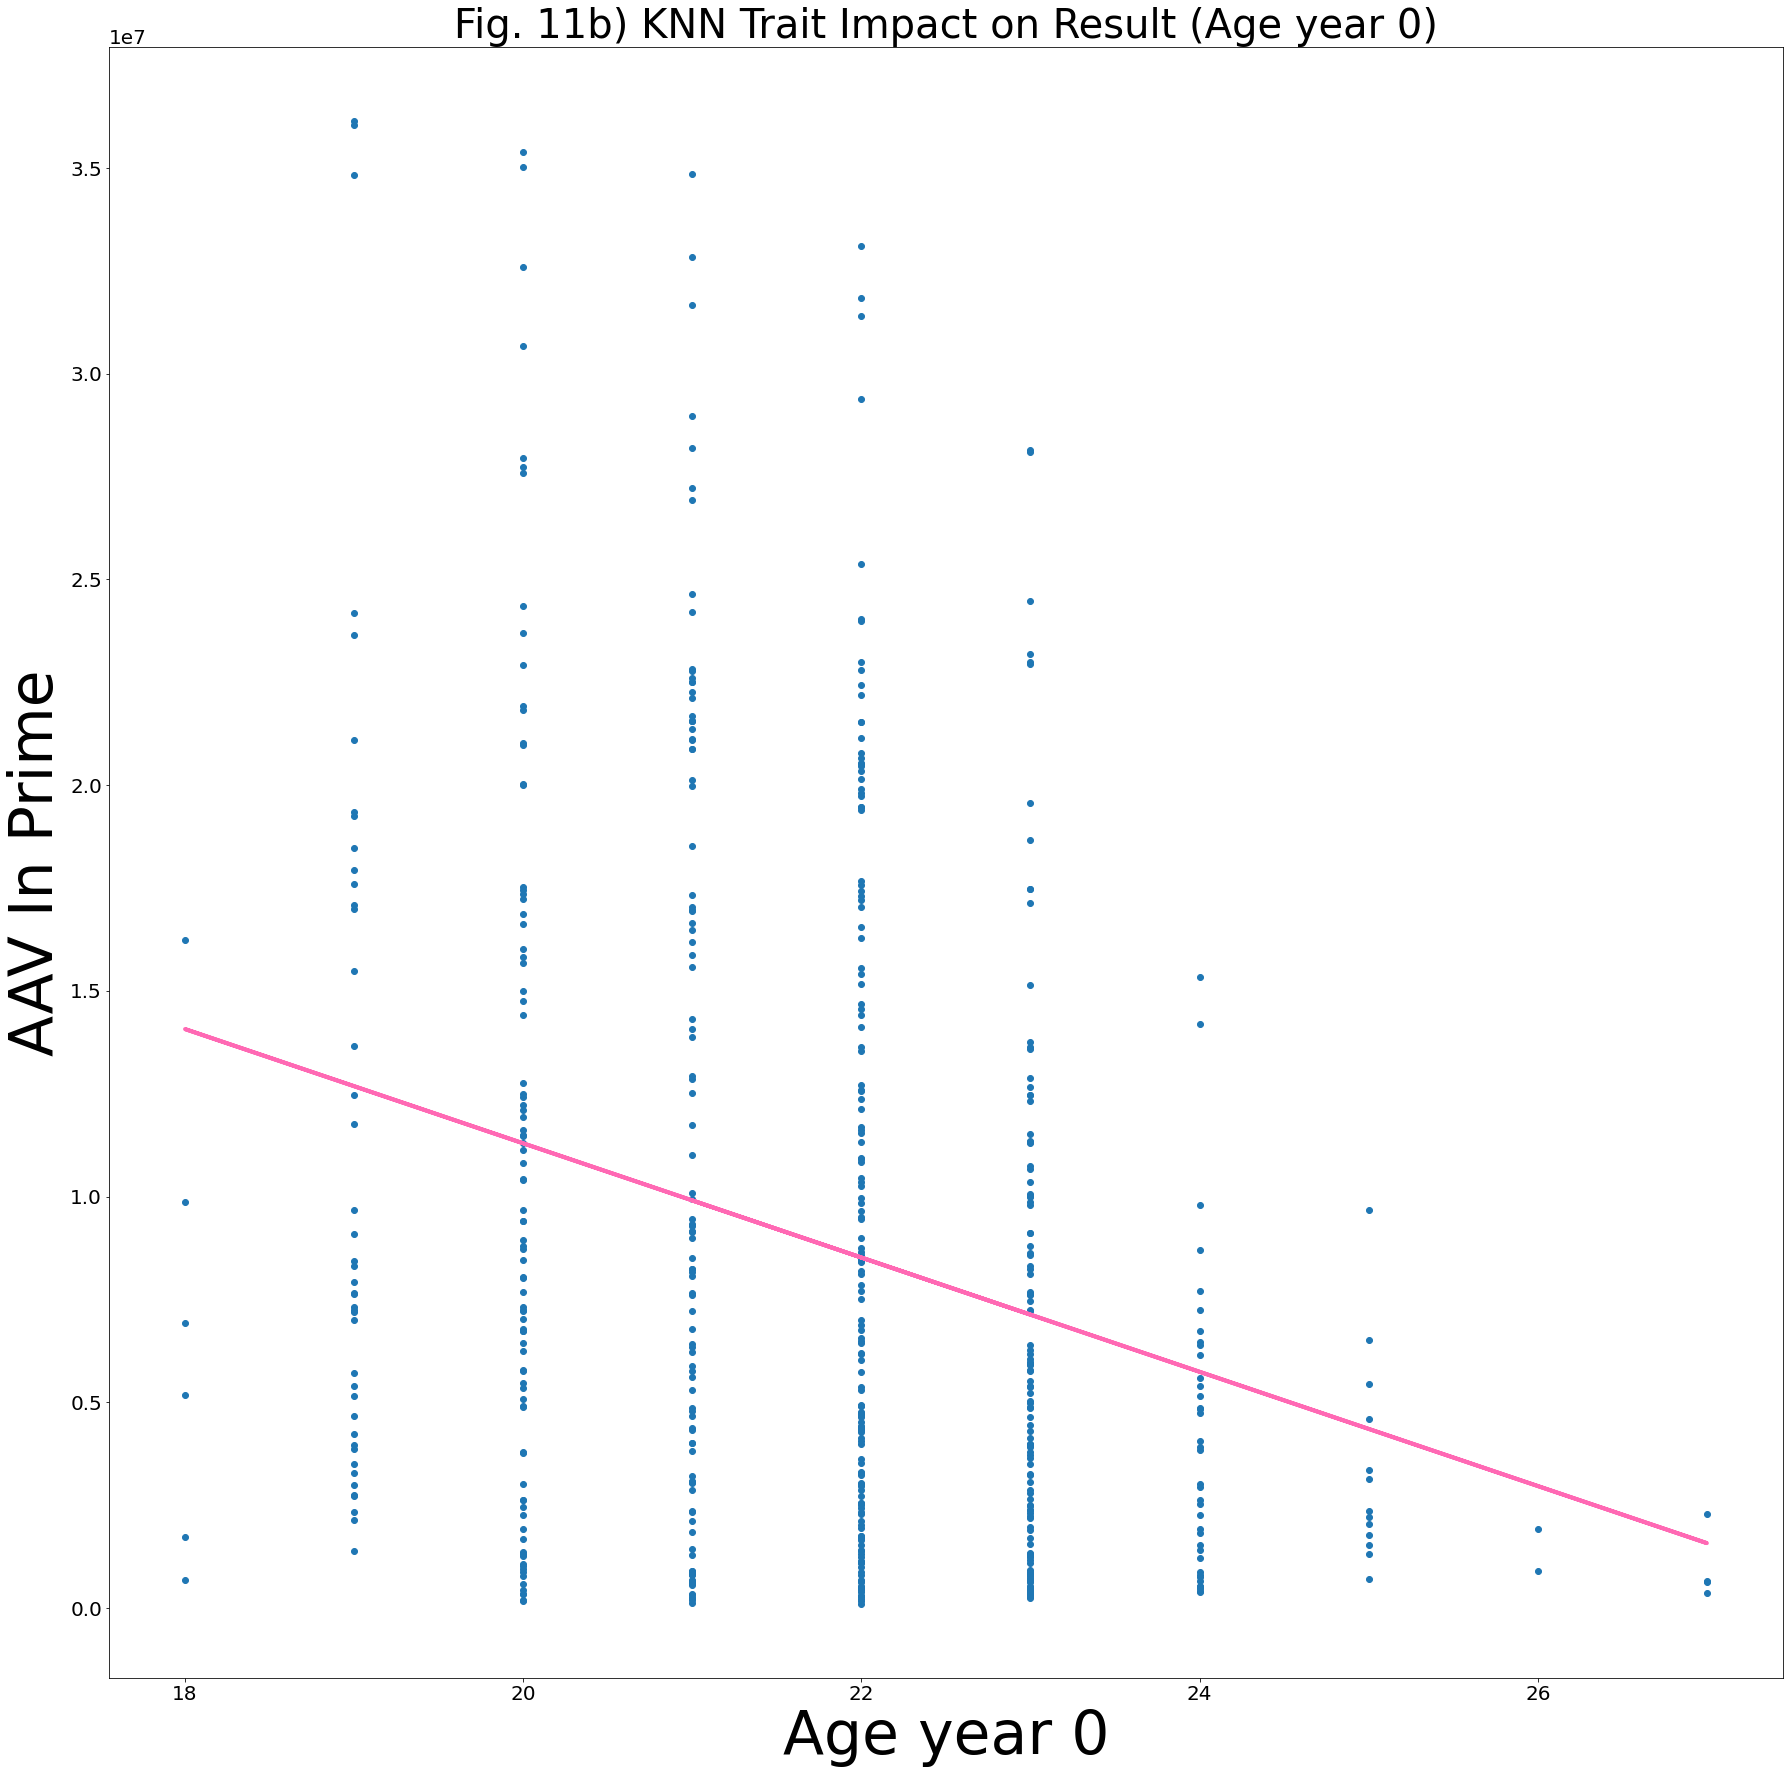

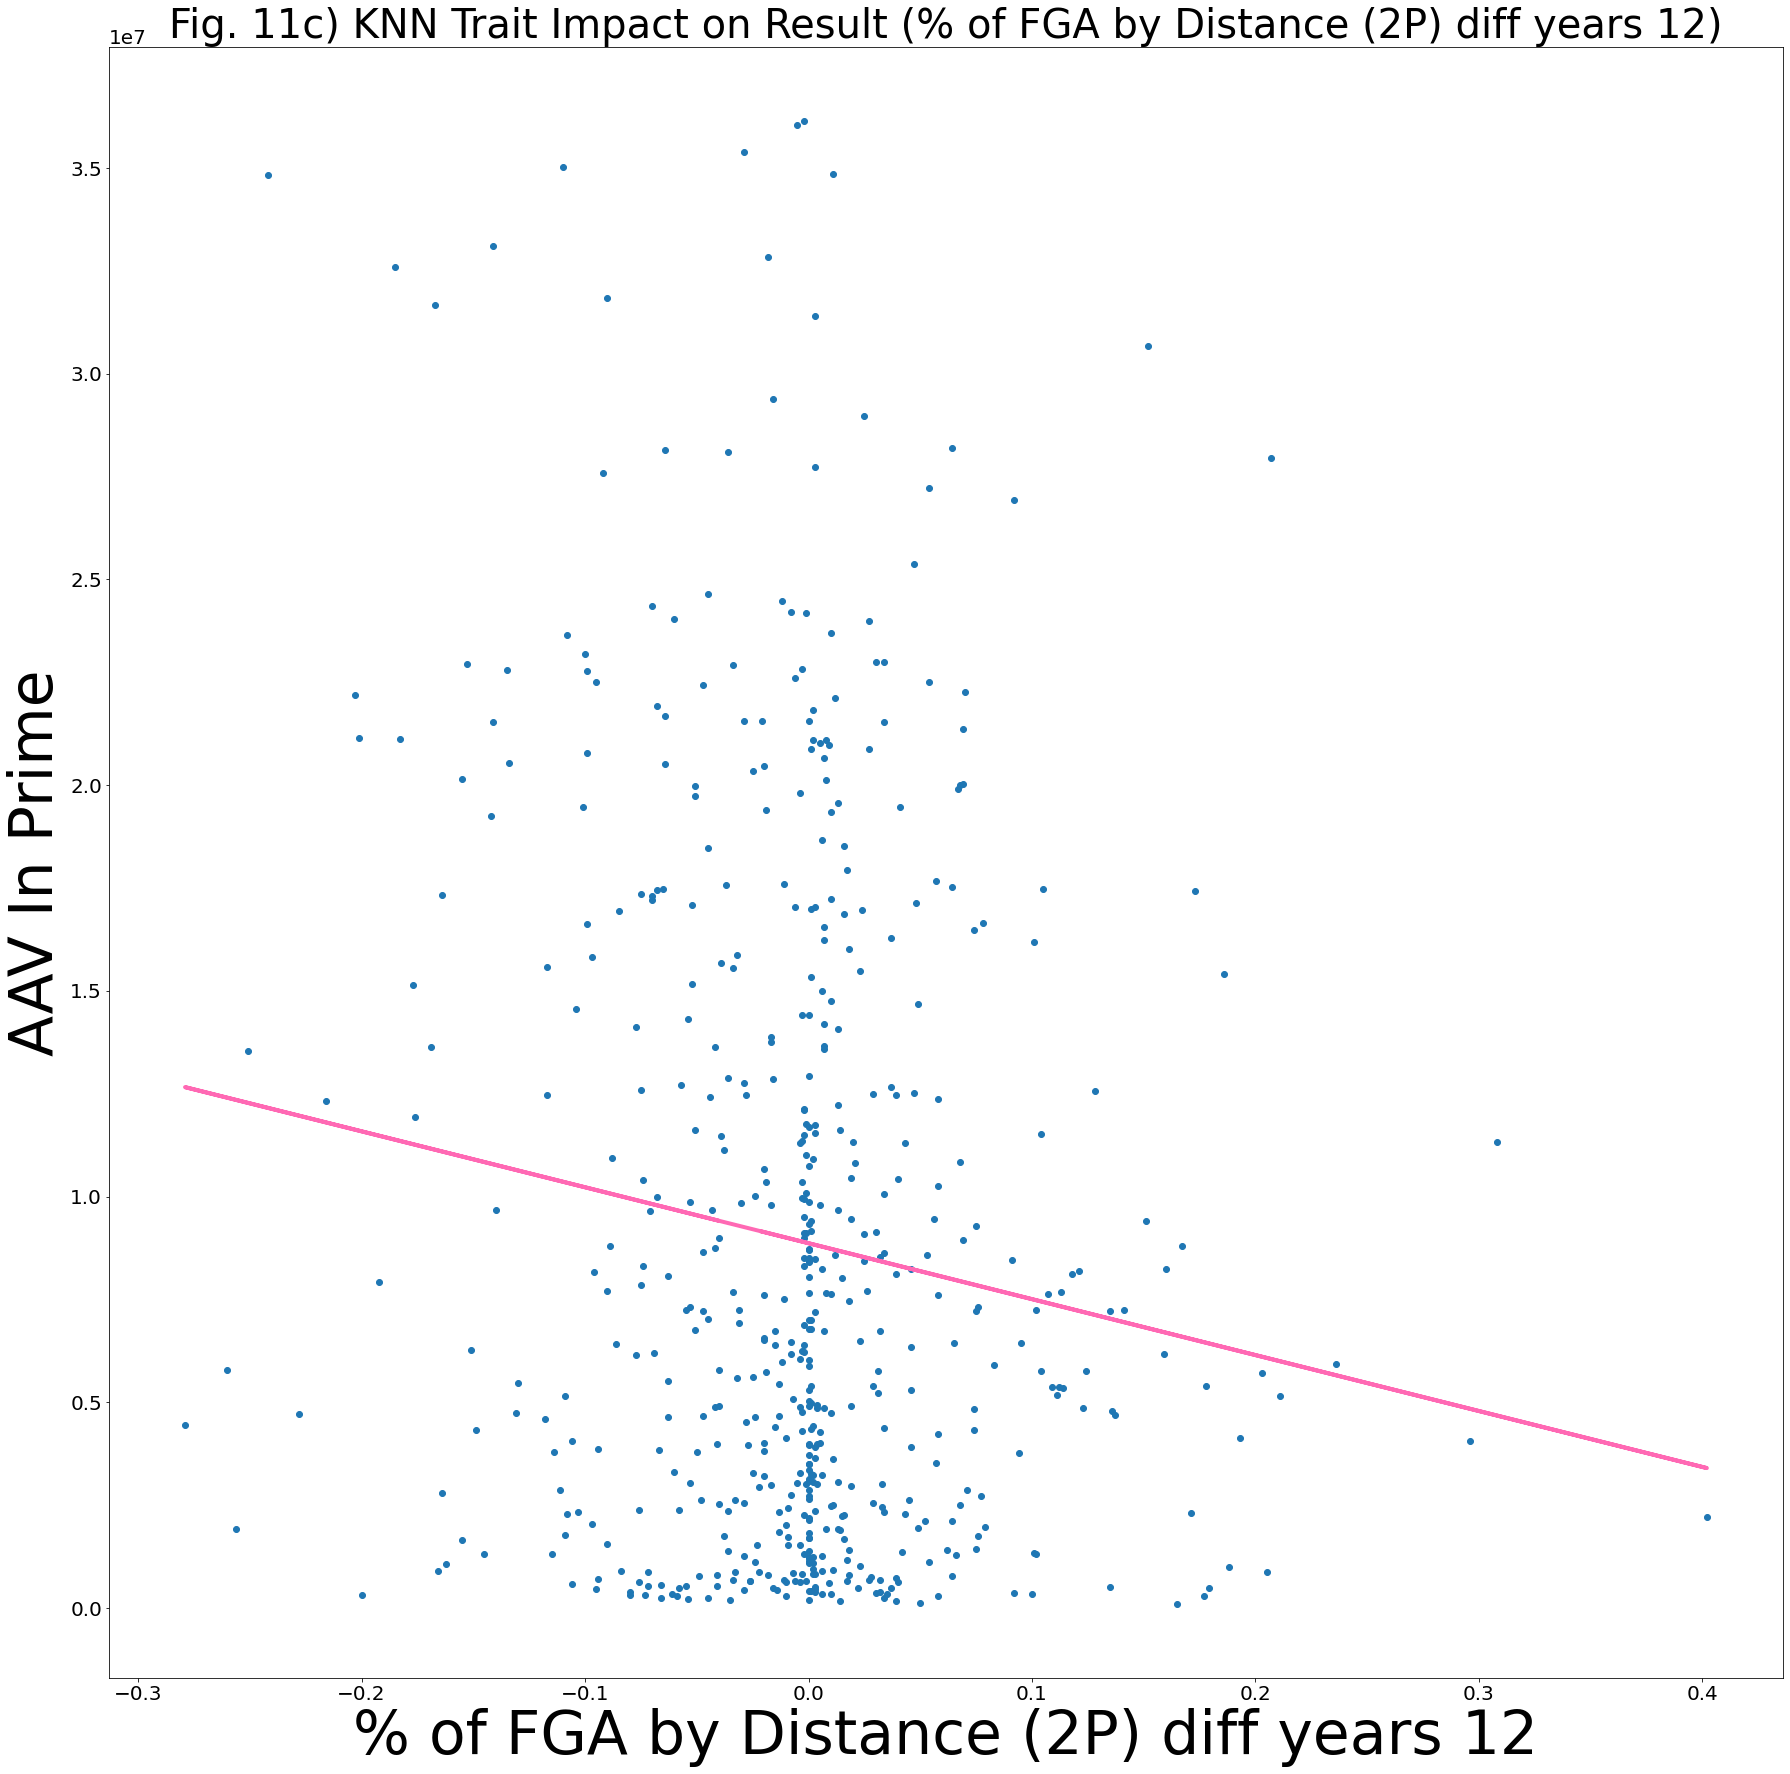

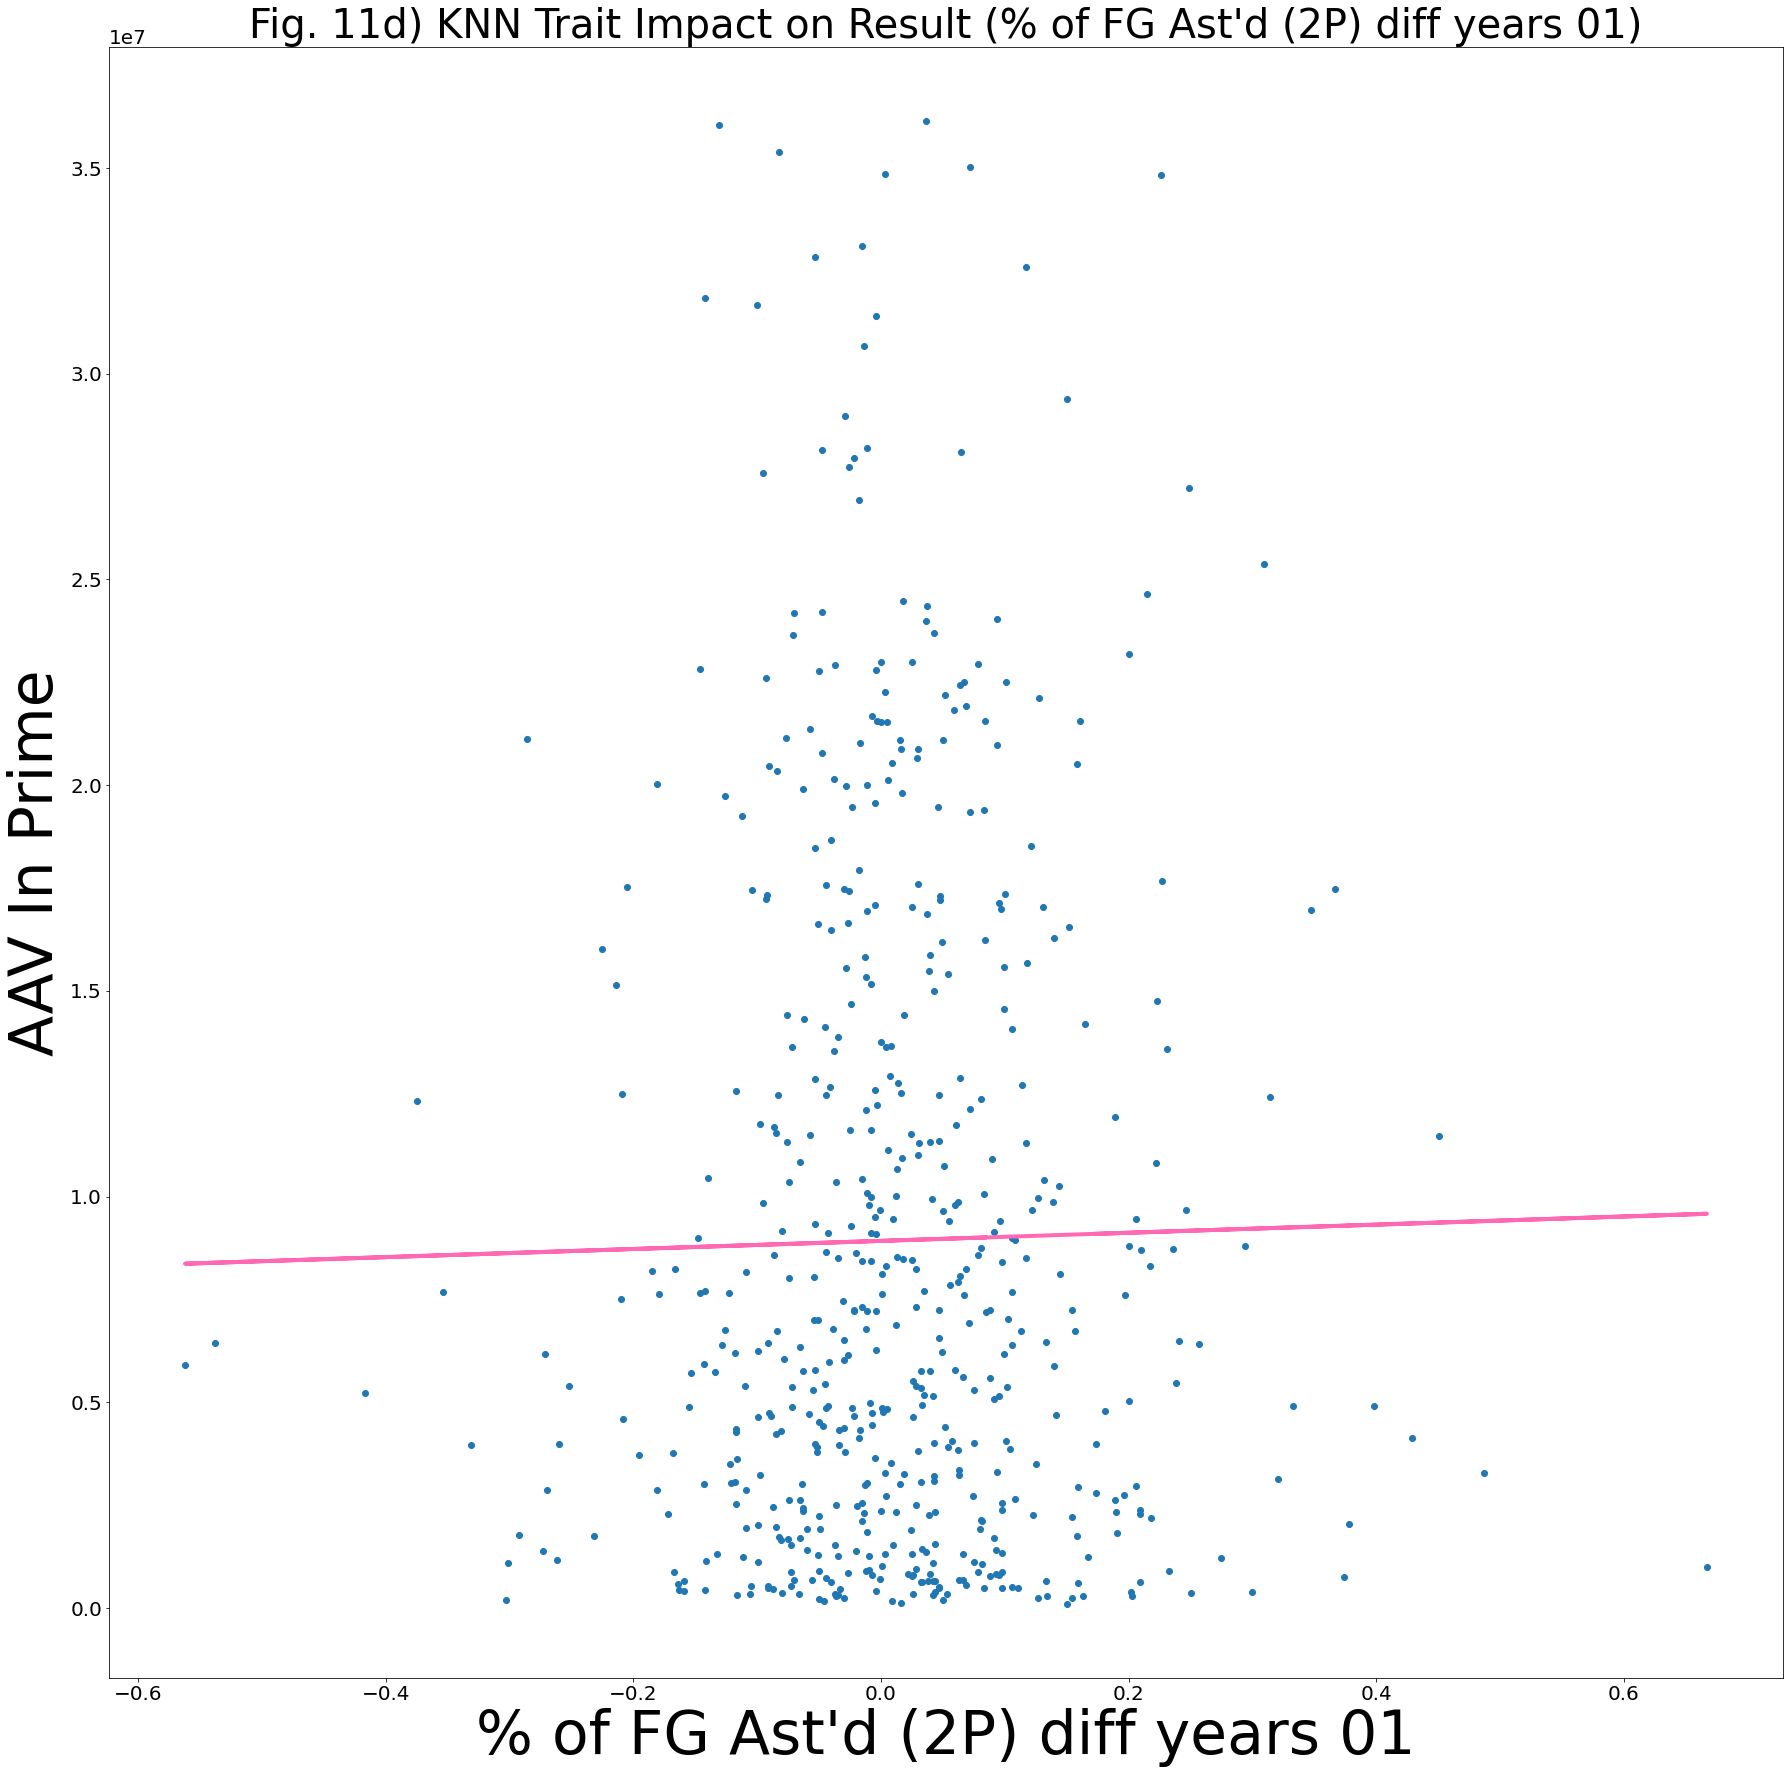

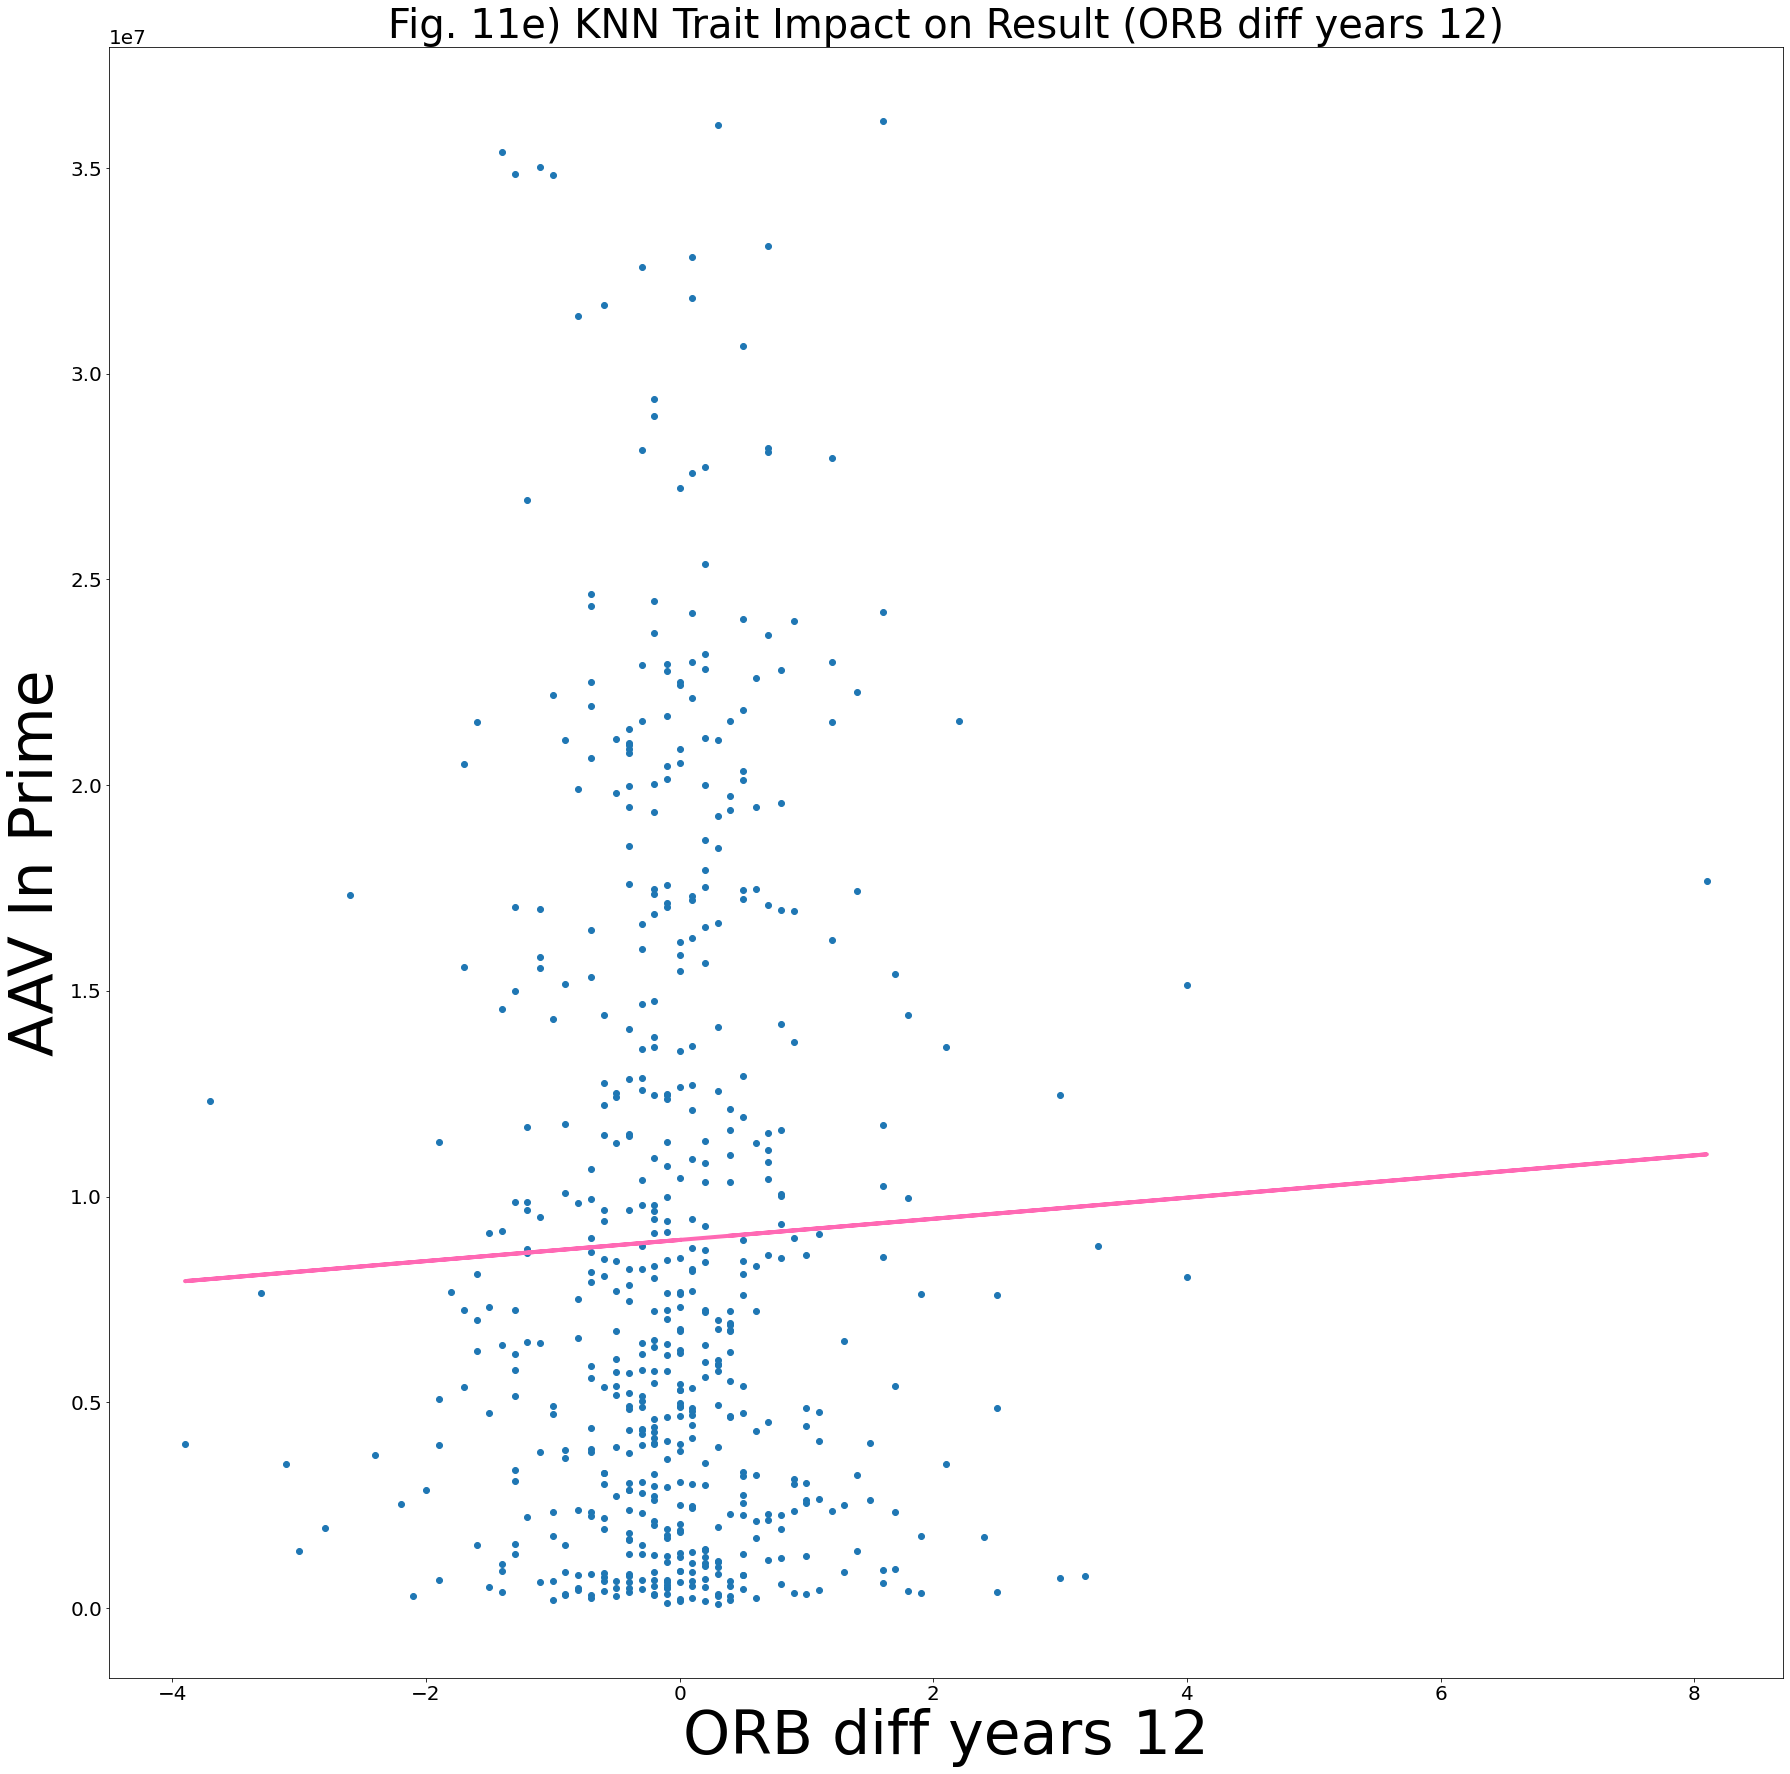

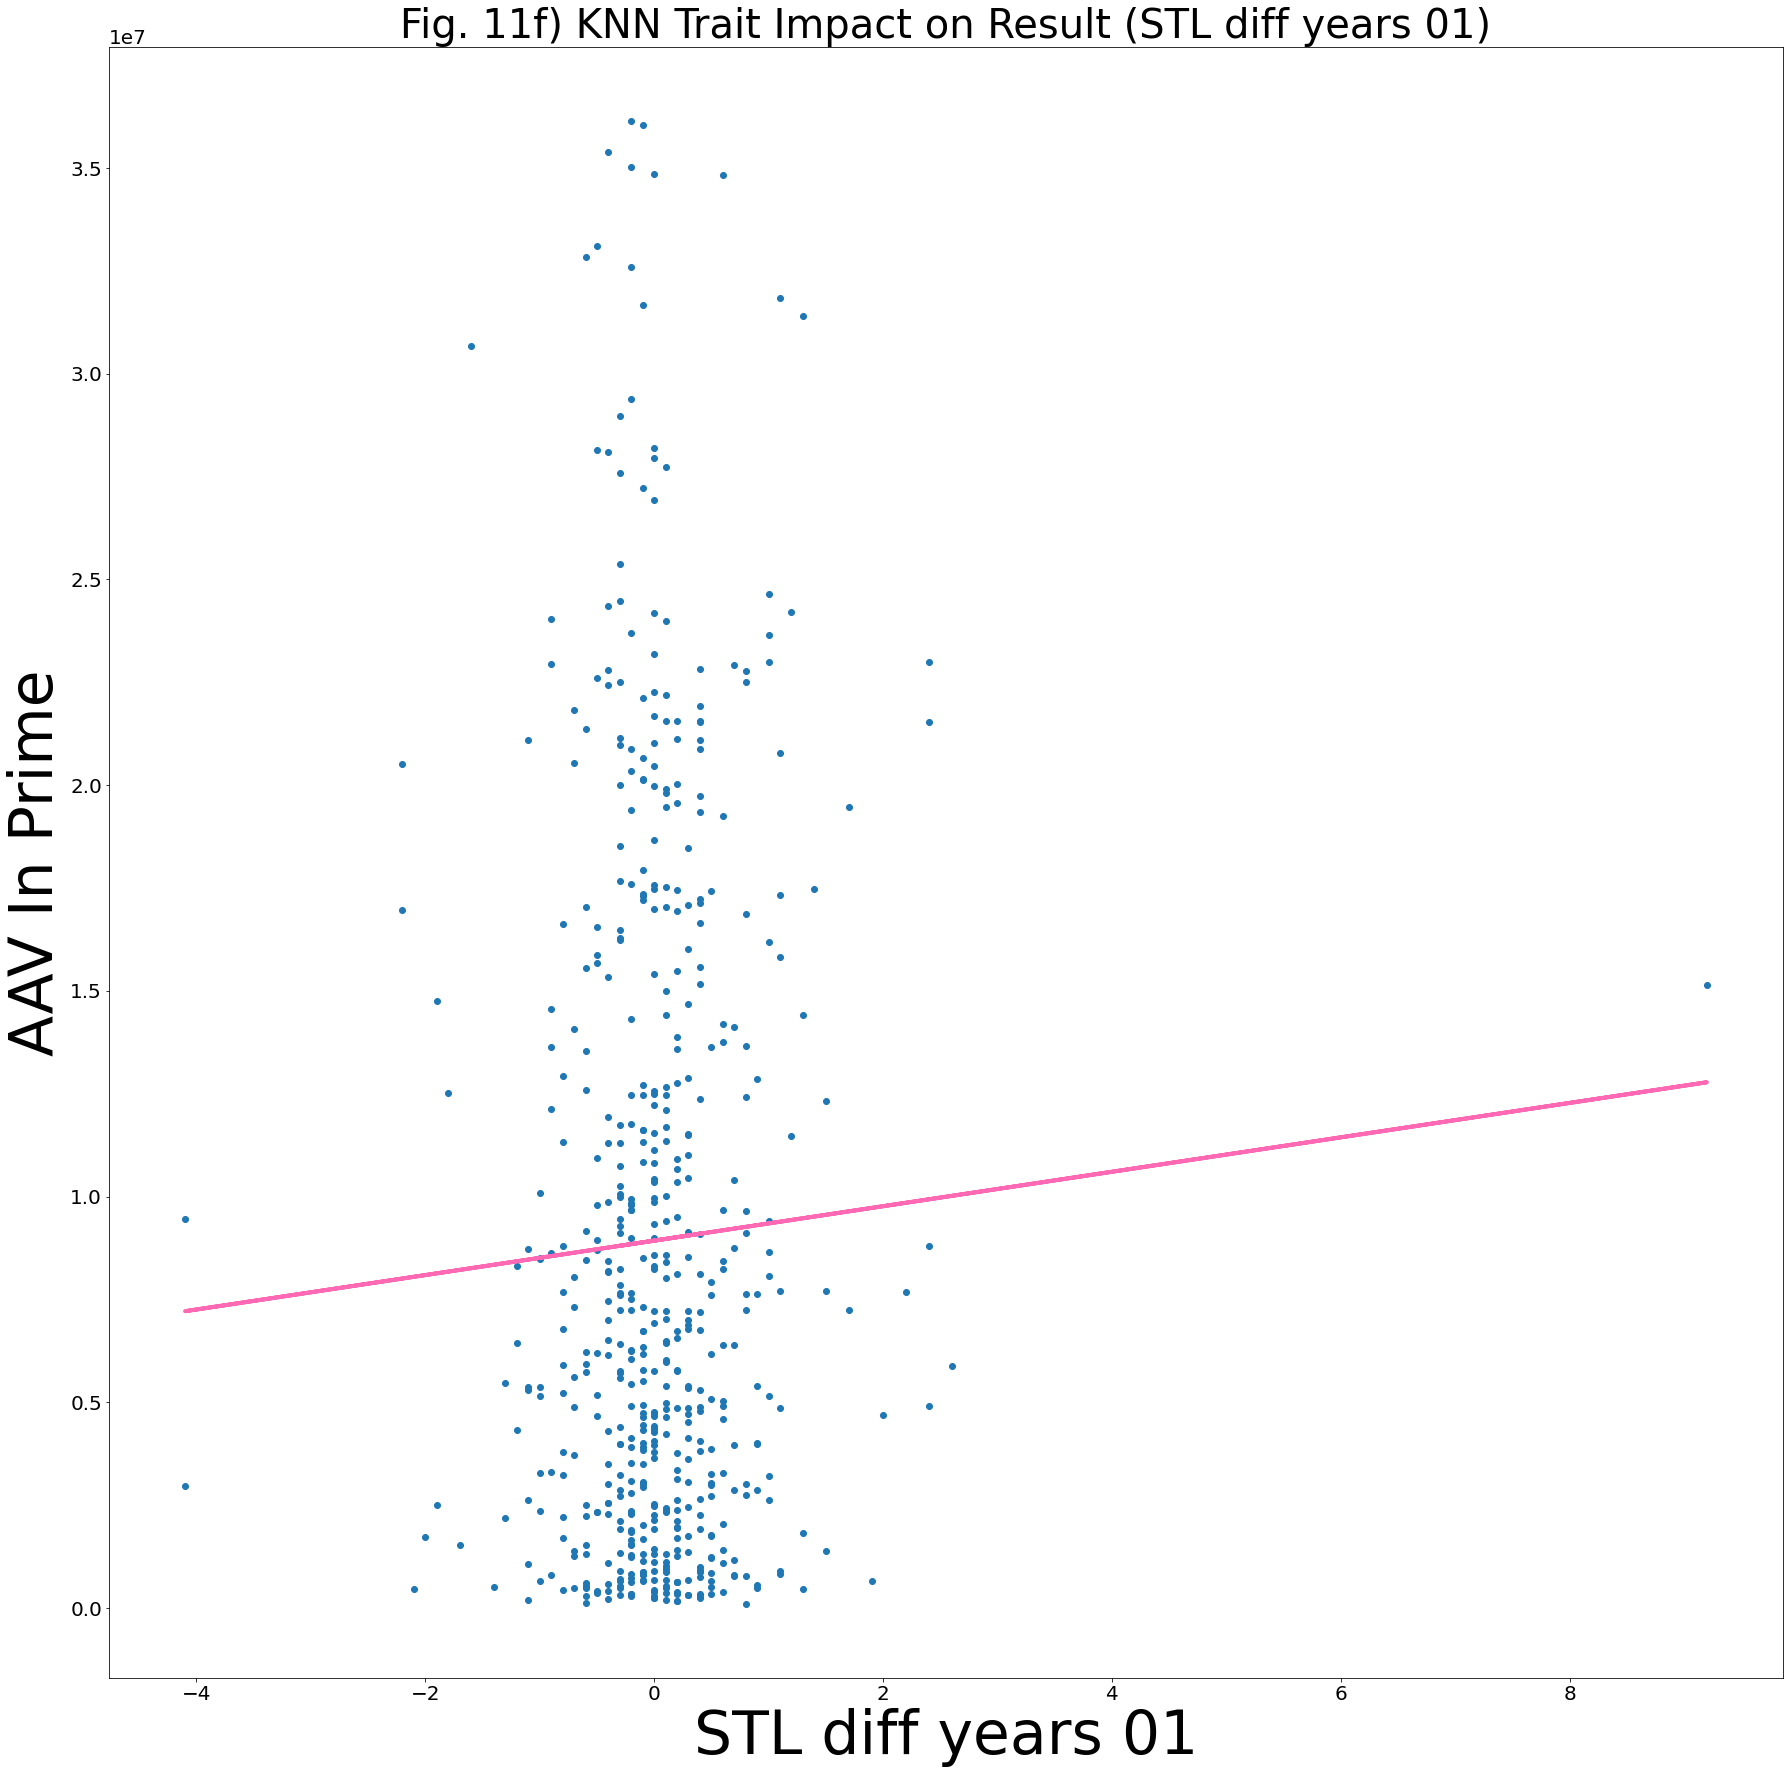

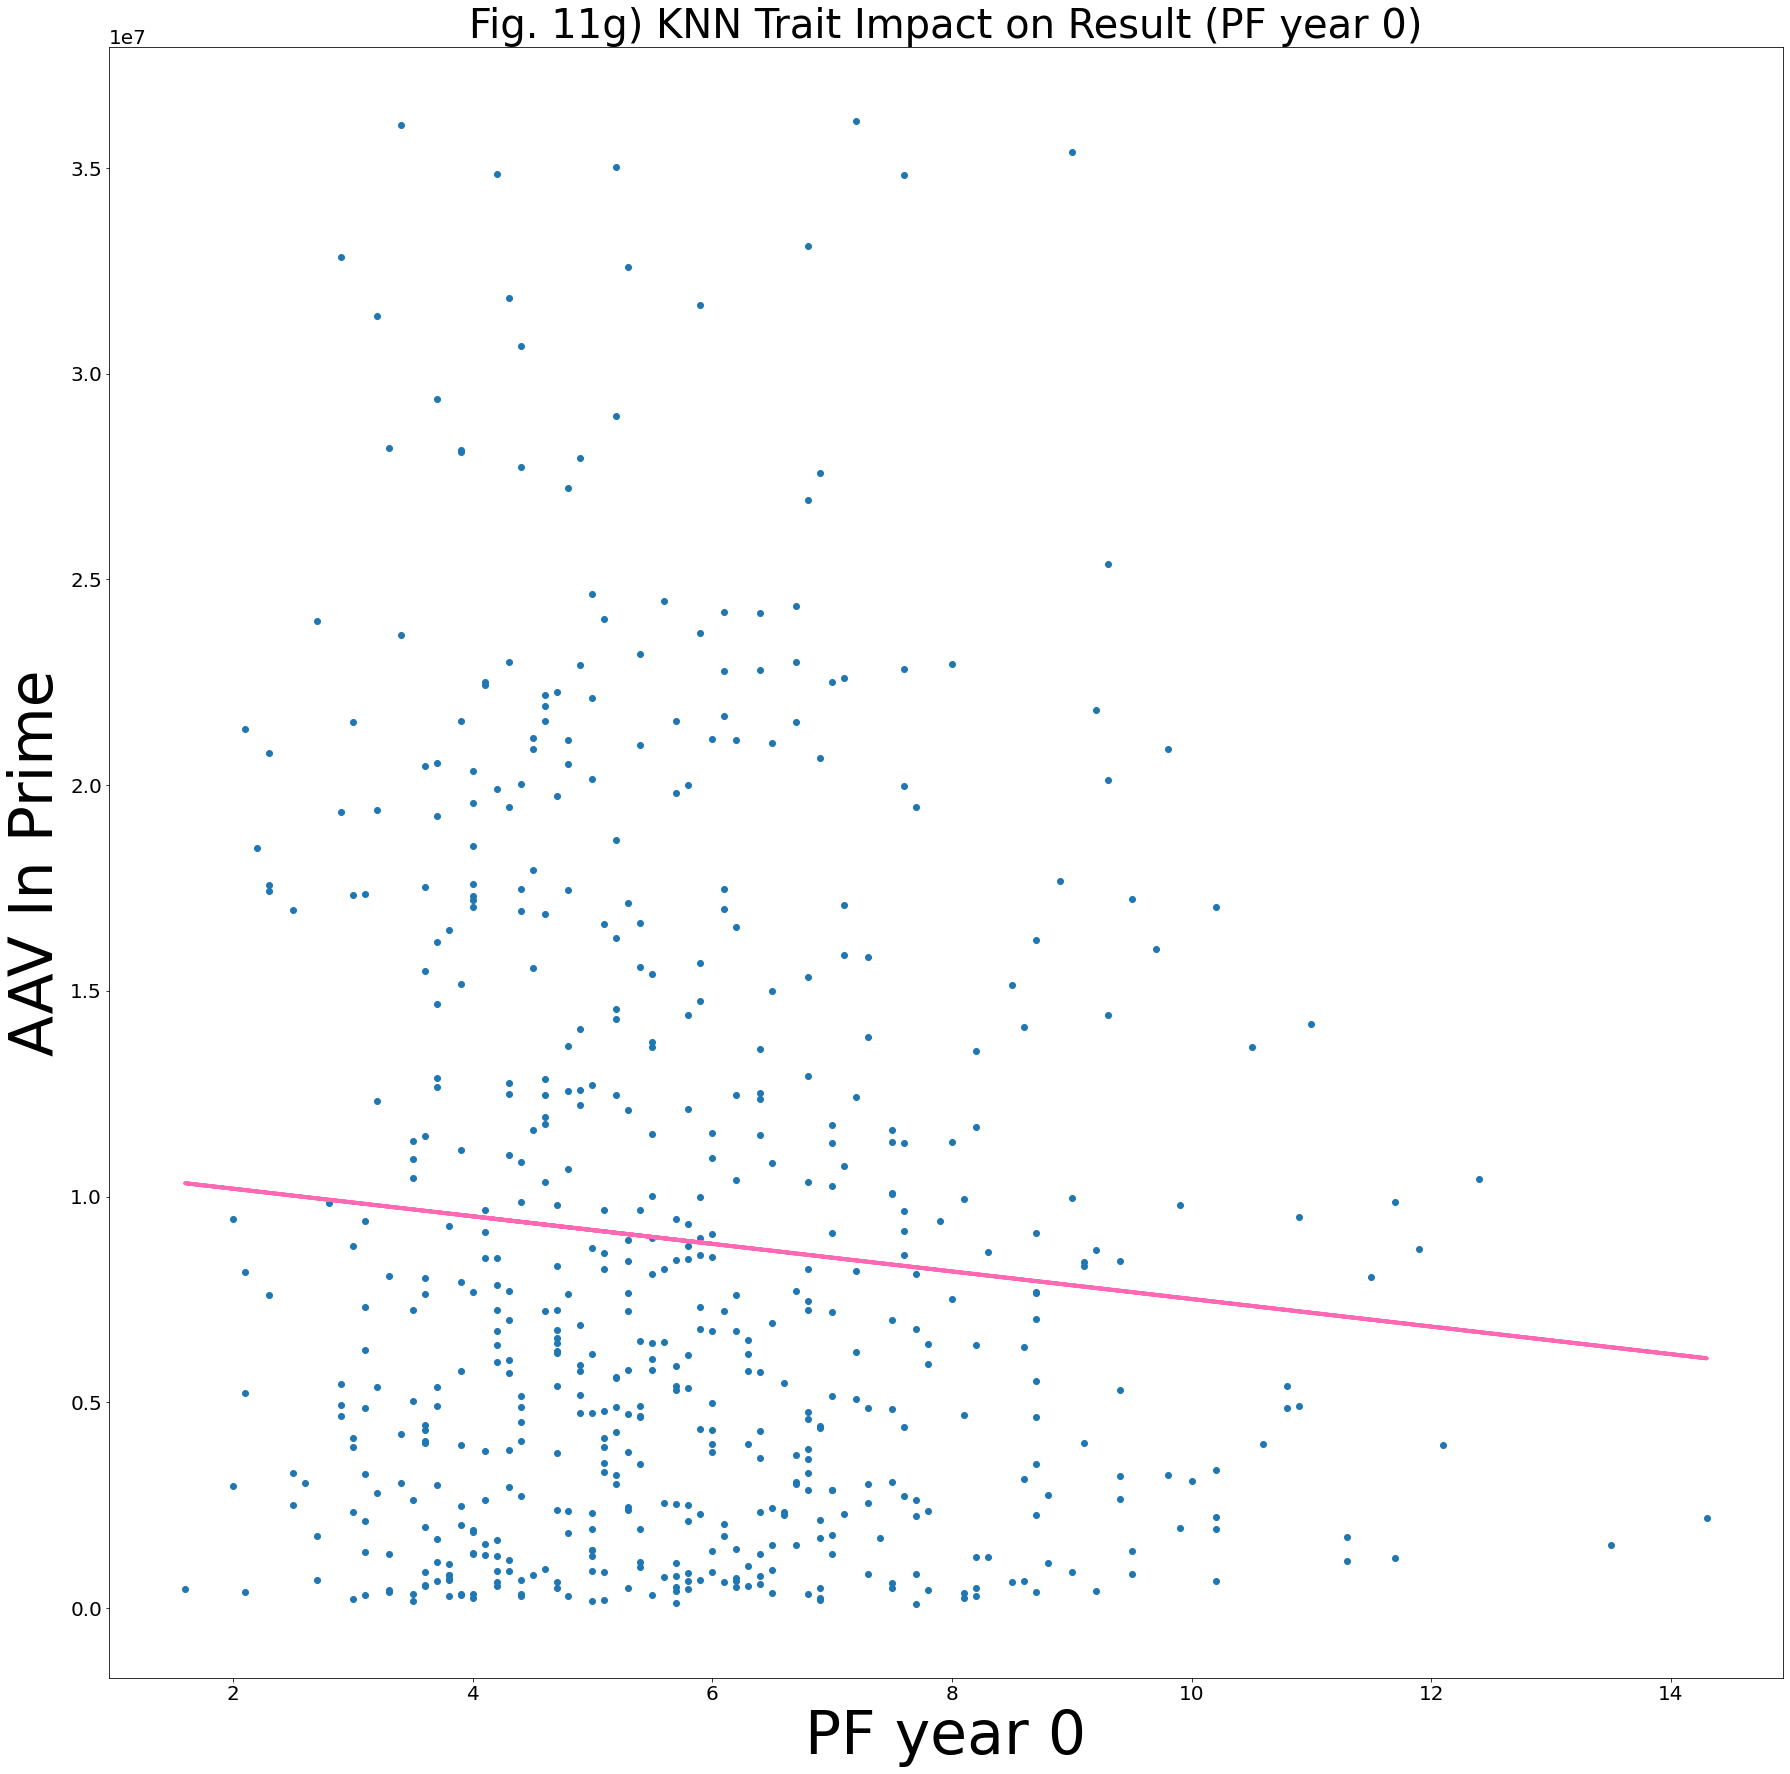

In [36]:
# Graph 2d correlation tables between each trait used and salary (See if each trait is positively or negatively correlated)

counter = 97

for trait in ['rank', 'Age year 0', '% of FGA by Distance (2P) diff years 12', "% of FG Ast'd (2P) diff years 01", 'ORB diff years 12', 'STL diff years 01', 'PF year 0']:
    # Scatter plot of trait against salary
    plt.scatter(NBADataProgressionStyleAll[trait], NBADataProgressionStyleAll["AAV_InPrime"])
    
    # Trend line to see if it has positive or negative impact
    bestFit = LinearRegression()
    bestFit.fit(NBADataProgressionStyleAll[[trait]], NBADataProgressionStyleAll["AAV_InPrime"])
    bestFitLst = bestFit.predict(NBADataProgressionStyleAll[[trait]])
    
    plt.plot(NBADataProgressionStyleAll[trait],bestFitLst,c="hotpink")
    
    plt.xlabel(trait,fontsize=60)
    plt.ylabel("AAV In Prime",fontsize=60)
    plt.title("Fig. 11"+chr(counter)+") KNN Trait Impact on Result ("+str(trait)+")")
    plt.show()
    
    counter+=1